In [55]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pylab as plt

def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
        
        
from hotgrad.variable import Variable
from torch import FloatTensor
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
from torch import cat

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)
y_train.data = y_train.data*2-1
y_test.data = y_test.data*2-1

X_train_baselines = X_train.data.numpy()
X_test_baselines = X_test.data.numpy()
y_train_baselines = (y_train.data == 1)[:, 1].numpy()
y_test_baselines = (y_test.data == 1)[:, 1].numpy()

X_train.data = (X_train.data - X_train.data.mean())/X_train.data.std() 
X_test.data = (X_test.data - X_test.data.mean())/X_test.data.std() 

X_all = Variable(cat((X_train.data, X_test.data), 0))
y_all = Variable(cat((y_train.data, y_test.data), 0))

## Baselines: Parameters Tuning

### Logistic regression

Best lambda: 8.858667904100814
Test score: 0.5


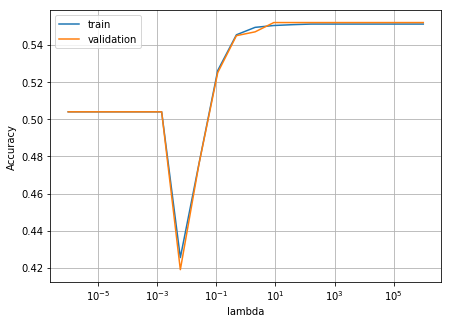

In [56]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.968


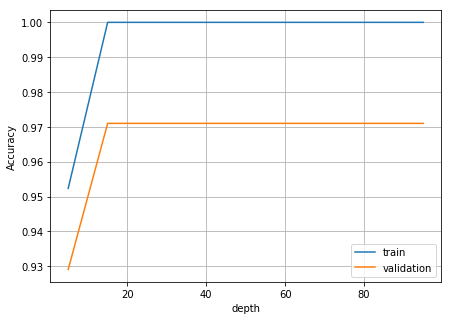

In [38]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### K-Nearest Neighbors

In [39]:
scaler = StandardScaler()
scaler.fit(X_train_baselines)
X_tr_scaled = scaler.transform(X_train_baselines)
X_te_scaled = scaler.transform(X_test_baselines)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 1.0000002
mean average: 4.0596723e-07


In [40]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((1000, 2), (1000, 2))

Best k: 7
Test score: 0.972


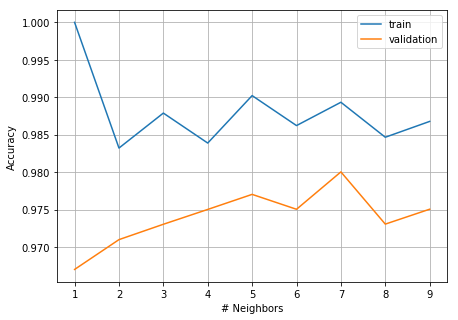

In [41]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, y_train_baselines, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, y_train_baselines)
      .score(X_te_scaled, y_test_baselines))

## Models Comparison

In [57]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)

# model: two input units, two output units, three hidden layers of 25 units
model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()], MSE(), SGD(lr=0.01))

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on KNearest Neighbors...")
knn_scores = cross_validate(
   knn,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on the Sequential Module...")
sequential_scores = model.cross_validate(X_all, y_all, epochs=5000, verbose=True, n_splits=10)

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on KNearest Neighbors...
Running cross validation on the Sequential Module...
----------------- fold 1/10 -----------------
Epoch 0: Train loss: 1.5980448722839355. Train accuracy 51.44%. 
Epoch 1: Train loss: 1.5687956809997559. Train accuracy 51.44%. 
Epoch 2: Train loss: 1.5362164974212646. Train accuracy 51.44%. 
Epoch 3: Train loss: 1.5001429319381714. Train accuracy 51.44%. 
Epoch 4: Train loss: 1.4605687856674194. Train accuracy 51.44%. 
Epoch 5: Train loss: 1.4177294969558716. Train accuracy 51.44%. 
Epoch 6: Train loss: 1.372173547744751. Train accuracy 51.44%. 
Epoch 7: Train loss: 1.3247960805892944. Train accuracy 51.44%. 
Epoch 8: Train loss: 1.2768083810806274. Train accuracy 51.44%. 
Epoch 9: Train loss: 1.229623794555664. Train accuracy 51.44%. 
Epoch 10: Train loss: 1.1846925020217896. Train accuracy 51.44%. 
Epoch 11: Train loss: 1.1433550119400024.

Epoch 123: Train loss: 0.9672715067863464. Train accuracy 65.50%. 
Epoch 124: Train loss: 0.9670578241348267. Train accuracy 65.50%. 
Epoch 125: Train loss: 0.9668437838554382. Train accuracy 65.72%. 
Epoch 126: Train loss: 0.9666290283203125. Train accuracy 65.67%. 
Epoch 127: Train loss: 0.9664138555526733. Train accuracy 65.78%. 
Epoch 128: Train loss: 0.9661980271339417. Train accuracy 65.78%. 
Epoch 129: Train loss: 0.965981662273407. Train accuracy 65.78%. 
Epoch 130: Train loss: 0.965764582157135. Train accuracy 65.94%. 
Epoch 131: Train loss: 0.9655471444129944. Train accuracy 66.11%. 
Epoch 132: Train loss: 0.9653292298316956. Train accuracy 66.22%. 
Epoch 133: Train loss: 0.9651106595993042. Train accuracy 66.11%. 
Epoch 134: Train loss: 0.9648910760879517. Train accuracy 66.11%. 
Epoch 135: Train loss: 0.9646705985069275. Train accuracy 66.17%. 
Epoch 136: Train loss: 0.9644492268562317. Train accuracy 66.17%. 
Epoch 137: Train loss: 0.9642272591590881. Train accuracy 66.28%

Epoch 248: Train loss: 0.9339943528175354. Train accuracy 68.00%. 
Epoch 249: Train loss: 0.9336617588996887. Train accuracy 68.06%. 
Epoch 250: Train loss: 0.9333277344703674. Train accuracy 68.06%. 
Epoch 251: Train loss: 0.9329922795295715. Train accuracy 68.11%. 
Epoch 252: Train loss: 0.9326556921005249. Train accuracy 68.17%. 
Epoch 253: Train loss: 0.9323180913925171. Train accuracy 68.17%. 
Epoch 254: Train loss: 0.931979238986969. Train accuracy 68.22%. 
Epoch 255: Train loss: 0.9316390752792358. Train accuracy 68.11%. 
Epoch 256: Train loss: 0.9312976002693176. Train accuracy 68.11%. 
Epoch 257: Train loss: 0.9309549927711487. Train accuracy 68.17%. 
Epoch 258: Train loss: 0.9306109547615051. Train accuracy 68.17%. 
Epoch 259: Train loss: 0.9302656054496765. Train accuracy 68.22%. 
Epoch 260: Train loss: 0.9299189448356628. Train accuracy 68.22%. 
Epoch 261: Train loss: 0.9295711517333984. Train accuracy 68.28%. 
Epoch 262: Train loss: 0.9292218685150146. Train accuracy 68.33

Epoch 386: Train loss: 0.8718318343162537. Train accuracy 73.78%. 
Epoch 387: Train loss: 0.8712197542190552. Train accuracy 73.89%. 
Epoch 388: Train loss: 0.8706045746803284. Train accuracy 74.00%. 
Epoch 389: Train loss: 0.869986355304718. Train accuracy 74.00%. 
Epoch 390: Train loss: 0.8693649768829346. Train accuracy 74.00%. 
Epoch 391: Train loss: 0.868740439414978. Train accuracy 74.06%. 
Epoch 392: Train loss: 0.8681126832962036. Train accuracy 74.28%. 
Epoch 393: Train loss: 0.8674817085266113. Train accuracy 74.44%. 
Epoch 394: Train loss: 0.8668475151062012. Train accuracy 74.56%. 
Epoch 395: Train loss: 0.8662099838256836. Train accuracy 74.72%. 
Epoch 396: Train loss: 0.8655691742897034. Train accuracy 74.83%. 
Epoch 397: Train loss: 0.86492520570755. Train accuracy 75.00%. 
Epoch 398: Train loss: 0.8642778396606445. Train accuracy 75.06%. 
Epoch 399: Train loss: 0.8636271953582764. Train accuracy 75.06%. 
Epoch 400: Train loss: 0.8629732728004456. Train accuracy 75.22%. 

Epoch 523: Train loss: 0.7511017322540283. Train accuracy 86.06%. 
Epoch 524: Train loss: 0.7498928308486938. Train accuracy 86.11%. 
Epoch 525: Train loss: 0.7486788630485535. Train accuracy 86.28%. 
Epoch 526: Train loss: 0.7474597096443176. Train accuracy 86.33%. 
Epoch 527: Train loss: 0.7462352514266968. Train accuracy 86.44%. 
Epoch 528: Train loss: 0.7450053691864014. Train accuracy 86.56%. 
Epoch 529: Train loss: 0.7437702417373657. Train accuracy 86.61%. 
Epoch 530: Train loss: 0.7425298094749451. Train accuracy 86.61%. 
Epoch 531: Train loss: 0.741284191608429. Train accuracy 86.72%. 
Epoch 532: Train loss: 0.7400335073471069. Train accuracy 86.67%. 
Epoch 533: Train loss: 0.7387775778770447. Train accuracy 86.78%. 
Epoch 534: Train loss: 0.737516462802887. Train accuracy 86.89%. 
Epoch 535: Train loss: 0.7362502217292786. Train accuracy 87.06%. 
Epoch 536: Train loss: 0.7349787950515747. Train accuracy 87.28%. 
Epoch 537: Train loss: 0.7337021231651306. Train accuracy 87.44%

Epoch 657: Train loss: 0.5521932244300842. Train accuracy 94.33%. 
Epoch 658: Train loss: 0.5505753755569458. Train accuracy 94.33%. 
Epoch 659: Train loss: 0.5489585995674133. Train accuracy 94.33%. 
Epoch 660: Train loss: 0.547343373298645. Train accuracy 94.33%. 
Epoch 661: Train loss: 0.5457297563552856. Train accuracy 94.33%. 
Epoch 662: Train loss: 0.5441173315048218. Train accuracy 94.39%. 
Epoch 663: Train loss: 0.5425064563751221. Train accuracy 94.39%. 
Epoch 664: Train loss: 0.5408973693847656. Train accuracy 94.44%. 
Epoch 665: Train loss: 0.5392895936965942. Train accuracy 94.44%. 
Epoch 666: Train loss: 0.5376834273338318. Train accuracy 94.50%. 
Epoch 667: Train loss: 0.536078691482544. Train accuracy 94.61%. 
Epoch 668: Train loss: 0.534475564956665. Train accuracy 94.67%. 
Epoch 669: Train loss: 0.5328738689422607. Train accuracy 94.67%. 
Epoch 670: Train loss: 0.5312739610671997. Train accuracy 94.67%. 
Epoch 671: Train loss: 0.5296761393547058. Train accuracy 94.72%.

Epoch 787: Train loss: 0.36880192160606384. Train accuracy 96.28%. 
Epoch 788: Train loss: 0.36769571900367737. Train accuracy 96.28%. 
Epoch 789: Train loss: 0.36659467220306396. Train accuracy 96.33%. 
Epoch 790: Train loss: 0.3654986023902893. Train accuracy 96.33%. 
Epoch 791: Train loss: 0.36440765857696533. Train accuracy 96.39%. 
Epoch 792: Train loss: 0.3633214235305786. Train accuracy 96.44%. 
Epoch 793: Train loss: 0.36224010586738586. Train accuracy 96.50%. 
Epoch 794: Train loss: 0.36116430163383484. Train accuracy 96.50%. 
Epoch 795: Train loss: 0.3600935935974121. Train accuracy 96.56%. 
Epoch 796: Train loss: 0.3590277433395386. Train accuracy 96.56%. 
Epoch 797: Train loss: 0.3579668700695038. Train accuracy 96.50%. 
Epoch 798: Train loss: 0.3569106459617615. Train accuracy 96.44%. 
Epoch 799: Train loss: 0.3558594882488251. Train accuracy 96.44%. 
Epoch 800: Train loss: 0.3548131585121155. Train accuracy 96.50%. 
Epoch 801: Train loss: 0.3537715971469879. Train accurac

Epoch 925: Train loss: 0.25639304518699646. Train accuracy 97.22%. 
Epoch 926: Train loss: 0.25579357147216797. Train accuracy 97.22%. 
Epoch 927: Train loss: 0.25519686937332153. Train accuracy 97.22%. 
Epoch 928: Train loss: 0.2546072006225586. Train accuracy 97.22%. 
Epoch 929: Train loss: 0.2540244460105896. Train accuracy 97.17%. 
Epoch 930: Train loss: 0.2534477114677429. Train accuracy 97.17%. 
Epoch 931: Train loss: 0.2528749108314514. Train accuracy 97.17%. 
Epoch 932: Train loss: 0.2523080110549927. Train accuracy 97.17%. 
Epoch 933: Train loss: 0.2517460584640503. Train accuracy 97.17%. 
Epoch 934: Train loss: 0.2511879801750183. Train accuracy 97.17%. 
Epoch 935: Train loss: 0.25063326954841614. Train accuracy 97.17%. 
Epoch 936: Train loss: 0.2500816881656647. Train accuracy 97.17%. 
Epoch 937: Train loss: 0.24953413009643555. Train accuracy 97.17%. 
Epoch 938: Train loss: 0.2489892840385437. Train accuracy 97.17%. 
Epoch 939: Train loss: 0.24844786524772644. Train accurac

Epoch 1072: Train loss: 0.19449898600578308. Train accuracy 97.50%. 
Epoch 1073: Train loss: 0.1941954642534256. Train accuracy 97.50%. 
Epoch 1074: Train loss: 0.19389325380325317. Train accuracy 97.44%. 
Epoch 1075: Train loss: 0.19359217584133148. Train accuracy 97.44%. 
Epoch 1076: Train loss: 0.1932922899723053. Train accuracy 97.44%. 
Epoch 1077: Train loss: 0.192993625998497. Train accuracy 97.44%. 
Epoch 1078: Train loss: 0.19269607961177826. Train accuracy 97.50%. 
Epoch 1079: Train loss: 0.19239965081214905. Train accuracy 97.50%. 
Epoch 1080: Train loss: 0.19210435450077057. Train accuracy 97.50%. 
Epoch 1081: Train loss: 0.19181013107299805. Train accuracy 97.50%. 
Epoch 1082: Train loss: 0.19151704013347626. Train accuracy 97.50%. 
Epoch 1083: Train loss: 0.1912250518798828. Train accuracy 97.50%. 
Epoch 1084: Train loss: 0.19093427062034607. Train accuracy 97.56%. 
Epoch 1085: Train loss: 0.19064472615718842. Train accuracy 97.56%. 
Epoch 1086: Train loss: 0.1903563439846

Epoch 1209: Train loss: 0.16173234581947327. Train accuracy 97.83%. 
Epoch 1210: Train loss: 0.16154448688030243. Train accuracy 97.83%. 
Epoch 1211: Train loss: 0.16135720908641815. Train accuracy 97.83%. 
Epoch 1212: Train loss: 0.16117051243782043. Train accuracy 97.83%. 
Epoch 1213: Train loss: 0.16098444163799286. Train accuracy 97.83%. 
Epoch 1214: Train loss: 0.16079893708229065. Train accuracy 97.83%. 
Epoch 1215: Train loss: 0.1606140434741974. Train accuracy 97.89%. 
Epoch 1216: Train loss: 0.1604299694299698. Train accuracy 97.89%. 
Epoch 1217: Train loss: 0.16024647653102875. Train accuracy 97.89%. 
Epoch 1218: Train loss: 0.16006354987621307. Train accuracy 97.89%. 
Epoch 1219: Train loss: 0.15988118946552277. Train accuracy 97.89%. 
Epoch 1220: Train loss: 0.15969935059547424. Train accuracy 97.89%. 
Epoch 1221: Train loss: 0.1595180630683899. Train accuracy 97.89%. 
Epoch 1222: Train loss: 0.15933726727962494. Train accuracy 97.89%. 
Epoch 1223: Train loss: 0.15915687382

Epoch 1353: Train loss: 0.13963711261749268. Train accuracy 97.94%. 
Epoch 1354: Train loss: 0.13951271772384644. Train accuracy 97.94%. 
Epoch 1355: Train loss: 0.13938863575458527. Train accuracy 97.94%. 
Epoch 1356: Train loss: 0.13926485180854797. Train accuracy 97.94%. 
Epoch 1357: Train loss: 0.13914133608341217. Train accuracy 97.94%. 
Epoch 1358: Train loss: 0.13901811838150024. Train accuracy 97.94%. 
Epoch 1359: Train loss: 0.1388951539993286. Train accuracy 97.94%. 
Epoch 1360: Train loss: 0.13877250254154205. Train accuracy 97.94%. 
Epoch 1361: Train loss: 0.13865017890930176. Train accuracy 97.94%. 
Epoch 1362: Train loss: 0.13852815330028534. Train accuracy 98.00%. 
Epoch 1363: Train loss: 0.138406440615654. Train accuracy 98.00%. 
Epoch 1364: Train loss: 0.13828502595424652. Train accuracy 98.00%. 
Epoch 1365: Train loss: 0.13816392421722412. Train accuracy 98.00%. 
Epoch 1366: Train loss: 0.13804315030574799. Train accuracy 98.00%. 
Epoch 1367: Train loss: 0.13792273402

Epoch 1500: Train loss: 0.12426836043596268. Train accuracy 98.11%. 
Epoch 1501: Train loss: 0.12418096512556076. Train accuracy 98.11%. 
Epoch 1502: Train loss: 0.12409383803606033. Train accuracy 98.11%. 
Epoch 1503: Train loss: 0.12400692701339722. Train accuracy 98.11%. 
Epoch 1504: Train loss: 0.12392018735408783. Train accuracy 98.11%. 
Epoch 1505: Train loss: 0.12383363395929337. Train accuracy 98.11%. 
Epoch 1506: Train loss: 0.12374725937843323. Train accuracy 98.11%. 
Epoch 1507: Train loss: 0.12366107851266861. Train accuracy 98.11%. 
Epoch 1508: Train loss: 0.12357506901025772. Train accuracy 98.11%. 
Epoch 1509: Train loss: 0.12348926812410355. Train accuracy 98.11%. 
Epoch 1510: Train loss: 0.1234036386013031. Train accuracy 98.11%. 
Epoch 1511: Train loss: 0.12331818789243698. Train accuracy 98.11%. 
Epoch 1512: Train loss: 0.12323292344808578. Train accuracy 98.11%. 
Epoch 1513: Train loss: 0.1231478825211525. Train accuracy 98.11%. 
Epoch 1514: Train loss: 0.1230631023

Epoch 1645: Train loss: 0.11323361843824387. Train accuracy 98.11%. 
Epoch 1646: Train loss: 0.11316771060228348. Train accuracy 98.11%. 
Epoch 1647: Train loss: 0.11310192942619324. Train accuracy 98.11%. 
Epoch 1648: Train loss: 0.11303625255823135. Train accuracy 98.11%. 
Epoch 1649: Train loss: 0.11297071725130081. Train accuracy 98.11%. 
Epoch 1650: Train loss: 0.11290529370307922. Train accuracy 98.11%. 
Epoch 1651: Train loss: 0.11284000426530838. Train accuracy 98.11%. 
Epoch 1652: Train loss: 0.11277474462985992. Train accuracy 98.11%. 
Epoch 1653: Train loss: 0.11270921677350998. Train accuracy 98.11%. 
Epoch 1654: Train loss: 0.11264380812644958. Train accuracy 98.11%. 
Epoch 1655: Train loss: 0.11257852613925934. Train accuracy 98.11%. 
Epoch 1656: Train loss: 0.11251337081193924. Train accuracy 98.11%. 
Epoch 1657: Train loss: 0.1124483123421669. Train accuracy 98.11%. 
Epoch 1658: Train loss: 0.11238330602645874. Train accuracy 98.11%. 
Epoch 1659: Train loss: 0.112318433

Epoch 1791: Train loss: 0.10467978566884995. Train accuracy 98.17%. 
Epoch 1792: Train loss: 0.10462788492441177. Train accuracy 98.17%. 
Epoch 1793: Train loss: 0.10457608848810196. Train accuracy 98.17%. 
Epoch 1794: Train loss: 0.10452435910701752. Train accuracy 98.17%. 
Epoch 1795: Train loss: 0.10447272658348083. Train accuracy 98.17%. 
Epoch 1796: Train loss: 0.10442116111516953. Train accuracy 98.17%. 
Epoch 1797: Train loss: 0.10436968505382538. Train accuracy 98.17%. 
Epoch 1798: Train loss: 0.1043182760477066. Train accuracy 98.17%. 
Epoch 1799: Train loss: 0.1042669489979744. Train accuracy 98.17%. 
Epoch 1800: Train loss: 0.10421564429998398. Train accuracy 98.17%. 
Epoch 1801: Train loss: 0.10416438430547714. Train accuracy 98.17%. 
Epoch 1802: Train loss: 0.10411318391561508. Train accuracy 98.17%. 
Epoch 1803: Train loss: 0.10406213998794556. Train accuracy 98.17%. 
Epoch 1804: Train loss: 0.10401120781898499. Train accuracy 98.17%. 
Epoch 1805: Train loss: 0.1039603874

Epoch 1937: Train loss: 0.09791019558906555. Train accuracy 98.06%. 
Epoch 1938: Train loss: 0.09786921739578247. Train accuracy 98.06%. 
Epoch 1939: Train loss: 0.09782828390598297. Train accuracy 98.06%. 
Epoch 1940: Train loss: 0.09778745472431183. Train accuracy 98.06%. 
Epoch 1941: Train loss: 0.09774671494960785. Train accuracy 98.06%. 
Epoch 1942: Train loss: 0.09770605713129044. Train accuracy 98.06%. 
Epoch 1943: Train loss: 0.09766542911529541. Train accuracy 98.06%. 
Epoch 1944: Train loss: 0.09762487560510635. Train accuracy 98.06%. 
Epoch 1945: Train loss: 0.09758437424898148. Train accuracy 98.06%. 
Epoch 1946: Train loss: 0.09754393249750137. Train accuracy 98.06%. 
Epoch 1947: Train loss: 0.09750353544950485. Train accuracy 98.06%. 
Epoch 1948: Train loss: 0.0974631980061531. Train accuracy 98.06%. 
Epoch 1949: Train loss: 0.09742291271686554. Train accuracy 98.06%. 
Epoch 1950: Train loss: 0.09738262742757797. Train accuracy 98.06%. 
Epoch 1951: Train loss: 0.097342409

Epoch 2083: Train loss: 0.09252095222473145. Train accuracy 98.06%. 
Epoch 2084: Train loss: 0.09248760342597961. Train accuracy 98.06%. 
Epoch 2085: Train loss: 0.09245431423187256. Train accuracy 98.06%. 
Epoch 2086: Train loss: 0.09242106229066849. Train accuracy 98.06%. 
Epoch 2087: Train loss: 0.0923878625035286. Train accuracy 98.06%. 
Epoch 2088: Train loss: 0.0923546850681305. Train accuracy 98.06%. 
Epoch 2089: Train loss: 0.09232155978679657. Train accuracy 98.06%. 
Epoch 2090: Train loss: 0.09228850156068802. Train accuracy 98.06%. 
Epoch 2091: Train loss: 0.09225545078516006. Train accuracy 98.06%. 
Epoch 2092: Train loss: 0.09222245961427689. Train accuracy 98.06%. 
Epoch 2093: Train loss: 0.09218950569629669. Train accuracy 98.06%. 
Epoch 2094: Train loss: 0.09215661138296127. Train accuracy 98.06%. 
Epoch 2095: Train loss: 0.09212373197078705. Train accuracy 98.06%. 
Epoch 2096: Train loss: 0.0920909121632576. Train accuracy 98.06%. 
Epoch 2097: Train loss: 0.09205812960

Epoch 2249: Train loss: 0.08753498643636703. Train accuracy 98.11%. 
Epoch 2250: Train loss: 0.08750798553228378. Train accuracy 98.11%. 
Epoch 2251: Train loss: 0.08748099952936172. Train accuracy 98.11%. 
Epoch 2252: Train loss: 0.08745406568050385. Train accuracy 98.11%. 
Epoch 2253: Train loss: 0.08742714673280716. Train accuracy 98.11%. 
Epoch 2254: Train loss: 0.08740026503801346. Train accuracy 98.11%. 
Epoch 2255: Train loss: 0.08737341314554214. Train accuracy 98.11%. 
Epoch 2256: Train loss: 0.08734659850597382. Train accuracy 98.11%. 
Epoch 2257: Train loss: 0.08731981366872787. Train accuracy 98.11%. 
Epoch 2258: Train loss: 0.08729306608438492. Train accuracy 98.11%. 
Epoch 2259: Train loss: 0.08726633340120316. Train accuracy 98.11%. 
Epoch 2260: Train loss: 0.08723965287208557. Train accuracy 98.11%. 
Epoch 2261: Train loss: 0.08721299469470978. Train accuracy 98.11%. 
Epoch 2262: Train loss: 0.08718635886907578. Train accuracy 98.11%. 
Epoch 2263: Train loss: 0.08715977

Epoch 2390: Train loss: 0.08402227610349655. Train accuracy 98.17%. 
Epoch 2391: Train loss: 0.08399932086467743. Train accuracy 98.17%. 
Epoch 2392: Train loss: 0.0839763954281807. Train accuracy 98.17%. 
Epoch 2393: Train loss: 0.08395349979400635. Train accuracy 98.17%. 
Epoch 2394: Train loss: 0.0839306116104126. Train accuracy 98.17%. 
Epoch 2395: Train loss: 0.08390778303146362. Train accuracy 98.17%. 
Epoch 2396: Train loss: 0.08388496190309525. Train accuracy 98.17%. 
Epoch 2397: Train loss: 0.08386215567588806. Train accuracy 98.17%. 
Epoch 2398: Train loss: 0.08383938670158386. Train accuracy 98.17%. 
Epoch 2399: Train loss: 0.08381663262844086. Train accuracy 98.17%. 
Epoch 2400: Train loss: 0.08379391580820084. Train accuracy 98.17%. 
Epoch 2401: Train loss: 0.08377121388912201. Train accuracy 98.17%. 
Epoch 2402: Train loss: 0.08374856412410736. Train accuracy 98.17%. 
Epoch 2403: Train loss: 0.08372591435909271. Train accuracy 98.17%. 
Epoch 2404: Train loss: 0.0837032943

Epoch 2535: Train loss: 0.0809621661901474. Train accuracy 98.11%. 
Epoch 2536: Train loss: 0.08094225823879242. Train accuracy 98.11%. 
Epoch 2537: Train loss: 0.08092237263917923. Train accuracy 98.11%. 
Epoch 2538: Train loss: 0.08090252429246902. Train accuracy 98.11%. 
Epoch 2539: Train loss: 0.08088269829750061. Train accuracy 98.11%. 
Epoch 2540: Train loss: 0.08086288720369339. Train accuracy 98.11%. 
Epoch 2541: Train loss: 0.08084309846162796. Train accuracy 98.11%. 
Epoch 2542: Train loss: 0.08082333207130432. Train accuracy 98.11%. 
Epoch 2543: Train loss: 0.08080359548330307. Train accuracy 98.11%. 
Epoch 2544: Train loss: 0.08078387379646301. Train accuracy 98.11%. 
Epoch 2545: Train loss: 0.08076415956020355. Train accuracy 98.11%. 
Epoch 2546: Train loss: 0.08074449002742767. Train accuracy 98.11%. 
Epoch 2547: Train loss: 0.08072485029697418. Train accuracy 98.11%. 
Epoch 2548: Train loss: 0.08070521056652069. Train accuracy 98.11%. 
Epoch 2549: Train loss: 0.080685593

Epoch 2683: Train loss: 0.0782524049282074. Train accuracy 98.17%. 
Epoch 2684: Train loss: 0.07823548465967178. Train accuracy 98.17%. 
Epoch 2685: Train loss: 0.07821859419345856. Train accuracy 98.17%. 
Epoch 2686: Train loss: 0.07820173352956772. Train accuracy 98.17%. 
Epoch 2687: Train loss: 0.07818486541509628. Train accuracy 98.17%. 
Epoch 2688: Train loss: 0.07816802710294724. Train accuracy 98.17%. 
Epoch 2689: Train loss: 0.07815119624137878. Train accuracy 98.17%. 
Epoch 2690: Train loss: 0.07813439518213272. Train accuracy 98.17%. 
Epoch 2691: Train loss: 0.07811760157346725. Train accuracy 98.17%. 
Epoch 2692: Train loss: 0.07810080796480179. Train accuracy 98.17%. 
Epoch 2693: Train loss: 0.0780840516090393. Train accuracy 98.17%. 
Epoch 2694: Train loss: 0.07806731760501862. Train accuracy 98.17%. 
Epoch 2695: Train loss: 0.07805059105157852. Train accuracy 98.17%. 
Epoch 2696: Train loss: 0.07803389430046082. Train accuracy 98.17%. 
Epoch 2697: Train loss: 0.0780171751

Epoch 2819: Train loss: 0.07609766721725464. Train accuracy 98.17%. 
Epoch 2820: Train loss: 0.0760827511548996. Train accuracy 98.17%. 
Epoch 2821: Train loss: 0.07606786489486694. Train accuracy 98.17%. 
Epoch 2822: Train loss: 0.07605297118425369. Train accuracy 98.17%. 
Epoch 2823: Train loss: 0.07603803277015686. Train accuracy 98.17%. 
Epoch 2824: Train loss: 0.07602312415838242. Train accuracy 98.17%. 
Epoch 2825: Train loss: 0.07600827515125275. Train accuracy 98.17%. 
Epoch 2826: Train loss: 0.0759933739900589. Train accuracy 98.17%. 
Epoch 2827: Train loss: 0.07597849518060684. Train accuracy 98.17%. 
Epoch 2828: Train loss: 0.07596366852521896. Train accuracy 98.17%. 
Epoch 2829: Train loss: 0.07594884186983109. Train accuracy 98.17%. 
Epoch 2830: Train loss: 0.0759340301156044. Train accuracy 98.17%. 
Epoch 2831: Train loss: 0.07591918855905533. Train accuracy 98.17%. 
Epoch 2832: Train loss: 0.07590442150831223. Train accuracy 98.17%. 
Epoch 2833: Train loss: 0.07588963955

Epoch 2965: Train loss: 0.07405109703540802. Train accuracy 98.17%. 
Epoch 2966: Train loss: 0.07403799146413803. Train accuracy 98.17%. 
Epoch 2967: Train loss: 0.07402490824460983. Train accuracy 98.17%. 
Epoch 2968: Train loss: 0.07401179522275925. Train accuracy 98.17%. 
Epoch 2969: Train loss: 0.07399867475032806. Train accuracy 98.17%. 
Epoch 2970: Train loss: 0.07398562133312225. Train accuracy 98.17%. 
Epoch 2971: Train loss: 0.07397257536649704. Train accuracy 98.17%. 
Epoch 2972: Train loss: 0.07395952194929123. Train accuracy 98.17%. 
Epoch 2973: Train loss: 0.07394646108150482. Train accuracy 98.17%. 
Epoch 2974: Train loss: 0.0739334225654602. Train accuracy 98.17%. 
Epoch 2975: Train loss: 0.07392042130231857. Train accuracy 98.17%. 
Epoch 2976: Train loss: 0.07390739768743515. Train accuracy 98.17%. 
Epoch 2977: Train loss: 0.07389438897371292. Train accuracy 98.17%. 
Epoch 2978: Train loss: 0.07388140261173248. Train accuracy 98.17%. 
Epoch 2979: Train loss: 0.073868453

Epoch 3101: Train loss: 0.07236340641975403. Train accuracy 98.17%. 
Epoch 3102: Train loss: 0.07235170900821686. Train accuracy 98.17%. 
Epoch 3103: Train loss: 0.0723399817943573. Train accuracy 98.17%. 
Epoch 3104: Train loss: 0.07232829928398132. Train accuracy 98.17%. 
Epoch 3105: Train loss: 0.07231663912534714. Train accuracy 98.17%. 
Epoch 3106: Train loss: 0.07230493426322937. Train accuracy 98.17%. 
Epoch 3107: Train loss: 0.07229327410459518. Train accuracy 98.17%. 
Epoch 3108: Train loss: 0.0722815990447998. Train accuracy 98.17%. 
Epoch 3109: Train loss: 0.072269968688488. Train accuracy 98.17%. 
Epoch 3110: Train loss: 0.07225833833217621. Train accuracy 98.17%. 
Epoch 3111: Train loss: 0.07224669307470322. Train accuracy 98.17%. 
Epoch 3112: Train loss: 0.07223506271839142. Train accuracy 98.17%. 
Epoch 3113: Train loss: 0.0722234919667244. Train accuracy 98.17%. 
Epoch 3114: Train loss: 0.072211854159832. Train accuracy 98.17%. 
Epoch 3115: Train loss: 0.072200275957584

Epoch 3238: Train loss: 0.0708438903093338. Train accuracy 98.17%. 
Epoch 3239: Train loss: 0.07083339244127274. Train accuracy 98.17%. 
Epoch 3240: Train loss: 0.07082279026508331. Train accuracy 98.17%. 
Epoch 3241: Train loss: 0.07081225514411926. Train accuracy 98.17%. 
Epoch 3242: Train loss: 0.07080169767141342. Train accuracy 98.17%. 
Epoch 3243: Train loss: 0.07079116255044937. Train accuracy 98.17%. 
Epoch 3244: Train loss: 0.0707806721329689. Train accuracy 98.17%. 
Epoch 3245: Train loss: 0.07077015936374664. Train accuracy 98.17%. 
Epoch 3246: Train loss: 0.07075956463813782. Train accuracy 98.17%. 
Epoch 3247: Train loss: 0.07074912637472153. Train accuracy 98.17%. 
Epoch 3248: Train loss: 0.07073859870433807. Train accuracy 98.17%. 
Epoch 3249: Train loss: 0.07072813808917999. Train accuracy 98.17%. 
Epoch 3250: Train loss: 0.07071762531995773. Train accuracy 98.17%. 
Epoch 3251: Train loss: 0.07070715725421906. Train accuracy 98.17%. 
Epoch 3252: Train loss: 0.0706967115

Epoch 3381: Train loss: 0.06942760199308395. Train accuracy 98.17%. 
Epoch 3382: Train loss: 0.06941836327314377. Train accuracy 98.17%. 
Epoch 3383: Train loss: 0.06940902769565582. Train accuracy 98.17%. 
Epoch 3384: Train loss: 0.06939973682165146. Train accuracy 98.17%. 
Epoch 3385: Train loss: 0.06939046829938889. Train accuracy 98.17%. 
Epoch 3386: Train loss: 0.06938120722770691. Train accuracy 98.17%. 
Epoch 3387: Train loss: 0.06937188655138016. Train accuracy 98.17%. 
Epoch 3388: Train loss: 0.06936267018318176. Train accuracy 98.17%. 
Epoch 3389: Train loss: 0.06935343891382217. Train accuracy 98.17%. 
Epoch 3390: Train loss: 0.06934415549039841. Train accuracy 98.17%. 
Epoch 3391: Train loss: 0.06933490931987762. Train accuracy 98.17%. 
Epoch 3392: Train loss: 0.06932570040225983. Train accuracy 98.17%. 
Epoch 3393: Train loss: 0.06931646168231964. Train accuracy 98.17%. 
Epoch 3394: Train loss: 0.06930719316005707. Train accuracy 98.17%. 
Epoch 3395: Train loss: 0.06929804

Epoch 3521: Train loss: 0.0681234747171402. Train accuracy 98.28%. 
Epoch 3522: Train loss: 0.06811422109603882. Train accuracy 98.28%. 
Epoch 3523: Train loss: 0.06810511648654938. Train accuracy 98.28%. 
Epoch 3524: Train loss: 0.06809584051370621. Train accuracy 98.28%. 
Epoch 3525: Train loss: 0.0680866539478302. Train accuracy 98.28%. 
Epoch 3526: Train loss: 0.068077452480793. Train accuracy 98.28%. 
Epoch 3527: Train loss: 0.06806831806898117. Train accuracy 98.28%. 
Epoch 3528: Train loss: 0.06805911660194397. Train accuracy 98.28%. 
Epoch 3529: Train loss: 0.06804989278316498. Train accuracy 98.28%. 
Epoch 3530: Train loss: 0.06804078817367554. Train accuracy 98.28%. 
Epoch 3531: Train loss: 0.06803165376186371. Train accuracy 98.28%. 
Epoch 3532: Train loss: 0.06802249699831009. Train accuracy 98.28%. 
Epoch 3533: Train loss: 0.06801331043243408. Train accuracy 98.28%. 
Epoch 3534: Train loss: 0.06800419092178345. Train accuracy 98.28%. 
Epoch 3535: Train loss: 0.067995093762

Epoch 3659: Train loss: 0.06691911071538925. Train accuracy 98.33%. 
Epoch 3660: Train loss: 0.06691084802150726. Train accuracy 98.33%. 
Epoch 3661: Train loss: 0.06690263748168945. Train accuracy 98.33%. 
Epoch 3662: Train loss: 0.06689438968896866. Train accuracy 98.33%. 
Epoch 3663: Train loss: 0.06688618659973145. Train accuracy 98.33%. 
Epoch 3664: Train loss: 0.06687796115875244. Train accuracy 98.33%. 
Epoch 3665: Train loss: 0.06686966866254807. Train accuracy 98.33%. 
Epoch 3666: Train loss: 0.06686155498027802. Train accuracy 98.33%. 
Epoch 3667: Train loss: 0.06685332953929901. Train accuracy 98.33%. 
Epoch 3668: Train loss: 0.0668451115489006. Train accuracy 98.33%. 
Epoch 3669: Train loss: 0.06683696806430817. Train accuracy 98.33%. 
Epoch 3670: Train loss: 0.06682872027158737. Train accuracy 98.33%. 
Epoch 3671: Train loss: 0.06682057678699493. Train accuracy 98.33%. 
Epoch 3672: Train loss: 0.06681239604949951. Train accuracy 98.33%. 
Epoch 3673: Train loss: 0.066804200

Epoch 3801: Train loss: 0.06580833345651627. Train accuracy 98.33%. 
Epoch 3802: Train loss: 0.06580093502998352. Train accuracy 98.33%. 
Epoch 3803: Train loss: 0.06579343974590302. Train accuracy 98.33%. 
Epoch 3804: Train loss: 0.06578601151704788. Train accuracy 98.33%. 
Epoch 3805: Train loss: 0.06577856838703156. Train accuracy 98.33%. 
Epoch 3806: Train loss: 0.06577113270759583. Train accuracy 98.33%. 
Epoch 3807: Train loss: 0.06576377153396606. Train accuracy 98.33%. 
Epoch 3808: Train loss: 0.06575629860162735. Train accuracy 98.33%. 
Epoch 3809: Train loss: 0.0657489150762558. Train accuracy 98.33%. 
Epoch 3810: Train loss: 0.06574147194623947. Train accuracy 98.33%. 
Epoch 3811: Train loss: 0.06573407351970673. Train accuracy 98.33%. 
Epoch 3812: Train loss: 0.06572677195072174. Train accuracy 98.33%. 
Epoch 3813: Train loss: 0.06571928411722183. Train accuracy 98.33%. 
Epoch 3814: Train loss: 0.06571190804243088. Train accuracy 98.33%. 
Epoch 3815: Train loss: 0.065704613

Epoch 3943: Train loss: 0.06479842215776443. Train accuracy 98.33%. 
Epoch 3944: Train loss: 0.06479168683290482. Train accuracy 98.33%. 
Epoch 3945: Train loss: 0.06478486955165863. Train accuracy 98.33%. 
Epoch 3946: Train loss: 0.0647781640291214. Train accuracy 98.33%. 
Epoch 3947: Train loss: 0.06477128714323044. Train accuracy 98.33%. 
Epoch 3948: Train loss: 0.06476452201604843. Train accuracy 98.33%. 
Epoch 3949: Train loss: 0.06475784629583359. Train accuracy 98.33%. 
Epoch 3950: Train loss: 0.06475098431110382. Train accuracy 98.33%. 
Epoch 3951: Train loss: 0.0647442489862442. Train accuracy 98.33%. 
Epoch 3952: Train loss: 0.06473752111196518. Train accuracy 98.33%. 
Epoch 3953: Train loss: 0.0647306963801384. Train accuracy 98.33%. 
Epoch 3954: Train loss: 0.06472398340702057. Train accuracy 98.33%. 
Epoch 3955: Train loss: 0.06471726298332214. Train accuracy 98.33%. 
Epoch 3956: Train loss: 0.06471047550439835. Train accuracy 98.33%. 
Epoch 3957: Train loss: 0.06470373272

Epoch 4086: Train loss: 0.06387579441070557. Train accuracy 98.28%. 
Epoch 4087: Train loss: 0.06386971473693848. Train accuracy 98.28%. 
Epoch 4088: Train loss: 0.06386344134807587. Train accuracy 98.28%. 
Epoch 4089: Train loss: 0.06385741382837296. Train accuracy 98.28%. 
Epoch 4090: Train loss: 0.06385127454996109. Train accuracy 98.28%. 
Epoch 4091: Train loss: 0.06384507566690445. Train accuracy 98.28%. 
Epoch 4092: Train loss: 0.06383899599313736. Train accuracy 98.28%. 
Epoch 4093: Train loss: 0.06383275240659714. Train accuracy 98.28%. 
Epoch 4094: Train loss: 0.06382687389850616. Train accuracy 98.28%. 
Epoch 4095: Train loss: 0.06382022053003311. Train accuracy 98.28%. 
Epoch 4096: Train loss: 0.06381386518478394. Train accuracy 98.28%. 
Epoch 4097: Train loss: 0.06380754709243774. Train accuracy 98.28%. 
Epoch 4098: Train loss: 0.06380098313093185. Train accuracy 98.28%. 
Epoch 4099: Train loss: 0.06379477679729462. Train accuracy 98.28%. 
Epoch 4100: Train loss: 0.06378815

Epoch 4230: Train loss: 0.06295131146907806. Train accuracy 98.11%. 
Epoch 4231: Train loss: 0.06294529885053635. Train accuracy 98.11%. 
Epoch 4232: Train loss: 0.06293893605470657. Train accuracy 98.11%. 
Epoch 4233: Train loss: 0.06293296068906784. Train accuracy 98.11%. 
Epoch 4234: Train loss: 0.06292662024497986. Train accuracy 98.11%. 
Epoch 4235: Train loss: 0.06292068213224411. Train accuracy 98.11%. 
Epoch 4236: Train loss: 0.06291434913873672. Train accuracy 98.11%. 
Epoch 4237: Train loss: 0.06290838867425919. Train accuracy 98.11%. 
Epoch 4238: Train loss: 0.06290215253829956. Train accuracy 98.11%. 
Epoch 4239: Train loss: 0.06289607286453247. Train accuracy 98.11%. 
Epoch 4240: Train loss: 0.062889963388443. Train accuracy 98.11%. 
Epoch 4241: Train loss: 0.06288381665945053. Train accuracy 98.11%. 
Epoch 4242: Train loss: 0.06287778913974762. Train accuracy 98.11%. 
Epoch 4243: Train loss: 0.06287158280611038. Train accuracy 98.11%. 
Epoch 4244: Train loss: 0.0628656223

Epoch 4373: Train loss: 0.06207752227783203. Train accuracy 98.11%. 
Epoch 4374: Train loss: 0.06207038089632988. Train accuracy 98.11%. 
Epoch 4375: Train loss: 0.06206323578953743. Train accuracy 98.11%. 
Epoch 4376: Train loss: 0.06205598637461662. Train accuracy 98.11%. 
Epoch 4377: Train loss: 0.06204900145530701. Train accuracy 98.11%. 
Epoch 4378: Train loss: 0.062041718512773514. Train accuracy 98.11%. 
Epoch 4379: Train loss: 0.06203479319810867. Train accuracy 98.11%. 
Epoch 4380: Train loss: 0.06202743947505951. Train accuracy 98.11%. 
Epoch 4381: Train loss: 0.06202065944671631. Train accuracy 98.11%. 
Epoch 4382: Train loss: 0.06201332062482834. Train accuracy 98.11%. 
Epoch 4383: Train loss: 0.06200643628835678. Train accuracy 98.11%. 
Epoch 4384: Train loss: 0.06199925020337105. Train accuracy 98.11%. 
Epoch 4385: Train loss: 0.06199232116341591. Train accuracy 98.11%. 
Epoch 4386: Train loss: 0.06198519095778465. Train accuracy 98.11%. 
Epoch 4387: Train loss: 0.0619782

Epoch 4515: Train loss: 0.06116243451833725. Train accuracy 98.22%. 
Epoch 4516: Train loss: 0.06115654855966568. Train accuracy 98.22%. 
Epoch 4517: Train loss: 0.06115054339170456. Train accuracy 98.22%. 
Epoch 4518: Train loss: 0.06114466115832329. Train accuracy 98.22%. 
Epoch 4519: Train loss: 0.06113864481449127. Train accuracy 98.22%. 
Epoch 4520: Train loss: 0.06113279238343239. Train accuracy 98.22%. 
Epoch 4521: Train loss: 0.06112680584192276. Train accuracy 98.22%. 
Epoch 4522: Train loss: 0.06112092360854149. Train accuracy 98.22%. 
Epoch 4523: Train loss: 0.06111494079232216. Train accuracy 98.22%. 
Epoch 4524: Train loss: 0.06110910698771477. Train accuracy 98.22%. 
Epoch 4525: Train loss: 0.06110313907265663. Train accuracy 98.22%. 
Epoch 4526: Train loss: 0.06109727546572685. Train accuracy 98.22%. 
Epoch 4527: Train loss: 0.061091348528862. Train accuracy 98.22%. 
Epoch 4528: Train loss: 0.06108551472425461. Train accuracy 98.22%. 
Epoch 4529: Train loss: 0.0610795617

Epoch 4659: Train loss: 0.0603618323802948. Train accuracy 98.22%. 
Epoch 4660: Train loss: 0.060356754809617996. Train accuracy 98.22%. 
Epoch 4661: Train loss: 0.06035134196281433. Train accuracy 98.22%. 
Epoch 4662: Train loss: 0.06034642457962036. Train accuracy 98.22%. 
Epoch 4663: Train loss: 0.06034102290868759. Train accuracy 98.22%. 
Epoch 4664: Train loss: 0.06033597141504288. Train accuracy 98.22%. 
Epoch 4665: Train loss: 0.06033072620630264. Train accuracy 98.22%. 
Epoch 4666: Train loss: 0.060325611382722855. Train accuracy 98.22%. 
Epoch 4667: Train loss: 0.0603204220533371. Train accuracy 98.22%. 
Epoch 4668: Train loss: 0.060315292328596115. Train accuracy 98.22%. 
Epoch 4669: Train loss: 0.0603100024163723. Train accuracy 98.22%. 
Epoch 4670: Train loss: 0.06030504032969475. Train accuracy 98.22%. 
Epoch 4671: Train loss: 0.06029973551630974. Train accuracy 98.22%. 
Epoch 4672: Train loss: 0.06029466912150383. Train accuracy 98.22%. 
Epoch 4673: Train loss: 0.06028948

Epoch 4799: Train loss: 0.05963471159338951. Train accuracy 98.28%. 
Epoch 4800: Train loss: 0.059629302471876144. Train accuracy 98.28%. 
Epoch 4801: Train loss: 0.05962395668029785. Train accuracy 98.28%. 
Epoch 4802: Train loss: 0.05961855128407478. Train accuracy 98.28%. 
Epoch 4803: Train loss: 0.059613313525915146. Train accuracy 98.28%. 
Epoch 4804: Train loss: 0.0596078597009182. Train accuracy 98.28%. 
Epoch 4805: Train loss: 0.05960262566804886. Train accuracy 98.28%. 
Epoch 4806: Train loss: 0.059597183018922806. Train accuracy 98.28%. 
Epoch 4807: Train loss: 0.059592023491859436. Train accuracy 98.28%. 
Epoch 4808: Train loss: 0.05958647280931473. Train accuracy 98.28%. 
Epoch 4809: Train loss: 0.05958139896392822. Train accuracy 98.28%. 
Epoch 4810: Train loss: 0.0595758780837059. Train accuracy 98.28%. 
Epoch 4811: Train loss: 0.05957075580954552. Train accuracy 98.28%. 
Epoch 4812: Train loss: 0.05956527218222618. Train accuracy 98.28%. 
Epoch 4813: Train loss: 0.059560

Epoch 4943: Train loss: 0.058916572481393814. Train accuracy 98.39%. 
Epoch 4944: Train loss: 0.05891198664903641. Train accuracy 98.39%. 
Epoch 4945: Train loss: 0.05890762060880661. Train accuracy 98.39%. 
Epoch 4946: Train loss: 0.05890314653515816. Train accuracy 98.39%. 
Epoch 4947: Train loss: 0.05889872834086418. Train accuracy 98.33%. 
Epoch 4948: Train loss: 0.0588943287730217. Train accuracy 98.39%. 
Epoch 4949: Train loss: 0.05888993293046951. Train accuracy 98.33%. 
Epoch 4950: Train loss: 0.05888547748327255. Train accuracy 98.39%. 
Epoch 4951: Train loss: 0.05888103321194649. Train accuracy 98.33%. 
Epoch 4952: Train loss: 0.05887658894062042. Train accuracy 98.39%. 
Epoch 4953: Train loss: 0.05887226015329361. Train accuracy 98.39%. 
Epoch 4954: Train loss: 0.05886782333254814. Train accuracy 98.39%. 
Epoch 4955: Train loss: 0.058863408863544464. Train accuracy 98.39%. 
Epoch 4956: Train loss: 0.05885893851518631. Train accuracy 98.39%. 
Epoch 4957: Train loss: 0.0588546

Epoch 85: Train loss: 0.9820594787597656. Train accuracy 64.11%. 
Epoch 86: Train loss: 0.981864869594574. Train accuracy 64.06%. 
Epoch 87: Train loss: 0.9816698431968689. Train accuracy 64.06%. 
Epoch 88: Train loss: 0.9814743995666504. Train accuracy 63.89%. 
Epoch 89: Train loss: 0.9812784194946289. Train accuracy 63.94%. 
Epoch 90: Train loss: 0.981082022190094. Train accuracy 64.00%. 
Epoch 91: Train loss: 0.9808851480484009. Train accuracy 64.06%. 
Epoch 92: Train loss: 0.98068767786026. Train accuracy 64.06%. 
Epoch 93: Train loss: 0.9804897308349609. Train accuracy 64.11%. 
Epoch 94: Train loss: 0.9802913665771484. Train accuracy 64.11%. 
Epoch 95: Train loss: 0.9800925254821777. Train accuracy 64.17%. 
Epoch 96: Train loss: 0.9798933267593384. Train accuracy 64.11%. 
Epoch 97: Train loss: 0.9796934723854065. Train accuracy 64.17%. 
Epoch 98: Train loss: 0.979493260383606. Train accuracy 64.11%. 
Epoch 99: Train loss: 0.9792925715446472. Train accuracy 64.00%. 
Epoch 100: Trai

Epoch 234: Train loss: 0.9435221552848816. Train accuracy 65.50%. 
Epoch 235: Train loss: 0.9431596398353577. Train accuracy 65.44%. 
Epoch 236: Train loss: 0.9427953958511353. Train accuracy 65.44%. 
Epoch 237: Train loss: 0.9424293041229248. Train accuracy 65.56%. 
Epoch 238: Train loss: 0.9420613646507263. Train accuracy 65.50%. 
Epoch 239: Train loss: 0.9416914582252502. Train accuracy 65.50%. 
Epoch 240: Train loss: 0.9413195848464966. Train accuracy 65.50%. 
Epoch 241: Train loss: 0.9409456849098206. Train accuracy 65.44%. 
Epoch 242: Train loss: 0.9405699968338013. Train accuracy 65.50%. 
Epoch 243: Train loss: 0.9401924014091492. Train accuracy 65.44%. 
Epoch 244: Train loss: 0.939812958240509. Train accuracy 65.44%. 
Epoch 245: Train loss: 0.9394316673278809. Train accuracy 65.50%. 
Epoch 246: Train loss: 0.939048707485199. Train accuracy 65.56%. 
Epoch 247: Train loss: 0.9386640191078186. Train accuracy 65.44%. 
Epoch 248: Train loss: 0.938277542591095. Train accuracy 65.39%.

Epoch 381: Train loss: 0.8642117381095886. Train accuracy 68.56%. 
Epoch 382: Train loss: 0.8634137511253357. Train accuracy 68.56%. 
Epoch 383: Train loss: 0.8626105189323425. Train accuracy 68.56%. 
Epoch 384: Train loss: 0.8618020415306091. Train accuracy 68.56%. 
Epoch 385: Train loss: 0.8609883189201355. Train accuracy 68.67%. 
Epoch 386: Train loss: 0.8601692318916321. Train accuracy 68.67%. 
Epoch 387: Train loss: 0.8593443632125854. Train accuracy 68.72%. 
Epoch 388: Train loss: 0.8585137128829956. Train accuracy 68.78%. 
Epoch 389: Train loss: 0.857677161693573. Train accuracy 68.78%. 
Epoch 390: Train loss: 0.8568351864814758. Train accuracy 68.83%. 
Epoch 391: Train loss: 0.8559871315956116. Train accuracy 68.83%. 
Epoch 392: Train loss: 0.8551337122917175. Train accuracy 68.89%. 
Epoch 393: Train loss: 0.854274570941925. Train accuracy 69.06%. 
Epoch 394: Train loss: 0.8534096479415894. Train accuracy 69.06%. 
Epoch 395: Train loss: 0.8525387048721313. Train accuracy 69.11%

Epoch 528: Train loss: 0.6688826084136963. Train accuracy 84.50%. 
Epoch 529: Train loss: 0.6669752597808838. Train accuracy 84.50%. 
Epoch 530: Train loss: 0.6650616526603699. Train accuracy 84.61%. 
Epoch 531: Train loss: 0.6631430387496948. Train accuracy 84.67%. 
Epoch 532: Train loss: 0.6612182855606079. Train accuracy 84.61%. 
Epoch 533: Train loss: 0.6592891216278076. Train accuracy 84.72%. 
Epoch 534: Train loss: 0.6573541760444641. Train accuracy 84.78%. 
Epoch 535: Train loss: 0.655414342880249. Train accuracy 84.89%. 
Epoch 536: Train loss: 0.6534711718559265. Train accuracy 85.06%. 
Epoch 537: Train loss: 0.6515218615531921. Train accuracy 85.11%. 
Epoch 538: Train loss: 0.6495674252510071. Train accuracy 85.17%. 
Epoch 539: Train loss: 0.647607147693634. Train accuracy 85.11%. 
Epoch 540: Train loss: 0.6456435918807983. Train accuracy 85.11%. 
Epoch 541: Train loss: 0.643673837184906. Train accuracy 85.33%. 
Epoch 542: Train loss: 0.6416956782341003. Train accuracy 85.44%.

Epoch 675: Train loss: 0.4046538472175598. Train accuracy 92.00%. 
Epoch 676: Train loss: 0.40320125222206116. Train accuracy 92.06%. 
Epoch 677: Train loss: 0.4017546474933624. Train accuracy 92.11%. 
Epoch 678: Train loss: 0.40031468868255615. Train accuracy 92.11%. 
Epoch 679: Train loss: 0.39888113737106323. Train accuracy 92.28%. 
Epoch 680: Train loss: 0.3974539041519165. Train accuracy 92.22%. 
Epoch 681: Train loss: 0.3960329294204712. Train accuracy 92.28%. 
Epoch 682: Train loss: 0.39461851119995117. Train accuracy 92.44%. 
Epoch 683: Train loss: 0.3932105600833893. Train accuracy 92.50%. 
Epoch 684: Train loss: 0.39180809259414673. Train accuracy 92.50%. 
Epoch 685: Train loss: 0.3904116451740265. Train accuracy 92.67%. 
Epoch 686: Train loss: 0.38902169466018677. Train accuracy 92.67%. 
Epoch 687: Train loss: 0.3876373767852783. Train accuracy 92.72%. 
Epoch 688: Train loss: 0.38625967502593994. Train accuracy 92.72%. 
Epoch 689: Train loss: 0.3848879337310791. Train accura

Epoch 820: Train loss: 0.255034863948822. Train accuracy 95.44%. 
Epoch 821: Train loss: 0.25438132882118225. Train accuracy 95.44%. 
Epoch 822: Train loss: 0.25373178720474243. Train accuracy 95.44%. 
Epoch 823: Train loss: 0.25308606028556824. Train accuracy 95.44%. 
Epoch 824: Train loss: 0.25244367122650146. Train accuracy 95.50%. 
Epoch 825: Train loss: 0.2518046200275421. Train accuracy 95.50%. 
Epoch 826: Train loss: 0.25117039680480957. Train accuracy 95.56%. 
Epoch 827: Train loss: 0.25054052472114563. Train accuracy 95.56%. 
Epoch 828: Train loss: 0.24991464614868164. Train accuracy 95.61%. 
Epoch 829: Train loss: 0.24929273128509521. Train accuracy 95.67%. 
Epoch 830: Train loss: 0.24867503345012665. Train accuracy 95.61%. 
Epoch 831: Train loss: 0.24806147813796997. Train accuracy 95.67%. 
Epoch 832: Train loss: 0.24745170772075653. Train accuracy 95.67%. 
Epoch 833: Train loss: 0.24684572219848633. Train accuracy 95.72%. 
Epoch 834: Train loss: 0.24624350666999817. Train a

Epoch 959: Train loss: 0.19195671379566193. Train accuracy 96.50%. 
Epoch 960: Train loss: 0.1916455179452896. Train accuracy 96.50%. 
Epoch 961: Train loss: 0.1913357824087143. Train accuracy 96.44%. 
Epoch 962: Train loss: 0.19102738797664642. Train accuracy 96.44%. 
Epoch 963: Train loss: 0.19071991741657257. Train accuracy 96.44%. 
Epoch 964: Train loss: 0.19041389226913452. Train accuracy 96.44%. 
Epoch 965: Train loss: 0.1901092529296875. Train accuracy 96.44%. 
Epoch 966: Train loss: 0.18980585038661957. Train accuracy 96.44%. 
Epoch 967: Train loss: 0.1895037740468979. Train accuracy 96.44%. 
Epoch 968: Train loss: 0.18920302391052246. Train accuracy 96.39%. 
Epoch 969: Train loss: 0.18890367448329926. Train accuracy 96.39%. 
Epoch 970: Train loss: 0.1886056363582611. Train accuracy 96.44%. 
Epoch 971: Train loss: 0.1883089393377304. Train accuracy 96.44%. 
Epoch 972: Train loss: 0.18801350891590118. Train accuracy 96.44%. 
Epoch 973: Train loss: 0.18771938979625702. Train accu

Epoch 1095: Train loss: 0.15927858650684357. Train accuracy 96.83%. 
Epoch 1096: Train loss: 0.15909142792224884. Train accuracy 96.83%. 
Epoch 1097: Train loss: 0.15890498459339142. Train accuracy 96.83%. 
Epoch 1098: Train loss: 0.15871913731098175. Train accuracy 96.83%. 
Epoch 1099: Train loss: 0.15853382647037506. Train accuracy 96.89%. 
Epoch 1100: Train loss: 0.15834911167621613. Train accuracy 96.94%. 
Epoch 1101: Train loss: 0.15816496312618256. Train accuracy 96.94%. 
Epoch 1102: Train loss: 0.15798135101795197. Train accuracy 96.94%. 
Epoch 1103: Train loss: 0.15779829025268555. Train accuracy 96.94%. 
Epoch 1104: Train loss: 0.1576157659292221. Train accuracy 96.94%. 
Epoch 1105: Train loss: 0.15743382275104523. Train accuracy 96.94%. 
Epoch 1106: Train loss: 0.1572524458169937. Train accuracy 97.00%. 
Epoch 1107: Train loss: 0.15707160532474518. Train accuracy 97.00%. 
Epoch 1108: Train loss: 0.15689128637313843. Train accuracy 97.00%. 
Epoch 1109: Train loss: 0.1567114889

Epoch 1239: Train loss: 0.13710249960422516. Train accuracy 97.28%. 
Epoch 1240: Train loss: 0.13697564601898193. Train accuracy 97.33%. 
Epoch 1241: Train loss: 0.13684909045696259. Train accuracy 97.33%. 
Epoch 1242: Train loss: 0.1367228478193283. Train accuracy 97.33%. 
Epoch 1243: Train loss: 0.1365968883037567. Train accuracy 97.33%. 
Epoch 1244: Train loss: 0.13647127151489258. Train accuracy 97.39%. 
Epoch 1245: Train loss: 0.13634595274925232. Train accuracy 97.39%. 
Epoch 1246: Train loss: 0.13622096180915833. Train accuracy 97.39%. 
Epoch 1247: Train loss: 0.13609625399112701. Train accuracy 97.39%. 
Epoch 1248: Train loss: 0.13597185909748077. Train accuracy 97.39%. 
Epoch 1249: Train loss: 0.1358477622270584. Train accuracy 97.39%. 
Epoch 1250: Train loss: 0.13572397828102112. Train accuracy 97.39%. 
Epoch 1251: Train loss: 0.1356004923582077. Train accuracy 97.39%. 
Epoch 1252: Train loss: 0.1354774683713913. Train accuracy 97.39%. 
Epoch 1253: Train loss: 0.1353551745414

Epoch 1384: Train loss: 0.1217581108212471. Train accuracy 97.83%. 
Epoch 1385: Train loss: 0.1216694563627243. Train accuracy 97.83%. 
Epoch 1386: Train loss: 0.1215810552239418. Train accuracy 97.83%. 
Epoch 1387: Train loss: 0.1214929074048996. Train accuracy 97.83%. 
Epoch 1388: Train loss: 0.12140493094921112. Train accuracy 97.83%. 
Epoch 1389: Train loss: 0.12131714820861816. Train accuracy 97.83%. 
Epoch 1390: Train loss: 0.12122953683137894. Train accuracy 97.83%. 
Epoch 1391: Train loss: 0.12114209681749344. Train accuracy 97.83%. 
Epoch 1392: Train loss: 0.12105484306812286. Train accuracy 97.83%. 
Epoch 1393: Train loss: 0.12096777558326721. Train accuracy 97.83%. 
Epoch 1394: Train loss: 0.12088087201118469. Train accuracy 97.83%. 
Epoch 1395: Train loss: 0.12079416215419769. Train accuracy 97.83%. 
Epoch 1396: Train loss: 0.12070761620998383. Train accuracy 97.83%. 
Epoch 1397: Train loss: 0.12062125653028488. Train accuracy 97.83%. 
Epoch 1398: Train loss: 0.120535053312

Epoch 1527: Train loss: 0.11076124757528305. Train accuracy 97.89%. 
Epoch 1528: Train loss: 0.11069392412900925. Train accuracy 97.89%. 
Epoch 1529: Train loss: 0.11062682420015335. Train accuracy 97.89%. 
Epoch 1530: Train loss: 0.11056005954742432. Train accuracy 97.89%. 
Epoch 1531: Train loss: 0.11049344390630722. Train accuracy 97.89%. 
Epoch 1532: Train loss: 0.11042691767215729. Train accuracy 97.89%. 
Epoch 1533: Train loss: 0.1103605180978775. Train accuracy 97.89%. 
Epoch 1534: Train loss: 0.11029425263404846. Train accuracy 97.89%. 
Epoch 1535: Train loss: 0.11022808402776718. Train accuracy 97.89%. 
Epoch 1536: Train loss: 0.11016204953193665. Train accuracy 97.89%. 
Epoch 1537: Train loss: 0.11009612679481506. Train accuracy 97.89%. 
Epoch 1538: Train loss: 0.11003031581640244. Train accuracy 97.89%. 
Epoch 1539: Train loss: 0.10996464639902115. Train accuracy 97.89%. 
Epoch 1540: Train loss: 0.10989907383918762. Train accuracy 97.89%. 
Epoch 1541: Train loss: 0.109833620

Epoch 1661: Train loss: 0.1026822179555893. Train accuracy 98.00%. 
Epoch 1662: Train loss: 0.10262765735387802. Train accuracy 98.00%. 
Epoch 1663: Train loss: 0.10257323086261749. Train accuracy 98.00%. 
Epoch 1664: Train loss: 0.10251891613006592. Train accuracy 98.00%. 
Epoch 1665: Train loss: 0.10246475785970688. Train accuracy 98.00%. 
Epoch 1666: Train loss: 0.1024106964468956. Train accuracy 98.00%. 
Epoch 1667: Train loss: 0.10235681384801865. Train accuracy 98.00%. 
Epoch 1668: Train loss: 0.10230312496423721. Train accuracy 98.00%. 
Epoch 1669: Train loss: 0.10224952548742294. Train accuracy 98.00%. 
Epoch 1670: Train loss: 0.10219600796699524. Train accuracy 97.94%. 
Epoch 1671: Train loss: 0.1021425798535347. Train accuracy 97.94%. 
Epoch 1672: Train loss: 0.10208922624588013. Train accuracy 97.94%. 
Epoch 1673: Train loss: 0.10203595459461212. Train accuracy 97.94%. 
Epoch 1674: Train loss: 0.10198277980089188. Train accuracy 97.94%. 
Epoch 1675: Train loss: 0.10192967951

Epoch 1805: Train loss: 0.09575542062520981. Train accuracy 97.89%. 
Epoch 1806: Train loss: 0.09571345895528793. Train accuracy 97.89%. 
Epoch 1807: Train loss: 0.09567150473594666. Train accuracy 97.89%. 
Epoch 1808: Train loss: 0.09562966972589493. Train accuracy 97.89%. 
Epoch 1809: Train loss: 0.09558780491352081. Train accuracy 97.89%. 
Epoch 1810: Train loss: 0.09554614126682281. Train accuracy 97.89%. 
Epoch 1811: Train loss: 0.09550432115793228. Train accuracy 97.89%. 
Epoch 1812: Train loss: 0.09546283632516861. Train accuracy 97.89%. 
Epoch 1813: Train loss: 0.09542115777730942. Train accuracy 97.89%. 
Epoch 1814: Train loss: 0.09537972509860992. Train accuracy 97.89%. 
Epoch 1815: Train loss: 0.09533826261758804. Train accuracy 97.89%. 
Epoch 1816: Train loss: 0.09529690444469452. Train accuracy 97.89%. 
Epoch 1817: Train loss: 0.09525570273399353. Train accuracy 97.89%. 
Epoch 1818: Train loss: 0.09521458297967911. Train accuracy 97.89%. 
Epoch 1819: Train loss: 0.09517323

Epoch 1948: Train loss: 0.09029883146286011. Train accuracy 98.00%. 
Epoch 1949: Train loss: 0.0902642160654068. Train accuracy 97.94%. 
Epoch 1950: Train loss: 0.09022963792085648. Train accuracy 98.00%. 
Epoch 1951: Train loss: 0.0901951938867569. Train accuracy 97.94%. 
Epoch 1952: Train loss: 0.0901607796549797. Train accuracy 97.94%. 
Epoch 1953: Train loss: 0.09012637287378311. Train accuracy 97.94%. 
Epoch 1954: Train loss: 0.09009204059839249. Train accuracy 97.94%. 
Epoch 1955: Train loss: 0.09005767107009888. Train accuracy 97.94%. 
Epoch 1956: Train loss: 0.0900234803557396. Train accuracy 97.94%. 
Epoch 1957: Train loss: 0.08998928964138031. Train accuracy 97.94%. 
Epoch 1958: Train loss: 0.08995506912469864. Train accuracy 97.94%. 
Epoch 1959: Train loss: 0.08992097526788712. Train accuracy 97.94%. 
Epoch 1960: Train loss: 0.0898868665099144. Train accuracy 97.94%. 
Epoch 1961: Train loss: 0.08985291421413422. Train accuracy 97.94%. 
Epoch 1962: Train loss: 0.0898189023137

Epoch 2092: Train loss: 0.08579309284687042. Train accuracy 97.94%. 
Epoch 2093: Train loss: 0.08576503396034241. Train accuracy 97.94%. 
Epoch 2094: Train loss: 0.08573693037033081. Train accuracy 97.94%. 
Epoch 2095: Train loss: 0.08570887893438339. Train accuracy 97.94%. 
Epoch 2096: Train loss: 0.08568098396062851. Train accuracy 97.94%. 
Epoch 2097: Train loss: 0.0856529250741005. Train accuracy 97.94%. 
Epoch 2098: Train loss: 0.0856250450015068. Train accuracy 97.94%. 
Epoch 2099: Train loss: 0.0855971947312355. Train accuracy 97.94%. 
Epoch 2100: Train loss: 0.08556930720806122. Train accuracy 97.94%. 
Epoch 2101: Train loss: 0.0855414867401123. Train accuracy 97.94%. 
Epoch 2102: Train loss: 0.08551377058029175. Train accuracy 97.94%. 
Epoch 2103: Train loss: 0.08548608422279358. Train accuracy 97.94%. 
Epoch 2104: Train loss: 0.08545829355716705. Train accuracy 97.94%. 
Epoch 2105: Train loss: 0.08543076366186142. Train accuracy 97.94%. 
Epoch 2106: Train loss: 0.085403122007

Epoch 2235: Train loss: 0.08209609240293503. Train accuracy 97.94%. 
Epoch 2236: Train loss: 0.08207254111766815. Train accuracy 97.94%. 
Epoch 2237: Train loss: 0.08204896003007889. Train accuracy 97.94%. 
Epoch 2238: Train loss: 0.08202539384365082. Train accuracy 97.94%. 
Epoch 2239: Train loss: 0.08200190216302872. Train accuracy 97.94%. 
Epoch 2240: Train loss: 0.0819784626364708. Train accuracy 97.94%. 
Epoch 2241: Train loss: 0.08195487409830093. Train accuracy 97.94%. 
Epoch 2242: Train loss: 0.08193159848451614. Train accuracy 97.94%. 
Epoch 2243: Train loss: 0.08190809935331345. Train accuracy 97.94%. 
Epoch 2244: Train loss: 0.08188468962907791. Train accuracy 97.94%. 
Epoch 2245: Train loss: 0.0818614736199379. Train accuracy 97.94%. 
Epoch 2246: Train loss: 0.08183806389570236. Train accuracy 97.94%. 
Epoch 2247: Train loss: 0.08181460946798325. Train accuracy 97.94%. 
Epoch 2248: Train loss: 0.08179084956645966. Train accuracy 97.94%. 
Epoch 2249: Train loss: 0.0817669406

Epoch 2379: Train loss: 0.07890770584344864. Train accuracy 98.00%. 
Epoch 2380: Train loss: 0.07888742536306381. Train accuracy 98.00%. 
Epoch 2381: Train loss: 0.0788671225309372. Train accuracy 98.00%. 
Epoch 2382: Train loss: 0.07884673774242401. Train accuracy 98.00%. 
Epoch 2383: Train loss: 0.07882650941610336. Train accuracy 98.00%. 
Epoch 2384: Train loss: 0.07880617678165436. Train accuracy 98.00%. 
Epoch 2385: Train loss: 0.07878588140010834. Train accuracy 98.00%. 
Epoch 2386: Train loss: 0.07876572012901306. Train accuracy 98.00%. 
Epoch 2387: Train loss: 0.07874560356140137. Train accuracy 98.00%. 
Epoch 2388: Train loss: 0.07872536033391953. Train accuracy 98.00%. 
Epoch 2389: Train loss: 0.07870525121688843. Train accuracy 98.00%. 
Epoch 2390: Train loss: 0.07868508249521255. Train accuracy 98.00%. 
Epoch 2391: Train loss: 0.07866494357585907. Train accuracy 98.00%. 
Epoch 2392: Train loss: 0.07864487171173096. Train accuracy 98.00%. 
Epoch 2393: Train loss: 0.078624725

Epoch 2518: Train loss: 0.07630127668380737. Train accuracy 98.11%. 
Epoch 2519: Train loss: 0.07628394663333893. Train accuracy 98.11%. 
Epoch 2520: Train loss: 0.07626664638519287. Train accuracy 98.11%. 
Epoch 2521: Train loss: 0.07624946534633636. Train accuracy 98.11%. 
Epoch 2522: Train loss: 0.0762321799993515. Train accuracy 98.11%. 
Epoch 2523: Train loss: 0.07621488720178604. Train accuracy 98.11%. 
Epoch 2524: Train loss: 0.07619769126176834. Train accuracy 98.11%. 
Epoch 2525: Train loss: 0.07618053257465363. Train accuracy 98.11%. 
Epoch 2526: Train loss: 0.07616328448057175. Train accuracy 98.11%. 
Epoch 2527: Train loss: 0.07614616304636002. Train accuracy 98.11%. 
Epoch 2528: Train loss: 0.07612910121679306. Train accuracy 98.11%. 
Epoch 2529: Train loss: 0.07611192017793655. Train accuracy 98.11%. 
Epoch 2530: Train loss: 0.07609481364488602. Train accuracy 98.11%. 
Epoch 2531: Train loss: 0.07607772201299667. Train accuracy 98.11%. 
Epoch 2532: Train loss: 0.076060600

Epoch 2665: Train loss: 0.07393425703048706. Train accuracy 98.17%. 
Epoch 2666: Train loss: 0.0739191472530365. Train accuracy 98.17%. 
Epoch 2667: Train loss: 0.07390403747558594. Train accuracy 98.17%. 
Epoch 2668: Train loss: 0.07388891279697418. Train accuracy 98.17%. 
Epoch 2669: Train loss: 0.07387376576662064. Train accuracy 98.17%. 
Epoch 2670: Train loss: 0.07385881245136261. Train accuracy 98.17%. 
Epoch 2671: Train loss: 0.07384379208087921. Train accuracy 98.17%. 
Epoch 2672: Train loss: 0.07382871210575104. Train accuracy 98.17%. 
Epoch 2673: Train loss: 0.07381371408700943. Train accuracy 98.17%. 
Epoch 2674: Train loss: 0.07379873096942902. Train accuracy 98.17%. 
Epoch 2675: Train loss: 0.07378367334604263. Train accuracy 98.17%. 
Epoch 2676: Train loss: 0.0737687274813652. Train accuracy 98.17%. 
Epoch 2677: Train loss: 0.07375381141901016. Train accuracy 98.17%. 
Epoch 2678: Train loss: 0.07373883575201035. Train accuracy 98.17%. 
Epoch 2679: Train loss: 0.0737238898

Epoch 2809: Train loss: 0.07185100764036179. Train accuracy 98.28%. 
Epoch 2810: Train loss: 0.07183781266212463. Train accuracy 98.28%. 
Epoch 2811: Train loss: 0.0718243271112442. Train accuracy 98.28%. 
Epoch 2812: Train loss: 0.07181085646152496. Train accuracy 98.28%. 
Epoch 2813: Train loss: 0.07179747521877289. Train accuracy 98.28%. 
Epoch 2814: Train loss: 0.07178403437137604. Train accuracy 98.28%. 
Epoch 2815: Train loss: 0.07177061587572098. Train accuracy 98.28%. 
Epoch 2816: Train loss: 0.0717572346329689. Train accuracy 98.28%. 
Epoch 2817: Train loss: 0.07174384593963623. Train accuracy 98.28%. 
Epoch 2818: Train loss: 0.07173038274049759. Train accuracy 98.28%. 
Epoch 2819: Train loss: 0.0717170238494873. Train accuracy 98.28%. 
Epoch 2820: Train loss: 0.0717037171125412. Train accuracy 98.28%. 
Epoch 2821: Train loss: 0.07169030606746674. Train accuracy 98.28%. 
Epoch 2822: Train loss: 0.07167693972587585. Train accuracy 98.28%. 
Epoch 2823: Train loss: 0.071663744747

Epoch 2954: Train loss: 0.06998261064291. Train accuracy 98.22%. 
Epoch 2955: Train loss: 0.06997006386518478. Train accuracy 98.22%. 
Epoch 2956: Train loss: 0.06995762884616852. Train accuracy 98.22%. 
Epoch 2957: Train loss: 0.06994505971670151. Train accuracy 98.22%. 
Epoch 2958: Train loss: 0.06993252038955688. Train accuracy 98.22%. 
Epoch 2959: Train loss: 0.06992003321647644. Train accuracy 98.22%. 
Epoch 2960: Train loss: 0.0699075311422348. Train accuracy 98.22%. 
Epoch 2961: Train loss: 0.06989511102437973. Train accuracy 98.22%. 
Epoch 2962: Train loss: 0.0698826014995575. Train accuracy 98.22%. 
Epoch 2963: Train loss: 0.06987012922763824. Train accuracy 98.22%. 
Epoch 2964: Train loss: 0.06985770165920258. Train accuracy 98.22%. 
Epoch 2965: Train loss: 0.0698452815413475. Train accuracy 98.22%. 
Epoch 2966: Train loss: 0.06983283907175064. Train accuracy 98.22%. 
Epoch 2967: Train loss: 0.06982041150331497. Train accuracy 98.22%. 
Epoch 2968: Train loss: 0.06980808079242

Epoch 3099: Train loss: 0.06828467547893524. Train accuracy 98.22%. 
Epoch 3100: Train loss: 0.06827396899461746. Train accuracy 98.28%. 
Epoch 3101: Train loss: 0.06826320290565491. Train accuracy 98.28%. 
Epoch 3102: Train loss: 0.06825252622365952. Train accuracy 98.22%. 
Epoch 3103: Train loss: 0.0682419091463089. Train accuracy 98.28%. 
Epoch 3104: Train loss: 0.06823118031024933. Train accuracy 98.28%. 
Epoch 3105: Train loss: 0.06822044402360916. Train accuracy 98.22%. 
Epoch 3106: Train loss: 0.06820977479219437. Train accuracy 98.28%. 
Epoch 3107: Train loss: 0.06819915026426315. Train accuracy 98.22%. 
Epoch 3108: Train loss: 0.06818842142820358. Train accuracy 98.22%. 
Epoch 3109: Train loss: 0.06817782670259476. Train accuracy 98.22%. 
Epoch 3110: Train loss: 0.06816715002059937. Train accuracy 98.22%. 
Epoch 3111: Train loss: 0.06815653294324875. Train accuracy 98.22%. 
Epoch 3112: Train loss: 0.06814587116241455. Train accuracy 98.22%. 
Epoch 3113: Train loss: 0.068135321

Epoch 3240: Train loss: 0.0668567642569542. Train accuracy 98.22%. 
Epoch 3241: Train loss: 0.06684723496437073. Train accuracy 98.22%. 
Epoch 3242: Train loss: 0.06683763116598129. Train accuracy 98.22%. 
Epoch 3243: Train loss: 0.06682810187339783. Train accuracy 98.22%. 
Epoch 3244: Train loss: 0.06681857258081436. Train accuracy 98.22%. 
Epoch 3245: Train loss: 0.06680908054113388. Train accuracy 98.22%. 
Epoch 3246: Train loss: 0.06679967790842056. Train accuracy 98.22%. 
Epoch 3247: Train loss: 0.06679005920886993. Train accuracy 98.22%. 
Epoch 3248: Train loss: 0.06678047776222229. Train accuracy 98.22%. 
Epoch 3249: Train loss: 0.06677098572254181. Train accuracy 98.22%. 
Epoch 3250: Train loss: 0.06676151603460312. Train accuracy 98.22%. 
Epoch 3251: Train loss: 0.06675196439027786. Train accuracy 98.22%. 
Epoch 3252: Train loss: 0.06674247980117798. Train accuracy 98.22%. 
Epoch 3253: Train loss: 0.0667329803109169. Train accuracy 98.22%. 
Epoch 3254: Train loss: 0.0667235180

Epoch 3381: Train loss: 0.06557904928922653. Train accuracy 98.22%. 
Epoch 3382: Train loss: 0.0655706375837326. Train accuracy 98.22%. 
Epoch 3383: Train loss: 0.06556198000907898. Train accuracy 98.22%. 
Epoch 3384: Train loss: 0.06555340439081192. Train accuracy 98.22%. 
Epoch 3385: Train loss: 0.06554484367370605. Train accuracy 98.22%. 
Epoch 3386: Train loss: 0.06553629785776138. Train accuracy 98.22%. 
Epoch 3387: Train loss: 0.06552789360284805. Train accuracy 98.22%. 
Epoch 3388: Train loss: 0.0655192881822586. Train accuracy 98.22%. 
Epoch 3389: Train loss: 0.06551071256399155. Train accuracy 98.22%. 
Epoch 3390: Train loss: 0.06550214439630508. Train accuracy 98.22%. 
Epoch 3391: Train loss: 0.06549369543790817. Train accuracy 98.22%. 
Epoch 3392: Train loss: 0.06548531353473663. Train accuracy 98.22%. 
Epoch 3393: Train loss: 0.06547670811414719. Train accuracy 98.22%. 
Epoch 3394: Train loss: 0.0654682070016861. Train accuracy 98.22%. 
Epoch 3395: Train loss: 0.06545966863

Epoch 3527: Train loss: 0.0643683597445488. Train accuracy 98.22%. 
Epoch 3528: Train loss: 0.06435994058847427. Train accuracy 98.22%. 
Epoch 3529: Train loss: 0.0643516406416893. Train accuracy 98.22%. 
Epoch 3530: Train loss: 0.0643434152007103. Train accuracy 98.22%. 
Epoch 3531: Train loss: 0.06433515250682831. Train accuracy 98.22%. 
Epoch 3532: Train loss: 0.06432726979255676. Train accuracy 98.22%. 
Epoch 3533: Train loss: 0.06431946903467178. Train accuracy 98.22%. 
Epoch 3534: Train loss: 0.06431188434362411. Train accuracy 98.22%. 
Epoch 3535: Train loss: 0.0643039420247078. Train accuracy 98.22%. 
Epoch 3536: Train loss: 0.06429602205753326. Train accuracy 98.22%. 
Epoch 3537: Train loss: 0.06428825110197067. Train accuracy 98.22%. 
Epoch 3538: Train loss: 0.06428041309118271. Train accuracy 98.22%. 
Epoch 3539: Train loss: 0.06427287310361862. Train accuracy 98.22%. 
Epoch 3540: Train loss: 0.06426501274108887. Train accuracy 98.22%. 
Epoch 3541: Train loss: 0.064257130026

Epoch 3671: Train loss: 0.06328895688056946. Train accuracy 98.22%. 
Epoch 3672: Train loss: 0.06328178197145462. Train accuracy 98.28%. 
Epoch 3673: Train loss: 0.06327474862337112. Train accuracy 98.22%. 
Epoch 3674: Train loss: 0.06326738744974136. Train accuracy 98.22%. 
Epoch 3675: Train loss: 0.06326014548540115. Train accuracy 98.22%. 
Epoch 3676: Train loss: 0.0632530227303505. Train accuracy 98.28%. 
Epoch 3677: Train loss: 0.06324594467878342. Train accuracy 98.22%. 
Epoch 3678: Train loss: 0.06323868036270142. Train accuracy 98.22%. 
Epoch 3679: Train loss: 0.063231460750103. Train accuracy 98.22%. 
Epoch 3680: Train loss: 0.06322427839040756. Train accuracy 98.22%. 
Epoch 3681: Train loss: 0.0632171779870987. Train accuracy 98.28%. 
Epoch 3682: Train loss: 0.06321015954017639. Train accuracy 98.22%. 
Epoch 3683: Train loss: 0.06320285052061081. Train accuracy 98.22%. 
Epoch 3684: Train loss: 0.06319572776556015. Train accuracy 98.28%. 
Epoch 3685: Train loss: 0.063188776373

Epoch 3815: Train loss: 0.06229888275265694. Train accuracy 98.28%. 
Epoch 3816: Train loss: 0.062292128801345825. Train accuracy 98.28%. 
Epoch 3817: Train loss: 0.062285494059324265. Train accuracy 98.28%. 
Epoch 3818: Train loss: 0.062279120087623596. Train accuracy 98.28%. 
Epoch 3819: Train loss: 0.06227238103747368. Train accuracy 98.28%. 
Epoch 3820: Train loss: 0.062265846878290176. Train accuracy 98.28%. 
Epoch 3821: Train loss: 0.06225932762026787. Train accuracy 98.28%. 
Epoch 3822: Train loss: 0.06225293502211571. Train accuracy 98.28%. 
Epoch 3823: Train loss: 0.062246233224868774. Train accuracy 98.28%. 
Epoch 3824: Train loss: 0.06223975867033005. Train accuracy 98.28%. 
Epoch 3825: Train loss: 0.062233347445726395. Train accuracy 98.28%. 
Epoch 3826: Train loss: 0.06222666800022125. Train accuracy 98.28%. 
Epoch 3827: Train loss: 0.062220241874456406. Train accuracy 98.28%. 
Epoch 3828: Train loss: 0.06221373379230499. Train accuracy 98.28%. 
Epoch 3829: Train loss: 0.0

Epoch 3960: Train loss: 0.06141747534275055. Train accuracy 98.28%. 
Epoch 3961: Train loss: 0.06141176074743271. Train accuracy 98.28%. 
Epoch 3962: Train loss: 0.06140615791082382. Train accuracy 98.28%. 
Epoch 3963: Train loss: 0.061400216072797775. Train accuracy 98.28%. 
Epoch 3964: Train loss: 0.0613945834338665. Train accuracy 98.28%. 
Epoch 3965: Train loss: 0.061388976871967316. Train accuracy 98.28%. 
Epoch 3966: Train loss: 0.06138303875923157. Train accuracy 98.28%. 
Epoch 3967: Train loss: 0.06137727573513985. Train accuracy 98.28%. 
Epoch 3968: Train loss: 0.06137172505259514. Train accuracy 98.28%. 
Epoch 3969: Train loss: 0.06136585772037506. Train accuracy 98.28%. 
Epoch 3970: Train loss: 0.06136010214686394. Train accuracy 98.28%. 
Epoch 3971: Train loss: 0.06135454773902893. Train accuracy 98.28%. 
Epoch 3972: Train loss: 0.06134882941842079. Train accuracy 98.28%. 
Epoch 3973: Train loss: 0.061342932283878326. Train accuracy 98.28%. 
Epoch 3974: Train loss: 0.061337

Epoch 4099: Train loss: 0.06065015494823456. Train accuracy 98.28%. 
Epoch 4100: Train loss: 0.06064474955201149. Train accuracy 98.28%. 
Epoch 4101: Train loss: 0.06063959375023842. Train accuracy 98.28%. 
Epoch 4102: Train loss: 0.060634467750787735. Train accuracy 98.28%. 
Epoch 4103: Train loss: 0.060628943145275116. Train accuracy 98.28%. 
Epoch 4104: Train loss: 0.06062372401356697. Train accuracy 98.28%. 
Epoch 4105: Train loss: 0.060618508607149124. Train accuracy 98.28%. 
Epoch 4106: Train loss: 0.060613054782152176. Train accuracy 98.28%. 
Epoch 4107: Train loss: 0.06060784310102463. Train accuracy 98.28%. 
Epoch 4108: Train loss: 0.06060278043150902. Train accuracy 98.28%. 
Epoch 4109: Train loss: 0.060597360134124756. Train accuracy 98.28%. 
Epoch 4110: Train loss: 0.060591958463191986. Train accuracy 98.28%. 
Epoch 4111: Train loss: 0.060586776584386826. Train accuracy 98.28%. 
Epoch 4112: Train loss: 0.06058167666196823. Train accuracy 98.28%. 
Epoch 4113: Train loss: 0.0

Epoch 4238: Train loss: 0.05994777753949165. Train accuracy 98.28%. 
Epoch 4239: Train loss: 0.059942733496427536. Train accuracy 98.28%. 
Epoch 4240: Train loss: 0.059937864542007446. Train accuracy 98.28%. 
Epoch 4241: Train loss: 0.0599331371486187. Train accuracy 98.28%. 
Epoch 4242: Train loss: 0.05992856249213219. Train accuracy 98.28%. 
Epoch 4243: Train loss: 0.05992348864674568. Train accuracy 98.28%. 
Epoch 4244: Train loss: 0.05991866812109947. Train accuracy 98.28%. 
Epoch 4245: Train loss: 0.05991404131054878. Train accuracy 98.28%. 
Epoch 4246: Train loss: 0.05990895256400108. Train accuracy 98.28%. 
Epoch 4247: Train loss: 0.05990438908338547. Train accuracy 98.28%. 
Epoch 4248: Train loss: 0.059899717569351196. Train accuracy 98.28%. 
Epoch 4249: Train loss: 0.05989464744925499. Train accuracy 98.28%. 
Epoch 4250: Train loss: 0.05988984555006027. Train accuracy 98.28%. 
Epoch 4251: Train loss: 0.05988528952002525. Train accuracy 98.28%. 
Epoch 4252: Train loss: 0.059880

Epoch 4380: Train loss: 0.05928920581936836. Train accuracy 98.28%. 
Epoch 4381: Train loss: 0.05928486958146095. Train accuracy 98.28%. 
Epoch 4382: Train loss: 0.05928045138716698. Train accuracy 98.28%. 
Epoch 4383: Train loss: 0.05927587300539017. Train accuracy 98.28%. 
Epoch 4384: Train loss: 0.0592714324593544. Train accuracy 98.28%. 
Epoch 4385: Train loss: 0.05926718935370445. Train accuracy 98.28%. 
Epoch 4386: Train loss: 0.05926245450973511. Train accuracy 98.28%. 
Epoch 4387: Train loss: 0.05925808846950531. Train accuracy 98.28%. 
Epoch 4388: Train loss: 0.05925348401069641. Train accuracy 98.28%. 
Epoch 4389: Train loss: 0.05924905836582184. Train accuracy 98.28%. 
Epoch 4390: Train loss: 0.059245068579912186. Train accuracy 98.28%. 
Epoch 4391: Train loss: 0.05924034118652344. Train accuracy 98.28%. 
Epoch 4392: Train loss: 0.0592358261346817. Train accuracy 98.28%. 
Epoch 4393: Train loss: 0.059231482446193695. Train accuracy 98.28%. 
Epoch 4394: Train loss: 0.05922713

Epoch 4519: Train loss: 0.058693259954452515. Train accuracy 98.22%. 
Epoch 4520: Train loss: 0.05868895724415779. Train accuracy 98.22%. 
Epoch 4521: Train loss: 0.05868450924754143. Train accuracy 98.22%. 
Epoch 4522: Train loss: 0.058680254966020584. Train accuracy 98.22%. 
Epoch 4523: Train loss: 0.058676060289144516. Train accuracy 98.22%. 
Epoch 4524: Train loss: 0.05867181345820427. Train accuracy 98.22%. 
Epoch 4525: Train loss: 0.05866733565926552. Train accuracy 98.22%. 
Epoch 4526: Train loss: 0.05866336077451706. Train accuracy 98.22%. 
Epoch 4527: Train loss: 0.05865884944796562. Train accuracy 98.22%. 
Epoch 4528: Train loss: 0.05865468829870224. Train accuracy 98.22%. 
Epoch 4529: Train loss: 0.05865054950118065. Train accuracy 98.22%. 
Epoch 4530: Train loss: 0.058645982295274734. Train accuracy 98.22%. 
Epoch 4531: Train loss: 0.05864197388291359. Train accuracy 98.22%. 
Epoch 4532: Train loss: 0.05863779038190842. Train accuracy 98.22%. 
Epoch 4533: Train loss: 0.0586

Epoch 4659: Train loss: 0.05811028927564621. Train accuracy 98.22%. 
Epoch 4660: Train loss: 0.05810564383864403. Train accuracy 98.22%. 
Epoch 4661: Train loss: 0.05810053274035454. Train accuracy 98.22%. 
Epoch 4662: Train loss: 0.05809582397341728. Train accuracy 98.22%. 
Epoch 4663: Train loss: 0.05809130147099495. Train accuracy 98.22%. 
Epoch 4664: Train loss: 0.05808628350496292. Train accuracy 98.22%. 
Epoch 4665: Train loss: 0.058081481605768204. Train accuracy 98.22%. 
Epoch 4666: Train loss: 0.05807701498270035. Train accuracy 98.22%. 
Epoch 4667: Train loss: 0.058071959763765335. Train accuracy 98.22%. 
Epoch 4668: Train loss: 0.058067262172698975. Train accuracy 98.22%. 
Epoch 4669: Train loss: 0.058062467724084854. Train accuracy 98.22%. 
Epoch 4670: Train loss: 0.05805814638733864. Train accuracy 98.22%. 
Epoch 4671: Train loss: 0.058052923530340195. Train accuracy 98.22%. 
Epoch 4672: Train loss: 0.058048367500305176. Train accuracy 98.22%. 
Epoch 4673: Train loss: 0.05

Epoch 4796: Train loss: 0.05747007951140404. Train accuracy 98.17%. 
Epoch 4797: Train loss: 0.05746578797698021. Train accuracy 98.17%. 
Epoch 4798: Train loss: 0.05746113508939743. Train accuracy 98.17%. 
Epoch 4799: Train loss: 0.05745646357536316. Train accuracy 98.17%. 
Epoch 4800: Train loss: 0.057452231645584106. Train accuracy 98.17%. 
Epoch 4801: Train loss: 0.057447828352451324. Train accuracy 98.17%. 
Epoch 4802: Train loss: 0.05744289234280586. Train accuracy 98.17%. 
Epoch 4803: Train loss: 0.05743858590722084. Train accuracy 98.17%. 
Epoch 4804: Train loss: 0.05743425339460373. Train accuracy 98.17%. 
Epoch 4805: Train loss: 0.057429514825344086. Train accuracy 98.17%. 
Epoch 4806: Train loss: 0.05742514878511429. Train accuracy 98.17%. 
Epoch 4807: Train loss: 0.05742068216204643. Train accuracy 98.17%. 
Epoch 4808: Train loss: 0.057415999472141266. Train accuracy 98.17%. 
Epoch 4809: Train loss: 0.05741158127784729. Train accuracy 98.17%. 
Epoch 4810: Train loss: 0.0574

Epoch 4938: Train loss: 0.05686508119106293. Train accuracy 98.17%. 
Epoch 4939: Train loss: 0.05686138942837715. Train accuracy 98.17%. 
Epoch 4940: Train loss: 0.05685798078775406. Train accuracy 98.17%. 
Epoch 4941: Train loss: 0.056854382157325745. Train accuracy 98.17%. 
Epoch 4942: Train loss: 0.056851111352443695. Train accuracy 98.17%. 
Epoch 4943: Train loss: 0.05684763565659523. Train accuracy 98.17%. 
Epoch 4944: Train loss: 0.05684419721364975. Train accuracy 98.17%. 
Epoch 4945: Train loss: 0.0568404421210289. Train accuracy 98.17%. 
Epoch 4946: Train loss: 0.05683725327253342. Train accuracy 98.17%. 
Epoch 4947: Train loss: 0.05683395266532898. Train accuracy 98.17%. 
Epoch 4948: Train loss: 0.05683019757270813. Train accuracy 98.17%. 
Epoch 4949: Train loss: 0.0568266436457634. Train accuracy 98.17%. 
Epoch 4950: Train loss: 0.056823283433914185. Train accuracy 98.17%. 
Epoch 4951: Train loss: 0.05682012438774109. Train accuracy 98.17%. 
Epoch 4952: Train loss: 0.0568163

Epoch 81: Train loss: 0.991263210773468. Train accuracy 53.67%. 
Epoch 82: Train loss: 0.9911319613456726. Train accuracy 53.78%. 
Epoch 83: Train loss: 0.9910004734992981. Train accuracy 53.83%. 
Epoch 84: Train loss: 0.9908688068389893. Train accuracy 54.06%. 
Epoch 85: Train loss: 0.9907370209693909. Train accuracy 54.17%. 
Epoch 86: Train loss: 0.9906049370765686. Train accuracy 54.22%. 
Epoch 87: Train loss: 0.990472674369812. Train accuracy 54.50%. 
Epoch 88: Train loss: 0.9903401732444763. Train accuracy 54.78%. 
Epoch 89: Train loss: 0.9902073740959167. Train accuracy 54.89%. 
Epoch 90: Train loss: 0.9900743961334229. Train accuracy 55.06%. 
Epoch 91: Train loss: 0.9899412393569946. Train accuracy 55.17%. 
Epoch 92: Train loss: 0.9898079037666321. Train accuracy 55.28%. 
Epoch 93: Train loss: 0.98967444896698. Train accuracy 55.33%. 
Epoch 94: Train loss: 0.989540696144104. Train accuracy 55.56%. 
Epoch 95: Train loss: 0.9894067049026489. Train accuracy 55.61%. 
Epoch 96: Train

Epoch 232: Train loss: 0.9662848114967346. Train accuracy 67.44%. 
Epoch 233: Train loss: 0.966060996055603. Train accuracy 67.50%. 
Epoch 234: Train loss: 0.9658359885215759. Train accuracy 67.56%. 
Epoch 235: Train loss: 0.9656097888946533. Train accuracy 67.56%. 
Epoch 236: Train loss: 0.9653823375701904. Train accuracy 67.61%. 
Epoch 237: Train loss: 0.9651538133621216. Train accuracy 67.67%. 
Epoch 238: Train loss: 0.9649239778518677. Train accuracy 67.72%. 
Epoch 239: Train loss: 0.9646929502487183. Train accuracy 67.67%. 
Epoch 240: Train loss: 0.9644606709480286. Train accuracy 67.67%. 
Epoch 241: Train loss: 0.9642270803451538. Train accuracy 67.83%. 
Epoch 242: Train loss: 0.9639922380447388. Train accuracy 67.89%. 
Epoch 243: Train loss: 0.9637560844421387. Train accuracy 67.89%. 
Epoch 244: Train loss: 0.9635186791419983. Train accuracy 67.83%. 
Epoch 245: Train loss: 0.9632799625396729. Train accuracy 67.83%. 
Epoch 246: Train loss: 0.9630399942398071. Train accuracy 68.00

Epoch 379: Train loss: 0.9138214588165283. Train accuracy 71.83%. 
Epoch 380: Train loss: 0.9132631421089172. Train accuracy 71.89%. 
Epoch 381: Train loss: 0.912700891494751. Train accuracy 71.94%. 
Epoch 382: Train loss: 0.9121347069740295. Train accuracy 72.00%. 
Epoch 383: Train loss: 0.9115644693374634. Train accuracy 72.06%. 
Epoch 384: Train loss: 0.910990297794342. Train accuracy 72.06%. 
Epoch 385: Train loss: 0.9104118347167969. Train accuracy 72.06%. 
Epoch 386: Train loss: 0.9098293781280518. Train accuracy 72.06%. 
Epoch 387: Train loss: 0.9092428684234619. Train accuracy 72.06%. 
Epoch 388: Train loss: 0.9086520075798035. Train accuracy 72.22%. 
Epoch 389: Train loss: 0.9080571532249451. Train accuracy 72.22%. 
Epoch 390: Train loss: 0.9074578285217285. Train accuracy 72.33%. 
Epoch 391: Train loss: 0.9068542122840881. Train accuracy 72.33%. 
Epoch 392: Train loss: 0.9062460660934448. Train accuracy 72.44%. 
Epoch 393: Train loss: 0.9056335687637329. Train accuracy 72.44%

Epoch 531: Train loss: 0.7536229491233826. Train accuracy 85.56%. 
Epoch 532: Train loss: 0.75187748670578. Train accuracy 85.61%. 
Epoch 533: Train loss: 0.7501236200332642. Train accuracy 85.72%. 
Epoch 534: Train loss: 0.7483606338500977. Train accuracy 85.83%. 
Epoch 535: Train loss: 0.7465888857841492. Train accuracy 85.94%. 
Epoch 536: Train loss: 0.7448091506958008. Train accuracy 86.06%. 
Epoch 537: Train loss: 0.7430219650268555. Train accuracy 86.17%. 
Epoch 538: Train loss: 0.7412245869636536. Train accuracy 86.17%. 
Epoch 539: Train loss: 0.7394173741340637. Train accuracy 86.17%. 
Epoch 540: Train loss: 0.737601101398468. Train accuracy 86.28%. 
Epoch 541: Train loss: 0.7357746958732605. Train accuracy 86.39%. 
Epoch 542: Train loss: 0.7339396476745605. Train accuracy 86.39%. 
Epoch 543: Train loss: 0.7320950031280518. Train accuracy 86.39%. 
Epoch 544: Train loss: 0.7302411794662476. Train accuracy 86.28%. 
Epoch 545: Train loss: 0.728376567363739. Train accuracy 86.50%. 

Epoch 680: Train loss: 0.4423067569732666. Train accuracy 94.17%. 
Epoch 681: Train loss: 0.44038137793540955. Train accuracy 94.17%. 
Epoch 682: Train loss: 0.4384649097919464. Train accuracy 94.17%. 
Epoch 683: Train loss: 0.4365590214729309. Train accuracy 94.22%. 
Epoch 684: Train loss: 0.43466174602508545. Train accuracy 94.22%. 
Epoch 685: Train loss: 0.4327735900878906. Train accuracy 94.22%. 
Epoch 686: Train loss: 0.43089380860328674. Train accuracy 94.22%. 
Epoch 687: Train loss: 0.42902305722236633. Train accuracy 94.44%. 
Epoch 688: Train loss: 0.4271622896194458. Train accuracy 94.44%. 
Epoch 689: Train loss: 0.42531225085258484. Train accuracy 94.50%. 
Epoch 690: Train loss: 0.4234735369682312. Train accuracy 94.56%. 
Epoch 691: Train loss: 0.42164522409439087. Train accuracy 94.50%. 
Epoch 692: Train loss: 0.4198250472545624. Train accuracy 94.50%. 
Epoch 693: Train loss: 0.41801464557647705. Train accuracy 94.50%. 
Epoch 694: Train loss: 0.41621291637420654. Train accur

Epoch 826: Train loss: 0.25961723923683167. Train accuracy 96.61%. 
Epoch 827: Train loss: 0.25891274213790894. Train accuracy 96.61%. 
Epoch 828: Train loss: 0.2582131028175354. Train accuracy 96.61%. 
Epoch 829: Train loss: 0.25751811265945435. Train accuracy 96.61%. 
Epoch 830: Train loss: 0.25682786107063293. Train accuracy 96.61%. 
Epoch 831: Train loss: 0.2561420798301697. Train accuracy 96.61%. 
Epoch 832: Train loss: 0.2554612159729004. Train accuracy 96.61%. 
Epoch 833: Train loss: 0.2547852694988251. Train accuracy 96.61%. 
Epoch 834: Train loss: 0.2541133165359497. Train accuracy 96.61%. 
Epoch 835: Train loss: 0.25344568490982056. Train accuracy 96.61%. 
Epoch 836: Train loss: 0.25278240442276. Train accuracy 96.61%. 
Epoch 837: Train loss: 0.25212371349334717. Train accuracy 96.67%. 
Epoch 838: Train loss: 0.25146976113319397. Train accuracy 96.67%. 
Epoch 839: Train loss: 0.2508208155632019. Train accuracy 96.67%. 
Epoch 840: Train loss: 0.2501762807369232. Train accuracy

Epoch 963: Train loss: 0.19360285997390747. Train accuracy 97.11%. 
Epoch 964: Train loss: 0.1932748556137085. Train accuracy 97.11%. 
Epoch 965: Train loss: 0.1929490566253662. Train accuracy 97.11%. 
Epoch 966: Train loss: 0.19262535870075226. Train accuracy 97.11%. 
Epoch 967: Train loss: 0.19230365753173828. Train accuracy 97.11%. 
Epoch 968: Train loss: 0.19198352098464966. Train accuracy 97.11%. 
Epoch 969: Train loss: 0.1916651427745819. Train accuracy 97.11%. 
Epoch 970: Train loss: 0.1913483440876007. Train accuracy 97.11%. 
Epoch 971: Train loss: 0.19103308022022247. Train accuracy 97.11%. 
Epoch 972: Train loss: 0.190719336271286. Train accuracy 97.11%. 
Epoch 973: Train loss: 0.19040745496749878. Train accuracy 97.11%. 
Epoch 974: Train loss: 0.1900971680879593. Train accuracy 97.11%. 
Epoch 975: Train loss: 0.18978871405124664. Train accuracy 97.11%. 
Epoch 976: Train loss: 0.18948210775852203. Train accuracy 97.11%. 
Epoch 977: Train loss: 0.18917693197727203. Train accur

Epoch 1110: Train loss: 0.15795893967151642. Train accuracy 97.33%. 
Epoch 1111: Train loss: 0.15777575969696045. Train accuracy 97.33%. 
Epoch 1112: Train loss: 0.15759333968162537. Train accuracy 97.33%. 
Epoch 1113: Train loss: 0.15741188824176788. Train accuracy 97.33%. 
Epoch 1114: Train loss: 0.15723103284835815. Train accuracy 97.33%. 
Epoch 1115: Train loss: 0.15705080330371857. Train accuracy 97.33%. 
Epoch 1116: Train loss: 0.15687105059623718. Train accuracy 97.33%. 
Epoch 1117: Train loss: 0.1566915065050125. Train accuracy 97.33%. 
Epoch 1118: Train loss: 0.1565125286579132. Train accuracy 97.39%. 
Epoch 1119: Train loss: 0.15633413195610046. Train accuracy 97.39%. 
Epoch 1120: Train loss: 0.15615633130073547. Train accuracy 97.39%. 
Epoch 1121: Train loss: 0.1559792160987854. Train accuracy 97.39%. 
Epoch 1122: Train loss: 0.1558026522397995. Train accuracy 97.39%. 
Epoch 1123: Train loss: 0.15562665462493896. Train accuracy 97.39%. 
Epoch 1124: Train loss: 0.155451223254

Epoch 1255: Train loss: 0.13622117042541504. Train accuracy 97.61%. 
Epoch 1256: Train loss: 0.13609717786312103. Train accuracy 97.61%. 
Epoch 1257: Train loss: 0.13597360253334045. Train accuracy 97.61%. 
Epoch 1258: Train loss: 0.13585035502910614. Train accuracy 97.61%. 
Epoch 1259: Train loss: 0.1357274055480957. Train accuracy 97.61%. 
Epoch 1260: Train loss: 0.13560478389263153. Train accuracy 97.61%. 
Epoch 1261: Train loss: 0.13548246026039124. Train accuracy 97.61%. 
Epoch 1262: Train loss: 0.1353604793548584. Train accuracy 97.61%. 
Epoch 1263: Train loss: 0.13523876667022705. Train accuracy 97.61%. 
Epoch 1264: Train loss: 0.13511738181114197. Train accuracy 97.61%. 
Epoch 1265: Train loss: 0.13499630987644196. Train accuracy 97.61%. 
Epoch 1266: Train loss: 0.13487555086612701. Train accuracy 97.61%. 
Epoch 1267: Train loss: 0.13475508987903595. Train accuracy 97.61%. 
Epoch 1268: Train loss: 0.13463494181632996. Train accuracy 97.61%. 
Epoch 1269: Train loss: 0.1345151066

Epoch 1396: Train loss: 0.12141059339046478. Train accuracy 97.67%. 
Epoch 1397: Train loss: 0.12132158130407333. Train accuracy 97.67%. 
Epoch 1398: Train loss: 0.12123286724090576. Train accuracy 97.67%. 
Epoch 1399: Train loss: 0.12114434689283371. Train accuracy 97.67%. 
Epoch 1400: Train loss: 0.12105602025985718. Train accuracy 97.67%. 
Epoch 1401: Train loss: 0.12096790224313736. Train accuracy 97.67%. 
Epoch 1402: Train loss: 0.12087997049093246. Train accuracy 97.72%. 
Epoch 1403: Train loss: 0.12079224735498428. Train accuracy 97.72%. 
Epoch 1404: Train loss: 0.12070471048355103. Train accuracy 97.72%. 
Epoch 1405: Train loss: 0.12061739712953568. Train accuracy 97.72%. 
Epoch 1406: Train loss: 0.12053021043539047. Train accuracy 97.78%. 
Epoch 1407: Train loss: 0.1204432025551796. Train accuracy 97.78%. 
Epoch 1408: Train loss: 0.12035638839006424. Train accuracy 97.78%. 
Epoch 1409: Train loss: 0.12026974558830261. Train accuracy 97.78%. 
Epoch 1410: Train loss: 0.120183274

Epoch 1539: Train loss: 0.11044371873140335. Train accuracy 97.72%. 
Epoch 1540: Train loss: 0.1103777140378952. Train accuracy 97.72%. 
Epoch 1541: Train loss: 0.11031179875135422. Train accuracy 97.72%. 
Epoch 1542: Train loss: 0.11024594306945801. Train accuracy 97.72%. 
Epoch 1543: Train loss: 0.11017990112304688. Train accuracy 97.72%. 
Epoch 1544: Train loss: 0.11011380702257156. Train accuracy 97.72%. 
Epoch 1545: Train loss: 0.1100478321313858. Train accuracy 97.72%. 
Epoch 1546: Train loss: 0.10998198390007019. Train accuracy 97.72%. 
Epoch 1547: Train loss: 0.10991628468036652. Train accuracy 97.72%. 
Epoch 1548: Train loss: 0.1098506897687912. Train accuracy 97.72%. 
Epoch 1549: Train loss: 0.10978522151708603. Train accuracy 97.72%. 
Epoch 1550: Train loss: 0.1097198873758316. Train accuracy 97.72%. 
Epoch 1551: Train loss: 0.10965468734502792. Train accuracy 97.72%. 
Epoch 1552: Train loss: 0.1095895990729332. Train accuracy 97.67%. 
Epoch 1553: Train loss: 0.1095246970653

Epoch 1683: Train loss: 0.10210417211055756. Train accuracy 97.89%. 
Epoch 1684: Train loss: 0.102053701877594. Train accuracy 97.89%. 
Epoch 1685: Train loss: 0.102003313601017. Train accuracy 97.89%. 
Epoch 1686: Train loss: 0.10195302963256836. Train accuracy 97.89%. 
Epoch 1687: Train loss: 0.10190284252166748. Train accuracy 97.89%. 
Epoch 1688: Train loss: 0.10185273736715317. Train accuracy 97.89%. 
Epoch 1689: Train loss: 0.10180273652076721. Train accuracy 97.89%. 
Epoch 1690: Train loss: 0.10175280272960663. Train accuracy 97.89%. 
Epoch 1691: Train loss: 0.10170295834541321. Train accuracy 97.89%. 
Epoch 1692: Train loss: 0.10165319591760635. Train accuracy 97.89%. 
Epoch 1693: Train loss: 0.10160353034734726. Train accuracy 97.89%. 
Epoch 1694: Train loss: 0.1015540137887001. Train accuracy 97.89%. 
Epoch 1695: Train loss: 0.10150457173585892. Train accuracy 97.89%. 
Epoch 1696: Train loss: 0.1014551892876625. Train accuracy 97.89%. 
Epoch 1697: Train loss: 0.10140588134527

Epoch 1826: Train loss: 0.09564881771802902. Train accuracy 97.89%. 
Epoch 1827: Train loss: 0.09560822695493698. Train accuracy 97.89%. 
Epoch 1828: Train loss: 0.09556768834590912. Train accuracy 97.89%. 
Epoch 1829: Train loss: 0.09552722424268723. Train accuracy 97.89%. 
Epoch 1830: Train loss: 0.09548681229352951. Train accuracy 97.89%. 
Epoch 1831: Train loss: 0.09544646739959717. Train accuracy 97.89%. 
Epoch 1832: Train loss: 0.09540599584579468. Train accuracy 97.89%. 
Epoch 1833: Train loss: 0.09536560624837875. Train accuracy 97.89%. 
Epoch 1834: Train loss: 0.09532525390386581. Train accuracy 97.89%. 
Epoch 1835: Train loss: 0.09528499841690063. Train accuracy 97.89%. 
Epoch 1836: Train loss: 0.09524483978748322. Train accuracy 97.89%. 
Epoch 1837: Train loss: 0.09520483762025833. Train accuracy 97.89%. 
Epoch 1838: Train loss: 0.09516490250825882. Train accuracy 97.89%. 
Epoch 1839: Train loss: 0.09512504935264587. Train accuracy 97.89%. 
Epoch 1840: Train loss: 0.09508529

Epoch 1962: Train loss: 0.09064621478319168. Train accuracy 98.00%. 
Epoch 1963: Train loss: 0.09061276912689209. Train accuracy 98.00%. 
Epoch 1964: Train loss: 0.09057941287755966. Train accuracy 98.00%. 
Epoch 1965: Train loss: 0.09054604917764664. Train accuracy 98.00%. 
Epoch 1966: Train loss: 0.09051278233528137. Train accuracy 98.00%. 
Epoch 1967: Train loss: 0.0904795229434967. Train accuracy 98.00%. 
Epoch 1968: Train loss: 0.09044630825519562. Train accuracy 98.00%. 
Epoch 1969: Train loss: 0.0904131680727005. Train accuracy 98.00%. 
Epoch 1970: Train loss: 0.09038004279136658. Train accuracy 98.00%. 
Epoch 1971: Train loss: 0.09034698456525803. Train accuracy 98.00%. 
Epoch 1972: Train loss: 0.09031396359205246. Train accuracy 98.00%. 
Epoch 1973: Train loss: 0.09028097242116928. Train accuracy 98.00%. 
Epoch 1974: Train loss: 0.09024805575609207. Train accuracy 98.00%. 
Epoch 1975: Train loss: 0.09021514654159546. Train accuracy 98.00%. 
Epoch 1976: Train loss: 0.0901823043

Epoch 2102: Train loss: 0.08636192977428436. Train accuracy 98.00%. 
Epoch 2103: Train loss: 0.0863334983587265. Train accuracy 98.00%. 
Epoch 2104: Train loss: 0.08630510419607162. Train accuracy 98.00%. 
Epoch 2105: Train loss: 0.08627671748399734. Train accuracy 98.00%. 
Epoch 2106: Train loss: 0.08624837547540665. Train accuracy 98.00%. 
Epoch 2107: Train loss: 0.08622000366449356. Train accuracy 98.00%. 
Epoch 2108: Train loss: 0.08619165420532227. Train accuracy 98.00%. 
Epoch 2109: Train loss: 0.08616334199905396. Train accuracy 98.00%. 
Epoch 2110: Train loss: 0.08613511919975281. Train accuracy 98.00%. 
Epoch 2111: Train loss: 0.08610698580741882. Train accuracy 98.00%. 
Epoch 2112: Train loss: 0.08607888221740723. Train accuracy 98.00%. 
Epoch 2113: Train loss: 0.08605082333087921. Train accuracy 98.00%. 
Epoch 2114: Train loss: 0.08602278679609299. Train accuracy 98.00%. 
Epoch 2115: Train loss: 0.08599476516246796. Train accuracy 98.00%. 
Epoch 2116: Train loss: 0.085966810

Epoch 2241: Train loss: 0.08277975767850876. Train accuracy 98.00%. 
Epoch 2242: Train loss: 0.0827564224600792. Train accuracy 98.00%. 
Epoch 2243: Train loss: 0.08273312449455261. Train accuracy 98.00%. 
Epoch 2244: Train loss: 0.08270982652902603. Train accuracy 98.00%. 
Epoch 2245: Train loss: 0.08268655836582184. Train accuracy 98.00%. 
Epoch 2246: Train loss: 0.08266331255435944. Train accuracy 98.00%. 
Epoch 2247: Train loss: 0.08264005184173584. Train accuracy 98.00%. 
Epoch 2248: Train loss: 0.08261680603027344. Train accuracy 98.00%. 
Epoch 2249: Train loss: 0.08259359002113342. Train accuracy 98.00%. 
Epoch 2250: Train loss: 0.082570381462574. Train accuracy 98.00%. 
Epoch 2251: Train loss: 0.0825471431016922. Train accuracy 98.00%. 
Epoch 2252: Train loss: 0.08252385258674622. Train accuracy 98.00%. 
Epoch 2253: Train loss: 0.08250054717063904. Train accuracy 98.00%. 
Epoch 2254: Train loss: 0.08247728645801544. Train accuracy 98.00%. 
Epoch 2255: Train loss: 0.082454033195

Epoch 2379: Train loss: 0.0797925591468811. Train accuracy 98.11%. 
Epoch 2380: Train loss: 0.07977262884378433. Train accuracy 98.11%. 
Epoch 2381: Train loss: 0.07975278794765472. Train accuracy 98.11%. 
Epoch 2382: Train loss: 0.07973288744688034. Train accuracy 98.11%. 
Epoch 2383: Train loss: 0.07971302419900894. Train accuracy 98.11%. 
Epoch 2384: Train loss: 0.07969322055578232. Train accuracy 98.11%. 
Epoch 2385: Train loss: 0.0796734094619751. Train accuracy 98.11%. 
Epoch 2386: Train loss: 0.07965360581874847. Train accuracy 98.11%. 
Epoch 2387: Train loss: 0.07963385432958603. Train accuracy 98.11%. 
Epoch 2388: Train loss: 0.07961411029100418. Train accuracy 98.11%. 
Epoch 2389: Train loss: 0.07959438115358353. Train accuracy 98.11%. 
Epoch 2390: Train loss: 0.07957466691732407. Train accuracy 98.11%. 
Epoch 2391: Train loss: 0.07955499738454819. Train accuracy 98.11%. 
Epoch 2392: Train loss: 0.07953532785177231. Train accuracy 98.17%. 
Epoch 2393: Train loss: 0.0795156806

Epoch 2517: Train loss: 0.07724049687385559. Train accuracy 98.17%. 
Epoch 2518: Train loss: 0.07722346484661102. Train accuracy 98.17%. 
Epoch 2519: Train loss: 0.07720644772052765. Train accuracy 98.17%. 
Epoch 2520: Train loss: 0.07718944549560547. Train accuracy 98.17%. 
Epoch 2521: Train loss: 0.07717247307300568. Train accuracy 98.17%. 
Epoch 2522: Train loss: 0.07715553045272827. Train accuracy 98.17%. 
Epoch 2523: Train loss: 0.07713858038187027. Train accuracy 98.17%. 
Epoch 2524: Train loss: 0.07712166011333466. Train accuracy 98.17%. 
Epoch 2525: Train loss: 0.07710473984479904. Train accuracy 98.17%. 
Epoch 2526: Train loss: 0.07708784937858582. Train accuracy 98.17%. 
Epoch 2527: Train loss: 0.07707096636295319. Train accuracy 98.17%. 
Epoch 2528: Train loss: 0.07705411314964294. Train accuracy 98.17%. 
Epoch 2529: Train loss: 0.0770372673869133. Train accuracy 98.17%. 
Epoch 2530: Train loss: 0.07702044397592545. Train accuracy 98.17%. 
Epoch 2531: Train loss: 0.077003642

Epoch 2663: Train loss: 0.07492528110742569. Train accuracy 98.22%. 
Epoch 2664: Train loss: 0.0749107226729393. Train accuracy 98.22%. 
Epoch 2665: Train loss: 0.07489614188671112. Train accuracy 98.22%. 
Epoch 2666: Train loss: 0.07488159090280533. Train accuracy 98.22%. 
Epoch 2667: Train loss: 0.07486705482006073. Train accuracy 98.22%. 
Epoch 2668: Train loss: 0.07485253363847733. Train accuracy 98.22%. 
Epoch 2669: Train loss: 0.07483803480863571. Train accuracy 98.22%. 
Epoch 2670: Train loss: 0.07482355087995529. Train accuracy 98.22%. 
Epoch 2671: Train loss: 0.07480905950069427. Train accuracy 98.22%. 
Epoch 2672: Train loss: 0.07479458302259445. Train accuracy 98.22%. 
Epoch 2673: Train loss: 0.07478009909391403. Train accuracy 98.22%. 
Epoch 2674: Train loss: 0.074765644967556. Train accuracy 98.22%. 
Epoch 2675: Train loss: 0.07475122064352036. Train accuracy 98.22%. 
Epoch 2676: Train loss: 0.07473678141832352. Train accuracy 98.22%. 
Epoch 2677: Train loss: 0.07472237199

Epoch 2802: Train loss: 0.07302328944206238. Train accuracy 98.22%. 
Epoch 2803: Train loss: 0.07301042973995209. Train accuracy 98.22%. 
Epoch 2804: Train loss: 0.07299733906984329. Train accuracy 98.22%. 
Epoch 2805: Train loss: 0.07298426330089569. Train accuracy 98.22%. 
Epoch 2806: Train loss: 0.07297122478485107. Train accuracy 98.22%. 
Epoch 2807: Train loss: 0.07295819371938705. Train accuracy 98.22%. 
Epoch 2808: Train loss: 0.07294514030218124. Train accuracy 98.22%. 
Epoch 2809: Train loss: 0.07293213158845901. Train accuracy 98.22%. 
Epoch 2810: Train loss: 0.07291911542415619. Train accuracy 98.22%. 
Epoch 2811: Train loss: 0.07290610671043396. Train accuracy 98.22%. 
Epoch 2812: Train loss: 0.07289315015077591. Train accuracy 98.22%. 
Epoch 2813: Train loss: 0.07288016378879547. Train accuracy 98.22%. 
Epoch 2814: Train loss: 0.07286719977855682. Train accuracy 98.22%. 
Epoch 2815: Train loss: 0.07285425066947937. Train accuracy 98.22%. 
Epoch 2816: Train loss: 0.07284131

Epoch 2943: Train loss: 0.07126594334840775. Train accuracy 98.22%. 
Epoch 2944: Train loss: 0.07125376164913177. Train accuracy 98.22%. 
Epoch 2945: Train loss: 0.07124162465333939. Train accuracy 98.22%. 
Epoch 2946: Train loss: 0.07122950255870819. Train accuracy 98.22%. 
Epoch 2947: Train loss: 0.07121735066175461. Train accuracy 98.22%. 
Epoch 2948: Train loss: 0.07120519876480103. Train accuracy 98.22%. 
Epoch 2949: Train loss: 0.07119312137365341. Train accuracy 98.22%. 
Epoch 2950: Train loss: 0.07118097692728043. Train accuracy 98.22%. 
Epoch 2951: Train loss: 0.07116875052452087. Train accuracy 98.22%. 
Epoch 2952: Train loss: 0.0711565762758255. Train accuracy 98.22%. 
Epoch 2953: Train loss: 0.07114444673061371. Train accuracy 98.22%. 
Epoch 2954: Train loss: 0.07113224267959595. Train accuracy 98.22%. 
Epoch 2955: Train loss: 0.07112013548612595. Train accuracy 98.22%. 
Epoch 2956: Train loss: 0.07110800594091415. Train accuracy 98.22%. 
Epoch 2957: Train loss: 0.071095868

Epoch 3083: Train loss: 0.06963784247636795. Train accuracy 98.22%. 
Epoch 3084: Train loss: 0.06962543725967407. Train accuracy 98.22%. 
Epoch 3085: Train loss: 0.06961309164762497. Train accuracy 98.22%. 
Epoch 3086: Train loss: 0.06960072368383408. Train accuracy 98.22%. 
Epoch 3087: Train loss: 0.06958839297294617. Train accuracy 98.22%. 
Epoch 3088: Train loss: 0.06957606226205826. Train accuracy 98.22%. 
Epoch 3089: Train loss: 0.06956378370523453. Train accuracy 98.22%. 
Epoch 3090: Train loss: 0.0695515051484108. Train accuracy 98.22%. 
Epoch 3091: Train loss: 0.06953908503055573. Train accuracy 98.22%. 
Epoch 3092: Train loss: 0.069526806473732. Train accuracy 98.22%. 
Epoch 3093: Train loss: 0.06951440125703812. Train accuracy 98.22%. 
Epoch 3094: Train loss: 0.0695021003484726. Train accuracy 98.22%. 
Epoch 3095: Train loss: 0.0694897398352623. Train accuracy 98.22%. 
Epoch 3096: Train loss: 0.06947742402553558. Train accuracy 98.22%. 
Epoch 3097: Train loss: 0.0694650858640

Epoch 3224: Train loss: 0.06799746304750443. Train accuracy 98.28%. 
Epoch 3225: Train loss: 0.067987360060215. Train accuracy 98.28%. 
Epoch 3226: Train loss: 0.06797721982002258. Train accuracy 98.28%. 
Epoch 3227: Train loss: 0.0679672434926033. Train accuracy 98.28%. 
Epoch 3228: Train loss: 0.067957304418087. Train accuracy 98.28%. 
Epoch 3229: Train loss: 0.06794731318950653. Train accuracy 98.28%. 
Epoch 3230: Train loss: 0.06793742626905441. Train accuracy 98.28%. 
Epoch 3231: Train loss: 0.06792742758989334. Train accuracy 98.28%. 
Epoch 3232: Train loss: 0.06791757792234421. Train accuracy 98.28%. 
Epoch 3233: Train loss: 0.06790760904550552. Train accuracy 98.28%. 
Epoch 3234: Train loss: 0.06789766997098923. Train accuracy 98.28%. 
Epoch 3235: Train loss: 0.06788786500692368. Train accuracy 98.28%. 
Epoch 3236: Train loss: 0.0678778663277626. Train accuracy 98.28%. 
Epoch 3237: Train loss: 0.06786804646253586. Train accuracy 98.28%. 
Epoch 3238: Train loss: 0.06785815954208

Epoch 3356: Train loss: 0.06669223308563232. Train accuracy 98.28%. 
Epoch 3357: Train loss: 0.0666825994849205. Train accuracy 98.28%. 
Epoch 3358: Train loss: 0.06667299568653107. Train accuracy 98.28%. 
Epoch 3359: Train loss: 0.06666329503059387. Train accuracy 98.28%. 
Epoch 3360: Train loss: 0.06665364652872086. Train accuracy 98.28%. 
Epoch 3361: Train loss: 0.066644087433815. Train accuracy 98.28%. 
Epoch 3362: Train loss: 0.06663442403078079. Train accuracy 98.28%. 
Epoch 3363: Train loss: 0.06662480533123016. Train accuracy 98.28%. 
Epoch 3364: Train loss: 0.0666152685880661. Train accuracy 98.28%. 
Epoch 3365: Train loss: 0.0666055977344513. Train accuracy 98.28%. 
Epoch 3366: Train loss: 0.06659603118896484. Train accuracy 98.28%. 
Epoch 3367: Train loss: 0.06658650934696198. Train accuracy 98.28%. 
Epoch 3368: Train loss: 0.06657689064741135. Train accuracy 98.28%. 
Epoch 3369: Train loss: 0.06656733900308609. Train accuracy 98.28%. 
Epoch 3370: Train loss: 0.0665577724575

Epoch 3498: Train loss: 0.06539148092269897. Train accuracy 98.28%. 
Epoch 3499: Train loss: 0.06538275629281998. Train accuracy 98.28%. 
Epoch 3500: Train loss: 0.06537400931119919. Train accuracy 98.28%. 
Epoch 3501: Train loss: 0.06536532938480377. Train accuracy 98.28%. 
Epoch 3502: Train loss: 0.06535662710666656. Train accuracy 98.28%. 
Epoch 3503: Train loss: 0.06534794718027115. Train accuracy 98.28%. 
Epoch 3504: Train loss: 0.06533923745155334. Train accuracy 98.28%. 
Epoch 3505: Train loss: 0.0653306245803833. Train accuracy 98.28%. 
Epoch 3506: Train loss: 0.06532198935747147. Train accuracy 98.28%. 
Epoch 3507: Train loss: 0.06531330198049545. Train accuracy 98.28%. 
Epoch 3508: Train loss: 0.0653047263622284. Train accuracy 98.28%. 
Epoch 3509: Train loss: 0.06529609858989716. Train accuracy 98.28%. 
Epoch 3510: Train loss: 0.06528745591640472. Train accuracy 98.28%. 
Epoch 3511: Train loss: 0.06527885049581528. Train accuracy 98.28%. 
Epoch 3512: Train loss: 0.0652702748

Epoch 3641: Train loss: 0.06425902992486954. Train accuracy 98.33%. 
Epoch 3642: Train loss: 0.0642513707280159. Train accuracy 98.33%. 
Epoch 3643: Train loss: 0.06424368172883987. Train accuracy 98.33%. 
Epoch 3644: Train loss: 0.06423601508140564. Train accuracy 98.33%. 
Epoch 3645: Train loss: 0.06422841548919678. Train accuracy 98.33%. 
Epoch 3646: Train loss: 0.06422071158885956. Train accuracy 98.33%. 
Epoch 3647: Train loss: 0.0642131045460701. Train accuracy 98.33%. 
Epoch 3648: Train loss: 0.06420545279979706. Train accuracy 98.33%. 
Epoch 3649: Train loss: 0.0641978457570076. Train accuracy 98.33%. 
Epoch 3650: Train loss: 0.06419019401073456. Train accuracy 98.33%. 
Epoch 3651: Train loss: 0.06418255716562271. Train accuracy 98.33%. 
Epoch 3652: Train loss: 0.06417503207921982. Train accuracy 98.33%. 
Epoch 3653: Train loss: 0.06416738778352737. Train accuracy 98.33%. 
Epoch 3654: Train loss: 0.06415977329015732. Train accuracy 98.33%. 
Epoch 3655: Train loss: 0.06415218114

Epoch 3782: Train loss: 0.06314009428024292. Train accuracy 98.33%. 
Epoch 3783: Train loss: 0.06313265115022659. Train accuracy 98.33%. 
Epoch 3784: Train loss: 0.06312540918588638. Train accuracy 98.33%. 
Epoch 3785: Train loss: 0.06311802566051483. Train accuracy 98.33%. 
Epoch 3786: Train loss: 0.06311067193746567. Train accuracy 98.33%. 
Epoch 3787: Train loss: 0.0631033331155777. Train accuracy 98.33%. 
Epoch 3788: Train loss: 0.06309609860181808. Train accuracy 98.33%. 
Epoch 3789: Train loss: 0.06308875232934952. Train accuracy 98.33%. 
Epoch 3790: Train loss: 0.06308139860630035. Train accuracy 98.33%. 
Epoch 3791: Train loss: 0.06307415664196014. Train accuracy 98.33%. 
Epoch 3792: Train loss: 0.06306684762239456. Train accuracy 98.33%. 
Epoch 3793: Train loss: 0.06305950880050659. Train accuracy 98.33%. 
Epoch 3794: Train loss: 0.06305230408906937. Train accuracy 98.33%. 
Epoch 3795: Train loss: 0.063044972717762. Train accuracy 98.33%. 
Epoch 3796: Train loss: 0.06303768604

Epoch 3922: Train loss: 0.062172651290893555. Train accuracy 98.50%. 
Epoch 3923: Train loss: 0.06216605007648468. Train accuracy 98.50%. 
Epoch 3924: Train loss: 0.06215965747833252. Train accuracy 98.50%. 
Epoch 3925: Train loss: 0.06215295195579529. Train accuracy 98.50%. 
Epoch 3926: Train loss: 0.06214653328061104. Train accuracy 98.50%. 
Epoch 3927: Train loss: 0.062139980494976044. Train accuracy 98.50%. 
Epoch 3928: Train loss: 0.06213347613811493. Train accuracy 98.50%. 
Epoch 3929: Train loss: 0.06212691217660904. Train accuracy 98.50%. 
Epoch 3930: Train loss: 0.062120381742715836. Train accuracy 98.50%. 
Epoch 3931: Train loss: 0.06211395934224129. Train accuracy 98.50%. 
Epoch 3932: Train loss: 0.062107402831315994. Train accuracy 98.50%. 
Epoch 3933: Train loss: 0.06210089474916458. Train accuracy 98.50%. 
Epoch 3934: Train loss: 0.06209436431527138. Train accuracy 98.50%. 
Epoch 3935: Train loss: 0.06208799406886101. Train accuracy 98.50%. 
Epoch 3936: Train loss: 0.0620

Epoch 4061: Train loss: 0.06135634705424309. Train accuracy 98.44%. 
Epoch 4062: Train loss: 0.06135082244873047. Train accuracy 98.44%. 
Epoch 4063: Train loss: 0.06134543940424919. Train accuracy 98.44%. 
Epoch 4064: Train loss: 0.06134000048041344. Train accuracy 98.44%. 
Epoch 4065: Train loss: 0.061334434896707535. Train accuracy 98.44%. 
Epoch 4066: Train loss: 0.06132897734642029. Train accuracy 98.44%. 
Epoch 4067: Train loss: 0.06132354959845543. Train accuracy 98.44%. 
Epoch 4068: Train loss: 0.061318106949329376. Train accuracy 98.44%. 
Epoch 4069: Train loss: 0.061312634497880936. Train accuracy 98.44%. 
Epoch 4070: Train loss: 0.06130717694759369. Train accuracy 98.44%. 
Epoch 4071: Train loss: 0.061301711946725845. Train accuracy 98.44%. 
Epoch 4072: Train loss: 0.06129632890224457. Train accuracy 98.44%. 
Epoch 4073: Train loss: 0.061290863901376724. Train accuracy 98.44%. 
Epoch 4074: Train loss: 0.06128543242812157. Train accuracy 98.44%. 
Epoch 4075: Train loss: 0.061

Epoch 4204: Train loss: 0.0606074184179306. Train accuracy 98.44%. 
Epoch 4205: Train loss: 0.060602422803640366. Train accuracy 98.44%. 
Epoch 4206: Train loss: 0.060597386211156845. Train accuracy 98.44%. 
Epoch 4207: Train loss: 0.06059237942099571. Train accuracy 98.44%. 
Epoch 4208: Train loss: 0.06058742105960846. Train accuracy 98.44%. 
Epoch 4209: Train loss: 0.06058238074183464. Train accuracy 98.44%. 
Epoch 4210: Train loss: 0.0605773963034153. Train accuracy 98.44%. 
Epoch 4211: Train loss: 0.06057237461209297. Train accuracy 98.44%. 
Epoch 4212: Train loss: 0.06056741252541542. Train accuracy 98.44%. 
Epoch 4213: Train loss: 0.060562413185834885. Train accuracy 98.44%. 
Epoch 4214: Train loss: 0.060557398945093155. Train accuracy 98.44%. 
Epoch 4215: Train loss: 0.06055240333080292. Train accuracy 98.44%. 
Epoch 4216: Train loss: 0.06054748222231865. Train accuracy 98.44%. 
Epoch 4217: Train loss: 0.060542505234479904. Train accuracy 98.44%. 
Epoch 4218: Train loss: 0.06053

Epoch 4344: Train loss: 0.05993294343352318. Train accuracy 98.44%. 
Epoch 4345: Train loss: 0.059928201138973236. Train accuracy 98.44%. 
Epoch 4346: Train loss: 0.05992357060313225. Train accuracy 98.44%. 
Epoch 4347: Train loss: 0.059918999671936035. Train accuracy 98.44%. 
Epoch 4348: Train loss: 0.05991441383957863. Train accuracy 98.44%. 
Epoch 4349: Train loss: 0.059909749776124954. Train accuracy 98.44%. 
Epoch 4350: Train loss: 0.05990509316325188. Train accuracy 98.44%. 
Epoch 4351: Train loss: 0.05990052595734596. Train accuracy 98.44%. 
Epoch 4352: Train loss: 0.05989591404795647. Train accuracy 98.44%. 
Epoch 4353: Train loss: 0.05989125370979309. Train accuracy 98.44%. 
Epoch 4354: Train loss: 0.05988667160272598. Train accuracy 98.44%. 
Epoch 4355: Train loss: 0.05988207459449768. Train accuracy 98.44%. 
Epoch 4356: Train loss: 0.05987754091620445. Train accuracy 98.44%. 
Epoch 4357: Train loss: 0.0598728321492672. Train accuracy 98.44%. 
Epoch 4358: Train loss: 0.059868

Epoch 4487: Train loss: 0.05929553136229515. Train accuracy 98.44%. 
Epoch 4488: Train loss: 0.05929121375083923. Train accuracy 98.44%. 
Epoch 4489: Train loss: 0.059286899864673615. Train accuracy 98.44%. 
Epoch 4490: Train loss: 0.05928261578083038. Train accuracy 98.44%. 
Epoch 4491: Train loss: 0.05927838757634163. Train accuracy 98.44%. 
Epoch 4492: Train loss: 0.059274088591337204. Train accuracy 98.44%. 
Epoch 4493: Train loss: 0.05926985666155815. Train accuracy 98.44%. 
Epoch 4494: Train loss: 0.05926550552248955. Train accuracy 98.44%. 
Epoch 4495: Train loss: 0.059261299669742584. Train accuracy 98.44%. 
Epoch 4496: Train loss: 0.059257037937641144. Train accuracy 98.44%. 
Epoch 4497: Train loss: 0.05925271287560463. Train accuracy 98.44%. 
Epoch 4498: Train loss: 0.0592484287917614. Train accuracy 98.44%. 
Epoch 4499: Train loss: 0.05924424156546593. Train accuracy 98.44%. 
Epoch 4500: Train loss: 0.0592399537563324. Train accuracy 98.44%. 
Epoch 4501: Train loss: 0.059235

Epoch 4627: Train loss: 0.05871642008423805. Train accuracy 98.44%. 
Epoch 4628: Train loss: 0.058712489902973175. Train accuracy 98.44%. 
Epoch 4629: Train loss: 0.05870845168828964. Train accuracy 98.44%. 
Epoch 4630: Train loss: 0.0587044321000576. Train accuracy 98.44%. 
Epoch 4631: Train loss: 0.058700479567050934. Train accuracy 98.44%. 
Epoch 4632: Train loss: 0.05869653448462486. Train accuracy 98.44%. 
Epoch 4633: Train loss: 0.05869250372052193. Train accuracy 98.44%. 
Epoch 4634: Train loss: 0.05868854373693466. Train accuracy 98.44%. 
Epoch 4635: Train loss: 0.058684516698122025. Train accuracy 98.44%. 
Epoch 4636: Train loss: 0.05868060886859894. Train accuracy 98.44%. 
Epoch 4637: Train loss: 0.05867663770914078. Train accuracy 98.44%. 
Epoch 4638: Train loss: 0.05867264047265053. Train accuracy 98.44%. 
Epoch 4639: Train loss: 0.05866861343383789. Train accuracy 98.44%. 
Epoch 4640: Train loss: 0.058664701879024506. Train accuracy 98.44%. 
Epoch 4641: Train loss: 0.05866

Epoch 4763: Train loss: 0.058190468698740005. Train accuracy 98.44%. 
Epoch 4764: Train loss: 0.05818673595786095. Train accuracy 98.44%. 
Epoch 4765: Train loss: 0.05818294733762741. Train accuracy 98.44%. 
Epoch 4766: Train loss: 0.058179233223199844. Train accuracy 98.44%. 
Epoch 4767: Train loss: 0.05817551165819168. Train accuracy 98.44%. 
Epoch 4768: Train loss: 0.05817176774144173. Train accuracy 98.44%. 
Epoch 4769: Train loss: 0.058167945593595505. Train accuracy 98.44%. 
Epoch 4770: Train loss: 0.058164287358522415. Train accuracy 98.44%. 
Epoch 4771: Train loss: 0.058160584419965744. Train accuracy 98.44%. 
Epoch 4772: Train loss: 0.05815678834915161. Train accuracy 98.44%. 
Epoch 4773: Train loss: 0.05815301463007927. Train accuracy 98.44%. 
Epoch 4774: Train loss: 0.05814935266971588. Train accuracy 98.44%. 
Epoch 4775: Train loss: 0.058145660907030106. Train accuracy 98.44%. 
Epoch 4776: Train loss: 0.058141883462667465. Train accuracy 98.44%. 
Epoch 4777: Train loss: 0.0

Epoch 4904: Train loss: 0.05768252909183502. Train accuracy 98.44%. 
Epoch 4905: Train loss: 0.05767911300063133. Train accuracy 98.44%. 
Epoch 4906: Train loss: 0.05767565220594406. Train accuracy 98.44%. 
Epoch 4907: Train loss: 0.057672169059515. Train accuracy 98.44%. 
Epoch 4908: Train loss: 0.0576687715947628. Train accuracy 98.44%. 
Epoch 4909: Train loss: 0.05766535550355911. Train accuracy 98.44%. 
Epoch 4910: Train loss: 0.057661861181259155. Train accuracy 98.44%. 
Epoch 4911: Train loss: 0.057658374309539795. Train accuracy 98.44%. 
Epoch 4912: Train loss: 0.057654913514852524. Train accuracy 98.44%. 
Epoch 4913: Train loss: 0.05765153467655182. Train accuracy 98.44%. 
Epoch 4914: Train loss: 0.05764813348650932. Train accuracy 98.44%. 
Epoch 4915: Train loss: 0.057644620537757874. Train accuracy 98.44%. 
Epoch 4916: Train loss: 0.057641200721263885. Train accuracy 98.44%. 
Epoch 4917: Train loss: 0.057637766003608704. Train accuracy 98.44%. 
Epoch 4918: Train loss: 0.05763

Epoch 47: Train loss: 0.9823138117790222. Train accuracy 60.56%. 
Epoch 48: Train loss: 0.9821051955223083. Train accuracy 60.50%. 
Epoch 49: Train loss: 0.9819015860557556. Train accuracy 60.56%. 
Epoch 50: Train loss: 0.9817032217979431. Train accuracy 60.56%. 
Epoch 51: Train loss: 0.9815086126327515. Train accuracy 60.50%. 
Epoch 52: Train loss: 0.981314480304718. Train accuracy 60.44%. 
Epoch 53: Train loss: 0.9811237454414368. Train accuracy 60.50%. 
Epoch 54: Train loss: 0.9809343218803406. Train accuracy 60.44%. 
Epoch 55: Train loss: 0.9807462692260742. Train accuracy 60.50%. 
Epoch 56: Train loss: 0.9805596470832825. Train accuracy 60.50%. 
Epoch 57: Train loss: 0.980374813079834. Train accuracy 60.50%. 
Epoch 58: Train loss: 0.980190098285675. Train accuracy 60.61%. 
Epoch 59: Train loss: 0.9800060987472534. Train accuracy 60.78%. 
Epoch 60: Train loss: 0.979822039604187. Train accuracy 60.83%. 
Epoch 61: Train loss: 0.979641318321228. Train accuracy 60.89%. 
Epoch 62: Train

Epoch 197: Train loss: 0.9494758248329163. Train accuracy 66.94%. 
Epoch 198: Train loss: 0.9491776823997498. Train accuracy 67.06%. 
Epoch 199: Train loss: 0.9488778710365295. Train accuracy 67.11%. 
Epoch 200: Train loss: 0.9485764503479004. Train accuracy 67.17%. 
Epoch 201: Train loss: 0.9482734203338623. Train accuracy 67.33%. 
Epoch 202: Train loss: 0.9479686617851257. Train accuracy 67.56%. 
Epoch 203: Train loss: 0.947662353515625. Train accuracy 67.61%. 
Epoch 204: Train loss: 0.9473544955253601. Train accuracy 67.72%. 
Epoch 205: Train loss: 0.947045087814331. Train accuracy 67.72%. 
Epoch 206: Train loss: 0.9467340707778931. Train accuracy 67.89%. 
Epoch 207: Train loss: 0.9464215636253357. Train accuracy 67.94%. 
Epoch 208: Train loss: 0.9461073279380798. Train accuracy 68.06%. 
Epoch 209: Train loss: 0.9457915425300598. Train accuracy 68.11%. 
Epoch 210: Train loss: 0.9454743266105652. Train accuracy 68.22%. 
Epoch 211: Train loss: 0.9451555609703064. Train accuracy 68.28%

Epoch 346: Train loss: 0.8798023462295532. Train accuracy 82.06%. 
Epoch 347: Train loss: 0.8790864944458008. Train accuracy 82.11%. 
Epoch 348: Train loss: 0.878365695476532. Train accuracy 82.22%. 
Epoch 349: Train loss: 0.8776397109031677. Train accuracy 82.28%. 
Epoch 350: Train loss: 0.8769088983535767. Train accuracy 82.44%. 
Epoch 351: Train loss: 0.8761732578277588. Train accuracy 82.50%. 
Epoch 352: Train loss: 0.8754326105117798. Train accuracy 82.61%. 
Epoch 353: Train loss: 0.8746870160102844. Train accuracy 82.72%. 
Epoch 354: Train loss: 0.8739362359046936. Train accuracy 82.94%. 
Epoch 355: Train loss: 0.8731808662414551. Train accuracy 83.00%. 
Epoch 356: Train loss: 0.8724202513694763. Train accuracy 83.11%. 
Epoch 357: Train loss: 0.8716539144515991. Train accuracy 83.11%. 
Epoch 358: Train loss: 0.8708822727203369. Train accuracy 83.17%. 
Epoch 359: Train loss: 0.8701049089431763. Train accuracy 83.28%. 
Epoch 360: Train loss: 0.8693222403526306. Train accuracy 83.33

Epoch 494: Train loss: 0.7090636491775513. Train accuracy 91.50%. 
Epoch 495: Train loss: 0.7073971629142761. Train accuracy 91.44%. 
Epoch 496: Train loss: 0.7057241201400757. Train accuracy 91.61%. 
Epoch 497: Train loss: 0.7040444016456604. Train accuracy 91.61%. 
Epoch 498: Train loss: 0.702358067035675. Train accuracy 91.67%. 
Epoch 499: Train loss: 0.7006654739379883. Train accuracy 91.61%. 
Epoch 500: Train loss: 0.6989671587944031. Train accuracy 91.67%. 
Epoch 501: Train loss: 0.6972618699073792. Train accuracy 91.78%. 
Epoch 502: Train loss: 0.6955495476722717. Train accuracy 91.78%. 
Epoch 503: Train loss: 0.6938320994377136. Train accuracy 91.94%. 
Epoch 504: Train loss: 0.6921082139015198. Train accuracy 92.06%. 
Epoch 505: Train loss: 0.6903773546218872. Train accuracy 92.11%. 
Epoch 506: Train loss: 0.6886391043663025. Train accuracy 92.22%. 
Epoch 507: Train loss: 0.6868939399719238. Train accuracy 92.28%. 
Epoch 508: Train loss: 0.685142457485199. Train accuracy 92.33%

Epoch 638: Train loss: 0.4408421516418457. Train accuracy 95.39%. 
Epoch 639: Train loss: 0.43915629386901855. Train accuracy 95.39%. 
Epoch 640: Train loss: 0.43747609853744507. Train accuracy 95.33%. 
Epoch 641: Train loss: 0.4358028471469879. Train accuracy 95.33%. 
Epoch 642: Train loss: 0.43413642048835754. Train accuracy 95.33%. 
Epoch 643: Train loss: 0.43247732520103455. Train accuracy 95.28%. 
Epoch 644: Train loss: 0.4308255612850189. Train accuracy 95.28%. 
Epoch 645: Train loss: 0.4291801154613495. Train accuracy 95.28%. 
Epoch 646: Train loss: 0.4275423288345337. Train accuracy 95.33%. 
Epoch 647: Train loss: 0.42591190338134766. Train accuracy 95.33%. 
Epoch 648: Train loss: 0.4242887496948242. Train accuracy 95.33%. 
Epoch 649: Train loss: 0.42267346382141113. Train accuracy 95.33%. 
Epoch 650: Train loss: 0.42106592655181885. Train accuracy 95.39%. 
Epoch 651: Train loss: 0.41946640610694885. Train accuracy 95.44%. 
Epoch 652: Train loss: 0.41787397861480713. Train accu

Epoch 779: Train loss: 0.2724175751209259. Train accuracy 96.44%. 
Epoch 780: Train loss: 0.271651029586792. Train accuracy 96.44%. 
Epoch 781: Train loss: 0.2708883583545685. Train accuracy 96.44%. 
Epoch 782: Train loss: 0.2701306939125061. Train accuracy 96.50%. 
Epoch 783: Train loss: 0.2693774104118347. Train accuracy 96.50%. 
Epoch 784: Train loss: 0.2686292231082916. Train accuracy 96.56%. 
Epoch 785: Train loss: 0.2678859531879425. Train accuracy 96.56%. 
Epoch 786: Train loss: 0.26714789867401123. Train accuracy 96.56%. 
Epoch 787: Train loss: 0.2664146423339844. Train accuracy 96.61%. 
Epoch 788: Train loss: 0.2656855881214142. Train accuracy 96.67%. 
Epoch 789: Train loss: 0.2649593949317932. Train accuracy 96.67%. 
Epoch 790: Train loss: 0.26423707604408264. Train accuracy 96.67%. 
Epoch 791: Train loss: 0.26351895928382874. Train accuracy 96.67%. 
Epoch 792: Train loss: 0.26280516386032104. Train accuracy 96.67%. 
Epoch 793: Train loss: 0.26209530234336853. Train accuracy 

Epoch 925: Train loss: 0.19545267522335052. Train accuracy 97.44%. 
Epoch 926: Train loss: 0.19509917497634888. Train accuracy 97.44%. 
Epoch 927: Train loss: 0.19474755227565765. Train accuracy 97.44%. 
Epoch 928: Train loss: 0.19439758360385895. Train accuracy 97.44%. 
Epoch 929: Train loss: 0.1940491944551468. Train accuracy 97.44%. 
Epoch 930: Train loss: 0.1937021166086197. Train accuracy 97.44%. 
Epoch 931: Train loss: 0.19335581362247467. Train accuracy 97.44%. 
Epoch 932: Train loss: 0.19301120936870575. Train accuracy 97.44%. 
Epoch 933: Train loss: 0.19266851246356964. Train accuracy 97.44%. 
Epoch 934: Train loss: 0.19232743978500366. Train accuracy 97.44%. 
Epoch 935: Train loss: 0.191988006234169. Train accuracy 97.44%. 
Epoch 936: Train loss: 0.19165024161338806. Train accuracy 97.44%. 
Epoch 937: Train loss: 0.19131417572498322. Train accuracy 97.33%. 
Epoch 938: Train loss: 0.1909797489643097. Train accuracy 97.33%. 
Epoch 939: Train loss: 0.19064687192440033. Train acc

Epoch 1060: Train loss: 0.15924248099327087. Train accuracy 97.39%. 
Epoch 1061: Train loss: 0.15903937816619873. Train accuracy 97.39%. 
Epoch 1062: Train loss: 0.15883706510066986. Train accuracy 97.39%. 
Epoch 1063: Train loss: 0.1586354672908783. Train accuracy 97.39%. 
Epoch 1064: Train loss: 0.15843461453914642. Train accuracy 97.39%. 
Epoch 1065: Train loss: 0.15823449194431305. Train accuracy 97.39%. 
Epoch 1066: Train loss: 0.15803508460521698. Train accuracy 97.39%. 
Epoch 1067: Train loss: 0.1578364372253418. Train accuracy 97.39%. 
Epoch 1068: Train loss: 0.15763850510120392. Train accuracy 97.39%. 
Epoch 1069: Train loss: 0.15744130313396454. Train accuracy 97.39%. 
Epoch 1070: Train loss: 0.15724477171897888. Train accuracy 97.39%. 
Epoch 1071: Train loss: 0.15704892575740814. Train accuracy 97.39%. 
Epoch 1072: Train loss: 0.1568537801504135. Train accuracy 97.39%. 
Epoch 1073: Train loss: 0.156659334897995. Train accuracy 97.39%. 
Epoch 1074: Train loss: 0.1564656347036

Epoch 1196: Train loss: 0.1371787190437317. Train accuracy 97.61%. 
Epoch 1197: Train loss: 0.13704904913902283. Train accuracy 97.61%. 
Epoch 1198: Train loss: 0.1369197964668274. Train accuracy 97.61%. 
Epoch 1199: Train loss: 0.13679088652133942. Train accuracy 97.61%. 
Epoch 1200: Train loss: 0.13666239380836487. Train accuracy 97.61%. 
Epoch 1201: Train loss: 0.13653425872325897. Train accuracy 97.61%. 
Epoch 1202: Train loss: 0.13640651106834412. Train accuracy 97.61%. 
Epoch 1203: Train loss: 0.13627922534942627. Train accuracy 97.61%. 
Epoch 1204: Train loss: 0.13615229725837708. Train accuracy 97.61%. 
Epoch 1205: Train loss: 0.13602574169635773. Train accuracy 97.61%. 
Epoch 1206: Train loss: 0.1358995884656906. Train accuracy 97.61%. 
Epoch 1207: Train loss: 0.13577380776405334. Train accuracy 97.61%. 
Epoch 1208: Train loss: 0.13564835488796234. Train accuracy 97.61%. 
Epoch 1209: Train loss: 0.13552328944206238. Train accuracy 97.61%. 
Epoch 1210: Train loss: 0.13539861142

Epoch 1338: Train loss: 0.12193683534860611. Train accuracy 97.61%. 
Epoch 1339: Train loss: 0.12184733152389526. Train accuracy 97.61%. 
Epoch 1340: Train loss: 0.12175815552473068. Train accuracy 97.61%. 
Epoch 1341: Train loss: 0.1216692328453064. Train accuracy 97.61%. 
Epoch 1342: Train loss: 0.12158044427633286. Train accuracy 97.61%. 
Epoch 1343: Train loss: 0.12149164825677872. Train accuracy 97.61%. 
Epoch 1344: Train loss: 0.12140297889709473. Train accuracy 97.61%. 
Epoch 1345: Train loss: 0.12131458520889282. Train accuracy 97.61%. 
Epoch 1346: Train loss: 0.12122634053230286. Train accuracy 97.61%. 
Epoch 1347: Train loss: 0.12113834917545319. Train accuracy 97.61%. 
Epoch 1348: Train loss: 0.12105054408311844. Train accuracy 97.61%. 
Epoch 1349: Train loss: 0.12096299976110458. Train accuracy 97.61%. 
Epoch 1350: Train loss: 0.12087560445070267. Train accuracy 97.61%. 
Epoch 1351: Train loss: 0.12078805267810822. Train accuracy 97.61%. 
Epoch 1352: Train loss: 0.120700672

Epoch 1479: Train loss: 0.11106923222541809. Train accuracy 97.56%. 
Epoch 1480: Train loss: 0.1110040619969368. Train accuracy 97.56%. 
Epoch 1481: Train loss: 0.11093898862600327. Train accuracy 97.56%. 
Epoch 1482: Train loss: 0.11087404936552048. Train accuracy 97.56%. 
Epoch 1483: Train loss: 0.11080916970968246. Train accuracy 97.56%. 
Epoch 1484: Train loss: 0.11074460297822952. Train accuracy 97.56%. 
Epoch 1485: Train loss: 0.1106799840927124. Train accuracy 97.61%. 
Epoch 1486: Train loss: 0.11061552911996841. Train accuracy 97.61%. 
Epoch 1487: Train loss: 0.11055117100477219. Train accuracy 97.61%. 
Epoch 1488: Train loss: 0.11048707365989685. Train accuracy 97.61%. 
Epoch 1489: Train loss: 0.11042297631502151. Train accuracy 97.61%. 
Epoch 1490: Train loss: 0.1103590726852417. Train accuracy 97.61%. 
Epoch 1491: Train loss: 0.11029522866010666. Train accuracy 97.61%. 
Epoch 1492: Train loss: 0.1102316603064537. Train accuracy 97.61%. 
Epoch 1493: Train loss: 0.110168069601

Epoch 1621: Train loss: 0.10301312059164047. Train accuracy 97.67%. 
Epoch 1622: Train loss: 0.10296401381492615. Train accuracy 97.67%. 
Epoch 1623: Train loss: 0.10291501879692078. Train accuracy 97.67%. 
Epoch 1624: Train loss: 0.10286607593297958. Train accuracy 97.67%. 
Epoch 1625: Train loss: 0.10281726717948914. Train accuracy 97.67%. 
Epoch 1626: Train loss: 0.10276849567890167. Train accuracy 97.67%. 
Epoch 1627: Train loss: 0.10271981358528137. Train accuracy 97.67%. 
Epoch 1628: Train loss: 0.10267125070095062. Train accuracy 97.67%. 
Epoch 1629: Train loss: 0.10262275487184525. Train accuracy 97.67%. 
Epoch 1630: Train loss: 0.10257427394390106. Train accuracy 97.67%. 
Epoch 1631: Train loss: 0.10252594947814941. Train accuracy 97.67%. 
Epoch 1632: Train loss: 0.10247766226530075. Train accuracy 97.67%. 
Epoch 1633: Train loss: 0.10242944210767746. Train accuracy 97.67%. 
Epoch 1634: Train loss: 0.10238131880760193. Train accuracy 97.67%. 
Epoch 1635: Train loss: 0.10233332

Epoch 1762: Train loss: 0.09685219079256058. Train accuracy 97.72%. 
Epoch 1763: Train loss: 0.09681358188390732. Train accuracy 97.72%. 
Epoch 1764: Train loss: 0.09677493572235107. Train accuracy 97.72%. 
Epoch 1765: Train loss: 0.0967363566160202. Train accuracy 97.72%. 
Epoch 1766: Train loss: 0.09669788181781769. Train accuracy 97.72%. 
Epoch 1767: Train loss: 0.09665946662425995. Train accuracy 97.72%. 
Epoch 1768: Train loss: 0.09662109613418579. Train accuracy 97.72%. 
Epoch 1769: Train loss: 0.0965828076004982. Train accuracy 97.72%. 
Epoch 1770: Train loss: 0.09654451906681061. Train accuracy 97.72%. 
Epoch 1771: Train loss: 0.09650632739067078. Train accuracy 97.72%. 
Epoch 1772: Train loss: 0.09646820276975632. Train accuracy 97.72%. 
Epoch 1773: Train loss: 0.09643004089593887. Train accuracy 97.72%. 
Epoch 1774: Train loss: 0.0963919386267662. Train accuracy 97.72%. 
Epoch 1775: Train loss: 0.0963539108633995. Train accuracy 97.72%. 
Epoch 1776: Train loss: 0.096315927803

Epoch 1903: Train loss: 0.09193119406700134. Train accuracy 97.67%. 
Epoch 1904: Train loss: 0.0918998271226883. Train accuracy 97.67%. 
Epoch 1905: Train loss: 0.09186851233243942. Train accuracy 97.67%. 
Epoch 1906: Train loss: 0.09183728694915771. Train accuracy 97.67%. 
Epoch 1907: Train loss: 0.09180611371994019. Train accuracy 97.67%. 
Epoch 1908: Train loss: 0.09177503734827042. Train accuracy 97.67%. 
Epoch 1909: Train loss: 0.09174400568008423. Train accuracy 97.67%. 
Epoch 1910: Train loss: 0.09171294420957565. Train accuracy 97.67%. 
Epoch 1911: Train loss: 0.09168195724487305. Train accuracy 97.67%. 
Epoch 1912: Train loss: 0.0916510596871376. Train accuracy 97.67%. 
Epoch 1913: Train loss: 0.09162016957998276. Train accuracy 97.67%. 
Epoch 1914: Train loss: 0.0915892943739891. Train accuracy 97.67%. 
Epoch 1915: Train loss: 0.09155823290348053. Train accuracy 97.67%. 
Epoch 1916: Train loss: 0.09152720123529434. Train accuracy 97.67%. 
Epoch 1917: Train loss: 0.09149621427

Epoch 2043: Train loss: 0.0879206582903862. Train accuracy 97.67%. 
Epoch 2044: Train loss: 0.08789463341236115. Train accuracy 97.67%. 
Epoch 2045: Train loss: 0.08786867558956146. Train accuracy 97.67%. 
Epoch 2046: Train loss: 0.08784275501966476. Train accuracy 97.67%. 
Epoch 2047: Train loss: 0.08781725913286209. Train accuracy 97.67%. 
Epoch 2048: Train loss: 0.08779190480709076. Train accuracy 97.67%. 
Epoch 2049: Train loss: 0.08776648342609406. Train accuracy 97.67%. 
Epoch 2050: Train loss: 0.08774114400148392. Train accuracy 97.67%. 
Epoch 2051: Train loss: 0.08771581202745438. Train accuracy 97.67%. 
Epoch 2052: Train loss: 0.08769050985574722. Train accuracy 97.67%. 
Epoch 2053: Train loss: 0.08766527473926544. Train accuracy 97.67%. 
Epoch 2054: Train loss: 0.08764003217220306. Train accuracy 97.67%. 
Epoch 2055: Train loss: 0.08761484920978546. Train accuracy 97.67%. 
Epoch 2056: Train loss: 0.08758972585201263. Train accuracy 97.67%. 
Epoch 2057: Train loss: 0.087564617

Epoch 2183: Train loss: 0.08465077728033066. Train accuracy 97.61%. 
Epoch 2184: Train loss: 0.08462946116924286. Train accuracy 97.61%. 
Epoch 2185: Train loss: 0.08460824191570282. Train accuracy 97.61%. 
Epoch 2186: Train loss: 0.08458700776100159. Train accuracy 97.61%. 
Epoch 2187: Train loss: 0.08456577360630035. Train accuracy 97.61%. 
Epoch 2188: Train loss: 0.08454452455043793. Train accuracy 97.61%. 
Epoch 2189: Train loss: 0.08452339470386505. Train accuracy 97.61%. 
Epoch 2190: Train loss: 0.08450218290090561. Train accuracy 97.61%. 
Epoch 2191: Train loss: 0.08448120206594467. Train accuracy 97.61%. 
Epoch 2192: Train loss: 0.08446011692285538. Train accuracy 97.61%. 
Epoch 2193: Train loss: 0.08443912118673325. Train accuracy 97.61%. 
Epoch 2194: Train loss: 0.0844181478023529. Train accuracy 97.61%. 
Epoch 2195: Train loss: 0.08439717441797256. Train accuracy 97.61%. 
Epoch 2196: Train loss: 0.0843762755393982. Train accuracy 97.61%. 
Epoch 2197: Train loss: 0.0843553990

Epoch 2328: Train loss: 0.08180011063814163. Train accuracy 97.56%. 
Epoch 2329: Train loss: 0.08178198337554932. Train accuracy 97.56%. 
Epoch 2330: Train loss: 0.08176376670598984. Train accuracy 97.56%. 
Epoch 2331: Train loss: 0.08174564689397812. Train accuracy 97.56%. 
Epoch 2332: Train loss: 0.08172746002674103. Train accuracy 97.56%. 
Epoch 2333: Train loss: 0.08170929551124573. Train accuracy 97.56%. 
Epoch 2334: Train loss: 0.081691212952137. Train accuracy 97.56%. 
Epoch 2335: Train loss: 0.08167312294244766. Train accuracy 97.56%. 
Epoch 2336: Train loss: 0.08165508508682251. Train accuracy 97.56%. 
Epoch 2337: Train loss: 0.08163706958293915. Train accuracy 97.56%. 
Epoch 2338: Train loss: 0.0816190242767334. Train accuracy 97.56%. 
Epoch 2339: Train loss: 0.08160106092691422. Train accuracy 97.56%. 
Epoch 2340: Train loss: 0.08158308267593384. Train accuracy 97.56%. 
Epoch 2341: Train loss: 0.08156513422727585. Train accuracy 97.56%. 
Epoch 2342: Train loss: 0.08154726773

Epoch 2471: Train loss: 0.07931562513113022. Train accuracy 97.61%. 
Epoch 2472: Train loss: 0.07930048555135727. Train accuracy 97.61%. 
Epoch 2473: Train loss: 0.07928527146577835. Train accuracy 97.61%. 
Epoch 2474: Train loss: 0.07927006483078003. Train accuracy 97.61%. 
Epoch 2475: Train loss: 0.07925485819578171. Train accuracy 97.61%. 
Epoch 2476: Train loss: 0.07923923432826996. Train accuracy 97.61%. 
Epoch 2477: Train loss: 0.07922367006540298. Train accuracy 97.61%. 
Epoch 2478: Train loss: 0.07920815050601959. Train accuracy 97.61%. 
Epoch 2479: Train loss: 0.0791926309466362. Train accuracy 97.61%. 
Epoch 2480: Train loss: 0.079177126288414. Train accuracy 97.61%. 
Epoch 2481: Train loss: 0.079161636531353. Train accuracy 97.61%. 
Epoch 2482: Train loss: 0.07914614677429199. Train accuracy 97.61%. 
Epoch 2483: Train loss: 0.07913073897361755. Train accuracy 97.61%. 
Epoch 2484: Train loss: 0.07911532372236252. Train accuracy 97.61%. 
Epoch 2485: Train loss: 0.0790999010205

Epoch 2608: Train loss: 0.07734458148479462. Train accuracy 97.56%. 
Epoch 2609: Train loss: 0.07733031362295151. Train accuracy 97.61%. 
Epoch 2610: Train loss: 0.077316053211689. Train accuracy 97.56%. 
Epoch 2611: Train loss: 0.07730184495449066. Train accuracy 97.61%. 
Epoch 2612: Train loss: 0.07728762924671173. Train accuracy 97.56%. 
Epoch 2613: Train loss: 0.07727351039648056. Train accuracy 97.61%. 
Epoch 2614: Train loss: 0.07725933939218521. Train accuracy 97.56%. 
Epoch 2615: Train loss: 0.07724513113498688. Train accuracy 97.61%. 
Epoch 2616: Train loss: 0.0772310122847557. Train accuracy 97.56%. 
Epoch 2617: Train loss: 0.07721680402755737. Train accuracy 97.61%. 
Epoch 2618: Train loss: 0.07720281928777695. Train accuracy 97.56%. 
Epoch 2619: Train loss: 0.07718867808580399. Train accuracy 97.61%. 
Epoch 2620: Train loss: 0.07717462629079819. Train accuracy 97.56%. 
Epoch 2621: Train loss: 0.07716050744056702. Train accuracy 97.61%. 
Epoch 2622: Train loss: 0.07714647054

Epoch 2746: Train loss: 0.07550232112407684. Train accuracy 97.61%. 
Epoch 2747: Train loss: 0.07548956573009491. Train accuracy 97.61%. 
Epoch 2748: Train loss: 0.07547684013843536. Train accuracy 97.61%. 
Epoch 2749: Train loss: 0.07546409219503403. Train accuracy 97.61%. 
Epoch 2750: Train loss: 0.07545141130685806. Train accuracy 97.61%. 
Epoch 2751: Train loss: 0.07543878257274628. Train accuracy 97.61%. 
Epoch 2752: Train loss: 0.07542607933282852. Train accuracy 97.61%. 
Epoch 2753: Train loss: 0.07541346549987793. Train accuracy 97.61%. 
Epoch 2754: Train loss: 0.07540073990821838. Train accuracy 97.61%. 
Epoch 2755: Train loss: 0.0753880962729454. Train accuracy 97.61%. 
Epoch 2756: Train loss: 0.07537546008825302. Train accuracy 97.61%. 
Epoch 2757: Train loss: 0.07536294311285019. Train accuracy 97.61%. 
Epoch 2758: Train loss: 0.07535029947757721. Train accuracy 97.61%. 
Epoch 2759: Train loss: 0.07533767074346542. Train accuracy 97.61%. 
Epoch 2760: Train loss: 0.075325123

Epoch 2887: Train loss: 0.07377982139587402. Train accuracy 97.72%. 
Epoch 2888: Train loss: 0.0737682431936264. Train accuracy 97.67%. 
Epoch 2889: Train loss: 0.07375658303499222. Train accuracy 97.72%. 
Epoch 2890: Train loss: 0.07374495267868042. Train accuracy 97.72%. 
Epoch 2891: Train loss: 0.07373329252004623. Train accuracy 97.72%. 
Epoch 2892: Train loss: 0.07372167706489563. Train accuracy 97.72%. 
Epoch 2893: Train loss: 0.07371003925800323. Train accuracy 97.72%. 
Epoch 2894: Train loss: 0.07369846850633621. Train accuracy 97.72%. 
Epoch 2895: Train loss: 0.073686882853508. Train accuracy 97.72%. 
Epoch 2896: Train loss: 0.07367529720067978. Train accuracy 97.72%. 
Epoch 2897: Train loss: 0.07366379350423813. Train accuracy 97.67%. 
Epoch 2898: Train loss: 0.0736522451043129. Train accuracy 97.72%. 
Epoch 2899: Train loss: 0.07364068180322647. Train accuracy 97.72%. 
Epoch 2900: Train loss: 0.07362914830446243. Train accuracy 97.72%. 
Epoch 2901: Train loss: 0.073617644608

Epoch 3023: Train loss: 0.07228539884090424. Train accuracy 97.72%. 
Epoch 3024: Train loss: 0.07227495312690735. Train accuracy 97.72%. 
Epoch 3025: Train loss: 0.07226453721523285. Train accuracy 97.72%. 
Epoch 3026: Train loss: 0.07225419580936432. Train accuracy 97.72%. 
Epoch 3027: Train loss: 0.07224376499652863. Train accuracy 97.72%. 
Epoch 3028: Train loss: 0.07223343104124069. Train accuracy 97.72%. 
Epoch 3029: Train loss: 0.07222305983304977. Train accuracy 97.72%. 
Epoch 3030: Train loss: 0.07221269607543945. Train accuracy 97.72%. 
Epoch 3031: Train loss: 0.07220233976840973. Train accuracy 97.72%. 
Epoch 3032: Train loss: 0.07219196110963821. Train accuracy 97.72%. 
Epoch 3033: Train loss: 0.07218164205551147. Train accuracy 97.72%. 
Epoch 3034: Train loss: 0.07217126339673996. Train accuracy 97.72%. 
Epoch 3035: Train loss: 0.0721609815955162. Train accuracy 97.72%. 
Epoch 3036: Train loss: 0.07215064018964767. Train accuracy 97.72%. 
Epoch 3037: Train loss: 0.072140388

Epoch 3166: Train loss: 0.07088954746723175. Train accuracy 97.78%. 
Epoch 3167: Train loss: 0.07088033109903336. Train accuracy 97.78%. 
Epoch 3168: Train loss: 0.07087118923664093. Train accuracy 97.78%. 
Epoch 3169: Train loss: 0.07086195796728134. Train accuracy 97.78%. 
Epoch 3170: Train loss: 0.07085279375314713. Train accuracy 97.78%. 
Epoch 3171: Train loss: 0.07084362208843231. Train accuracy 97.78%. 
Epoch 3172: Train loss: 0.07083456218242645. Train accuracy 97.78%. 
Epoch 3173: Train loss: 0.07082545012235641. Train accuracy 97.78%. 
Epoch 3174: Train loss: 0.070816271007061. Train accuracy 97.78%. 
Epoch 3175: Train loss: 0.07080715894699097. Train accuracy 97.78%. 
Epoch 3176: Train loss: 0.07079800963401794. Train accuracy 97.78%. 
Epoch 3177: Train loss: 0.07078894227743149. Train accuracy 97.78%. 
Epoch 3178: Train loss: 0.07077979296445847. Train accuracy 97.78%. 
Epoch 3179: Train loss: 0.070770762860775. Train accuracy 97.78%. 
Epoch 3180: Train loss: 0.070761673152

Epoch 3306: Train loss: 0.06968765705823898. Train accuracy 97.78%. 
Epoch 3307: Train loss: 0.06967951357364655. Train accuracy 97.78%. 
Epoch 3308: Train loss: 0.0696713924407959. Train accuracy 97.78%. 
Epoch 3309: Train loss: 0.06966330111026764. Train accuracy 97.78%. 
Epoch 3310: Train loss: 0.06965519487857819. Train accuracy 97.78%. 
Epoch 3311: Train loss: 0.06964707374572754. Train accuracy 97.78%. 
Epoch 3312: Train loss: 0.06963907927274704. Train accuracy 97.78%. 
Epoch 3313: Train loss: 0.06963095813989639. Train accuracy 97.78%. 
Epoch 3314: Train loss: 0.06962288916110992. Train accuracy 97.78%. 
Epoch 3315: Train loss: 0.06961480528116226. Train accuracy 97.78%. 
Epoch 3316: Train loss: 0.06960666179656982. Train accuracy 97.78%. 
Epoch 3317: Train loss: 0.06959860026836395. Train accuracy 97.78%. 
Epoch 3318: Train loss: 0.06959059834480286. Train accuracy 97.78%. 
Epoch 3319: Train loss: 0.06958252191543579. Train accuracy 97.78%. 
Epoch 3320: Train loss: 0.069574385

Epoch 3447: Train loss: 0.06858218461275101. Train accuracy 97.83%. 
Epoch 3448: Train loss: 0.06857464462518692. Train accuracy 97.83%. 
Epoch 3449: Train loss: 0.06856710463762283. Train accuracy 97.83%. 
Epoch 3450: Train loss: 0.06855960190296173. Train accuracy 97.83%. 
Epoch 3451: Train loss: 0.06855211406946182. Train accuracy 97.83%. 
Epoch 3452: Train loss: 0.06854455173015594. Train accuracy 97.83%. 
Epoch 3453: Train loss: 0.06853707134723663. Train accuracy 97.83%. 
Epoch 3454: Train loss: 0.06852954626083374. Train accuracy 97.83%. 
Epoch 3455: Train loss: 0.06852205097675323. Train accuracy 97.83%. 
Epoch 3456: Train loss: 0.06851453334093094. Train accuracy 97.83%. 
Epoch 3457: Train loss: 0.06850709021091461. Train accuracy 97.83%. 
Epoch 3458: Train loss: 0.06849966198205948. Train accuracy 97.83%. 
Epoch 3459: Train loss: 0.06849213689565659. Train accuracy 97.83%. 
Epoch 3460: Train loss: 0.06848470866680145. Train accuracy 97.83%. 
Epoch 3461: Train loss: 0.06847717

Epoch 3586: Train loss: 0.06753295660018921. Train accuracy 97.89%. 
Epoch 3587: Train loss: 0.06752576678991318. Train accuracy 97.89%. 
Epoch 3588: Train loss: 0.06751859188079834. Train accuracy 97.89%. 
Epoch 3589: Train loss: 0.06751144677400589. Train accuracy 97.89%. 
Epoch 3590: Train loss: 0.06750432401895523. Train accuracy 97.89%. 
Epoch 3591: Train loss: 0.06749725341796875. Train accuracy 97.89%. 
Epoch 3592: Train loss: 0.0674901232123375. Train accuracy 97.89%. 
Epoch 3593: Train loss: 0.06748300045728683. Train accuracy 97.89%. 
Epoch 3594: Train loss: 0.06747590750455856. Train accuracy 97.89%. 
Epoch 3595: Train loss: 0.06746882200241089. Train accuracy 97.89%. 
Epoch 3596: Train loss: 0.06746170669794083. Train accuracy 97.89%. 
Epoch 3597: Train loss: 0.06745471060276031. Train accuracy 97.89%. 
Epoch 3598: Train loss: 0.06744755804538727. Train accuracy 97.89%. 
Epoch 3599: Train loss: 0.06744050234556198. Train accuracy 97.89%. 
Epoch 3600: Train loss: 0.067433379

Epoch 3729: Train loss: 0.06657640635967255. Train accuracy 97.94%. 
Epoch 3730: Train loss: 0.06657002866268158. Train accuracy 97.94%. 
Epoch 3731: Train loss: 0.06656374037265778. Train accuracy 97.94%. 
Epoch 3732: Train loss: 0.06655736267566681. Train accuracy 97.94%. 
Epoch 3733: Train loss: 0.06655103713274002. Train accuracy 97.94%. 
Epoch 3734: Train loss: 0.06654463708400726. Train accuracy 97.94%. 
Epoch 3735: Train loss: 0.06653847545385361. Train accuracy 97.94%. 
Epoch 3736: Train loss: 0.0665324479341507. Train accuracy 97.94%. 
Epoch 3737: Train loss: 0.06652645766735077. Train accuracy 97.94%. 
Epoch 3738: Train loss: 0.06652048975229263. Train accuracy 97.94%. 
Epoch 3739: Train loss: 0.06651441007852554. Train accuracy 97.94%. 
Epoch 3740: Train loss: 0.06650839000940323. Train accuracy 97.94%. 
Epoch 3741: Train loss: 0.06650245934724808. Train accuracy 97.94%. 
Epoch 3742: Train loss: 0.06649649888277054. Train accuracy 97.94%. 
Epoch 3743: Train loss: 0.066490456

Epoch 3865: Train loss: 0.0658055767416954. Train accuracy 98.06%. 
Epoch 3866: Train loss: 0.06580045074224472. Train accuracy 98.06%. 
Epoch 3867: Train loss: 0.06579511612653732. Train accuracy 98.06%. 
Epoch 3868: Train loss: 0.06578968465328217. Train accuracy 98.06%. 
Epoch 3869: Train loss: 0.06578446924686432. Train accuracy 98.00%. 
Epoch 3870: Train loss: 0.06577922403812408. Train accuracy 98.06%. 
Epoch 3871: Train loss: 0.06577382981777191. Train accuracy 98.06%. 
Epoch 3872: Train loss: 0.06576854735612869. Train accuracy 98.06%. 
Epoch 3873: Train loss: 0.06576336920261383. Train accuracy 98.00%. 
Epoch 3874: Train loss: 0.0657581016421318. Train accuracy 98.00%. 
Epoch 3875: Train loss: 0.06575281918048859. Train accuracy 98.06%. 
Epoch 3876: Train loss: 0.06574736535549164. Train accuracy 98.06%. 
Epoch 3877: Train loss: 0.06574207544326782. Train accuracy 98.06%. 
Epoch 3878: Train loss: 0.06573688983917236. Train accuracy 98.00%. 
Epoch 3879: Train loss: 0.0657317042

Epoch 4010: Train loss: 0.06506671011447906. Train accuracy 98.06%. 
Epoch 4011: Train loss: 0.06506180018186569. Train accuracy 98.00%. 
Epoch 4012: Train loss: 0.06505698710680008. Train accuracy 98.06%. 
Epoch 4013: Train loss: 0.06505222618579865. Train accuracy 98.00%. 
Epoch 4014: Train loss: 0.06504737585783005. Train accuracy 98.06%. 
Epoch 4015: Train loss: 0.06504236906766891. Train accuracy 98.00%. 
Epoch 4016: Train loss: 0.06503748148679733. Train accuracy 98.06%. 
Epoch 4017: Train loss: 0.06503268331289291. Train accuracy 98.00%. 
Epoch 4018: Train loss: 0.0650278851389885. Train accuracy 98.06%. 
Epoch 4019: Train loss: 0.06502289324998856. Train accuracy 98.00%. 
Epoch 4020: Train loss: 0.06501809507608414. Train accuracy 98.06%. 
Epoch 4021: Train loss: 0.06501326709985733. Train accuracy 98.00%. 
Epoch 4022: Train loss: 0.06500843912363052. Train accuracy 98.06%. 
Epoch 4023: Train loss: 0.06500347703695297. Train accuracy 98.00%. 
Epoch 4024: Train loss: 0.064998842

Epoch 4154: Train loss: 0.06436923891305923. Train accuracy 98.06%. 
Epoch 4155: Train loss: 0.06436453759670258. Train accuracy 98.06%. 
Epoch 4156: Train loss: 0.06435980647802353. Train accuracy 98.06%. 
Epoch 4157: Train loss: 0.06435482949018478. Train accuracy 98.06%. 
Epoch 4158: Train loss: 0.06435021758079529. Train accuracy 98.06%. 
Epoch 4159: Train loss: 0.06434522569179535. Train accuracy 98.00%. 
Epoch 4160: Train loss: 0.06434043496847153. Train accuracy 98.06%. 
Epoch 4161: Train loss: 0.06433580070734024. Train accuracy 98.06%. 
Epoch 4162: Train loss: 0.06433083862066269. Train accuracy 98.06%. 
Epoch 4163: Train loss: 0.0643259808421135. Train accuracy 98.00%. 
Epoch 4164: Train loss: 0.0643213540315628. Train accuracy 98.06%. 
Epoch 4165: Train loss: 0.06431655585765839. Train accuracy 98.06%. 
Epoch 4166: Train loss: 0.06431166082620621. Train accuracy 98.06%. 
Epoch 4167: Train loss: 0.06430689990520477. Train accuracy 98.06%. 
Epoch 4168: Train loss: 0.0643021836

Epoch 4297: Train loss: 0.06371261179447174. Train accuracy 98.06%. 
Epoch 4298: Train loss: 0.06370813399553299. Train accuracy 98.06%. 
Epoch 4299: Train loss: 0.06370387226343155. Train accuracy 98.06%. 
Epoch 4300: Train loss: 0.06369940936565399. Train accuracy 98.06%. 
Epoch 4301: Train loss: 0.0636950209736824. Train accuracy 98.06%. 
Epoch 4302: Train loss: 0.0636909008026123. Train accuracy 98.06%. 
Epoch 4303: Train loss: 0.0636863112449646. Train accuracy 98.06%. 
Epoch 4304: Train loss: 0.06368185579776764. Train accuracy 98.06%. 
Epoch 4305: Train loss: 0.06367764621973038. Train accuracy 98.06%. 
Epoch 4306: Train loss: 0.06367331743240356. Train accuracy 98.06%. 
Epoch 4307: Train loss: 0.06366880238056183. Train accuracy 98.06%. 
Epoch 4308: Train loss: 0.06366439908742905. Train accuracy 98.06%. 
Epoch 4309: Train loss: 0.06366007030010223. Train accuracy 98.06%. 
Epoch 4310: Train loss: 0.06365577131509781. Train accuracy 98.06%. 
Epoch 4311: Train loss: 0.06365137547

Epoch 4440: Train loss: 0.06309127062559128. Train accuracy 98.11%. 
Epoch 4441: Train loss: 0.06308723986148834. Train accuracy 98.11%. 
Epoch 4442: Train loss: 0.06308287382125854. Train accuracy 98.11%. 
Epoch 4443: Train loss: 0.06307853758335114. Train accuracy 98.11%. 
Epoch 4444: Train loss: 0.06307443231344223. Train accuracy 98.11%. 
Epoch 4445: Train loss: 0.0630699172616005. Train accuracy 98.11%. 
Epoch 4446: Train loss: 0.06306571513414383. Train accuracy 98.11%. 
Epoch 4447: Train loss: 0.06306148320436478. Train accuracy 98.11%. 
Epoch 4448: Train loss: 0.06305726617574692. Train accuracy 98.11%. 
Epoch 4449: Train loss: 0.06305298954248428. Train accuracy 98.11%. 
Epoch 4450: Train loss: 0.06304880976676941. Train accuracy 98.11%. 
Epoch 4451: Train loss: 0.06304440647363663. Train accuracy 98.11%. 
Epoch 4452: Train loss: 0.0630401149392128. Train accuracy 98.11%. 
Epoch 4453: Train loss: 0.06303587555885315. Train accuracy 98.11%. 
Epoch 4454: Train loss: 0.0630318373

Epoch 4585: Train loss: 0.06250273436307907. Train accuracy 98.17%. 
Epoch 4586: Train loss: 0.062498774379491806. Train accuracy 98.17%. 
Epoch 4587: Train loss: 0.062494806945323944. Train accuracy 98.17%. 
Epoch 4588: Train loss: 0.06249110400676727. Train accuracy 98.17%. 
Epoch 4589: Train loss: 0.062487177550792694. Train accuracy 98.17%. 
Epoch 4590: Train loss: 0.06248350441455841. Train accuracy 98.17%. 
Epoch 4591: Train loss: 0.06247951462864876. Train accuracy 98.17%. 
Epoch 4592: Train loss: 0.062475815415382385. Train accuracy 98.17%. 
Epoch 4593: Train loss: 0.0624721422791481. Train accuracy 98.17%. 
Epoch 4594: Train loss: 0.06246809661388397. Train accuracy 98.17%. 
Epoch 4595: Train loss: 0.062464501708745956. Train accuracy 98.17%. 
Epoch 4596: Train loss: 0.06246047094464302. Train accuracy 98.17%. 
Epoch 4597: Train loss: 0.062456656247377396. Train accuracy 98.17%. 
Epoch 4598: Train loss: 0.06245293840765953. Train accuracy 98.17%. 
Epoch 4599: Train loss: 0.062

Epoch 4721: Train loss: 0.06200101971626282. Train accuracy 98.17%. 
Epoch 4722: Train loss: 0.061997734010219574. Train accuracy 98.17%. 
Epoch 4723: Train loss: 0.061994194984436035. Train accuracy 98.17%. 
Epoch 4724: Train loss: 0.061990510672330856. Train accuracy 98.17%. 
Epoch 4725: Train loss: 0.06198699399828911. Train accuracy 98.17%. 
Epoch 4726: Train loss: 0.061983369290828705. Train accuracy 98.17%. 
Epoch 4727: Train loss: 0.06198013946413994. Train accuracy 98.17%. 
Epoch 4728: Train loss: 0.061976321041584015. Train accuracy 98.17%. 
Epoch 4729: Train loss: 0.06197306513786316. Train accuracy 98.17%. 
Epoch 4730: Train loss: 0.06196945905685425. Train accuracy 98.17%. 
Epoch 4731: Train loss: 0.0619656965136528. Train accuracy 98.17%. 
Epoch 4732: Train loss: 0.061962153762578964. Train accuracy 98.17%. 
Epoch 4733: Train loss: 0.0619586780667305. Train accuracy 98.17%. 
Epoch 4734: Train loss: 0.061955343931913376. Train accuracy 98.17%. 
Epoch 4735: Train loss: 0.061

Epoch 4864: Train loss: 0.061521340161561966. Train accuracy 98.17%. 
Epoch 4865: Train loss: 0.06151820346713066. Train accuracy 98.17%. 
Epoch 4866: Train loss: 0.06151517853140831. Train accuracy 98.17%. 
Epoch 4867: Train loss: 0.061511725187301636. Train accuracy 98.17%. 
Epoch 4868: Train loss: 0.06150887906551361. Train accuracy 98.17%. 
Epoch 4869: Train loss: 0.06150545924901962. Train accuracy 98.17%. 
Epoch 4870: Train loss: 0.06150223687291145. Train accuracy 98.17%. 
Epoch 4871: Train loss: 0.06149909272789955. Train accuracy 98.17%. 
Epoch 4872: Train loss: 0.06149568408727646. Train accuracy 98.17%. 
Epoch 4873: Train loss: 0.0614926777780056. Train accuracy 98.17%. 
Epoch 4874: Train loss: 0.06148937717080116. Train accuracy 98.17%. 
Epoch 4875: Train loss: 0.06148639693856239. Train accuracy 98.17%. 
Epoch 4876: Train loss: 0.06148304417729378. Train accuracy 98.17%. 
Epoch 4877: Train loss: 0.06147995591163635. Train accuracy 98.17%. 
Epoch 4878: Train loss: 0.0614769

Epoch 2: Train loss: 1.5885539054870605. Train accuracy 48.22%. 
Epoch 3: Train loss: 1.5369819402694702. Train accuracy 48.22%. 
Epoch 4: Train loss: 1.4801114797592163. Train accuracy 48.22%. 
Epoch 5: Train loss: 1.4187570810317993. Train accuracy 48.22%. 
Epoch 6: Train loss: 1.3544673919677734. Train accuracy 48.22%. 
Epoch 7: Train loss: 1.2895501852035522. Train accuracy 48.22%. 
Epoch 8: Train loss: 1.2268781661987305. Train accuracy 48.22%. 
Epoch 9: Train loss: 1.169524908065796. Train accuracy 48.22%. 
Epoch 10: Train loss: 1.1201995611190796. Train accuracy 48.22%. 
Epoch 11: Train loss: 1.08063805103302. Train accuracy 48.22%. 
Epoch 12: Train loss: 1.0511322021484375. Train accuracy 48.22%. 
Epoch 13: Train loss: 1.0305790901184082. Train accuracy 48.22%. 
Epoch 14: Train loss: 1.0170567035675049. Train accuracy 48.22%. 
Epoch 15: Train loss: 1.0085276365280151. Train accuracy 48.22%. 
Epoch 16: Train loss: 1.0032891035079956. Train accuracy 47.78%. 
Epoch 17: Train loss:

Epoch 150: Train loss: 0.9796707034111023. Train accuracy 61.89%. 
Epoch 151: Train loss: 0.979544997215271. Train accuracy 61.89%. 
Epoch 152: Train loss: 0.979418933391571. Train accuracy 61.89%. 
Epoch 153: Train loss: 0.9792926907539368. Train accuracy 61.94%. 
Epoch 154: Train loss: 0.9791660308837891. Train accuracy 61.89%. 
Epoch 155: Train loss: 0.979039192199707. Train accuracy 61.94%. 
Epoch 156: Train loss: 0.9789122939109802. Train accuracy 62.06%. 
Epoch 157: Train loss: 0.9787853956222534. Train accuracy 62.17%. 
Epoch 158: Train loss: 0.9786581993103027. Train accuracy 62.11%. 
Epoch 159: Train loss: 0.9785304069519043. Train accuracy 62.06%. 
Epoch 160: Train loss: 0.9784019589424133. Train accuracy 62.06%. 
Epoch 161: Train loss: 0.9782732725143433. Train accuracy 62.06%. 
Epoch 162: Train loss: 0.9781444668769836. Train accuracy 62.06%. 
Epoch 163: Train loss: 0.9780156016349792. Train accuracy 62.00%. 
Epoch 164: Train loss: 0.9778866767883301. Train accuracy 62.11%.

Epoch 302: Train loss: 0.9562860727310181. Train accuracy 65.22%. 
Epoch 303: Train loss: 0.9560907483100891. Train accuracy 65.17%. 
Epoch 304: Train loss: 0.9558947086334229. Train accuracy 65.39%. 
Epoch 305: Train loss: 0.9556979537010193. Train accuracy 65.50%. 
Epoch 306: Train loss: 0.9555003046989441. Train accuracy 65.61%. 
Epoch 307: Train loss: 0.9553018808364868. Train accuracy 65.61%. 
Epoch 308: Train loss: 0.9551026225090027. Train accuracy 65.67%. 
Epoch 309: Train loss: 0.9549026489257812. Train accuracy 65.56%. 
Epoch 310: Train loss: 0.954701840877533. Train accuracy 65.67%. 
Epoch 311: Train loss: 0.9545002579689026. Train accuracy 65.67%. 
Epoch 312: Train loss: 0.9542980194091797. Train accuracy 65.67%. 
Epoch 313: Train loss: 0.9540950059890747. Train accuracy 65.67%. 
Epoch 314: Train loss: 0.9538911581039429. Train accuracy 65.72%. 
Epoch 315: Train loss: 0.9536864757537842. Train accuracy 65.78%. 
Epoch 316: Train loss: 0.9534810185432434. Train accuracy 65.78

Epoch 450: Train loss: 0.9170658588409424. Train accuracy 70.67%. 
Epoch 451: Train loss: 0.9167085289955139. Train accuracy 70.72%. 
Epoch 452: Train loss: 0.9163497090339661. Train accuracy 70.78%. 
Epoch 453: Train loss: 0.915989339351654. Train accuracy 70.72%. 
Epoch 454: Train loss: 0.9156273603439331. Train accuracy 70.83%. 
Epoch 455: Train loss: 0.9152638912200928. Train accuracy 70.78%. 
Epoch 456: Train loss: 0.9148987531661987. Train accuracy 70.78%. 
Epoch 457: Train loss: 0.9145321249961853. Train accuracy 70.83%. 
Epoch 458: Train loss: 0.9141639471054077. Train accuracy 70.83%. 
Epoch 459: Train loss: 0.913794219493866. Train accuracy 70.89%. 
Epoch 460: Train loss: 0.9134228229522705. Train accuracy 70.94%. 
Epoch 461: Train loss: 0.9130497574806213. Train accuracy 71.00%. 
Epoch 462: Train loss: 0.9126749634742737. Train accuracy 71.06%. 
Epoch 463: Train loss: 0.9122985601425171. Train accuracy 71.17%. 
Epoch 464: Train loss: 0.911920428276062. Train accuracy 71.17%.

Epoch 602: Train loss: 0.8401280641555786. Train accuracy 76.06%. 
Epoch 603: Train loss: 0.8394395709037781. Train accuracy 76.00%. 
Epoch 604: Train loss: 0.8387483954429626. Train accuracy 76.11%. 
Epoch 605: Train loss: 0.8380544185638428. Train accuracy 76.11%. 
Epoch 606: Train loss: 0.8373576402664185. Train accuracy 76.11%. 
Epoch 607: Train loss: 0.8366582989692688. Train accuracy 76.22%. 
Epoch 608: Train loss: 0.8359557390213013. Train accuracy 76.22%. 
Epoch 609: Train loss: 0.8352506160736084. Train accuracy 76.17%. 
Epoch 610: Train loss: 0.8345426321029663. Train accuracy 76.22%. 
Epoch 611: Train loss: 0.833831787109375. Train accuracy 76.28%. 
Epoch 612: Train loss: 0.8331180810928345. Train accuracy 76.28%. 
Epoch 613: Train loss: 0.8324016332626343. Train accuracy 76.28%. 
Epoch 614: Train loss: 0.8316823840141296. Train accuracy 76.22%. 
Epoch 615: Train loss: 0.8309603333473206. Train accuracy 76.22%. 
Epoch 616: Train loss: 0.8302356600761414. Train accuracy 76.22

Epoch 754: Train loss: 0.7044522762298584. Train accuracy 78.61%. 
Epoch 755: Train loss: 0.7034360766410828. Train accuracy 78.67%. 
Epoch 756: Train loss: 0.7024198174476624. Train accuracy 78.67%. 
Epoch 757: Train loss: 0.7014034986495972. Train accuracy 78.72%. 
Epoch 758: Train loss: 0.7003868818283081. Train accuracy 78.67%. 
Epoch 759: Train loss: 0.6993703246116638. Train accuracy 78.72%. 
Epoch 760: Train loss: 0.6983546018600464. Train accuracy 78.72%. 
Epoch 761: Train loss: 0.6973406672477722. Train accuracy 78.78%. 
Epoch 762: Train loss: 0.6963275074958801. Train accuracy 78.83%. 
Epoch 763: Train loss: 0.6953140497207642. Train accuracy 78.83%. 
Epoch 764: Train loss: 0.6943001747131348. Train accuracy 78.83%. 
Epoch 765: Train loss: 0.6932863593101501. Train accuracy 78.78%. 
Epoch 766: Train loss: 0.6922721266746521. Train accuracy 78.72%. 
Epoch 767: Train loss: 0.6912583708763123. Train accuracy 78.61%. 
Epoch 768: Train loss: 0.690245509147644. Train accuracy 78.56

Epoch 899: Train loss: 0.5637773871421814. Train accuracy 81.00%. 
Epoch 900: Train loss: 0.5628098845481873. Train accuracy 81.00%. 
Epoch 901: Train loss: 0.5618396401405334. Train accuracy 81.00%. 
Epoch 902: Train loss: 0.5608677864074707. Train accuracy 81.00%. 
Epoch 903: Train loss: 0.5598946809768677. Train accuracy 81.06%. 
Epoch 904: Train loss: 0.5589200854301453. Train accuracy 81.06%. 
Epoch 905: Train loss: 0.5579394102096558. Train accuracy 81.06%. 
Epoch 906: Train loss: 0.5569577813148499. Train accuracy 81.11%. 
Epoch 907: Train loss: 0.5559743642807007. Train accuracy 81.17%. 
Epoch 908: Train loss: 0.5549885034561157. Train accuracy 81.22%. 
Epoch 909: Train loss: 0.5540030598640442. Train accuracy 81.28%. 
Epoch 910: Train loss: 0.5530184507369995. Train accuracy 81.28%. 
Epoch 911: Train loss: 0.5520320534706116. Train accuracy 81.28%. 
Epoch 912: Train loss: 0.5510457158088684. Train accuracy 81.28%. 
Epoch 913: Train loss: 0.5500605702400208. Train accuracy 81.3

Epoch 1047: Train loss: 0.4006437659263611. Train accuracy 88.83%. 
Epoch 1048: Train loss: 0.399446964263916. Train accuracy 89.00%. 
Epoch 1049: Train loss: 0.39825019240379333. Train accuracy 89.28%. 
Epoch 1050: Train loss: 0.39705175161361694. Train accuracy 89.39%. 
Epoch 1051: Train loss: 0.39585527777671814. Train accuracy 89.44%. 
Epoch 1052: Train loss: 0.3946584165096283. Train accuracy 89.50%. 
Epoch 1053: Train loss: 0.3934556245803833. Train accuracy 89.50%. 
Epoch 1054: Train loss: 0.3922528922557831. Train accuracy 89.56%. 
Epoch 1055: Train loss: 0.3910510540008545. Train accuracy 89.61%. 
Epoch 1056: Train loss: 0.3898509442806244. Train accuracy 89.61%. 
Epoch 1057: Train loss: 0.3886527717113495. Train accuracy 89.67%. 
Epoch 1058: Train loss: 0.38745594024658203. Train accuracy 89.78%. 
Epoch 1059: Train loss: 0.3862585723400116. Train accuracy 89.83%. 
Epoch 1060: Train loss: 0.38506099581718445. Train accuracy 89.89%. 
Epoch 1061: Train loss: 0.3838658034801483. 

Epoch 1195: Train loss: 0.25557395815849304. Train accuracy 95.78%. 
Epoch 1196: Train loss: 0.2549186050891876. Train accuracy 95.78%. 
Epoch 1197: Train loss: 0.25426778197288513. Train accuracy 95.67%. 
Epoch 1198: Train loss: 0.25362151861190796. Train accuracy 95.67%. 
Epoch 1199: Train loss: 0.2529762387275696. Train accuracy 95.72%. 
Epoch 1200: Train loss: 0.25233426690101624. Train accuracy 95.78%. 
Epoch 1201: Train loss: 0.25169679522514343. Train accuracy 95.78%. 
Epoch 1202: Train loss: 0.2510635256767273. Train accuracy 95.83%. 
Epoch 1203: Train loss: 0.25043484568595886. Train accuracy 95.83%. 
Epoch 1204: Train loss: 0.24981079995632172. Train accuracy 95.83%. 
Epoch 1205: Train loss: 0.24919074773788452. Train accuracy 95.83%. 
Epoch 1206: Train loss: 0.2485746294260025. Train accuracy 95.89%. 
Epoch 1207: Train loss: 0.24796240031719208. Train accuracy 95.94%. 
Epoch 1208: Train loss: 0.24735309183597565. Train accuracy 96.00%. 
Epoch 1209: Train loss: 0.246747821569

Epoch 1343: Train loss: 0.1900710016489029. Train accuracy 97.11%. 
Epoch 1344: Train loss: 0.18977348506450653. Train accuracy 97.11%. 
Epoch 1345: Train loss: 0.18947724997997284. Train accuracy 97.11%. 
Epoch 1346: Train loss: 0.18918225169181824. Train accuracy 97.11%. 
Epoch 1347: Train loss: 0.1888885796070099. Train accuracy 97.11%. 
Epoch 1348: Train loss: 0.18859617412090302. Train accuracy 97.11%. 
Epoch 1349: Train loss: 0.18830503523349762. Train accuracy 97.11%. 
Epoch 1350: Train loss: 0.18801511824131012. Train accuracy 97.11%. 
Epoch 1351: Train loss: 0.1877264380455017. Train accuracy 97.11%. 
Epoch 1352: Train loss: 0.18743892014026642. Train accuracy 97.11%. 
Epoch 1353: Train loss: 0.18715263903141022. Train accuracy 97.11%. 
Epoch 1354: Train loss: 0.18686740100383759. Train accuracy 97.11%. 
Epoch 1355: Train loss: 0.18658336997032166. Train accuracy 97.11%. 
Epoch 1356: Train loss: 0.18630048632621765. Train accuracy 97.11%. 
Epoch 1357: Train loss: 0.18601869046

Epoch 1490: Train loss: 0.156596377491951. Train accuracy 97.67%. 
Epoch 1491: Train loss: 0.1564229279756546. Train accuracy 97.67%. 
Epoch 1492: Train loss: 0.15625004470348358. Train accuracy 97.67%. 
Epoch 1493: Train loss: 0.15607760846614838. Train accuracy 97.67%. 
Epoch 1494: Train loss: 0.15590575337409973. Train accuracy 97.67%. 
Epoch 1495: Train loss: 0.15573452413082123. Train accuracy 97.72%. 
Epoch 1496: Train loss: 0.15556414425373077. Train accuracy 97.72%. 
Epoch 1497: Train loss: 0.15539442002773285. Train accuracy 97.72%. 
Epoch 1498: Train loss: 0.15522520244121552. Train accuracy 97.72%. 
Epoch 1499: Train loss: 0.15505656599998474. Train accuracy 97.72%. 
Epoch 1500: Train loss: 0.15488839149475098. Train accuracy 97.72%. 
Epoch 1501: Train loss: 0.15472060441970825. Train accuracy 97.72%. 
Epoch 1502: Train loss: 0.1545533388853073. Train accuracy 97.72%. 
Epoch 1503: Train loss: 0.15438657999038696. Train accuracy 97.72%. 
Epoch 1504: Train loss: 0.154220178723

Epoch 1629: Train loss: 0.13690488040447235. Train accuracy 97.94%. 
Epoch 1630: Train loss: 0.1367887556552887. Train accuracy 97.94%. 
Epoch 1631: Train loss: 0.1366729438304901. Train accuracy 97.94%. 
Epoch 1632: Train loss: 0.1365574151277542. Train accuracy 97.94%. 
Epoch 1633: Train loss: 0.136442169547081. Train accuracy 97.94%. 
Epoch 1634: Train loss: 0.13632728159427643. Train accuracy 97.94%. 
Epoch 1635: Train loss: 0.13621267676353455. Train accuracy 98.00%. 
Epoch 1636: Train loss: 0.13609834015369415. Train accuracy 98.00%. 
Epoch 1637: Train loss: 0.13598433136940002. Train accuracy 98.00%. 
Epoch 1638: Train loss: 0.1358705759048462. Train accuracy 98.00%. 
Epoch 1639: Train loss: 0.13575713336467743. Train accuracy 98.00%. 
Epoch 1640: Train loss: 0.13564398884773254. Train accuracy 98.00%. 
Epoch 1641: Train loss: 0.13553108274936676. Train accuracy 98.00%. 
Epoch 1642: Train loss: 0.13541851937770844. Train accuracy 98.00%. 
Epoch 1643: Train loss: 0.13530619442462

Epoch 1766: Train loss: 0.1233677789568901. Train accuracy 98.06%. 
Epoch 1767: Train loss: 0.12328461557626724. Train accuracy 98.06%. 
Epoch 1768: Train loss: 0.1232016384601593. Train accuracy 98.06%. 
Epoch 1769: Train loss: 0.12311884015798569. Train accuracy 98.06%. 
Epoch 1770: Train loss: 0.1230362132191658. Train accuracy 98.06%. 
Epoch 1771: Train loss: 0.12295375019311905. Train accuracy 98.06%. 
Epoch 1772: Train loss: 0.12287145853042603. Train accuracy 98.06%. 
Epoch 1773: Train loss: 0.12278936058282852. Train accuracy 98.06%. 
Epoch 1774: Train loss: 0.12270745635032654. Train accuracy 98.11%. 
Epoch 1775: Train loss: 0.12262572348117828. Train accuracy 98.11%. 
Epoch 1776: Train loss: 0.12254416197538376. Train accuracy 98.11%. 
Epoch 1777: Train loss: 0.12246278673410416. Train accuracy 98.11%. 
Epoch 1778: Train loss: 0.12238156795501709. Train accuracy 98.11%. 
Epoch 1779: Train loss: 0.12230052798986435. Train accuracy 98.11%. 
Epoch 1780: Train loss: 0.12221967428

Epoch 1912: Train loss: 0.1127612441778183. Train accuracy 98.06%. 
Epoch 1913: Train loss: 0.11269783228635788. Train accuracy 98.06%. 
Epoch 1914: Train loss: 0.11263450980186462. Train accuracy 98.06%. 
Epoch 1915: Train loss: 0.11257129162549973. Train accuracy 98.06%. 
Epoch 1916: Train loss: 0.11250820755958557. Train accuracy 98.06%. 
Epoch 1917: Train loss: 0.11244523525238037. Train accuracy 98.06%. 
Epoch 1918: Train loss: 0.11238235980272293. Train accuracy 98.06%. 
Epoch 1919: Train loss: 0.11231963336467743. Train accuracy 98.06%. 
Epoch 1920: Train loss: 0.11225699633359909. Train accuracy 98.06%. 
Epoch 1921: Train loss: 0.11219445616006851. Train accuracy 98.06%. 
Epoch 1922: Train loss: 0.11213207989931107. Train accuracy 98.06%. 
Epoch 1923: Train loss: 0.11206977069377899. Train accuracy 98.06%. 
Epoch 1924: Train loss: 0.11200755089521408. Train accuracy 98.06%. 
Epoch 1925: Train loss: 0.1119455024600029. Train accuracy 98.06%. 
Epoch 1926: Train loss: 0.1118835285

Epoch 2055: Train loss: 0.10474671423435211. Train accuracy 98.06%. 
Epoch 2056: Train loss: 0.10469727963209152. Train accuracy 98.06%. 
Epoch 2057: Train loss: 0.10464786738157272. Train accuracy 98.06%. 
Epoch 2058: Train loss: 0.10459860414266586. Train accuracy 98.06%. 
Epoch 2059: Train loss: 0.1045493558049202. Train accuracy 98.06%. 
Epoch 2060: Train loss: 0.10450022667646408. Train accuracy 98.06%. 
Epoch 2061: Train loss: 0.10445114970207214. Train accuracy 98.06%. 
Epoch 2062: Train loss: 0.10440216213464737. Train accuracy 98.06%. 
Epoch 2063: Train loss: 0.10435328632593155. Train accuracy 98.06%. 
Epoch 2064: Train loss: 0.1043047234416008. Train accuracy 98.06%. 
Epoch 2065: Train loss: 0.10425608605146408. Train accuracy 98.06%. 
Epoch 2066: Train loss: 0.1042075976729393. Train accuracy 98.06%. 
Epoch 2067: Train loss: 0.10415913909673691. Train accuracy 98.06%. 
Epoch 2068: Train loss: 0.10411077737808228. Train accuracy 98.06%. 
Epoch 2069: Train loss: 0.10406248271

Epoch 2199: Train loss: 0.09839382022619247. Train accuracy 98.17%. 
Epoch 2200: Train loss: 0.09835304319858551. Train accuracy 98.17%. 
Epoch 2201: Train loss: 0.09831234067678452. Train accuracy 98.17%. 
Epoch 2202: Train loss: 0.09827163815498352. Train accuracy 98.17%. 
Epoch 2203: Train loss: 0.09823105484247208. Train accuracy 98.17%. 
Epoch 2204: Train loss: 0.09819051623344421. Train accuracy 98.17%. 
Epoch 2205: Train loss: 0.09815002232789993. Train accuracy 98.17%. 
Epoch 2206: Train loss: 0.09810961037874222. Train accuracy 98.17%. 
Epoch 2207: Train loss: 0.0980692207813263. Train accuracy 98.17%. 
Epoch 2208: Train loss: 0.09802893549203873. Train accuracy 98.17%. 
Epoch 2209: Train loss: 0.09798867255449295. Train accuracy 98.17%. 
Epoch 2210: Train loss: 0.09794848412275314. Train accuracy 98.17%. 
Epoch 2211: Train loss: 0.0979083925485611. Train accuracy 98.17%. 
Epoch 2212: Train loss: 0.09786830097436905. Train accuracy 98.17%. 
Epoch 2213: Train loss: 0.0978282839

Epoch 2344: Train loss: 0.09262385964393616. Train accuracy 98.22%. 
Epoch 2345: Train loss: 0.09258697926998138. Train accuracy 98.22%. 
Epoch 2346: Train loss: 0.09255015850067139. Train accuracy 98.22%. 
Epoch 2347: Train loss: 0.09251335263252258. Train accuracy 98.22%. 
Epoch 2348: Train loss: 0.09247663617134094. Train accuracy 98.22%. 
Epoch 2349: Train loss: 0.09243994206190109. Train accuracy 98.22%. 
Epoch 2350: Train loss: 0.09240341931581497. Train accuracy 98.22%. 
Epoch 2351: Train loss: 0.09236707538366318. Train accuracy 98.22%. 
Epoch 2352: Train loss: 0.09233082085847855. Train accuracy 98.22%. 
Epoch 2353: Train loss: 0.0922945961356163. Train accuracy 98.22%. 
Epoch 2354: Train loss: 0.09225856512784958. Train accuracy 98.22%. 
Epoch 2355: Train loss: 0.09222250431776047. Train accuracy 98.22%. 
Epoch 2356: Train loss: 0.0921865850687027. Train accuracy 98.22%. 
Epoch 2357: Train loss: 0.0921507179737091. Train accuracy 98.22%. 
Epoch 2358: Train loss: 0.09211483597

Epoch 2490: Train loss: 0.08781594783067703. Train accuracy 98.22%. 
Epoch 2491: Train loss: 0.08778349310159683. Train accuracy 98.22%. 
Epoch 2492: Train loss: 0.08775108307600021. Train accuracy 98.22%. 
Epoch 2493: Train loss: 0.08771871775388718. Train accuracy 98.22%. 
Epoch 2494: Train loss: 0.08768648654222488. Train accuracy 98.22%. 
Epoch 2495: Train loss: 0.08765425533056259. Train accuracy 98.22%. 
Epoch 2496: Train loss: 0.08762205392122269. Train accuracy 98.22%. 
Epoch 2497: Train loss: 0.08759002387523651. Train accuracy 98.22%. 
Epoch 2498: Train loss: 0.08755798637866974. Train accuracy 98.22%. 
Epoch 2499: Train loss: 0.08752601593732834. Train accuracy 98.22%. 
Epoch 2500: Train loss: 0.08749429136514664. Train accuracy 98.22%. 
Epoch 2501: Train loss: 0.08746258169412613. Train accuracy 98.22%. 
Epoch 2502: Train loss: 0.08743103593587875. Train accuracy 98.22%. 
Epoch 2503: Train loss: 0.08739946037530899. Train accuracy 98.22%. 
Epoch 2504: Train loss: 0.08736795

Epoch 2634: Train loss: 0.08363819867372513. Train accuracy 98.33%. 
Epoch 2635: Train loss: 0.08361119031906128. Train accuracy 98.33%. 
Epoch 2636: Train loss: 0.08358411490917206. Train accuracy 98.33%. 
Epoch 2637: Train loss: 0.08355715125799179. Train accuracy 98.33%. 
Epoch 2638: Train loss: 0.08353018760681152. Train accuracy 98.33%. 
Epoch 2639: Train loss: 0.08350329101085663. Train accuracy 98.33%. 
Epoch 2640: Train loss: 0.08347638696432114. Train accuracy 98.33%. 
Epoch 2641: Train loss: 0.08344951272010803. Train accuracy 98.33%. 
Epoch 2642: Train loss: 0.08342278003692627. Train accuracy 98.33%. 
Epoch 2643: Train loss: 0.08339597284793854. Train accuracy 98.33%. 
Epoch 2644: Train loss: 0.08336927741765976. Train accuracy 98.33%. 
Epoch 2645: Train loss: 0.08334260433912277. Train accuracy 98.33%. 
Epoch 2646: Train loss: 0.08331607282161713. Train accuracy 98.33%. 
Epoch 2647: Train loss: 0.08328951895236969. Train accuracy 98.33%. 
Epoch 2648: Train loss: 0.08326298

Epoch 2776: Train loss: 0.08018913120031357. Train accuracy 98.22%. 
Epoch 2777: Train loss: 0.08016739785671234. Train accuracy 98.22%. 
Epoch 2778: Train loss: 0.08014560490846634. Train accuracy 98.22%. 
Epoch 2779: Train loss: 0.08012392371892929. Train accuracy 98.22%. 
Epoch 2780: Train loss: 0.08010224997997284. Train accuracy 98.22%. 
Epoch 2781: Train loss: 0.080080546438694. Train accuracy 98.22%. 
Epoch 2782: Train loss: 0.08005894720554352. Train accuracy 98.22%. 
Epoch 2783: Train loss: 0.08003734052181244. Train accuracy 98.22%. 
Epoch 2784: Train loss: 0.08001573383808136. Train accuracy 98.22%. 
Epoch 2785: Train loss: 0.07999416440725327. Train accuracy 98.22%. 
Epoch 2786: Train loss: 0.07997263222932816. Train accuracy 98.22%. 
Epoch 2787: Train loss: 0.07995115965604782. Train accuracy 98.22%. 
Epoch 2788: Train loss: 0.0799296647310257. Train accuracy 98.22%. 
Epoch 2789: Train loss: 0.07990819960832596. Train accuracy 98.22%. 
Epoch 2790: Train loss: 0.07988681644

Epoch 2918: Train loss: 0.07735522836446762. Train accuracy 98.28%. 
Epoch 2919: Train loss: 0.07733691483736038. Train accuracy 98.28%. 
Epoch 2920: Train loss: 0.07731867581605911. Train accuracy 98.28%. 
Epoch 2921: Train loss: 0.07730047404766083. Train accuracy 98.28%. 
Epoch 2922: Train loss: 0.07728220522403717. Train accuracy 98.28%. 
Epoch 2923: Train loss: 0.07726407051086426. Train accuracy 98.28%. 
Epoch 2924: Train loss: 0.07724583148956299. Train accuracy 98.28%. 
Epoch 2925: Train loss: 0.07722768932580948. Train accuracy 98.28%. 
Epoch 2926: Train loss: 0.07720956951379776. Train accuracy 98.28%. 
Epoch 2927: Train loss: 0.07719141244888306. Train accuracy 98.28%. 
Epoch 2928: Train loss: 0.07717335969209671. Train accuracy 98.28%. 
Epoch 2929: Train loss: 0.0771552249789238. Train accuracy 98.28%. 
Epoch 2930: Train loss: 0.07713720202445984. Train accuracy 98.28%. 
Epoch 2931: Train loss: 0.07711917161941528. Train accuracy 98.28%. 
Epoch 2932: Train loss: 0.077101163

Epoch 3064: Train loss: 0.07488829642534256. Train accuracy 98.28%. 
Epoch 3065: Train loss: 0.07487265020608902. Train accuracy 98.28%. 
Epoch 3066: Train loss: 0.07485698163509369. Train accuracy 98.28%. 
Epoch 3067: Train loss: 0.07484136521816254. Train accuracy 98.28%. 
Epoch 3068: Train loss: 0.07482573390007019. Train accuracy 98.28%. 
Epoch 3069: Train loss: 0.07481017708778381. Train accuracy 98.28%. 
Epoch 3070: Train loss: 0.07479458302259445. Train accuracy 98.28%. 
Epoch 3071: Train loss: 0.07477900385856628. Train accuracy 98.28%. 
Epoch 3072: Train loss: 0.07476343959569931. Train accuracy 98.28%. 
Epoch 3073: Train loss: 0.07474791258573532. Train accuracy 98.28%. 
Epoch 3074: Train loss: 0.07473238557577133. Train accuracy 98.28%. 
Epoch 3075: Train loss: 0.07471691071987152. Train accuracy 98.28%. 
Epoch 3076: Train loss: 0.07470140606164932. Train accuracy 98.28%. 
Epoch 3077: Train loss: 0.07468590885400772. Train accuracy 98.28%. 
Epoch 3078: Train loss: 0.07467045

Epoch 3210: Train loss: 0.07275662571191788. Train accuracy 98.22%. 
Epoch 3211: Train loss: 0.07274308055639267. Train accuracy 98.22%. 
Epoch 3212: Train loss: 0.07272955030202866. Train accuracy 98.22%. 
Epoch 3213: Train loss: 0.07271603494882584. Train accuracy 98.22%. 
Epoch 3214: Train loss: 0.07270251214504242. Train accuracy 98.22%. 
Epoch 3215: Train loss: 0.0726890116930008. Train accuracy 98.22%. 
Epoch 3216: Train loss: 0.07267551869153976. Train accuracy 98.22%. 
Epoch 3217: Train loss: 0.0726621001958847. Train accuracy 98.22%. 
Epoch 3218: Train loss: 0.07264860719442368. Train accuracy 98.22%. 
Epoch 3219: Train loss: 0.07263515889644623. Train accuracy 98.22%. 
Epoch 3220: Train loss: 0.07262171059846878. Train accuracy 98.22%. 
Epoch 3221: Train loss: 0.07260829955339432. Train accuracy 98.22%. 
Epoch 3222: Train loss: 0.07259488105773926. Train accuracy 98.22%. 
Epoch 3223: Train loss: 0.0725814700126648. Train accuracy 98.22%. 
Epoch 3224: Train loss: 0.07256806641

Epoch 3351: Train loss: 0.07091111689805984. Train accuracy 98.22%. 
Epoch 3352: Train loss: 0.07089868187904358. Train accuracy 98.22%. 
Epoch 3353: Train loss: 0.07088624686002731. Train accuracy 98.22%. 
Epoch 3354: Train loss: 0.07087384164333344. Train accuracy 98.22%. 
Epoch 3355: Train loss: 0.07086142897605896. Train accuracy 98.22%. 
Epoch 3356: Train loss: 0.07084906101226807. Train accuracy 98.22%. 
Epoch 3357: Train loss: 0.07083667814731598. Train accuracy 98.22%. 
Epoch 3358: Train loss: 0.07082442939281464. Train accuracy 98.22%. 
Epoch 3359: Train loss: 0.07081220299005508. Train accuracy 98.22%. 
Epoch 3360: Train loss: 0.07079997658729553. Train accuracy 98.22%. 
Epoch 3361: Train loss: 0.07078777253627777. Train accuracy 98.22%. 
Epoch 3362: Train loss: 0.0707755759358406. Train accuracy 98.22%. 
Epoch 3363: Train loss: 0.07076338678598404. Train accuracy 98.22%. 
Epoch 3364: Train loss: 0.07075120508670807. Train accuracy 98.22%. 
Epoch 3365: Train loss: 0.070739030

Epoch 3494: Train loss: 0.06922199577093124. Train accuracy 98.22%. 
Epoch 3495: Train loss: 0.06921018660068512. Train accuracy 98.22%. 
Epoch 3496: Train loss: 0.06919838488101959. Train accuracy 98.22%. 
Epoch 3497: Train loss: 0.06918660551309586. Train accuracy 98.22%. 
Epoch 3498: Train loss: 0.06917481124401093. Train accuracy 98.22%. 
Epoch 3499: Train loss: 0.06916305422782898. Train accuracy 98.22%. 
Epoch 3500: Train loss: 0.06915128231048584. Train accuracy 98.22%. 
Epoch 3501: Train loss: 0.0691395252943039. Train accuracy 98.22%. 
Epoch 3502: Train loss: 0.06912776827812195. Train accuracy 98.22%. 
Epoch 3503: Train loss: 0.06911601126194. Train accuracy 98.22%. 
Epoch 3504: Train loss: 0.06910426914691925. Train accuracy 98.22%. 
Epoch 3505: Train loss: 0.0690925344824791. Train accuracy 98.22%. 
Epoch 3506: Train loss: 0.06908081471920013. Train accuracy 98.22%. 
Epoch 3507: Train loss: 0.06906910240650177. Train accuracy 98.22%. 
Epoch 3508: Train loss: 0.0690573826432

Epoch 3638: Train loss: 0.06762038916349411. Train accuracy 98.22%. 
Epoch 3639: Train loss: 0.0676100105047226. Train accuracy 98.22%. 
Epoch 3640: Train loss: 0.06759960949420929. Train accuracy 98.22%. 
Epoch 3641: Train loss: 0.06758925318717957. Train accuracy 98.22%. 
Epoch 3642: Train loss: 0.06757889688014984. Train accuracy 98.22%. 
Epoch 3643: Train loss: 0.06756854057312012. Train accuracy 98.22%. 
Epoch 3644: Train loss: 0.06755823642015457. Train accuracy 98.22%. 
Epoch 3645: Train loss: 0.06754795461893082. Train accuracy 98.22%. 
Epoch 3646: Train loss: 0.06753771007061005. Train accuracy 98.22%. 
Epoch 3647: Train loss: 0.06752745807170868. Train accuracy 98.22%. 
Epoch 3648: Train loss: 0.0675172209739685. Train accuracy 98.22%. 
Epoch 3649: Train loss: 0.06750701367855072. Train accuracy 98.22%. 
Epoch 3650: Train loss: 0.06749679148197174. Train accuracy 98.22%. 
Epoch 3651: Train loss: 0.06748658418655396. Train accuracy 98.22%. 
Epoch 3652: Train loss: 0.0674763917

Epoch 3782: Train loss: 0.06622233241796494. Train accuracy 98.22%. 
Epoch 3783: Train loss: 0.06621309369802475. Train accuracy 98.22%. 
Epoch 3784: Train loss: 0.06620384007692337. Train accuracy 98.22%. 
Epoch 3785: Train loss: 0.06619466096162796. Train accuracy 98.22%. 
Epoch 3786: Train loss: 0.06618546694517136. Train accuracy 98.22%. 
Epoch 3787: Train loss: 0.06617622822523117. Train accuracy 98.22%. 
Epoch 3788: Train loss: 0.06616703420877457. Train accuracy 98.22%. 
Epoch 3789: Train loss: 0.06615784019231796. Train accuracy 98.22%. 
Epoch 3790: Train loss: 0.06614868342876434. Train accuracy 98.22%. 
Epoch 3791: Train loss: 0.06613952666521072. Train accuracy 98.22%. 
Epoch 3792: Train loss: 0.06613032519817352. Train accuracy 98.22%. 
Epoch 3793: Train loss: 0.06612115353345871. Train accuracy 98.22%. 
Epoch 3794: Train loss: 0.0661119893193245. Train accuracy 98.22%. 
Epoch 3795: Train loss: 0.06610288470983505. Train accuracy 98.22%. 
Epoch 3796: Train loss: 0.066093772

Epoch 3924: Train loss: 0.06497681140899658. Train accuracy 98.22%. 
Epoch 3925: Train loss: 0.06496782600879669. Train accuracy 98.22%. 
Epoch 3926: Train loss: 0.06495886296033859. Train accuracy 98.22%. 
Epoch 3927: Train loss: 0.06494991481304169. Train accuracy 98.22%. 
Epoch 3928: Train loss: 0.06494095921516418. Train accuracy 98.22%. 
Epoch 3929: Train loss: 0.06493201106786728. Train accuracy 98.22%. 
Epoch 3930: Train loss: 0.06492312997579575. Train accuracy 98.22%. 
Epoch 3931: Train loss: 0.06491416692733765. Train accuracy 98.22%. 
Epoch 3932: Train loss: 0.06490521878004074. Train accuracy 98.22%. 
Epoch 3933: Train loss: 0.0648963525891304. Train accuracy 98.22%. 
Epoch 3934: Train loss: 0.06488747894763947. Train accuracy 98.22%. 
Epoch 3935: Train loss: 0.06487854570150375. Train accuracy 98.22%. 
Epoch 3936: Train loss: 0.06486965715885162. Train accuracy 98.22%. 
Epoch 3937: Train loss: 0.06486079841852188. Train accuracy 98.22%. 
Epoch 3938: Train loss: 0.064851924

Epoch 4069: Train loss: 0.06375478953123093. Train accuracy 98.22%. 
Epoch 4070: Train loss: 0.06374683231115341. Train accuracy 98.22%. 
Epoch 4071: Train loss: 0.06373888999223709. Train accuracy 98.22%. 
Epoch 4072: Train loss: 0.06373103708028793. Train accuracy 98.22%. 
Epoch 4073: Train loss: 0.06372307240962982. Train accuracy 98.22%. 
Epoch 4074: Train loss: 0.06371519714593887. Train accuracy 98.22%. 
Epoch 4075: Train loss: 0.06370732933282852. Train accuracy 98.22%. 
Epoch 4076: Train loss: 0.06369941681623459. Train accuracy 98.22%. 
Epoch 4077: Train loss: 0.06369152665138245. Train accuracy 98.22%. 
Epoch 4078: Train loss: 0.06368369609117508. Train accuracy 98.22%. 
Epoch 4079: Train loss: 0.06367576122283936. Train accuracy 98.22%. 
Epoch 4080: Train loss: 0.06366797536611557. Train accuracy 98.22%. 
Epoch 4081: Train loss: 0.0636601522564888. Train accuracy 98.22%. 
Epoch 4082: Train loss: 0.06365232169628143. Train accuracy 98.22%. 
Epoch 4083: Train loss: 0.063644491

Epoch 4214: Train loss: 0.06268031150102615. Train accuracy 98.22%. 
Epoch 4215: Train loss: 0.06267368048429489. Train accuracy 98.22%. 
Epoch 4216: Train loss: 0.06266704946756363. Train accuracy 98.22%. 
Epoch 4217: Train loss: 0.06266036629676819. Train accuracy 98.22%. 
Epoch 4218: Train loss: 0.06265377998352051. Train accuracy 98.22%. 
Epoch 4219: Train loss: 0.06264713406562805. Train accuracy 98.22%. 
Epoch 4220: Train loss: 0.06264045834541321. Train accuracy 98.22%. 
Epoch 4221: Train loss: 0.06263383477926254. Train accuracy 98.22%. 
Epoch 4222: Train loss: 0.06262728571891785. Train accuracy 98.22%. 
Epoch 4223: Train loss: 0.0626206174492836. Train accuracy 98.22%. 
Epoch 4224: Train loss: 0.06261398643255234. Train accuracy 98.22%. 
Epoch 4225: Train loss: 0.06260745972394943. Train accuracy 98.22%. 
Epoch 4226: Train loss: 0.06260078400373459. Train accuracy 98.22%. 
Epoch 4227: Train loss: 0.06259419023990631. Train accuracy 98.22%. 
Epoch 4228: Train loss: 0.062587693

Epoch 4352: Train loss: 0.06180212274193764. Train accuracy 98.22%. 
Epoch 4353: Train loss: 0.06179600954055786. Train accuracy 98.22%. 
Epoch 4354: Train loss: 0.061789873987436295. Train accuracy 98.22%. 
Epoch 4355: Train loss: 0.061783842742443085. Train accuracy 98.22%. 
Epoch 4356: Train loss: 0.061777692288160324. Train accuracy 98.22%. 
Epoch 4357: Train loss: 0.06177159771323204. Train accuracy 98.22%. 
Epoch 4358: Train loss: 0.061765480786561966. Train accuracy 98.22%. 
Epoch 4359: Train loss: 0.06175939738750458. Train accuracy 98.22%. 
Epoch 4360: Train loss: 0.061753347516059875. Train accuracy 98.22%. 
Epoch 4361: Train loss: 0.06174721196293831. Train accuracy 98.22%. 
Epoch 4362: Train loss: 0.061741169542074203. Train accuracy 98.22%. 
Epoch 4363: Train loss: 0.061735063791275024. Train accuracy 98.22%. 
Epoch 4364: Train loss: 0.061729054898023605. Train accuracy 98.22%. 
Epoch 4365: Train loss: 0.06172293797135353. Train accuracy 98.22%. 
Epoch 4366: Train loss: 0.

Epoch 4497: Train loss: 0.06095834821462631. Train accuracy 98.22%. 
Epoch 4498: Train loss: 0.060952961444854736. Train accuracy 98.28%. 
Epoch 4499: Train loss: 0.06094728782773018. Train accuracy 98.28%. 
Epoch 4500: Train loss: 0.060941729694604874. Train accuracy 98.28%. 
Epoch 4501: Train loss: 0.060936201363801956. Train accuracy 98.22%. 
Epoch 4502: Train loss: 0.06093082204461098. Train accuracy 98.28%. 
Epoch 4503: Train loss: 0.06092515587806702. Train accuracy 98.28%. 
Epoch 4504: Train loss: 0.0609196275472641. Train accuracy 98.28%. 
Epoch 4505: Train loss: 0.060914166271686554. Train accuracy 98.28%. 
Epoch 4506: Train loss: 0.06090857461094856. Train accuracy 98.28%. 
Epoch 4507: Train loss: 0.06090310961008072. Train accuracy 98.28%. 
Epoch 4508: Train loss: 0.06089756265282631. Train accuracy 98.28%. 
Epoch 4509: Train loss: 0.06089208647608757. Train accuracy 98.28%. 
Epoch 4510: Train loss: 0.060886744409799576. Train accuracy 98.28%. 
Epoch 4511: Train loss: 0.0608

Epoch 4640: Train loss: 0.060200173407793045. Train accuracy 98.28%. 
Epoch 4641: Train loss: 0.06019506976008415. Train accuracy 98.28%. 
Epoch 4642: Train loss: 0.06019001826643944. Train accuracy 98.28%. 
Epoch 4643: Train loss: 0.06018511578440666. Train accuracy 98.28%. 
Epoch 4644: Train loss: 0.06017989665269852. Train accuracy 98.28%. 
Epoch 4645: Train loss: 0.060174811631441116. Train accuracy 98.28%. 
Epoch 4646: Train loss: 0.06016981601715088. Train accuracy 98.28%. 
Epoch 4647: Train loss: 0.06016483157873154. Train accuracy 98.28%. 
Epoch 4648: Train loss: 0.060159750282764435. Train accuracy 98.28%. 
Epoch 4649: Train loss: 0.06015463545918465. Train accuracy 98.28%. 
Epoch 4650: Train loss: 0.06014963239431381. Train accuracy 98.28%. 
Epoch 4651: Train loss: 0.06014470383524895. Train accuracy 98.28%. 
Epoch 4652: Train loss: 0.06013957038521767. Train accuracy 98.28%. 
Epoch 4653: Train loss: 0.06013452261686325. Train accuracy 98.28%. 
Epoch 4654: Train loss: 0.06012

Epoch 4784: Train loss: 0.059493713080883026. Train accuracy 98.33%. 
Epoch 4785: Train loss: 0.059488698840141296. Train accuracy 98.33%. 
Epoch 4786: Train loss: 0.05948374420404434. Train accuracy 98.33%. 
Epoch 4787: Train loss: 0.059478942304849625. Train accuracy 98.33%. 
Epoch 4788: Train loss: 0.059473831206560135. Train accuracy 98.33%. 
Epoch 4789: Train loss: 0.059468887746334076. Train accuracy 98.33%. 
Epoch 4790: Train loss: 0.059463921934366226. Train accuracy 98.33%. 
Epoch 4791: Train loss: 0.05945912003517151. Train accuracy 98.33%. 
Epoch 4792: Train loss: 0.059454046189785004. Train accuracy 98.33%. 
Epoch 4793: Train loss: 0.05944908410310745. Train accuracy 98.33%. 
Epoch 4794: Train loss: 0.05944415554404259. Train accuracy 98.33%. 
Epoch 4795: Train loss: 0.059439245611429214. Train accuracy 98.33%. 
Epoch 4796: Train loss: 0.059434257447719574. Train accuracy 98.33%. 
Epoch 4797: Train loss: 0.05942944437265396. Train accuracy 98.33%. 
Epoch 4798: Train loss: 0

Epoch 4923: Train loss: 0.058831676840782166. Train accuracy 98.33%. 
Epoch 4924: Train loss: 0.05882704630494118. Train accuracy 98.33%. 
Epoch 4925: Train loss: 0.05882253870368004. Train accuracy 98.33%. 
Epoch 4926: Train loss: 0.058817990124225616. Train accuracy 98.33%. 
Epoch 4927: Train loss: 0.058813415467739105. Train accuracy 98.33%. 
Epoch 4928: Train loss: 0.058808933943510056. Train accuracy 98.33%. 
Epoch 4929: Train loss: 0.05880432948470116. Train accuracy 98.33%. 
Epoch 4930: Train loss: 0.05879983305931091. Train accuracy 98.33%. 
Epoch 4931: Train loss: 0.05879531428217888. Train accuracy 98.33%. 
Epoch 4932: Train loss: 0.058790724724531174. Train accuracy 98.33%. 
Epoch 4933: Train loss: 0.05878628417849541. Train accuracy 98.33%. 
Epoch 4934: Train loss: 0.05878166854381561. Train accuracy 98.33%. 
Epoch 4935: Train loss: 0.05877719819545746. Train accuracy 98.33%. 
Epoch 4936: Train loss: 0.058772675693035126. Train accuracy 98.33%. 
Epoch 4937: Train loss: 0.05

Epoch 69: Train loss: 0.9992959499359131. Train accuracy 58.06%. 
Epoch 70: Train loss: 0.9991307854652405. Train accuracy 58.11%. 
Epoch 71: Train loss: 0.9989659786224365. Train accuracy 58.22%. 
Epoch 72: Train loss: 0.998801052570343. Train accuracy 58.33%. 
Epoch 73: Train loss: 0.9986364245414734. Train accuracy 58.39%. 
Epoch 74: Train loss: 0.9984724521636963. Train accuracy 58.61%. 
Epoch 75: Train loss: 0.9983090758323669. Train accuracy 58.67%. 
Epoch 76: Train loss: 0.9981461763381958. Train accuracy 59.00%. 
Epoch 77: Train loss: 0.9979838728904724. Train accuracy 59.06%. 
Epoch 78: Train loss: 0.9978220462799072. Train accuracy 59.11%. 
Epoch 79: Train loss: 0.9976605772972107. Train accuracy 59.22%. 
Epoch 80: Train loss: 0.9974998831748962. Train accuracy 59.50%. 
Epoch 81: Train loss: 0.9973396062850952. Train accuracy 59.89%. 
Epoch 82: Train loss: 0.9971797466278076. Train accuracy 60.00%. 
Epoch 83: Train loss: 0.9970201253890991. Train accuracy 60.17%. 
Epoch 84: T

Epoch 217: Train loss: 0.9769527316093445. Train accuracy 63.94%. 
Epoch 218: Train loss: 0.9767957329750061. Train accuracy 63.94%. 
Epoch 219: Train loss: 0.9766383171081543. Train accuracy 64.06%. 
Epoch 220: Train loss: 0.9764804840087891. Train accuracy 64.11%. 
Epoch 221: Train loss: 0.9763222336769104. Train accuracy 64.00%. 
Epoch 222: Train loss: 0.9761636257171631. Train accuracy 63.94%. 
Epoch 223: Train loss: 0.9760047197341919. Train accuracy 64.00%. 
Epoch 224: Train loss: 0.975845456123352. Train accuracy 64.00%. 
Epoch 225: Train loss: 0.9756858348846436. Train accuracy 64.06%. 
Epoch 226: Train loss: 0.9755257964134216. Train accuracy 64.11%. 
Epoch 227: Train loss: 0.9753654599189758. Train accuracy 64.17%. 
Epoch 228: Train loss: 0.9752047061920166. Train accuracy 64.33%. 
Epoch 229: Train loss: 0.9750435948371887. Train accuracy 64.39%. 
Epoch 230: Train loss: 0.9748820066452026. Train accuracy 64.39%. 
Epoch 231: Train loss: 0.9747200608253479. Train accuracy 64.56

Epoch 366: Train loss: 0.9474133253097534. Train accuracy 71.00%. 
Epoch 367: Train loss: 0.9471561312675476. Train accuracy 70.89%. 
Epoch 368: Train loss: 0.9468979835510254. Train accuracy 70.89%. 
Epoch 369: Train loss: 0.9466387033462524. Train accuracy 70.89%. 
Epoch 370: Train loss: 0.9463784098625183. Train accuracy 70.94%. 
Epoch 371: Train loss: 0.9461170434951782. Train accuracy 70.94%. 
Epoch 372: Train loss: 0.945854663848877. Train accuracy 70.89%. 
Epoch 373: Train loss: 0.945591151714325. Train accuracy 70.94%. 
Epoch 374: Train loss: 0.945326566696167. Train accuracy 70.94%. 
Epoch 375: Train loss: 0.9450608491897583. Train accuracy 70.94%. 
Epoch 376: Train loss: 0.9447939395904541. Train accuracy 70.94%. 
Epoch 377: Train loss: 0.9445260167121887. Train accuracy 70.94%. 
Epoch 378: Train loss: 0.9442568421363831. Train accuracy 70.89%. 
Epoch 379: Train loss: 0.9439865350723267. Train accuracy 70.94%. 
Epoch 380: Train loss: 0.9437150359153748. Train accuracy 70.89%.

Epoch 505: Train loss: 0.8993104696273804. Train accuracy 72.89%. 
Epoch 506: Train loss: 0.8988566398620605. Train accuracy 72.89%. 
Epoch 507: Train loss: 0.8984010219573975. Train accuracy 72.89%. 
Epoch 508: Train loss: 0.8979435563087463. Train accuracy 72.94%. 
Epoch 509: Train loss: 0.8974841833114624. Train accuracy 72.94%. 
Epoch 510: Train loss: 0.8970229625701904. Train accuracy 73.00%. 
Epoch 511: Train loss: 0.8965598940849304. Train accuracy 73.06%. 
Epoch 512: Train loss: 0.8960949182510376. Train accuracy 73.17%. 
Epoch 513: Train loss: 0.8956282734870911. Train accuracy 73.17%. 
Epoch 514: Train loss: 0.8951597809791565. Train accuracy 73.28%. 
Epoch 515: Train loss: 0.8946893215179443. Train accuracy 73.28%. 
Epoch 516: Train loss: 0.8942170739173889. Train accuracy 73.28%. 
Epoch 517: Train loss: 0.8937429189682007. Train accuracy 73.28%. 
Epoch 518: Train loss: 0.8932666778564453. Train accuracy 73.33%. 
Epoch 519: Train loss: 0.8927885293960571. Train accuracy 73.3

Epoch 654: Train loss: 0.806938886642456. Train accuracy 79.33%. 
Epoch 655: Train loss: 0.8061050176620483. Train accuracy 79.39%. 
Epoch 656: Train loss: 0.8052669763565063. Train accuracy 79.44%. 
Epoch 657: Train loss: 0.804425060749054. Train accuracy 79.56%. 
Epoch 658: Train loss: 0.803579568862915. Train accuracy 79.67%. 
Epoch 659: Train loss: 0.8027300834655762. Train accuracy 79.72%. 
Epoch 660: Train loss: 0.8018767237663269. Train accuracy 79.72%. 
Epoch 661: Train loss: 0.8010197877883911. Train accuracy 79.83%. 
Epoch 662: Train loss: 0.8001589775085449. Train accuracy 79.83%. 
Epoch 663: Train loss: 0.7992945313453674. Train accuracy 79.83%. 
Epoch 664: Train loss: 0.79842609167099. Train accuracy 79.83%. 
Epoch 665: Train loss: 0.7975534200668335. Train accuracy 79.89%. 
Epoch 666: Train loss: 0.7966765761375427. Train accuracy 79.94%. 
Epoch 667: Train loss: 0.7957955002784729. Train accuracy 80.00%. 
Epoch 668: Train loss: 0.7949100136756897. Train accuracy 80.00%. 


Epoch 789: Train loss: 0.6476898193359375. Train accuracy 84.89%. 
Epoch 790: Train loss: 0.6460757851600647. Train accuracy 84.94%. 
Epoch 791: Train loss: 0.6444563865661621. Train accuracy 85.00%. 
Epoch 792: Train loss: 0.642830491065979. Train accuracy 85.06%. 
Epoch 793: Train loss: 0.6411994099617004. Train accuracy 85.22%. 
Epoch 794: Train loss: 0.6395630836486816. Train accuracy 85.44%. 
Epoch 795: Train loss: 0.6379221081733704. Train accuracy 85.56%. 
Epoch 796: Train loss: 0.6362738609313965. Train accuracy 85.67%. 
Epoch 797: Train loss: 0.6346198916435242. Train accuracy 85.78%. 
Epoch 798: Train loss: 0.6329605579376221. Train accuracy 85.83%. 
Epoch 799: Train loss: 0.631293773651123. Train accuracy 86.06%. 
Epoch 800: Train loss: 0.6296190023422241. Train accuracy 86.11%. 
Epoch 801: Train loss: 0.6279356479644775. Train accuracy 86.17%. 
Epoch 802: Train loss: 0.6262458562850952. Train accuracy 86.11%. 
Epoch 803: Train loss: 0.624550461769104. Train accuracy 86.28%.

Epoch 931: Train loss: 0.40381699800491333. Train accuracy 95.00%. 
Epoch 932: Train loss: 0.4023951590061188. Train accuracy 95.00%. 
Epoch 933: Train loss: 0.4009805917739868. Train accuracy 95.11%. 
Epoch 934: Train loss: 0.3995734751224518. Train accuracy 95.17%. 
Epoch 935: Train loss: 0.3981741964817047. Train accuracy 95.17%. 
Epoch 936: Train loss: 0.39678114652633667. Train accuracy 95.11%. 
Epoch 937: Train loss: 0.39539533853530884. Train accuracy 95.33%. 
Epoch 938: Train loss: 0.3940171003341675. Train accuracy 95.39%. 
Epoch 939: Train loss: 0.3926473557949066. Train accuracy 95.39%. 
Epoch 940: Train loss: 0.3912857472896576. Train accuracy 95.39%. 
Epoch 941: Train loss: 0.38993164896965027. Train accuracy 95.44%. 
Epoch 942: Train loss: 0.3885858356952667. Train accuracy 95.50%. 
Epoch 943: Train loss: 0.3872476816177368. Train accuracy 95.50%. 
Epoch 944: Train loss: 0.3859170973300934. Train accuracy 95.61%. 
Epoch 945: Train loss: 0.38459402322769165. Train accuracy

Epoch 1077: Train loss: 0.2641310393810272. Train accuracy 96.17%. 
Epoch 1078: Train loss: 0.2635204493999481. Train accuracy 96.17%. 
Epoch 1079: Train loss: 0.26291319727897644. Train accuracy 96.22%. 
Epoch 1080: Train loss: 0.2623094916343689. Train accuracy 96.22%. 
Epoch 1081: Train loss: 0.2617090344429016. Train accuracy 96.28%. 
Epoch 1082: Train loss: 0.2611120343208313. Train accuracy 96.28%. 
Epoch 1083: Train loss: 0.2605186104774475. Train accuracy 96.33%. 
Epoch 1084: Train loss: 0.25992801785469055. Train accuracy 96.33%. 
Epoch 1085: Train loss: 0.25933998823165894. Train accuracy 96.33%. 
Epoch 1086: Train loss: 0.25875523686408997. Train accuracy 96.33%. 
Epoch 1087: Train loss: 0.2581734359264374. Train accuracy 96.33%. 
Epoch 1088: Train loss: 0.25759464502334595. Train accuracy 96.33%. 
Epoch 1089: Train loss: 0.25701937079429626. Train accuracy 96.33%. 
Epoch 1090: Train loss: 0.2564470171928406. Train accuracy 96.33%. 
Epoch 1091: Train loss: 0.2558777630329132

Epoch 1215: Train loss: 0.20303736627101898. Train accuracy 96.83%. 
Epoch 1216: Train loss: 0.20271581411361694. Train accuracy 96.89%. 
Epoch 1217: Train loss: 0.20239542424678802. Train accuracy 96.89%. 
Epoch 1218: Train loss: 0.20207588374614716. Train accuracy 96.89%. 
Epoch 1219: Train loss: 0.20175758004188538. Train accuracy 96.89%. 
Epoch 1220: Train loss: 0.20144052803516388. Train accuracy 96.89%. 
Epoch 1221: Train loss: 0.20112472772598267. Train accuracy 96.89%. 
Epoch 1222: Train loss: 0.20081016421318054. Train accuracy 96.89%. 
Epoch 1223: Train loss: 0.20049671828746796. Train accuracy 96.89%. 
Epoch 1224: Train loss: 0.20018422603607178. Train accuracy 96.89%. 
Epoch 1225: Train loss: 0.1998729705810547. Train accuracy 96.89%. 
Epoch 1226: Train loss: 0.19956287741661072. Train accuracy 96.89%. 
Epoch 1227: Train loss: 0.19925396144390106. Train accuracy 96.89%. 
Epoch 1228: Train loss: 0.19894620776176453. Train accuracy 96.89%. 
Epoch 1229: Train loss: 0.198639556

Epoch 1354: Train loss: 0.16777795553207397. Train accuracy 97.61%. 
Epoch 1355: Train loss: 0.16758018732070923. Train accuracy 97.61%. 
Epoch 1356: Train loss: 0.167383074760437. Train accuracy 97.61%. 
Epoch 1357: Train loss: 0.16718655824661255. Train accuracy 97.61%. 
Epoch 1358: Train loss: 0.16699069738388062. Train accuracy 97.61%. 
Epoch 1359: Train loss: 0.1667955368757248. Train accuracy 97.61%. 
Epoch 1360: Train loss: 0.16660095751285553. Train accuracy 97.56%. 
Epoch 1361: Train loss: 0.16640704870224. Train accuracy 97.56%. 
Epoch 1362: Train loss: 0.1662137806415558. Train accuracy 97.56%. 
Epoch 1363: Train loss: 0.16602110862731934. Train accuracy 97.56%. 
Epoch 1364: Train loss: 0.16582907736301422. Train accuracy 97.56%. 
Epoch 1365: Train loss: 0.16563758254051208. Train accuracy 97.56%. 
Epoch 1366: Train loss: 0.16544659435749054. Train accuracy 97.56%. 
Epoch 1367: Train loss: 0.16525621712207794. Train accuracy 97.56%. 
Epoch 1368: Train loss: 0.165066421031951

Epoch 1500: Train loss: 0.14442530274391174. Train accuracy 97.83%. 
Epoch 1501: Train loss: 0.14429692924022675. Train accuracy 97.83%. 
Epoch 1502: Train loss: 0.144168883562088. Train accuracy 97.83%. 
Epoch 1503: Train loss: 0.14404118061065674. Train accuracy 97.83%. 
Epoch 1504: Train loss: 0.14391380548477173. Train accuracy 97.83%. 
Epoch 1505: Train loss: 0.14378675818443298. Train accuracy 97.83%. 
Epoch 1506: Train loss: 0.14366009831428528. Train accuracy 97.83%. 
Epoch 1507: Train loss: 0.14353393018245697. Train accuracy 97.83%. 
Epoch 1508: Train loss: 0.1434081345796585. Train accuracy 97.83%. 
Epoch 1509: Train loss: 0.1432826817035675. Train accuracy 97.83%. 
Epoch 1510: Train loss: 0.14315752685070038. Train accuracy 97.83%. 
Epoch 1511: Train loss: 0.14303265511989594. Train accuracy 97.83%. 
Epoch 1512: Train loss: 0.14290811121463776. Train accuracy 97.83%. 
Epoch 1513: Train loss: 0.14278388023376465. Train accuracy 97.83%. 
Epoch 1514: Train loss: 0.142659977078

Epoch 1644: Train loss: 0.12873110175132751. Train accuracy 98.06%. 
Epoch 1645: Train loss: 0.12863895297050476. Train accuracy 98.06%. 
Epoch 1646: Train loss: 0.12854713201522827. Train accuracy 98.06%. 
Epoch 1647: Train loss: 0.1284555196762085. Train accuracy 98.06%. 
Epoch 1648: Train loss: 0.12836413085460663. Train accuracy 98.06%. 
Epoch 1649: Train loss: 0.12827295064926147. Train accuracy 98.06%. 
Epoch 1650: Train loss: 0.12818193435668945. Train accuracy 98.06%. 
Epoch 1651: Train loss: 0.12809115648269653. Train accuracy 98.06%. 
Epoch 1652: Train loss: 0.12800058722496033. Train accuracy 98.06%. 
Epoch 1653: Train loss: 0.12791018187999725. Train accuracy 98.06%. 
Epoch 1654: Train loss: 0.1278200000524521. Train accuracy 98.06%. 
Epoch 1655: Train loss: 0.12773001194000244. Train accuracy 98.06%. 
Epoch 1656: Train loss: 0.12764020264148712. Train accuracy 98.06%. 
Epoch 1657: Train loss: 0.1275506168603897. Train accuracy 98.06%. 
Epoch 1658: Train loss: 0.12746119499

Epoch 1788: Train loss: 0.11732465028762817. Train accuracy 98.06%. 
Epoch 1789: Train loss: 0.1172560378909111. Train accuracy 98.06%. 
Epoch 1790: Train loss: 0.11718753725290298. Train accuracy 98.06%. 
Epoch 1791: Train loss: 0.1171192079782486. Train accuracy 98.06%. 
Epoch 1792: Train loss: 0.11705096811056137. Train accuracy 98.06%. 
Epoch 1793: Train loss: 0.1169828474521637. Train accuracy 98.06%. 
Epoch 1794: Train loss: 0.11691489815711975. Train accuracy 98.11%. 
Epoch 1795: Train loss: 0.11684702336788177. Train accuracy 98.11%. 
Epoch 1796: Train loss: 0.11677930504083633. Train accuracy 98.11%. 
Epoch 1797: Train loss: 0.11671170592308044. Train accuracy 98.11%. 
Epoch 1798: Train loss: 0.11664421856403351. Train accuracy 98.11%. 
Epoch 1799: Train loss: 0.1165768951177597. Train accuracy 98.11%. 
Epoch 1800: Train loss: 0.11650966107845306. Train accuracy 98.11%. 
Epoch 1801: Train loss: 0.11644254624843597. Train accuracy 98.11%. 
Epoch 1802: Train loss: 0.116375602781

Epoch 1935: Train loss: 0.10847754776477814. Train accuracy 98.11%. 
Epoch 1936: Train loss: 0.10842502117156982. Train accuracy 98.11%. 
Epoch 1937: Train loss: 0.10837261378765106. Train accuracy 98.11%. 
Epoch 1938: Train loss: 0.10832028090953827. Train accuracy 98.11%. 
Epoch 1939: Train loss: 0.10826802253723145. Train accuracy 98.11%. 
Epoch 1940: Train loss: 0.10821587592363358. Train accuracy 98.11%. 
Epoch 1941: Train loss: 0.10816391557455063. Train accuracy 98.11%. 
Epoch 1942: Train loss: 0.10811203718185425. Train accuracy 98.11%. 
Epoch 1943: Train loss: 0.10806020349264145. Train accuracy 98.11%. 
Epoch 1944: Train loss: 0.108008474111557. Train accuracy 98.11%. 
Epoch 1945: Train loss: 0.10795685648918152. Train accuracy 98.11%. 
Epoch 1946: Train loss: 0.10790528357028961. Train accuracy 98.11%. 
Epoch 1947: Train loss: 0.10785380005836487. Train accuracy 98.11%. 
Epoch 1948: Train loss: 0.10780241340398788. Train accuracy 98.11%. 
Epoch 1949: Train loss: 0.1077511236

Epoch 2077: Train loss: 0.10176561772823334. Train accuracy 98.17%. 
Epoch 2078: Train loss: 0.10172266513109207. Train accuracy 98.17%. 
Epoch 2079: Train loss: 0.10167977213859558. Train accuracy 98.17%. 
Epoch 2080: Train loss: 0.10163694620132446. Train accuracy 98.17%. 
Epoch 2081: Train loss: 0.1015942171216011. Train accuracy 98.17%. 
Epoch 2082: Train loss: 0.10155151039361954. Train accuracy 98.17%. 
Epoch 2083: Train loss: 0.10150887072086334. Train accuracy 98.11%. 
Epoch 2084: Train loss: 0.10146628320217133. Train accuracy 98.11%. 
Epoch 2085: Train loss: 0.10142377763986588. Train accuracy 98.11%. 
Epoch 2086: Train loss: 0.10138165950775146. Train accuracy 98.11%. 
Epoch 2087: Train loss: 0.10133986175060272. Train accuracy 98.11%. 
Epoch 2088: Train loss: 0.10129813849925995. Train accuracy 98.11%. 
Epoch 2089: Train loss: 0.10125646740198135. Train accuracy 98.11%. 
Epoch 2090: Train loss: 0.10121485590934753. Train accuracy 98.11%. 
Epoch 2091: Train loss: 0.101173311

Epoch 2221: Train loss: 0.09624800086021423. Train accuracy 98.11%. 
Epoch 2222: Train loss: 0.0962134301662445. Train accuracy 98.11%. 
Epoch 2223: Train loss: 0.09617888182401657. Train accuracy 98.11%. 
Epoch 2224: Train loss: 0.09614439308643341. Train accuracy 98.11%. 
Epoch 2225: Train loss: 0.09610994160175323. Train accuracy 98.11%. 
Epoch 2226: Train loss: 0.09607554972171783. Train accuracy 98.11%. 
Epoch 2227: Train loss: 0.09604119509458542. Train accuracy 98.11%. 
Epoch 2228: Train loss: 0.09600689262151718. Train accuracy 98.11%. 
Epoch 2229: Train loss: 0.09597262740135193. Train accuracy 98.11%. 
Epoch 2230: Train loss: 0.09593841433525085. Train accuracy 98.11%. 
Epoch 2231: Train loss: 0.09590425342321396. Train accuracy 98.11%. 
Epoch 2232: Train loss: 0.09587012231349945. Train accuracy 98.11%. 
Epoch 2233: Train loss: 0.09583600610494614. Train accuracy 98.11%. 
Epoch 2234: Train loss: 0.0958019345998764. Train accuracy 98.11%. 
Epoch 2235: Train loss: 0.0957678630

Epoch 2368: Train loss: 0.09161508083343506. Train accuracy 98.17%. 
Epoch 2369: Train loss: 0.09158652275800705. Train accuracy 98.17%. 
Epoch 2370: Train loss: 0.09155797958374023. Train accuracy 98.17%. 
Epoch 2371: Train loss: 0.0915294960141182. Train accuracy 98.17%. 
Epoch 2372: Train loss: 0.09150101244449615. Train accuracy 98.17%. 
Epoch 2373: Train loss: 0.0914725810289383. Train accuracy 98.17%. 
Epoch 2374: Train loss: 0.09144407510757446. Train accuracy 98.17%. 
Epoch 2375: Train loss: 0.09141562879085541. Train accuracy 98.17%. 
Epoch 2376: Train loss: 0.09138721227645874. Train accuracy 98.17%. 
Epoch 2377: Train loss: 0.09135880321264267. Train accuracy 98.17%. 
Epoch 2378: Train loss: 0.09133044630289078. Train accuracy 98.17%. 
Epoch 2379: Train loss: 0.09130211919546127. Train accuracy 98.17%. 
Epoch 2380: Train loss: 0.09127383679151535. Train accuracy 98.17%. 
Epoch 2381: Train loss: 0.09124557673931122. Train accuracy 98.17%. 
Epoch 2382: Train loss: 0.0912174209

Epoch 2510: Train loss: 0.08774659782648087. Train accuracy 98.17%. 
Epoch 2511: Train loss: 0.08772045373916626. Train accuracy 98.17%. 
Epoch 2512: Train loss: 0.08769432455301285. Train accuracy 98.17%. 
Epoch 2513: Train loss: 0.08766824752092361. Train accuracy 98.17%. 
Epoch 2514: Train loss: 0.08764218538999557. Train accuracy 98.17%. 
Epoch 2515: Train loss: 0.08761614561080933. Train accuracy 98.17%. 
Epoch 2516: Train loss: 0.08758996427059174. Train accuracy 98.17%. 
Epoch 2517: Train loss: 0.08756378293037415. Train accuracy 98.17%. 
Epoch 2518: Train loss: 0.08753763884305954. Train accuracy 98.17%. 
Epoch 2519: Train loss: 0.08751147240400314. Train accuracy 98.17%. 
Epoch 2520: Train loss: 0.08748535066843033. Train accuracy 98.17%. 
Epoch 2521: Train loss: 0.08745924383401871. Train accuracy 98.17%. 
Epoch 2522: Train loss: 0.08743318915367126. Train accuracy 98.22%. 
Epoch 2523: Train loss: 0.08740716427564621. Train accuracy 98.22%. 
Epoch 2524: Train loss: 0.08738116

Epoch 2651: Train loss: 0.08429748564958572. Train accuracy 98.28%. 
Epoch 2652: Train loss: 0.08427485823631287. Train accuracy 98.28%. 
Epoch 2653: Train loss: 0.0842522457242012. Train accuracy 98.28%. 
Epoch 2654: Train loss: 0.08422967791557312. Train accuracy 98.28%. 
Epoch 2655: Train loss: 0.08420711755752563. Train accuracy 98.28%. 
Epoch 2656: Train loss: 0.08418457955121994. Train accuracy 98.28%. 
Epoch 2657: Train loss: 0.08416208624839783. Train accuracy 98.28%. 
Epoch 2658: Train loss: 0.08413960784673691. Train accuracy 98.28%. 
Epoch 2659: Train loss: 0.08411715924739838. Train accuracy 98.28%. 
Epoch 2660: Train loss: 0.08409471809864044. Train accuracy 98.28%. 
Epoch 2661: Train loss: 0.08407231420278549. Train accuracy 98.28%. 
Epoch 2662: Train loss: 0.08404993265867233. Train accuracy 98.28%. 
Epoch 2663: Train loss: 0.08402757346630096. Train accuracy 98.28%. 
Epoch 2664: Train loss: 0.08400522917509079. Train accuracy 98.28%. 
Epoch 2665: Train loss: 0.083982929

Epoch 2790: Train loss: 0.08135395497083664. Train accuracy 98.28%. 
Epoch 2791: Train loss: 0.08133416622877121. Train accuracy 98.28%. 
Epoch 2792: Train loss: 0.08131439238786697. Train accuracy 98.28%. 
Epoch 2793: Train loss: 0.08129464834928513. Train accuracy 98.28%. 
Epoch 2794: Train loss: 0.08127491921186447. Train accuracy 98.28%. 
Epoch 2795: Train loss: 0.08125520497560501. Train accuracy 98.28%. 
Epoch 2796: Train loss: 0.08123551309108734. Train accuracy 98.28%. 
Epoch 2797: Train loss: 0.08121583610773087. Train accuracy 98.28%. 
Epoch 2798: Train loss: 0.08119619637727737. Train accuracy 98.28%. 
Epoch 2799: Train loss: 0.08117657154798508. Train accuracy 98.28%. 
Epoch 2800: Train loss: 0.08115694671869278. Train accuracy 98.28%. 
Epoch 2801: Train loss: 0.08113735914230347. Train accuracy 98.28%. 
Epoch 2802: Train loss: 0.08111777901649475. Train accuracy 98.28%. 
Epoch 2803: Train loss: 0.08109822124242783. Train accuracy 98.28%. 
Epoch 2804: Train loss: 0.08107870

Epoch 2935: Train loss: 0.07868826389312744. Train accuracy 98.28%. 
Epoch 2936: Train loss: 0.07867065072059631. Train accuracy 98.28%. 
Epoch 2937: Train loss: 0.07865304499864578. Train accuracy 98.28%. 
Epoch 2938: Train loss: 0.07863543927669525. Train accuracy 98.28%. 
Epoch 2939: Train loss: 0.07861786335706711. Train accuracy 98.28%. 
Epoch 2940: Train loss: 0.07860031723976135. Train accuracy 98.28%. 
Epoch 2941: Train loss: 0.07858279347419739. Train accuracy 98.28%. 
Epoch 2942: Train loss: 0.07856525480747223. Train accuracy 98.28%. 
Epoch 2943: Train loss: 0.07854775339365005. Train accuracy 98.28%. 
Epoch 2944: Train loss: 0.07853026688098907. Train accuracy 98.28%. 
Epoch 2945: Train loss: 0.07851280272006989. Train accuracy 98.28%. 
Epoch 2946: Train loss: 0.07849536091089249. Train accuracy 98.28%. 
Epoch 2947: Train loss: 0.07847792655229568. Train accuracy 98.28%. 
Epoch 2948: Train loss: 0.07846049964427948. Train accuracy 98.28%. 
Epoch 2949: Train loss: 0.07844311

Epoch 3080: Train loss: 0.07628548890352249. Train accuracy 98.28%. 
Epoch 3081: Train loss: 0.07627002149820328. Train accuracy 98.28%. 
Epoch 3082: Train loss: 0.07625456154346466. Train accuracy 98.28%. 
Epoch 3083: Train loss: 0.07623910158872604. Train accuracy 98.28%. 
Epoch 3084: Train loss: 0.07622365653514862. Train accuracy 98.28%. 
Epoch 3085: Train loss: 0.07620826363563538. Train accuracy 98.28%. 
Epoch 3086: Train loss: 0.07619283348321915. Train accuracy 98.28%. 
Epoch 3087: Train loss: 0.0761774480342865. Train accuracy 98.28%. 
Epoch 3088: Train loss: 0.07616206258535385. Train accuracy 98.28%. 
Epoch 3089: Train loss: 0.076146699488163. Train accuracy 98.28%. 
Epoch 3090: Train loss: 0.07613135129213333. Train accuracy 98.28%. 
Epoch 3091: Train loss: 0.07611599564552307. Train accuracy 98.28%. 
Epoch 3092: Train loss: 0.076100654900074. Train accuracy 98.28%. 
Epoch 3093: Train loss: 0.07608536630868912. Train accuracy 98.28%. 
Epoch 3094: Train loss: 0.0760700553655

Epoch 3222: Train loss: 0.07426770031452179. Train accuracy 98.28%. 
Epoch 3223: Train loss: 0.07425445318222046. Train accuracy 98.28%. 
Epoch 3224: Train loss: 0.07424119114875793. Train accuracy 98.28%. 
Epoch 3225: Train loss: 0.0742279589176178. Train accuracy 98.28%. 
Epoch 3226: Train loss: 0.07421474158763885. Train accuracy 98.28%. 
Epoch 3227: Train loss: 0.07420153170824051. Train accuracy 98.28%. 
Epoch 3228: Train loss: 0.07418832927942276. Train accuracy 98.28%. 
Epoch 3229: Train loss: 0.07417513430118561. Train accuracy 98.28%. 
Epoch 3230: Train loss: 0.07416193932294846. Train accuracy 98.28%. 
Epoch 3231: Train loss: 0.0741487666964531. Train accuracy 98.28%. 
Epoch 3232: Train loss: 0.07413562387228012. Train accuracy 98.28%. 
Epoch 3233: Train loss: 0.07412246614694595. Train accuracy 98.28%. 
Epoch 3234: Train loss: 0.07410931587219238. Train accuracy 98.28%. 
Epoch 3235: Train loss: 0.0740961879491806. Train accuracy 98.28%. 
Epoch 3236: Train loss: 0.07408307492

Epoch 3363: Train loss: 0.0725129246711731. Train accuracy 98.28%. 
Epoch 3364: Train loss: 0.07250116765499115. Train accuracy 98.28%. 
Epoch 3365: Train loss: 0.0724894180893898. Train accuracy 98.28%. 
Epoch 3366: Train loss: 0.07247766852378845. Train accuracy 98.28%. 
Epoch 3367: Train loss: 0.07246594876050949. Train accuracy 98.28%. 
Epoch 3368: Train loss: 0.07245422154664993. Train accuracy 98.28%. 
Epoch 3369: Train loss: 0.07244251668453217. Train accuracy 98.28%. 
Epoch 3370: Train loss: 0.0724308043718338. Train accuracy 98.28%. 
Epoch 3371: Train loss: 0.07241910696029663. Train accuracy 98.28%. 
Epoch 3372: Train loss: 0.07240741699934006. Train accuracy 98.28%. 
Epoch 3373: Train loss: 0.07239574193954468. Train accuracy 98.28%. 
Epoch 3374: Train loss: 0.0723840743303299. Train accuracy 98.28%. 
Epoch 3375: Train loss: 0.07237241417169571. Train accuracy 98.28%. 
Epoch 3376: Train loss: 0.07236075401306152. Train accuracy 98.28%. 
Epoch 3377: Train loss: 0.072349123656

Epoch 3506: Train loss: 0.0709177628159523. Train accuracy 98.28%. 
Epoch 3507: Train loss: 0.07090725004673004. Train accuracy 98.28%. 
Epoch 3508: Train loss: 0.07089674472808838. Train accuracy 98.28%. 
Epoch 3509: Train loss: 0.07088623940944672. Train accuracy 98.28%. 
Epoch 3510: Train loss: 0.07087574154138565. Train accuracy 98.28%. 
Epoch 3511: Train loss: 0.07086525857448578. Train accuracy 98.28%. 
Epoch 3512: Train loss: 0.0708547830581665. Train accuracy 98.28%. 
Epoch 3513: Train loss: 0.07084430009126663. Train accuracy 98.28%. 
Epoch 3514: Train loss: 0.07083384692668915. Train accuracy 98.28%. 
Epoch 3515: Train loss: 0.07082339376211166. Train accuracy 98.28%. 
Epoch 3516: Train loss: 0.07081294059753418. Train accuracy 98.28%. 
Epoch 3517: Train loss: 0.0708024874329567. Train accuracy 98.28%. 
Epoch 3518: Train loss: 0.07079207897186279. Train accuracy 98.28%. 
Epoch 3519: Train loss: 0.0707816481590271. Train accuracy 98.28%. 
Epoch 3520: Train loss: 0.070771224796

Epoch 3643: Train loss: 0.06954687833786011. Train accuracy 98.28%. 
Epoch 3644: Train loss: 0.06953743100166321. Train accuracy 98.28%. 
Epoch 3645: Train loss: 0.06952797621488571. Train accuracy 98.28%. 
Epoch 3646: Train loss: 0.06951850652694702. Train accuracy 98.28%. 
Epoch 3647: Train loss: 0.06950906664133072. Train accuracy 98.28%. 
Epoch 3648: Train loss: 0.06949961185455322. Train accuracy 98.28%. 
Epoch 3649: Train loss: 0.06949017196893692. Train accuracy 98.28%. 
Epoch 3650: Train loss: 0.06948073953390121. Train accuracy 98.28%. 
Epoch 3651: Train loss: 0.06947130709886551. Train accuracy 98.28%. 
Epoch 3652: Train loss: 0.0694618746638298. Train accuracy 98.28%. 
Epoch 3653: Train loss: 0.06945246458053589. Train accuracy 98.28%. 
Epoch 3654: Train loss: 0.06944305449724197. Train accuracy 98.28%. 
Epoch 3655: Train loss: 0.06943366676568985. Train accuracy 98.28%. 
Epoch 3656: Train loss: 0.06942426413297653. Train accuracy 98.28%. 
Epoch 3657: Train loss: 0.069414868

Epoch 3778: Train loss: 0.06832417845726013. Train accuracy 98.28%. 
Epoch 3779: Train loss: 0.0683155357837677. Train accuracy 98.28%. 
Epoch 3780: Train loss: 0.06830688565969467. Train accuracy 98.28%. 
Epoch 3781: Train loss: 0.06829823553562164. Train accuracy 98.28%. 
Epoch 3782: Train loss: 0.06828960031270981. Train accuracy 98.28%. 
Epoch 3783: Train loss: 0.06828096508979797. Train accuracy 98.28%. 
Epoch 3784: Train loss: 0.06827232986688614. Train accuracy 98.28%. 
Epoch 3785: Train loss: 0.0682637020945549. Train accuracy 98.28%. 
Epoch 3786: Train loss: 0.06825509667396545. Train accuracy 98.28%. 
Epoch 3787: Train loss: 0.06824647635221481. Train accuracy 98.28%. 
Epoch 3788: Train loss: 0.06823787838220596. Train accuracy 98.28%. 
Epoch 3789: Train loss: 0.06822928041219711. Train accuracy 98.28%. 
Epoch 3790: Train loss: 0.06822073459625244. Train accuracy 98.28%. 
Epoch 3791: Train loss: 0.0682121142745018. Train accuracy 98.28%. 
Epoch 3792: Train loss: 0.06820353865

Epoch 3916: Train loss: 0.06718219071626663. Train accuracy 98.28%. 
Epoch 3917: Train loss: 0.06717432290315628. Train accuracy 98.28%. 
Epoch 3918: Train loss: 0.06716644763946533. Train accuracy 98.28%. 
Epoch 3919: Train loss: 0.06715858727693558. Train accuracy 98.28%. 
Epoch 3920: Train loss: 0.0671507865190506. Train accuracy 98.28%. 
Epoch 3921: Train loss: 0.06714293360710144. Train accuracy 98.28%. 
Epoch 3922: Train loss: 0.06713508069515228. Train accuracy 98.28%. 
Epoch 3923: Train loss: 0.06712725013494492. Train accuracy 98.33%. 
Epoch 3924: Train loss: 0.06711939722299576. Train accuracy 98.33%. 
Epoch 3925: Train loss: 0.06711156666278839. Train accuracy 98.33%. 
Epoch 3926: Train loss: 0.06710372865200043. Train accuracy 98.28%. 
Epoch 3927: Train loss: 0.06709590554237366. Train accuracy 98.28%. 
Epoch 3928: Train loss: 0.06708813458681107. Train accuracy 98.33%. 
Epoch 3929: Train loss: 0.06708034127950668. Train accuracy 98.33%. 
Epoch 3930: Train loss: 0.067072533

Epoch 4054: Train loss: 0.06614155322313309. Train accuracy 98.33%. 
Epoch 4055: Train loss: 0.06613434106111526. Train accuracy 98.33%. 
Epoch 4056: Train loss: 0.06612711399793625. Train accuracy 98.33%. 
Epoch 4057: Train loss: 0.0661199688911438. Train accuracy 98.33%. 
Epoch 4058: Train loss: 0.06611275672912598. Train accuracy 98.33%. 
Epoch 4059: Train loss: 0.06610553711652756. Train accuracy 98.33%. 
Epoch 4060: Train loss: 0.06609832495450974. Train accuracy 98.33%. 
Epoch 4061: Train loss: 0.06609110534191132. Train accuracy 98.33%. 
Epoch 4062: Train loss: 0.06608396023511887. Train accuracy 98.33%. 
Epoch 4063: Train loss: 0.06607681512832642. Train accuracy 98.33%. 
Epoch 4064: Train loss: 0.06606961041688919. Train accuracy 98.33%. 
Epoch 4065: Train loss: 0.06606240570545197. Train accuracy 98.33%. 
Epoch 4066: Train loss: 0.06605523079633713. Train accuracy 98.33%. 
Epoch 4067: Train loss: 0.06604806333780289. Train accuracy 98.33%. 
Epoch 4068: Train loss: 0.066040948

Epoch 4195: Train loss: 0.06516507267951965. Train accuracy 98.33%. 
Epoch 4196: Train loss: 0.0651584044098854. Train accuracy 98.33%. 
Epoch 4197: Train loss: 0.06515175104141235. Train accuracy 98.33%. 
Epoch 4198: Train loss: 0.0651450976729393. Train accuracy 98.33%. 
Epoch 4199: Train loss: 0.06513848155736923. Train accuracy 98.33%. 
Epoch 4200: Train loss: 0.06513189524412155. Train accuracy 98.33%. 
Epoch 4201: Train loss: 0.0651252493262291. Train accuracy 98.33%. 
Epoch 4202: Train loss: 0.06511859595775604. Train accuracy 98.33%. 
Epoch 4203: Train loss: 0.06511196494102478. Train accuracy 98.33%. 
Epoch 4204: Train loss: 0.06510542333126068. Train accuracy 98.33%. 
Epoch 4205: Train loss: 0.06509880721569061. Train accuracy 98.33%. 
Epoch 4206: Train loss: 0.06509217619895935. Train accuracy 98.33%. 
Epoch 4207: Train loss: 0.06508556008338928. Train accuracy 98.33%. 
Epoch 4208: Train loss: 0.06507895141839981. Train accuracy 98.33%. 
Epoch 4209: Train loss: 0.06507243216

Epoch 4339: Train loss: 0.06424601376056671. Train accuracy 98.33%. 
Epoch 4340: Train loss: 0.06423990428447723. Train accuracy 98.33%. 
Epoch 4341: Train loss: 0.06423374265432358. Train accuracy 98.33%. 
Epoch 4342: Train loss: 0.06422758102416992. Train accuracy 98.33%. 
Epoch 4343: Train loss: 0.06422153115272522. Train accuracy 98.33%. 
Epoch 4344: Train loss: 0.06421542912721634. Train accuracy 98.33%. 
Epoch 4345: Train loss: 0.06420927494764328. Train accuracy 98.33%. 
Epoch 4346: Train loss: 0.06420312076807022. Train accuracy 98.33%. 
Epoch 4347: Train loss: 0.06419709324836731. Train accuracy 98.33%. 
Epoch 4348: Train loss: 0.06419099122285843. Train accuracy 98.33%. 
Epoch 4349: Train loss: 0.06418484449386597. Train accuracy 98.33%. 
Epoch 4350: Train loss: 0.0641787126660347. Train accuracy 98.33%. 
Epoch 4351: Train loss: 0.06417271494865417. Train accuracy 98.33%. 
Epoch 4352: Train loss: 0.0641666129231453. Train accuracy 98.33%. 
Epoch 4353: Train loss: 0.0641604885

Epoch 4475: Train loss: 0.06344214826822281. Train accuracy 98.33%. 
Epoch 4476: Train loss: 0.06343647837638855. Train accuracy 98.33%. 
Epoch 4477: Train loss: 0.06343072652816772. Train accuracy 98.33%. 
Epoch 4478: Train loss: 0.06342499703168869. Train accuracy 98.33%. 
Epoch 4479: Train loss: 0.0634194016456604. Train accuracy 98.33%. 
Epoch 4480: Train loss: 0.06341365724802017. Train accuracy 98.33%. 
Epoch 4481: Train loss: 0.06340792030096054. Train accuracy 98.33%. 
Epoch 4482: Train loss: 0.06340230256319046. Train accuracy 98.33%. 
Epoch 4483: Train loss: 0.06339661777019501. Train accuracy 98.33%. 
Epoch 4484: Train loss: 0.06339088082313538. Train accuracy 98.33%. 
Epoch 4485: Train loss: 0.06338521838188171. Train accuracy 98.33%. 
Epoch 4486: Train loss: 0.06337960064411163. Train accuracy 98.33%. 
Epoch 4487: Train loss: 0.06337389349937439. Train accuracy 98.33%. 
Epoch 4488: Train loss: 0.06336817145347595. Train accuracy 98.33%. 
Epoch 4489: Train loss: 0.063362613

Epoch 4618: Train loss: 0.06265642493963242. Train accuracy 98.33%. 
Epoch 4619: Train loss: 0.06265106797218323. Train accuracy 98.33%. 
Epoch 4620: Train loss: 0.06264575570821762. Train accuracy 98.33%. 
Epoch 4621: Train loss: 0.06264055520296097. Train accuracy 98.33%. 
Epoch 4622: Train loss: 0.06263522058725357. Train accuracy 98.33%. 
Epoch 4623: Train loss: 0.06262988597154617. Train accuracy 98.33%. 
Epoch 4624: Train loss: 0.0626247376203537. Train accuracy 98.33%. 
Epoch 4625: Train loss: 0.0626194030046463. Train accuracy 98.33%. 
Epoch 4626: Train loss: 0.0626140683889389. Train accuracy 98.33%. 
Epoch 4627: Train loss: 0.06260890513658524. Train accuracy 98.33%. 
Epoch 4628: Train loss: 0.06260360777378082. Train accuracy 98.33%. 
Epoch 4629: Train loss: 0.06259828060865402. Train accuracy 98.33%. 
Epoch 4630: Train loss: 0.06259309500455856. Train accuracy 98.33%. 
Epoch 4631: Train loss: 0.06258784234523773. Train accuracy 98.33%. 
Epoch 4632: Train loss: 0.06258253008

Epoch 4761: Train loss: 0.06192678213119507. Train accuracy 98.33%. 
Epoch 4762: Train loss: 0.06192179396748543. Train accuracy 98.33%. 
Epoch 4763: Train loss: 0.06191682070493698. Train accuracy 98.33%. 
Epoch 4764: Train loss: 0.06191203370690346. Train accuracy 98.33%. 
Epoch 4765: Train loss: 0.06190703436732292. Train accuracy 98.33%. 
Epoch 4766: Train loss: 0.06190209463238716. Train accuracy 98.33%. 
Epoch 4767: Train loss: 0.061897311359643936. Train accuracy 98.33%. 
Epoch 4768: Train loss: 0.0618923120200634. Train accuracy 98.33%. 
Epoch 4769: Train loss: 0.06188737973570824. Train accuracy 98.33%. 
Epoch 4770: Train loss: 0.061882589012384415. Train accuracy 98.33%. 
Epoch 4771: Train loss: 0.06187761574983597. Train accuracy 98.33%. 
Epoch 4772: Train loss: 0.061872709542512894. Train accuracy 98.33%. 
Epoch 4773: Train loss: 0.061867885291576385. Train accuracy 98.33%. 
Epoch 4774: Train loss: 0.06186293065547943. Train accuracy 98.33%. 
Epoch 4775: Train loss: 0.06185

Epoch 4906: Train loss: 0.061238497495651245. Train accuracy 98.33%. 
Epoch 4907: Train loss: 0.061233874410390854. Train accuracy 98.33%. 
Epoch 4908: Train loss: 0.06122942268848419. Train accuracy 98.33%. 
Epoch 4909: Train loss: 0.061224762350320816. Train accuracy 98.33%. 
Epoch 4910: Train loss: 0.0612201951444149. Train accuracy 98.33%. 
Epoch 4911: Train loss: 0.06121571734547615. Train accuracy 98.33%. 
Epoch 4912: Train loss: 0.061211053282022476. Train accuracy 98.33%. 
Epoch 4913: Train loss: 0.0612066276371479. Train accuracy 98.33%. 
Epoch 4914: Train loss: 0.06120199337601662. Train accuracy 98.33%. 
Epoch 4915: Train loss: 0.0611974336206913. Train accuracy 98.33%. 
Epoch 4916: Train loss: 0.061192937195301056. Train accuracy 98.33%. 
Epoch 4917: Train loss: 0.06118830665946007. Train accuracy 98.33%. 
Epoch 4918: Train loss: 0.061183806508779526. Train accuracy 98.33%. 
Epoch 4919: Train loss: 0.061179276555776596. Train accuracy 98.33%. 
Epoch 4920: Train loss: 0.0611

Epoch 52: Train loss: 1.000562071800232. Train accuracy 57.28%. 
Epoch 53: Train loss: 1.0004762411117554. Train accuracy 57.33%. 
Epoch 54: Train loss: 1.000390648841858. Train accuracy 57.33%. 
Epoch 55: Train loss: 1.000306248664856. Train accuracy 57.39%. 
Epoch 56: Train loss: 1.00022292137146. Train accuracy 57.44%. 
Epoch 57: Train loss: 1.0001404285430908. Train accuracy 57.50%. 
Epoch 58: Train loss: 1.0000587701797485. Train accuracy 57.50%. 
Epoch 59: Train loss: 0.9999776482582092. Train accuracy 57.50%. 
Epoch 60: Train loss: 0.9998972415924072. Train accuracy 57.50%. 
Epoch 61: Train loss: 0.999817430973053. Train accuracy 57.44%. 
Epoch 62: Train loss: 0.9997377991676331. Train accuracy 57.39%. 
Epoch 63: Train loss: 0.9996585249900818. Train accuracy 57.44%. 
Epoch 64: Train loss: 0.9995797276496887. Train accuracy 57.39%. 
Epoch 65: Train loss: 0.9995013475418091. Train accuracy 57.44%. 
Epoch 66: Train loss: 0.9994233250617981. Train accuracy 57.56%. 
Epoch 67: Train 

Epoch 204: Train loss: 0.9902185201644897. Train accuracy 61.22%. 
Epoch 205: Train loss: 0.990153431892395. Train accuracy 61.28%. 
Epoch 206: Train loss: 0.9900883436203003. Train accuracy 61.33%. 
Epoch 207: Train loss: 0.9900231957435608. Train accuracy 61.39%. 
Epoch 208: Train loss: 0.9899579882621765. Train accuracy 61.56%. 
Epoch 209: Train loss: 0.9898926615715027. Train accuracy 61.56%. 
Epoch 210: Train loss: 0.9898273348808289. Train accuracy 61.56%. 
Epoch 211: Train loss: 0.9897618293762207. Train accuracy 61.56%. 
Epoch 212: Train loss: 0.9896963238716125. Train accuracy 61.56%. 
Epoch 213: Train loss: 0.9896306991577148. Train accuracy 61.61%. 
Epoch 214: Train loss: 0.9895650148391724. Train accuracy 61.67%. 
Epoch 215: Train loss: 0.9894993305206299. Train accuracy 61.67%. 
Epoch 216: Train loss: 0.9894335269927979. Train accuracy 61.72%. 
Epoch 217: Train loss: 0.989367663860321. Train accuracy 61.72%. 
Epoch 218: Train loss: 0.9893017411231995. Train accuracy 61.72%

Epoch 355: Train loss: 0.9787757396697998. Train accuracy 63.61%. 
Epoch 356: Train loss: 0.9786827564239502. Train accuracy 63.67%. 
Epoch 357: Train loss: 0.9785894155502319. Train accuracy 63.67%. 
Epoch 358: Train loss: 0.9784957766532898. Train accuracy 63.67%. 
Epoch 359: Train loss: 0.978401780128479. Train accuracy 63.67%. 
Epoch 360: Train loss: 0.9783073663711548. Train accuracy 63.72%. 
Epoch 361: Train loss: 0.9782127141952515. Train accuracy 63.78%. 
Epoch 362: Train loss: 0.978117823600769. Train accuracy 63.83%. 
Epoch 363: Train loss: 0.978022575378418. Train accuracy 63.89%. 
Epoch 364: Train loss: 0.9779270887374878. Train accuracy 63.83%. 
Epoch 365: Train loss: 0.9778313040733337. Train accuracy 63.83%. 
Epoch 366: Train loss: 0.9777352213859558. Train accuracy 63.94%. 
Epoch 367: Train loss: 0.977638840675354. Train accuracy 63.94%. 
Epoch 368: Train loss: 0.9775421023368835. Train accuracy 63.94%. 
Epoch 369: Train loss: 0.9774450063705444. Train accuracy 63.94%. 

Epoch 501: Train loss: 0.9607771635055542. Train accuracy 64.39%. 
Epoch 502: Train loss: 0.9606125950813293. Train accuracy 64.61%. 
Epoch 503: Train loss: 0.9604473114013672. Train accuracy 64.67%. 
Epoch 504: Train loss: 0.9602813124656677. Train accuracy 64.67%. 
Epoch 505: Train loss: 0.9601144194602966. Train accuracy 64.61%. 
Epoch 506: Train loss: 0.9599468111991882. Train accuracy 64.72%. 
Epoch 507: Train loss: 0.9597784280776978. Train accuracy 64.67%. 
Epoch 508: Train loss: 0.9596092104911804. Train accuracy 64.72%. 
Epoch 509: Train loss: 0.9594391584396362. Train accuracy 64.72%. 
Epoch 510: Train loss: 0.9592682719230652. Train accuracy 64.72%. 
Epoch 511: Train loss: 0.9590964913368225. Train accuracy 64.89%. 
Epoch 512: Train loss: 0.9589239954948425. Train accuracy 64.94%. 
Epoch 513: Train loss: 0.9587506651878357. Train accuracy 65.00%. 
Epoch 514: Train loss: 0.9585765600204468. Train accuracy 65.06%. 
Epoch 515: Train loss: 0.9584016799926758. Train accuracy 65.0

Epoch 650: Train loss: 0.9247581362724304. Train accuracy 76.28%. 
Epoch 651: Train loss: 0.9244129061698914. Train accuracy 76.33%. 
Epoch 652: Train loss: 0.9240657687187195. Train accuracy 76.39%. 
Epoch 653: Train loss: 0.9237166047096252. Train accuracy 76.50%. 
Epoch 654: Train loss: 0.9233655333518982. Train accuracy 76.67%. 
Epoch 655: Train loss: 0.9230125546455383. Train accuracy 76.67%. 
Epoch 656: Train loss: 0.9226577281951904. Train accuracy 76.72%. 
Epoch 657: Train loss: 0.9223009347915649. Train accuracy 76.67%. 
Epoch 658: Train loss: 0.9219422936439514. Train accuracy 76.72%. 
Epoch 659: Train loss: 0.9215816855430603. Train accuracy 76.83%. 
Epoch 660: Train loss: 0.9212191104888916. Train accuracy 76.89%. 
Epoch 661: Train loss: 0.9208546280860901. Train accuracy 76.83%. 
Epoch 662: Train loss: 0.9204885363578796. Train accuracy 76.89%. 
Epoch 663: Train loss: 0.9201204776763916. Train accuracy 77.00%. 
Epoch 664: Train loss: 0.9197503328323364. Train accuracy 77.1

Epoch 784: Train loss: 0.856454610824585. Train accuracy 79.50%. 
Epoch 785: Train loss: 0.8557264804840088. Train accuracy 79.56%. 
Epoch 786: Train loss: 0.8549940586090088. Train accuracy 79.61%. 
Epoch 787: Train loss: 0.8542572855949402. Train accuracy 79.61%. 
Epoch 788: Train loss: 0.8535157442092896. Train accuracy 79.61%. 
Epoch 789: Train loss: 0.8527697324752808. Train accuracy 79.78%. 
Epoch 790: Train loss: 0.8520192503929138. Train accuracy 79.78%. 
Epoch 791: Train loss: 0.8512650728225708. Train accuracy 79.83%. 
Epoch 792: Train loss: 0.8505066633224487. Train accuracy 79.83%. 
Epoch 793: Train loss: 0.8497439622879028. Train accuracy 79.89%. 
Epoch 794: Train loss: 0.8489764332771301. Train accuracy 79.94%. 
Epoch 795: Train loss: 0.8482038974761963. Train accuracy 79.94%. 
Epoch 796: Train loss: 0.847427487373352. Train accuracy 80.00%. 
Epoch 797: Train loss: 0.8466463088989258. Train accuracy 80.00%. 
Epoch 798: Train loss: 0.8458604216575623. Train accuracy 80.00%

Epoch 916: Train loss: 0.7090136408805847. Train accuracy 88.78%. 
Epoch 917: Train loss: 0.7074115872383118. Train accuracy 88.83%. 
Epoch 918: Train loss: 0.7058019042015076. Train accuracy 88.94%. 
Epoch 919: Train loss: 0.7041849493980408. Train accuracy 89.06%. 
Epoch 920: Train loss: 0.7025607824325562. Train accuracy 89.11%. 
Epoch 921: Train loss: 0.7009292244911194. Train accuracy 89.00%. 
Epoch 922: Train loss: 0.6992902159690857. Train accuracy 89.11%. 
Epoch 923: Train loss: 0.6976438760757446. Train accuracy 89.17%. 
Epoch 924: Train loss: 0.6959906816482544. Train accuracy 89.22%. 
Epoch 925: Train loss: 0.6943300366401672. Train accuracy 89.33%. 
Epoch 926: Train loss: 0.6926618814468384. Train accuracy 89.50%. 
Epoch 927: Train loss: 0.6909862756729126. Train accuracy 89.50%. 
Epoch 928: Train loss: 0.6893031597137451. Train accuracy 89.61%. 
Epoch 929: Train loss: 0.6876125931739807. Train accuracy 89.61%. 
Epoch 930: Train loss: 0.6859145760536194. Train accuracy 89.7

Epoch 1042: Train loss: 0.47680363059043884. Train accuracy 94.67%. 
Epoch 1043: Train loss: 0.47503599524497986. Train accuracy 94.67%. 
Epoch 1044: Train loss: 0.47327443957328796. Train accuracy 94.78%. 
Epoch 1045: Train loss: 0.47151878476142883. Train accuracy 94.72%. 
Epoch 1046: Train loss: 0.4697693884372711. Train accuracy 94.72%. 
Epoch 1047: Train loss: 0.46802663803100586. Train accuracy 94.72%. 
Epoch 1048: Train loss: 0.4662911295890808. Train accuracy 94.78%. 
Epoch 1049: Train loss: 0.4645625650882721. Train accuracy 94.78%. 
Epoch 1050: Train loss: 0.46284037828445435. Train accuracy 94.78%. 
Epoch 1051: Train loss: 0.4611244201660156. Train accuracy 94.78%. 
Epoch 1052: Train loss: 0.45941510796546936. Train accuracy 94.78%. 
Epoch 1053: Train loss: 0.4577140808105469. Train accuracy 94.78%. 
Epoch 1054: Train loss: 0.4560199975967407. Train accuracy 94.89%. 
Epoch 1055: Train loss: 0.45433226227760315. Train accuracy 94.89%. 
Epoch 1056: Train loss: 0.45265182852745

Epoch 1176: Train loss: 0.301192969083786. Train accuracy 96.17%. 
Epoch 1177: Train loss: 0.3003048002719879. Train accuracy 96.17%. 
Epoch 1178: Train loss: 0.29941999912261963. Train accuracy 96.17%. 
Epoch 1179: Train loss: 0.2985415458679199. Train accuracy 96.17%. 
Epoch 1180: Train loss: 0.2976685166358948. Train accuracy 96.11%. 
Epoch 1181: Train loss: 0.2968001663684845. Train accuracy 96.17%. 
Epoch 1182: Train loss: 0.2959369421005249. Train accuracy 96.17%. 
Epoch 1183: Train loss: 0.29507899284362793. Train accuracy 96.17%. 
Epoch 1184: Train loss: 0.2942260801792145. Train accuracy 96.11%. 
Epoch 1185: Train loss: 0.29337814450263977. Train accuracy 96.11%. 
Epoch 1186: Train loss: 0.29253503680229187. Train accuracy 96.11%. 
Epoch 1187: Train loss: 0.29169681668281555. Train accuracy 96.17%. 
Epoch 1188: Train loss: 0.29086312651634216. Train accuracy 96.17%. 
Epoch 1189: Train loss: 0.2900320291519165. Train accuracy 96.17%. 
Epoch 1190: Train loss: 0.28920507431030273

Epoch 1322: Train loss: 0.21254004538059235. Train accuracy 96.94%. 
Epoch 1323: Train loss: 0.21213406324386597. Train accuracy 96.94%. 
Epoch 1324: Train loss: 0.21172995865345. Train accuracy 96.94%. 
Epoch 1325: Train loss: 0.21132704615592957. Train accuracy 96.94%. 
Epoch 1326: Train loss: 0.21092577278614044. Train accuracy 96.94%. 
Epoch 1327: Train loss: 0.21052739024162292. Train accuracy 96.94%. 
Epoch 1328: Train loss: 0.21013084053993225. Train accuracy 97.00%. 
Epoch 1329: Train loss: 0.2097364068031311. Train accuracy 97.00%. 
Epoch 1330: Train loss: 0.20934376120567322. Train accuracy 97.00%. 
Epoch 1331: Train loss: 0.20895306766033173. Train accuracy 97.00%. 
Epoch 1332: Train loss: 0.20856483280658722. Train accuracy 97.06%. 
Epoch 1333: Train loss: 0.20817777514457703. Train accuracy 97.06%. 
Epoch 1334: Train loss: 0.20779235661029816. Train accuracy 97.06%. 
Epoch 1335: Train loss: 0.2074088603258133. Train accuracy 97.06%. 
Epoch 1336: Train loss: 0.2070270925760

Epoch 1465: Train loss: 0.1691892147064209. Train accuracy 97.44%. 
Epoch 1466: Train loss: 0.16896319389343262. Train accuracy 97.44%. 
Epoch 1467: Train loss: 0.16873812675476074. Train accuracy 97.44%. 
Epoch 1468: Train loss: 0.1685141921043396. Train accuracy 97.44%. 
Epoch 1469: Train loss: 0.16829133033752441. Train accuracy 97.44%. 
Epoch 1470: Train loss: 0.1680692583322525. Train accuracy 97.44%. 
Epoch 1471: Train loss: 0.16784825921058655. Train accuracy 97.44%. 
Epoch 1472: Train loss: 0.16762775182724. Train accuracy 97.44%. 
Epoch 1473: Train loss: 0.16740787029266357. Train accuracy 97.44%. 
Epoch 1474: Train loss: 0.16718880832195282. Train accuracy 97.44%. 
Epoch 1475: Train loss: 0.16697075963020325. Train accuracy 97.44%. 
Epoch 1476: Train loss: 0.16675351560115814. Train accuracy 97.44%. 
Epoch 1477: Train loss: 0.16653718054294586. Train accuracy 97.44%. 
Epoch 1478: Train loss: 0.1663220375776291. Train accuracy 97.44%. 
Epoch 1479: Train loss: 0.166107624769210

Epoch 1609: Train loss: 0.14329761266708374. Train accuracy 97.50%. 
Epoch 1610: Train loss: 0.14315403997898102. Train accuracy 97.50%. 
Epoch 1611: Train loss: 0.14301086962223053. Train accuracy 97.50%. 
Epoch 1612: Train loss: 0.14286811649799347. Train accuracy 97.50%. 
Epoch 1613: Train loss: 0.14272576570510864. Train accuracy 97.56%. 
Epoch 1614: Train loss: 0.14258381724357605. Train accuracy 97.56%. 
Epoch 1615: Train loss: 0.1424422562122345. Train accuracy 97.56%. 
Epoch 1616: Train loss: 0.14230111241340637. Train accuracy 97.56%. 
Epoch 1617: Train loss: 0.1421603560447693. Train accuracy 97.56%. 
Epoch 1618: Train loss: 0.14202000200748444. Train accuracy 97.56%. 
Epoch 1619: Train loss: 0.14188002049922943. Train accuracy 97.56%. 
Epoch 1620: Train loss: 0.14174042642116547. Train accuracy 97.61%. 
Epoch 1621: Train loss: 0.14160124957561493. Train accuracy 97.61%. 
Epoch 1622: Train loss: 0.14146243035793304. Train accuracy 97.61%. 
Epoch 1623: Train loss: 0.1413239836

Epoch 1751: Train loss: 0.1260969191789627. Train accuracy 97.72%. 
Epoch 1752: Train loss: 0.12599562108516693. Train accuracy 97.72%. 
Epoch 1753: Train loss: 0.12589454650878906. Train accuracy 97.72%. 
Epoch 1754: Train loss: 0.1257937252521515. Train accuracy 97.72%. 
Epoch 1755: Train loss: 0.12569312751293182. Train accuracy 97.72%. 
Epoch 1756: Train loss: 0.12559276819229126. Train accuracy 97.78%. 
Epoch 1757: Train loss: 0.12549269199371338. Train accuracy 97.78%. 
Epoch 1758: Train loss: 0.12539280951023102. Train accuracy 97.78%. 
Epoch 1759: Train loss: 0.12529322504997253. Train accuracy 97.78%. 
Epoch 1760: Train loss: 0.12519380450248718. Train accuracy 97.78%. 
Epoch 1761: Train loss: 0.1250946819782257. Train accuracy 97.78%. 
Epoch 1762: Train loss: 0.12499573826789856. Train accuracy 97.72%. 
Epoch 1763: Train loss: 0.12489710003137589. Train accuracy 97.78%. 
Epoch 1764: Train loss: 0.12479862570762634. Train accuracy 97.72%. 
Epoch 1765: Train loss: 0.12470032274

Epoch 1879: Train loss: 0.11490027606487274. Train accuracy 97.94%. 
Epoch 1880: Train loss: 0.11482539772987366. Train accuracy 97.94%. 
Epoch 1881: Train loss: 0.11475067585706711. Train accuracy 97.94%. 
Epoch 1882: Train loss: 0.1146761029958725. Train accuracy 97.94%. 
Epoch 1883: Train loss: 0.11460167169570923. Train accuracy 97.94%. 
Epoch 1884: Train loss: 0.1145273894071579. Train accuracy 97.94%. 
Epoch 1885: Train loss: 0.1144532710313797. Train accuracy 97.94%. 
Epoch 1886: Train loss: 0.11437928676605225. Train accuracy 97.94%. 
Epoch 1887: Train loss: 0.11430548131465912. Train accuracy 97.94%. 
Epoch 1888: Train loss: 0.11423184722661972. Train accuracy 97.94%. 
Epoch 1889: Train loss: 0.11415841430425644. Train accuracy 97.94%. 
Epoch 1890: Train loss: 0.1140851303935051. Train accuracy 97.94%. 
Epoch 1891: Train loss: 0.1140119731426239. Train accuracy 97.94%. 
Epoch 1892: Train loss: 0.11393897980451584. Train accuracy 97.94%. 
Epoch 1893: Train loss: 0.1138661354780

Epoch 2007: Train loss: 0.10636629909276962. Train accuracy 98.00%. 
Epoch 2008: Train loss: 0.10630719363689423. Train accuracy 98.00%. 
Epoch 2009: Train loss: 0.10624818503856659. Train accuracy 98.00%. 
Epoch 2010: Train loss: 0.10618927329778671. Train accuracy 98.00%. 
Epoch 2011: Train loss: 0.10613030195236206. Train accuracy 98.00%. 
Epoch 2012: Train loss: 0.10607143491506577. Train accuracy 98.00%. 
Epoch 2013: Train loss: 0.10601264238357544. Train accuracy 98.00%. 
Epoch 2014: Train loss: 0.1059538945555687. Train accuracy 98.00%. 
Epoch 2015: Train loss: 0.10589519888162613. Train accuracy 98.00%. 
Epoch 2016: Train loss: 0.10583661496639252. Train accuracy 98.00%. 
Epoch 2017: Train loss: 0.10577812790870667. Train accuracy 98.00%. 
Epoch 2018: Train loss: 0.10571974515914917. Train accuracy 98.00%. 
Epoch 2019: Train loss: 0.10566147416830063. Train accuracy 98.00%. 
Epoch 2020: Train loss: 0.10560329258441925. Train accuracy 98.00%. 
Epoch 2021: Train loss: 0.105545237

Epoch 2130: Train loss: 0.09973257035017014. Train accuracy 98.00%. 
Epoch 2131: Train loss: 0.09968338906764984. Train accuracy 98.00%. 
Epoch 2132: Train loss: 0.09963425993919373. Train accuracy 98.00%. 
Epoch 2133: Train loss: 0.09958523511886597. Train accuracy 98.00%. 
Epoch 2134: Train loss: 0.09953626990318298. Train accuracy 98.00%. 
Epoch 2135: Train loss: 0.09948738664388657. Train accuracy 98.00%. 
Epoch 2136: Train loss: 0.0994386225938797. Train accuracy 98.00%. 
Epoch 2137: Train loss: 0.09938989579677582. Train accuracy 98.00%. 
Epoch 2138: Train loss: 0.09934129565954208. Train accuracy 98.00%. 
Epoch 2139: Train loss: 0.09929273277521133. Train accuracy 98.00%. 
Epoch 2140: Train loss: 0.09924431145191193. Train accuracy 98.00%. 
Epoch 2141: Train loss: 0.09919590502977371. Train accuracy 98.00%. 
Epoch 2142: Train loss: 0.09914764016866684. Train accuracy 98.00%. 
Epoch 2143: Train loss: 0.09909939765930176. Train accuracy 98.00%. 
Epoch 2144: Train loss: 0.099051296

Epoch 2287: Train loss: 0.09293469786643982. Train accuracy 98.11%. 
Epoch 2288: Train loss: 0.09289611876010895. Train accuracy 98.11%. 
Epoch 2289: Train loss: 0.09285766631364822. Train accuracy 98.11%. 
Epoch 2290: Train loss: 0.09281914681196213. Train accuracy 98.11%. 
Epoch 2291: Train loss: 0.09278088808059692. Train accuracy 98.11%. 
Epoch 2292: Train loss: 0.0927424505352974. Train accuracy 98.11%. 
Epoch 2293: Train loss: 0.09270422905683517. Train accuracy 98.11%. 
Epoch 2294: Train loss: 0.09266600757837296. Train accuracy 98.11%. 
Epoch 2295: Train loss: 0.09262852370738983. Train accuracy 98.11%. 
Epoch 2296: Train loss: 0.09259118884801865. Train accuracy 98.11%. 
Epoch 2297: Train loss: 0.09255374222993851. Train accuracy 98.11%. 
Epoch 2298: Train loss: 0.09251656383275986. Train accuracy 98.11%. 
Epoch 2299: Train loss: 0.09247927367687225. Train accuracy 98.11%. 
Epoch 2300: Train loss: 0.0924421101808548. Train accuracy 98.11%. 
Epoch 2301: Train loss: 0.0924050211

Epoch 2423: Train loss: 0.08825360983610153. Train accuracy 98.17%. 
Epoch 2424: Train loss: 0.08822209388017654. Train accuracy 98.17%. 
Epoch 2425: Train loss: 0.08819078654050827. Train accuracy 98.17%. 
Epoch 2426: Train loss: 0.0881594642996788. Train accuracy 98.17%. 
Epoch 2427: Train loss: 0.08812811225652695. Train accuracy 98.17%. 
Epoch 2428: Train loss: 0.08809693902730942. Train accuracy 98.17%. 
Epoch 2429: Train loss: 0.0880657210946083. Train accuracy 98.17%. 
Epoch 2430: Train loss: 0.088034488260746. Train accuracy 98.17%. 
Epoch 2431: Train loss: 0.08800347149372101. Train accuracy 98.17%. 
Epoch 2432: Train loss: 0.08797236531972885. Train accuracy 98.17%. 
Epoch 2433: Train loss: 0.0879412442445755. Train accuracy 98.17%. 
Epoch 2434: Train loss: 0.08791038393974304. Train accuracy 98.17%. 
Epoch 2435: Train loss: 0.08787932991981506. Train accuracy 98.17%. 
Epoch 2436: Train loss: 0.08784838020801544. Train accuracy 98.17%. 
Epoch 2437: Train loss: 0.0878176614642

Epoch 2564: Train loss: 0.08421380817890167. Train accuracy 98.28%. 
Epoch 2565: Train loss: 0.08418789505958557. Train accuracy 98.28%. 
Epoch 2566: Train loss: 0.08416180312633514. Train accuracy 98.28%. 
Epoch 2567: Train loss: 0.08413585275411606. Train accuracy 98.28%. 
Epoch 2568: Train loss: 0.08410992473363876. Train accuracy 98.28%. 
Epoch 2569: Train loss: 0.0840839296579361. Train accuracy 98.28%. 
Epoch 2570: Train loss: 0.08405815064907074. Train accuracy 98.28%. 
Epoch 2571: Train loss: 0.08403215557336807. Train accuracy 98.28%. 
Epoch 2572: Train loss: 0.08400645107030869. Train accuracy 98.28%. 
Epoch 2573: Train loss: 0.08398059010505676. Train accuracy 98.28%. 
Epoch 2574: Train loss: 0.08395484834909439. Train accuracy 98.28%. 
Epoch 2575: Train loss: 0.0839291363954544. Train accuracy 98.28%. 
Epoch 2576: Train loss: 0.08390337973833084. Train accuracy 98.28%. 
Epoch 2577: Train loss: 0.08387775719165802. Train accuracy 98.28%. 
Epoch 2578: Train loss: 0.0838518589

Epoch 2693: Train loss: 0.08098895847797394. Train accuracy 98.33%. 
Epoch 2694: Train loss: 0.0809648260474205. Train accuracy 98.33%. 
Epoch 2695: Train loss: 0.08094098418951035. Train accuracy 98.33%. 
Epoch 2696: Train loss: 0.08091696351766586. Train accuracy 98.33%. 
Epoch 2697: Train loss: 0.0808931291103363. Train accuracy 98.33%. 
Epoch 2698: Train loss: 0.08086931705474854. Train accuracy 98.33%. 
Epoch 2699: Train loss: 0.08084545284509659. Train accuracy 98.33%. 
Epoch 2700: Train loss: 0.08082181960344315. Train accuracy 98.33%. 
Epoch 2701: Train loss: 0.0807979479432106. Train accuracy 98.33%. 
Epoch 2702: Train loss: 0.08077435195446014. Train accuracy 98.33%. 
Epoch 2703: Train loss: 0.08075062930583954. Train accuracy 98.33%. 
Epoch 2704: Train loss: 0.0807269811630249. Train accuracy 98.33%. 
Epoch 2705: Train loss: 0.08070340752601624. Train accuracy 98.33%. 
Epoch 2706: Train loss: 0.08067971467971802. Train accuracy 98.33%. 
Epoch 2707: Train loss: 0.080656304955

Epoch 2836: Train loss: 0.0777750313282013. Train accuracy 98.33%. 
Epoch 2837: Train loss: 0.07775381207466125. Train accuracy 98.33%. 
Epoch 2838: Train loss: 0.07773274928331375. Train accuracy 98.33%. 
Epoch 2839: Train loss: 0.07771177589893341. Train accuracy 98.33%. 
Epoch 2840: Train loss: 0.07769062370061874. Train accuracy 98.33%. 
Epoch 2841: Train loss: 0.07766973227262497. Train accuracy 98.33%. 
Epoch 2842: Train loss: 0.0776490569114685. Train accuracy 98.33%. 
Epoch 2843: Train loss: 0.07762829959392548. Train accuracy 98.33%. 
Epoch 2844: Train loss: 0.07760781049728394. Train accuracy 98.33%. 
Epoch 2845: Train loss: 0.07758703827857971. Train accuracy 98.33%. 
Epoch 2846: Train loss: 0.07756645977497101. Train accuracy 98.33%. 
Epoch 2847: Train loss: 0.07754597067832947. Train accuracy 98.33%. 
Epoch 2848: Train loss: 0.07752572000026703. Train accuracy 98.33%. 
Epoch 2849: Train loss: 0.0775056779384613. Train accuracy 98.33%. 
Epoch 2850: Train loss: 0.07748522609

Epoch 2973: Train loss: 0.07513463497161865. Train accuracy 98.33%. 
Epoch 2974: Train loss: 0.07511583715677261. Train accuracy 98.33%. 
Epoch 2975: Train loss: 0.07509704679250717. Train accuracy 98.33%. 
Epoch 2976: Train loss: 0.0750780701637268. Train accuracy 98.33%. 
Epoch 2977: Train loss: 0.07505928725004196. Train accuracy 98.33%. 
Epoch 2978: Train loss: 0.07504059374332428. Train accuracy 98.33%. 
Epoch 2979: Train loss: 0.07502168416976929. Train accuracy 98.33%. 
Epoch 2980: Train loss: 0.07500310242176056. Train accuracy 98.33%. 
Epoch 2981: Train loss: 0.07498449087142944. Train accuracy 98.33%. 
Epoch 2982: Train loss: 0.07496583461761475. Train accuracy 98.33%. 
Epoch 2983: Train loss: 0.07494750618934631. Train accuracy 98.33%. 
Epoch 2984: Train loss: 0.07492880523204803. Train accuracy 98.33%. 
Epoch 2985: Train loss: 0.07491038739681244. Train accuracy 98.33%. 
Epoch 2986: Train loss: 0.07489189505577087. Train accuracy 98.33%. 
Epoch 2987: Train loss: 0.074873387

Epoch 3115: Train loss: 0.07264997065067291. Train accuracy 98.39%. 
Epoch 3116: Train loss: 0.07263381034135818. Train accuracy 98.39%. 
Epoch 3117: Train loss: 0.07261781394481659. Train accuracy 98.39%. 
Epoch 3118: Train loss: 0.07260187715291977. Train accuracy 98.39%. 
Epoch 3119: Train loss: 0.07258585840463638. Train accuracy 98.39%. 
Epoch 3120: Train loss: 0.07256988435983658. Train accuracy 98.39%. 
Epoch 3121: Train loss: 0.0725540816783905. Train accuracy 98.39%. 
Epoch 3122: Train loss: 0.0725381001830101. Train accuracy 98.39%. 
Epoch 3123: Train loss: 0.07252220064401627. Train accuracy 98.39%. 
Epoch 3124: Train loss: 0.07250644266605377. Train accuracy 98.39%. 
Epoch 3125: Train loss: 0.07249050587415695. Train accuracy 98.39%. 
Epoch 3126: Train loss: 0.07247447967529297. Train accuracy 98.39%. 
Epoch 3127: Train loss: 0.07245870679616928. Train accuracy 98.39%. 
Epoch 3128: Train loss: 0.07244294881820679. Train accuracy 98.39%. 
Epoch 3129: Train loss: 0.0724271610

Epoch 3265: Train loss: 0.07042177021503448. Train accuracy 98.39%. 
Epoch 3266: Train loss: 0.07040771096944809. Train accuracy 98.39%. 
Epoch 3267: Train loss: 0.07039423286914825. Train accuracy 98.39%. 
Epoch 3268: Train loss: 0.07038003951311111. Train accuracy 98.39%. 
Epoch 3269: Train loss: 0.07036633789539337. Train accuracy 98.39%. 
Epoch 3270: Train loss: 0.07035284489393234. Train accuracy 98.39%. 
Epoch 3271: Train loss: 0.07033871114253998. Train accuracy 98.39%. 
Epoch 3272: Train loss: 0.0703253448009491. Train accuracy 98.39%. 
Epoch 3273: Train loss: 0.07031148672103882. Train accuracy 98.39%. 
Epoch 3274: Train loss: 0.07029777765274048. Train accuracy 98.39%. 
Epoch 3275: Train loss: 0.07028413563966751. Train accuracy 98.39%. 
Epoch 3276: Train loss: 0.07027028501033783. Train accuracy 98.39%. 
Epoch 3277: Train loss: 0.0702570229768753. Train accuracy 98.39%. 
Epoch 3278: Train loss: 0.07024290412664413. Train accuracy 98.39%. 
Epoch 3279: Train loss: 0.0702295899

Epoch 3393: Train loss: 0.0687745213508606. Train accuracy 98.44%. 
Epoch 3394: Train loss: 0.06876298040151596. Train accuracy 98.44%. 
Epoch 3395: Train loss: 0.06875085830688477. Train accuracy 98.44%. 
Epoch 3396: Train loss: 0.06873902678489685. Train accuracy 98.44%. 
Epoch 3397: Train loss: 0.06872717291116714. Train accuracy 98.44%. 
Epoch 3398: Train loss: 0.06871514767408371. Train accuracy 98.44%. 
Epoch 3399: Train loss: 0.06870364397764206. Train accuracy 98.44%. 
Epoch 3400: Train loss: 0.0686914399266243. Train accuracy 98.44%. 
Epoch 3401: Train loss: 0.06867976486682892. Train accuracy 98.44%. 
Epoch 3402: Train loss: 0.06866808980703354. Train accuracy 98.44%. 
Epoch 3403: Train loss: 0.06865602731704712. Train accuracy 98.44%. 
Epoch 3404: Train loss: 0.06864451617002487. Train accuracy 98.44%. 
Epoch 3405: Train loss: 0.06863238662481308. Train accuracy 98.44%. 
Epoch 3406: Train loss: 0.06862091273069382. Train accuracy 98.44%. 
Epoch 3407: Train loss: 0.0686092302

Epoch 3545: Train loss: 0.06708303838968277. Train accuracy 98.44%. 
Epoch 3546: Train loss: 0.06707300245761871. Train accuracy 98.44%. 
Epoch 3547: Train loss: 0.06706228852272034. Train accuracy 98.44%. 
Epoch 3548: Train loss: 0.06705209612846375. Train accuracy 98.44%. 
Epoch 3549: Train loss: 0.06704165041446686. Train accuracy 98.44%. 
Epoch 3550: Train loss: 0.06703121960163116. Train accuracy 98.44%. 
Epoch 3551: Train loss: 0.06702104955911636. Train accuracy 98.44%. 
Epoch 3552: Train loss: 0.06701051443815231. Train accuracy 98.44%. 
Epoch 3553: Train loss: 0.06700025498867035. Train accuracy 98.44%. 
Epoch 3554: Train loss: 0.06698977202177048. Train accuracy 98.44%. 
Epoch 3555: Train loss: 0.06697964668273926. Train accuracy 98.44%. 
Epoch 3556: Train loss: 0.06696921586990356. Train accuracy 98.44%. 
Epoch 3557: Train loss: 0.06695909798145294. Train accuracy 98.44%. 
Epoch 3558: Train loss: 0.06694850325584412. Train accuracy 98.44%. 
Epoch 3559: Train loss: 0.06693840

Epoch 3674: Train loss: 0.06578393280506134. Train accuracy 98.44%. 
Epoch 3675: Train loss: 0.06577441841363907. Train accuracy 98.44%. 
Epoch 3676: Train loss: 0.06576447188854218. Train accuracy 98.44%. 
Epoch 3677: Train loss: 0.06575500220060349. Train accuracy 98.44%. 
Epoch 3678: Train loss: 0.0657452866435051. Train accuracy 98.44%. 
Epoch 3679: Train loss: 0.06573578715324402. Train accuracy 98.44%. 
Epoch 3680: Train loss: 0.06572593003511429. Train accuracy 98.44%. 
Epoch 3681: Train loss: 0.06571651995182037. Train accuracy 98.44%. 
Epoch 3682: Train loss: 0.06570672988891602. Train accuracy 98.44%. 
Epoch 3683: Train loss: 0.06569727510213852. Train accuracy 98.44%. 
Epoch 3684: Train loss: 0.06568747758865356. Train accuracy 98.44%. 
Epoch 3685: Train loss: 0.06567806750535965. Train accuracy 98.44%. 
Epoch 3686: Train loss: 0.06566845625638962. Train accuracy 98.44%. 
Epoch 3687: Train loss: 0.06565893441438675. Train accuracy 98.44%. 
Epoch 3688: Train loss: 0.065649151

Epoch 3828: Train loss: 0.06437889486551285. Train accuracy 98.44%. 
Epoch 3829: Train loss: 0.06437048316001892. Train accuracy 98.44%. 
Epoch 3830: Train loss: 0.06436165422201157. Train accuracy 98.44%. 
Epoch 3831: Train loss: 0.06435253471136093. Train accuracy 98.44%. 
Epoch 3832: Train loss: 0.06434320658445358. Train accuracy 98.44%. 
Epoch 3833: Train loss: 0.06433406472206116. Train accuracy 98.44%. 
Epoch 3834: Train loss: 0.06432493031024933. Train accuracy 98.44%. 
Epoch 3835: Train loss: 0.06431589275598526. Train accuracy 98.44%. 
Epoch 3836: Train loss: 0.06430670619010925. Train accuracy 98.44%. 
Epoch 3837: Train loss: 0.06429772824048996. Train accuracy 98.44%. 
Epoch 3838: Train loss: 0.06428900361061096. Train accuracy 98.44%. 
Epoch 3839: Train loss: 0.06427983939647675. Train accuracy 98.44%. 
Epoch 3840: Train loss: 0.06427109241485596. Train accuracy 98.44%. 
Epoch 3841: Train loss: 0.06426209211349487. Train accuracy 98.44%. 
Epoch 3842: Train loss: 0.06425338

Epoch 3979: Train loss: 0.06309490650892258. Train accuracy 98.44%. 
Epoch 3980: Train loss: 0.06308699399232864. Train accuracy 98.44%. 
Epoch 3981: Train loss: 0.06307892501354218. Train accuracy 98.44%. 
Epoch 3982: Train loss: 0.06307090818881989. Train accuracy 98.44%. 
Epoch 3983: Train loss: 0.06306289881467819. Train accuracy 98.44%. 
Epoch 3984: Train loss: 0.06305515021085739. Train accuracy 98.44%. 
Epoch 3985: Train loss: 0.063046894967556. Train accuracy 98.44%. 
Epoch 3986: Train loss: 0.06303910166025162. Train accuracy 98.44%. 
Epoch 3987: Train loss: 0.06303103268146515. Train accuracy 98.44%. 
Epoch 3988: Train loss: 0.06302328407764435. Train accuracy 98.44%. 
Epoch 3989: Train loss: 0.06301497668027878. Train accuracy 98.44%. 
Epoch 3990: Train loss: 0.06300729513168335. Train accuracy 98.44%. 
Epoch 3991: Train loss: 0.06299927830696106. Train accuracy 98.44%. 
Epoch 3992: Train loss: 0.06299130618572235. Train accuracy 98.44%. 
Epoch 3993: Train loss: 0.0629833191

Epoch 4126: Train loss: 0.06197451427578926. Train accuracy 98.50%. 
Epoch 4127: Train loss: 0.06196708232164383. Train accuracy 98.50%. 
Epoch 4128: Train loss: 0.06196024641394615. Train accuracy 98.50%. 
Epoch 4129: Train loss: 0.061952583491802216. Train accuracy 98.50%. 
Epoch 4130: Train loss: 0.061945460736751556. Train accuracy 98.50%. 
Epoch 4131: Train loss: 0.06193818151950836. Train accuracy 98.50%. 
Epoch 4132: Train loss: 0.061931062489748. Train accuracy 98.50%. 
Epoch 4133: Train loss: 0.0619237944483757. Train accuracy 98.50%. 
Epoch 4134: Train loss: 0.06191655620932579. Train accuracy 98.50%. 
Epoch 4135: Train loss: 0.06190948933362961. Train accuracy 98.50%. 
Epoch 4136: Train loss: 0.0619020089507103. Train accuracy 98.50%. 
Epoch 4137: Train loss: 0.06189502775669098. Train accuracy 98.50%. 
Epoch 4138: Train loss: 0.061887700110673904. Train accuracy 98.50%. 
Epoch 4139: Train loss: 0.06188061088323593. Train accuracy 98.50%. 
Epoch 4140: Train loss: 0.061873167

Epoch 4269: Train loss: 0.06098417565226555. Train accuracy 98.50%. 
Epoch 4270: Train loss: 0.06097755953669548. Train accuracy 98.50%. 
Epoch 4271: Train loss: 0.06097078323364258. Train accuracy 98.50%. 
Epoch 4272: Train loss: 0.06096438691020012. Train accuracy 98.50%. 
Epoch 4273: Train loss: 0.06095759570598602. Train accuracy 98.50%. 
Epoch 4274: Train loss: 0.06095121055841446. Train accuracy 98.50%. 
Epoch 4275: Train loss: 0.0609443373978138. Train accuracy 98.50%. 
Epoch 4276: Train loss: 0.060938142240047455. Train accuracy 98.50%. 
Epoch 4277: Train loss: 0.06093120574951172. Train accuracy 98.50%. 
Epoch 4278: Train loss: 0.06092478334903717. Train accuracy 98.50%. 
Epoch 4279: Train loss: 0.06091831624507904. Train accuracy 98.50%. 
Epoch 4280: Train loss: 0.06091154366731644. Train accuracy 98.50%. 
Epoch 4281: Train loss: 0.06090511009097099. Train accuracy 98.50%. 
Epoch 4282: Train loss: 0.06089847907423973. Train accuracy 98.50%. 
Epoch 4283: Train loss: 0.06089200

Epoch 4425: Train loss: 0.060000911355018616. Train accuracy 98.56%. 
Epoch 4426: Train loss: 0.0599948987364769. Train accuracy 98.56%. 
Epoch 4427: Train loss: 0.05998898670077324. Train accuracy 98.56%. 
Epoch 4428: Train loss: 0.059982750564813614. Train accuracy 98.56%. 
Epoch 4429: Train loss: 0.059977173805236816. Train accuracy 98.56%. 
Epoch 4430: Train loss: 0.05997087061405182. Train accuracy 98.56%. 
Epoch 4431: Train loss: 0.05996498838067055. Train accuracy 98.56%. 
Epoch 4432: Train loss: 0.05995892360806465. Train accuracy 98.56%. 
Epoch 4433: Train loss: 0.05995304137468338. Train accuracy 98.56%. 
Epoch 4434: Train loss: 0.05994699150323868. Train accuracy 98.56%. 
Epoch 4435: Train loss: 0.05994096025824547. Train accuracy 98.56%. 
Epoch 4436: Train loss: 0.05993540957570076. Train accuracy 98.56%. 
Epoch 4437: Train loss: 0.0599290207028389. Train accuracy 98.56%. 
Epoch 4438: Train loss: 0.059923212975263596. Train accuracy 98.56%. 
Epoch 4439: Train loss: 0.059917

Epoch 4544: Train loss: 0.05931057408452034. Train accuracy 98.61%. 
Epoch 4545: Train loss: 0.05930488556623459. Train accuracy 98.61%. 
Epoch 4546: Train loss: 0.059299275279045105. Train accuracy 98.61%. 
Epoch 4547: Train loss: 0.05929374694824219. Train accuracy 98.61%. 
Epoch 4548: Train loss: 0.05928831174969673. Train accuracy 98.61%. 
Epoch 4549: Train loss: 0.0592823401093483. Train accuracy 98.61%. 
Epoch 4550: Train loss: 0.059277117252349854. Train accuracy 98.61%. 
Epoch 4551: Train loss: 0.05927133932709694. Train accuracy 98.61%. 
Epoch 4552: Train loss: 0.05926576629281044. Train accuracy 98.61%. 
Epoch 4553: Train loss: 0.05926016718149185. Train accuracy 98.61%. 
Epoch 4554: Train loss: 0.05925462022423744. Train accuracy 98.61%. 
Epoch 4555: Train loss: 0.05924912542104721. Train accuracy 98.61%. 
Epoch 4556: Train loss: 0.05924326553940773. Train accuracy 98.61%. 
Epoch 4557: Train loss: 0.05923813581466675. Train accuracy 98.61%. 
Epoch 4558: Train loss: 0.0592323

Epoch 4695: Train loss: 0.05849981680512428. Train accuracy 98.61%. 
Epoch 4696: Train loss: 0.0584949292242527. Train accuracy 98.61%. 
Epoch 4697: Train loss: 0.05848951265215874. Train accuracy 98.61%. 
Epoch 4698: Train loss: 0.05848453566431999. Train accuracy 98.61%. 
Epoch 4699: Train loss: 0.05847921967506409. Train accuracy 98.61%. 
Epoch 4700: Train loss: 0.0584743432700634. Train accuracy 98.61%. 
Epoch 4701: Train loss: 0.05846897140145302. Train accuracy 98.61%. 
Epoch 4702: Train loss: 0.05846390873193741. Train accuracy 98.61%. 
Epoch 4703: Train loss: 0.05845898017287254. Train accuracy 98.61%. 
Epoch 4704: Train loss: 0.05845357105135918. Train accuracy 98.61%. 
Epoch 4705: Train loss: 0.05844857171177864. Train accuracy 98.61%. 
Epoch 4706: Train loss: 0.058443423360586166. Train accuracy 98.61%. 
Epoch 4707: Train loss: 0.05843866616487503. Train accuracy 98.61%. 
Epoch 4708: Train loss: 0.05843307450413704. Train accuracy 98.61%. 
Epoch 4709: Train loss: 0.058428186

Epoch 4850: Train loss: 0.057735100388526917. Train accuracy 98.61%. 
Epoch 4851: Train loss: 0.05773022398352623. Train accuracy 98.61%. 
Epoch 4852: Train loss: 0.057725634425878525. Train accuracy 98.61%. 
Epoch 4853: Train loss: 0.0577208511531353. Train accuracy 98.61%. 
Epoch 4854: Train loss: 0.05771631374955177. Train accuracy 98.61%. 
Epoch 4855: Train loss: 0.057711295783519745. Train accuracy 98.61%. 
Epoch 4856: Train loss: 0.05770666152238846. Train accuracy 98.61%. 
Epoch 4857: Train loss: 0.05770194157958031. Train accuracy 98.61%. 
Epoch 4858: Train loss: 0.05769725143909454. Train accuracy 98.61%. 
Epoch 4859: Train loss: 0.057692576199769974. Train accuracy 98.61%. 
Epoch 4860: Train loss: 0.057687729597091675. Train accuracy 98.61%. 
Epoch 4861: Train loss: 0.057683322578668594. Train accuracy 98.61%. 
Epoch 4862: Train loss: 0.057678308337926865. Train accuracy 98.61%. 
Epoch 4863: Train loss: 0.05767383426427841. Train accuracy 98.61%. 
Epoch 4864: Train loss: 0.05

Epoch 4988: Train loss: 0.057089466601610184. Train accuracy 98.61%. 
Epoch 4989: Train loss: 0.05708441883325577. Train accuracy 98.67%. 
Epoch 4990: Train loss: 0.05707860738039017. Train accuracy 98.61%. 
Epoch 4991: Train loss: 0.057073574513196945. Train accuracy 98.67%. 
Epoch 4992: Train loss: 0.0570681095123291. Train accuracy 98.61%. 
Epoch 4993: Train loss: 0.05706295371055603. Train accuracy 98.67%. 
Epoch 4994: Train loss: 0.05705726519227028. Train accuracy 98.61%. 
Epoch 4995: Train loss: 0.05705234035849571. Train accuracy 98.67%. 
Epoch 4996: Train loss: 0.05704682692885399. Train accuracy 98.61%. 
Epoch 4997: Train loss: 0.05704162269830704. Train accuracy 98.61%. 
Epoch 4998: Train loss: 0.05703607574105263. Train accuracy 98.61%. 
Epoch 4999: Train loss: 0.05703110992908478. Train accuracy 98.61%. 
----------------- fold 8/10 -----------------
Epoch 0: Train loss: 1.3261911869049072. Train accuracy 48.00%. 
Epoch 1: Train loss: 1.2760733366012573. Train accuracy 48.0

Epoch 122: Train loss: 0.9799341559410095. Train accuracy 64.33%. 
Epoch 123: Train loss: 0.9798294305801392. Train accuracy 64.72%. 
Epoch 124: Train loss: 0.9797242879867554. Train accuracy 65.06%. 
Epoch 125: Train loss: 0.9796187877655029. Train accuracy 65.17%. 
Epoch 126: Train loss: 0.9795129299163818. Train accuracy 65.28%. 
Epoch 127: Train loss: 0.9794067740440369. Train accuracy 65.56%. 
Epoch 128: Train loss: 0.9793002009391785. Train accuracy 65.72%. 
Epoch 129: Train loss: 0.979193389415741. Train accuracy 65.94%. 
Epoch 130: Train loss: 0.97908616065979. Train accuracy 66.06%. 
Epoch 131: Train loss: 0.9789786338806152. Train accuracy 66.17%. 
Epoch 132: Train loss: 0.978870689868927. Train accuracy 66.33%. 
Epoch 133: Train loss: 0.9787624478340149. Train accuracy 66.44%. 
Epoch 134: Train loss: 0.9786538481712341. Train accuracy 66.56%. 
Epoch 135: Train loss: 0.9785448312759399. Train accuracy 66.56%. 
Epoch 136: Train loss: 0.9784355163574219. Train accuracy 66.89%. 

Epoch 249: Train loss: 0.9628098607063293. Train accuracy 67.72%. 
Epoch 250: Train loss: 0.9626350998878479. Train accuracy 67.67%. 
Epoch 251: Train loss: 0.9624595642089844. Train accuracy 67.67%. 
Epoch 252: Train loss: 0.962283194065094. Train accuracy 67.67%. 
Epoch 253: Train loss: 0.9621060490608215. Train accuracy 67.61%. 
Epoch 254: Train loss: 0.9619280695915222. Train accuracy 67.61%. 
Epoch 255: Train loss: 0.9617493152618408. Train accuracy 67.61%. 
Epoch 256: Train loss: 0.9615697860717773. Train accuracy 67.50%. 
Epoch 257: Train loss: 0.9613893628120422. Train accuracy 67.44%. 
Epoch 258: Train loss: 0.961208164691925. Train accuracy 67.50%. 
Epoch 259: Train loss: 0.961026132106781. Train accuracy 67.50%. 
Epoch 260: Train loss: 0.9608432650566101. Train accuracy 67.44%. 
Epoch 261: Train loss: 0.9606595635414124. Train accuracy 67.33%. 
Epoch 262: Train loss: 0.9604750275611877. Train accuracy 67.28%. 
Epoch 263: Train loss: 0.9602896571159363. Train accuracy 67.28%.

Epoch 406: Train loss: 0.9206570982933044. Train accuracy 65.83%. 
Epoch 407: Train loss: 0.9200831055641174. Train accuracy 65.83%. 
Epoch 408: Train loss: 0.919479489326477. Train accuracy 65.83%. 
Epoch 409: Train loss: 0.9188470244407654. Train accuracy 65.83%. 
Epoch 410: Train loss: 0.9181897044181824. Train accuracy 65.89%. 
Epoch 411: Train loss: 0.9175299406051636. Train accuracy 65.94%. 
Epoch 412: Train loss: 0.9168688058853149. Train accuracy 65.89%. 
Epoch 413: Train loss: 0.9162083864212036. Train accuracy 65.89%. 
Epoch 414: Train loss: 0.9155669212341309. Train accuracy 65.78%. 
Epoch 415: Train loss: 0.9149093627929688. Train accuracy 65.78%. 
Epoch 416: Train loss: 0.9142485857009888. Train accuracy 65.78%. 
Epoch 417: Train loss: 0.9135968685150146. Train accuracy 65.78%. 
Epoch 418: Train loss: 0.9129561185836792. Train accuracy 65.78%. 
Epoch 419: Train loss: 0.9123101830482483. Train accuracy 65.78%. 
Epoch 420: Train loss: 0.9116659164428711. Train accuracy 65.78

Epoch 531: Train loss: 0.8339270353317261. Train accuracy 68.67%. 
Epoch 532: Train loss: 0.8329735994338989. Train accuracy 68.83%. 
Epoch 533: Train loss: 0.8320130109786987. Train accuracy 69.00%. 
Epoch 534: Train loss: 0.8310447931289673. Train accuracy 69.06%. 
Epoch 535: Train loss: 0.8300690650939941. Train accuracy 69.28%. 
Epoch 536: Train loss: 0.8290858864784241. Train accuracy 69.50%. 
Epoch 537: Train loss: 0.8280947804450989. Train accuracy 69.56%. 
Epoch 538: Train loss: 0.8270959258079529. Train accuracy 69.67%. 
Epoch 539: Train loss: 0.8260891437530518. Train accuracy 69.78%. 
Epoch 540: Train loss: 0.8250745534896851. Train accuracy 70.00%. 
Epoch 541: Train loss: 0.8240523934364319. Train accuracy 70.33%. 
Epoch 542: Train loss: 0.8230225443840027. Train accuracy 70.56%. 
Epoch 543: Train loss: 0.8219847679138184. Train accuracy 70.83%. 
Epoch 544: Train loss: 0.8209388852119446. Train accuracy 71.11%. 
Epoch 545: Train loss: 0.8198851346969604. Train accuracy 71.2

Epoch 662: Train loss: 0.6342027187347412. Train accuracy 87.39%. 
Epoch 663: Train loss: 0.6321330070495605. Train accuracy 87.44%. 
Epoch 664: Train loss: 0.6300582885742188. Train accuracy 87.50%. 
Epoch 665: Train loss: 0.6279801726341248. Train accuracy 87.67%. 
Epoch 666: Train loss: 0.6258983612060547. Train accuracy 87.78%. 
Epoch 667: Train loss: 0.623812735080719. Train accuracy 87.89%. 
Epoch 668: Train loss: 0.6217241287231445. Train accuracy 87.94%. 
Epoch 669: Train loss: 0.6196321845054626. Train accuracy 88.06%. 
Epoch 670: Train loss: 0.6175360083580017. Train accuracy 88.06%. 
Epoch 671: Train loss: 0.6154358386993408. Train accuracy 88.17%. 
Epoch 672: Train loss: 0.6133320331573486. Train accuracy 88.28%. 
Epoch 673: Train loss: 0.6112259030342102. Train accuracy 88.28%. 
Epoch 674: Train loss: 0.609117329120636. Train accuracy 88.61%. 
Epoch 675: Train loss: 0.607006311416626. Train accuracy 88.67%. 
Epoch 676: Train loss: 0.6048930883407593. Train accuracy 88.67%.

Epoch 822: Train loss: 0.34695276618003845. Train accuracy 94.78%. 
Epoch 823: Train loss: 0.3458196818828583. Train accuracy 94.78%. 
Epoch 824: Train loss: 0.3446941077709198. Train accuracy 94.78%. 
Epoch 825: Train loss: 0.3435765206813812. Train accuracy 94.78%. 
Epoch 826: Train loss: 0.34246671199798584. Train accuracy 94.83%. 
Epoch 827: Train loss: 0.34136390686035156. Train accuracy 94.83%. 
Epoch 828: Train loss: 0.34026777744293213. Train accuracy 94.83%. 
Epoch 829: Train loss: 0.3391788601875305. Train accuracy 94.89%. 
Epoch 830: Train loss: 0.3380974233150482. Train accuracy 95.00%. 
Epoch 831: Train loss: 0.33702346682548523. Train accuracy 95.06%. 
Epoch 832: Train loss: 0.33595722913742065. Train accuracy 95.11%. 
Epoch 833: Train loss: 0.3348977565765381. Train accuracy 95.11%. 
Epoch 834: Train loss: 0.3338448405265808. Train accuracy 95.11%. 
Epoch 835: Train loss: 0.33279937505722046. Train accuracy 95.11%. 
Epoch 836: Train loss: 0.3317609131336212. Train accura

Epoch 980: Train loss: 0.23345384001731873. Train accuracy 95.67%. 
Epoch 981: Train loss: 0.2330128252506256. Train accuracy 95.67%. 
Epoch 982: Train loss: 0.23257409036159515. Train accuracy 95.67%. 
Epoch 983: Train loss: 0.23213742673397064. Train accuracy 95.67%. 
Epoch 984: Train loss: 0.23170267045497894. Train accuracy 95.67%. 
Epoch 985: Train loss: 0.23126985132694244. Train accuracy 95.67%. 
Epoch 986: Train loss: 0.23083916306495667. Train accuracy 95.67%. 
Epoch 987: Train loss: 0.2304105907678604. Train accuracy 95.67%. 
Epoch 988: Train loss: 0.22998414933681488. Train accuracy 95.67%. 
Epoch 989: Train loss: 0.22955934703350067. Train accuracy 95.67%. 
Epoch 990: Train loss: 0.22913658618927002. Train accuracy 95.67%. 
Epoch 991: Train loss: 0.22871600091457367. Train accuracy 95.67%. 
Epoch 992: Train loss: 0.2282973825931549. Train accuracy 95.67%. 
Epoch 993: Train loss: 0.2278810292482376. Train accuracy 95.67%. 
Epoch 994: Train loss: 0.2274671345949173. Train acc

Epoch 1136: Train loss: 0.18346235156059265. Train accuracy 96.11%. 
Epoch 1137: Train loss: 0.18323035538196564. Train accuracy 96.11%. 
Epoch 1138: Train loss: 0.18299920856952667. Train accuracy 96.11%. 
Epoch 1139: Train loss: 0.18276886641979218. Train accuracy 96.11%. 
Epoch 1140: Train loss: 0.18253935873508453. Train accuracy 96.11%. 
Epoch 1141: Train loss: 0.18231074512004852. Train accuracy 96.11%. 
Epoch 1142: Train loss: 0.18208301067352295. Train accuracy 96.11%. 
Epoch 1143: Train loss: 0.18185612559318542. Train accuracy 96.11%. 
Epoch 1144: Train loss: 0.1816299706697464. Train accuracy 96.11%. 
Epoch 1145: Train loss: 0.18140462040901184. Train accuracy 96.06%. 
Epoch 1146: Train loss: 0.18118004500865936. Train accuracy 96.06%. 
Epoch 1147: Train loss: 0.1809561848640442. Train accuracy 96.06%. 
Epoch 1148: Train loss: 0.18073277175426483. Train accuracy 96.11%. 
Epoch 1149: Train loss: 0.18051032721996307. Train accuracy 96.11%. 
Epoch 1150: Train loss: 0.1802888214

Epoch 1296: Train loss: 0.15408186614513397. Train accuracy 96.61%. 
Epoch 1297: Train loss: 0.15393435955047607. Train accuracy 96.61%. 
Epoch 1298: Train loss: 0.15378746390342712. Train accuracy 96.61%. 
Epoch 1299: Train loss: 0.15364091098308563. Train accuracy 96.61%. 
Epoch 1300: Train loss: 0.15349474549293518. Train accuracy 96.61%. 
Epoch 1301: Train loss: 0.15334920585155487. Train accuracy 96.61%. 
Epoch 1302: Train loss: 0.15320459008216858. Train accuracy 96.61%. 
Epoch 1303: Train loss: 0.15306039154529572. Train accuracy 96.61%. 
Epoch 1304: Train loss: 0.1529165655374527. Train accuracy 96.61%. 
Epoch 1305: Train loss: 0.15277311205863953. Train accuracy 96.61%. 
Epoch 1306: Train loss: 0.15263010561466217. Train accuracy 96.61%. 
Epoch 1307: Train loss: 0.15248745679855347. Train accuracy 96.61%. 
Epoch 1308: Train loss: 0.1523451954126358. Train accuracy 96.61%. 
Epoch 1309: Train loss: 0.15220332145690918. Train accuracy 96.61%. 
Epoch 1310: Train loss: 0.1520617306

Epoch 1419: Train loss: 0.13835608959197998. Train accuracy 97.06%. 
Epoch 1420: Train loss: 0.138245090842247. Train accuracy 97.06%. 
Epoch 1421: Train loss: 0.13813436031341553. Train accuracy 97.06%. 
Epoch 1422: Train loss: 0.13802389800548553. Train accuracy 97.11%. 
Epoch 1423: Train loss: 0.13791359961032867. Train accuracy 97.11%. 
Epoch 1424: Train loss: 0.13780254125595093. Train accuracy 97.11%. 
Epoch 1425: Train loss: 0.13769175112247467. Train accuracy 97.11%. 
Epoch 1426: Train loss: 0.1375812292098999. Train accuracy 97.11%. 
Epoch 1427: Train loss: 0.13747099041938782. Train accuracy 97.11%. 
Epoch 1428: Train loss: 0.13736099004745483. Train accuracy 97.11%. 
Epoch 1429: Train loss: 0.13725125789642334. Train accuracy 97.11%. 
Epoch 1430: Train loss: 0.13714183866977692. Train accuracy 97.11%. 
Epoch 1431: Train loss: 0.1370326578617096. Train accuracy 97.11%. 
Epoch 1432: Train loss: 0.13692373037338257. Train accuracy 97.11%. 
Epoch 1433: Train loss: 0.136814981698

Epoch 1575: Train loss: 0.12341145426034927. Train accuracy 97.11%. 
Epoch 1576: Train loss: 0.12333004176616669. Train accuracy 97.17%. 
Epoch 1577: Train loss: 0.12324881553649902. Train accuracy 97.17%. 
Epoch 1578: Train loss: 0.12316752225160599. Train accuracy 97.17%. 
Epoch 1579: Train loss: 0.12308469414710999. Train accuracy 97.17%. 
Epoch 1580: Train loss: 0.12300202250480652. Train accuracy 97.17%. 
Epoch 1581: Train loss: 0.12291952967643738. Train accuracy 97.17%. 
Epoch 1582: Train loss: 0.12283718585968018. Train accuracy 97.17%. 
Epoch 1583: Train loss: 0.1227550059556961. Train accuracy 97.17%. 
Epoch 1584: Train loss: 0.12267298996448517. Train accuracy 97.17%. 
Epoch 1585: Train loss: 0.12259116768836975. Train accuracy 97.17%. 
Epoch 1586: Train loss: 0.12250957638025284. Train accuracy 97.17%. 
Epoch 1587: Train loss: 0.1224282756447792. Train accuracy 97.17%. 
Epoch 1588: Train loss: 0.1223471537232399. Train accuracy 97.17%. 
Epoch 1589: Train loss: 0.12226616591

Epoch 1701: Train loss: 0.11379905045032501. Train accuracy 97.39%. 
Epoch 1702: Train loss: 0.11372895538806915. Train accuracy 97.39%. 
Epoch 1703: Train loss: 0.11365900933742523. Train accuracy 97.39%. 
Epoch 1704: Train loss: 0.11358918994665146. Train accuracy 97.39%. 
Epoch 1705: Train loss: 0.11351947486400604. Train accuracy 97.39%. 
Epoch 1706: Train loss: 0.11344990134239197. Train accuracy 97.44%. 
Epoch 1707: Train loss: 0.11338043957948685. Train accuracy 97.44%. 
Epoch 1708: Train loss: 0.11331111192703247. Train accuracy 97.44%. 
Epoch 1709: Train loss: 0.11324192583560944. Train accuracy 97.44%. 
Epoch 1710: Train loss: 0.11317256838083267. Train accuracy 97.50%. 
Epoch 1711: Train loss: 0.11310193687677383. Train accuracy 97.50%. 
Epoch 1712: Train loss: 0.11303143203258514. Train accuracy 97.50%. 
Epoch 1713: Train loss: 0.1129610687494278. Train accuracy 97.50%. 
Epoch 1714: Train loss: 0.11289085447788239. Train accuracy 97.50%. 
Epoch 1715: Train loss: 0.112820751

Epoch 1822: Train loss: 0.10601705312728882. Train accuracy 97.61%. 
Epoch 1823: Train loss: 0.1059584766626358. Train accuracy 97.61%. 
Epoch 1824: Train loss: 0.10589998960494995. Train accuracy 97.61%. 
Epoch 1825: Train loss: 0.10584161430597305. Train accuracy 97.61%. 
Epoch 1826: Train loss: 0.10578335076570511. Train accuracy 97.61%. 
Epoch 1827: Train loss: 0.10572516918182373. Train accuracy 97.61%. 
Epoch 1828: Train loss: 0.10566703230142593. Train accuracy 97.61%. 
Epoch 1829: Train loss: 0.10560889542102814. Train accuracy 97.61%. 
Epoch 1830: Train loss: 0.1055508628487587. Train accuracy 97.61%. 
Epoch 1831: Train loss: 0.10549313575029373. Train accuracy 97.61%. 
Epoch 1832: Train loss: 0.10543571412563324. Train accuracy 97.61%. 
Epoch 1833: Train loss: 0.1053784117102623. Train accuracy 97.61%. 
Epoch 1834: Train loss: 0.10532118380069733. Train accuracy 97.61%. 
Epoch 1835: Train loss: 0.10526405274868011. Train accuracy 97.61%. 
Epoch 1836: Train loss: 0.10520703345

Epoch 1976: Train loss: 0.09786714613437653. Train accuracy 97.83%. 
Epoch 1977: Train loss: 0.09781930595636368. Train accuracy 97.83%. 
Epoch 1978: Train loss: 0.0977715402841568. Train accuracy 97.83%. 
Epoch 1979: Train loss: 0.09772385656833649. Train accuracy 97.83%. 
Epoch 1980: Train loss: 0.09767623990774155. Train accuracy 97.83%. 
Epoch 1981: Train loss: 0.09762869775295258. Train accuracy 97.83%. 
Epoch 1982: Train loss: 0.09758123755455017. Train accuracy 97.83%. 
Epoch 1983: Train loss: 0.09753384441137314. Train accuracy 97.83%. 
Epoch 1984: Train loss: 0.09748653322458267. Train accuracy 97.83%. 
Epoch 1985: Train loss: 0.0974392518401146. Train accuracy 97.83%. 
Epoch 1986: Train loss: 0.09739194810390472. Train accuracy 97.83%. 
Epoch 1987: Train loss: 0.09734474867582321. Train accuracy 97.83%. 
Epoch 1988: Train loss: 0.09729762375354767. Train accuracy 97.83%. 
Epoch 1989: Train loss: 0.0972505733370781. Train accuracy 97.83%. 
Epoch 1990: Train loss: 0.09720358997

Epoch 2130: Train loss: 0.09137808531522751. Train accuracy 97.78%. 
Epoch 2131: Train loss: 0.09134195744991302. Train accuracy 97.78%. 
Epoch 2132: Train loss: 0.09130584448575974. Train accuracy 97.78%. 
Epoch 2133: Train loss: 0.09126979857683182. Train accuracy 97.78%. 
Epoch 2134: Train loss: 0.09123384207487106. Train accuracy 97.78%. 
Epoch 2135: Train loss: 0.0911979228258133. Train accuracy 97.78%. 
Epoch 2136: Train loss: 0.0911620631814003. Train accuracy 97.78%. 
Epoch 2137: Train loss: 0.09112636744976044. Train accuracy 97.78%. 
Epoch 2138: Train loss: 0.09109070152044296. Train accuracy 97.78%. 
Epoch 2139: Train loss: 0.09105509519577026. Train accuracy 97.78%. 
Epoch 2140: Train loss: 0.09101952612400055. Train accuracy 97.78%. 
Epoch 2141: Train loss: 0.09098402410745621. Train accuracy 97.78%. 
Epoch 2142: Train loss: 0.09094856679439545. Train accuracy 97.78%. 
Epoch 2143: Train loss: 0.09091313928365707. Train accuracy 97.78%. 
Epoch 2144: Train loss: 0.0908778086

Epoch 2286: Train loss: 0.0862993523478508. Train accuracy 97.89%. 
Epoch 2287: Train loss: 0.086270272731781. Train accuracy 97.89%. 
Epoch 2288: Train loss: 0.0862412229180336. Train accuracy 97.89%. 
Epoch 2289: Train loss: 0.08621219545602798. Train accuracy 97.89%. 
Epoch 2290: Train loss: 0.08618324249982834. Train accuracy 97.89%. 
Epoch 2291: Train loss: 0.08615434914827347. Train accuracy 97.89%. 
Epoch 2292: Train loss: 0.0861254408955574. Train accuracy 97.94%. 
Epoch 2293: Train loss: 0.08609665185213089. Train accuracy 97.94%. 
Epoch 2294: Train loss: 0.0860678181052208. Train accuracy 97.94%. 
Epoch 2295: Train loss: 0.08603905141353607. Train accuracy 97.94%. 
Epoch 2296: Train loss: 0.08601034432649612. Train accuracy 97.94%. 
Epoch 2297: Train loss: 0.08598161488771439. Train accuracy 97.94%. 
Epoch 2298: Train loss: 0.08595297485589981. Train accuracy 97.94%. 
Epoch 2299: Train loss: 0.08592434227466583. Train accuracy 97.94%. 
Epoch 2300: Train loss: 0.08589573204517

Epoch 2443: Train loss: 0.08194099366664886. Train accuracy 98.00%. 
Epoch 2444: Train loss: 0.08191461861133575. Train accuracy 98.00%. 
Epoch 2445: Train loss: 0.08188824355602264. Train accuracy 98.00%. 
Epoch 2446: Train loss: 0.0818619430065155. Train accuracy 98.00%. 
Epoch 2447: Train loss: 0.08183556795120239. Train accuracy 98.00%. 
Epoch 2448: Train loss: 0.08180929720401764. Train accuracy 98.00%. 
Epoch 2449: Train loss: 0.08178297430276871. Train accuracy 98.00%. 
Epoch 2450: Train loss: 0.08175677806138992. Train accuracy 98.00%. 
Epoch 2451: Train loss: 0.08173053711652756. Train accuracy 98.00%. 
Epoch 2452: Train loss: 0.08170437812805176. Train accuracy 98.00%. 
Epoch 2453: Train loss: 0.08167821913957596. Train accuracy 98.00%. 
Epoch 2454: Train loss: 0.08165209740400314. Train accuracy 98.00%. 
Epoch 2455: Train loss: 0.08162602037191391. Train accuracy 98.00%. 
Epoch 2456: Train loss: 0.08159996569156647. Train accuracy 98.00%. 
Epoch 2457: Train loss: 0.081573933

Epoch 2563: Train loss: 0.07897236198186874. Train accuracy 98.00%. 
Epoch 2564: Train loss: 0.07894857227802277. Train accuracy 98.00%. 
Epoch 2565: Train loss: 0.07892484962940216. Train accuracy 98.00%. 
Epoch 2566: Train loss: 0.07890110462903976. Train accuracy 98.00%. 
Epoch 2567: Train loss: 0.07887744158506393. Train accuracy 98.00%. 
Epoch 2568: Train loss: 0.07885375618934631. Train accuracy 98.00%. 
Epoch 2569: Train loss: 0.07883013784885406. Train accuracy 98.00%. 
Epoch 2570: Train loss: 0.07880652695894241. Train accuracy 98.00%. 
Epoch 2571: Train loss: 0.07878296077251434. Train accuracy 98.00%. 
Epoch 2572: Train loss: 0.07875940203666687. Train accuracy 98.00%. 
Epoch 2573: Train loss: 0.07873590290546417. Train accuracy 98.00%. 
Epoch 2574: Train loss: 0.07871237397193909. Train accuracy 98.00%. 
Epoch 2575: Train loss: 0.07868894189596176. Train accuracy 98.00%. 
Epoch 2576: Train loss: 0.07866541296243668. Train accuracy 98.00%. 
Epoch 2577: Train loss: 0.07864196

Epoch 2688: Train loss: 0.07626260071992874. Train accuracy 98.00%. 
Epoch 2689: Train loss: 0.0762430801987648. Train accuracy 98.00%. 
Epoch 2690: Train loss: 0.07622359693050385. Train accuracy 98.00%. 
Epoch 2691: Train loss: 0.0762040987610817. Train accuracy 98.00%. 
Epoch 2692: Train loss: 0.07618468999862671. Train accuracy 98.00%. 
Epoch 2693: Train loss: 0.07616522908210754. Train accuracy 98.00%. 
Epoch 2694: Train loss: 0.07614583522081375. Train accuracy 98.00%. 
Epoch 2695: Train loss: 0.07612623274326324. Train accuracy 98.00%. 
Epoch 2696: Train loss: 0.07610587775707245. Train accuracy 98.00%. 
Epoch 2697: Train loss: 0.07608556747436523. Train accuracy 98.00%. 
Epoch 2698: Train loss: 0.07606528699398041. Train accuracy 98.00%. 
Epoch 2699: Train loss: 0.07604503631591797. Train accuracy 98.00%. 
Epoch 2700: Train loss: 0.07602477818727493. Train accuracy 98.00%. 
Epoch 2701: Train loss: 0.07600460201501846. Train accuracy 98.00%. 
Epoch 2702: Train loss: 0.0759843811

Epoch 2810: Train loss: 0.07387568056583405. Train accuracy 98.11%. 
Epoch 2811: Train loss: 0.07385698705911636. Train accuracy 98.11%. 
Epoch 2812: Train loss: 0.07383830100297928. Train accuracy 98.11%. 
Epoch 2813: Train loss: 0.07381962239742279. Train accuracy 98.11%. 
Epoch 2814: Train loss: 0.07380101829767227. Train accuracy 98.11%. 
Epoch 2815: Train loss: 0.07378236949443817. Train accuracy 98.11%. 
Epoch 2816: Train loss: 0.07376377284526825. Train accuracy 98.11%. 
Epoch 2817: Train loss: 0.07374520599842072. Train accuracy 98.17%. 
Epoch 2818: Train loss: 0.07372666150331497. Train accuracy 98.17%. 
Epoch 2819: Train loss: 0.07370810210704803. Train accuracy 98.17%. 
Epoch 2820: Train loss: 0.07368960976600647. Train accuracy 98.17%. 
Epoch 2821: Train loss: 0.07367108762264252. Train accuracy 98.17%. 
Epoch 2822: Train loss: 0.07365262508392334. Train accuracy 98.17%. 
Epoch 2823: Train loss: 0.07363415509462357. Train accuracy 98.17%. 
Epoch 2824: Train loss: 0.07361570

Epoch 2929: Train loss: 0.07176756858825684. Train accuracy 98.17%. 
Epoch 2930: Train loss: 0.0717511773109436. Train accuracy 98.17%. 
Epoch 2931: Train loss: 0.07173481583595276. Train accuracy 98.17%. 
Epoch 2932: Train loss: 0.07171850651502609. Train accuracy 98.17%. 
Epoch 2933: Train loss: 0.07170220464468002. Train accuracy 98.17%. 
Epoch 2934: Train loss: 0.07168587297201157. Train accuracy 98.17%. 
Epoch 2935: Train loss: 0.07166960835456848. Train accuracy 98.17%. 
Epoch 2936: Train loss: 0.0716533362865448. Train accuracy 98.17%. 
Epoch 2937: Train loss: 0.0716371014714241. Train accuracy 98.17%. 
Epoch 2938: Train loss: 0.07162083685398102. Train accuracy 98.17%. 
Epoch 2939: Train loss: 0.0716046616435051. Train accuracy 98.17%. 
Epoch 2940: Train loss: 0.0715884193778038. Train accuracy 98.17%. 
Epoch 2941: Train loss: 0.07157223671674728. Train accuracy 98.17%. 
Epoch 2942: Train loss: 0.07155608385801315. Train accuracy 98.17%. 
Epoch 2943: Train loss: 0.0715399309992

Epoch 3086: Train loss: 0.0693788006901741. Train accuracy 98.22%. 
Epoch 3087: Train loss: 0.06936474144458771. Train accuracy 98.22%. 
Epoch 3088: Train loss: 0.0693507269024849. Train accuracy 98.22%. 
Epoch 3089: Train loss: 0.06933680921792984. Train accuracy 98.22%. 
Epoch 3090: Train loss: 0.0693228617310524. Train accuracy 98.22%. 
Epoch 3091: Train loss: 0.06930886954069138. Train accuracy 98.22%. 
Epoch 3092: Train loss: 0.06929487735033035. Train accuracy 98.22%. 
Epoch 3093: Train loss: 0.06928105652332306. Train accuracy 98.22%. 
Epoch 3094: Train loss: 0.069267138838768. Train accuracy 98.22%. 
Epoch 3095: Train loss: 0.06925320625305176. Train accuracy 98.22%. 
Epoch 3096: Train loss: 0.06923931837081909. Train accuracy 98.22%. 
Epoch 3097: Train loss: 0.06922551244497299. Train accuracy 98.22%. 
Epoch 3098: Train loss: 0.06921165436506271. Train accuracy 98.22%. 
Epoch 3099: Train loss: 0.06919779628515244. Train accuracy 98.22%. 
Epoch 3100: Train loss: 0.0691839233040

Epoch 3208: Train loss: 0.06778702139854431. Train accuracy 98.22%. 
Epoch 3209: Train loss: 0.06777479499578476. Train accuracy 98.22%. 
Epoch 3210: Train loss: 0.06776265799999237. Train accuracy 98.22%. 
Epoch 3211: Train loss: 0.0677504912018776. Train accuracy 98.22%. 
Epoch 3212: Train loss: 0.06773830205202103. Train accuracy 98.22%. 
Epoch 3213: Train loss: 0.06772611290216446. Train accuracy 98.22%. 
Epoch 3214: Train loss: 0.06771393120288849. Train accuracy 98.22%. 
Epoch 3215: Train loss: 0.0677017793059349. Train accuracy 98.22%. 
Epoch 3216: Train loss: 0.06768990308046341. Train accuracy 98.22%. 
Epoch 3217: Train loss: 0.06767790019512177. Train accuracy 98.22%. 
Epoch 3218: Train loss: 0.06766612082719803. Train accuracy 98.22%. 
Epoch 3219: Train loss: 0.06765428185462952. Train accuracy 98.22%. 
Epoch 3220: Train loss: 0.06764256209135056. Train accuracy 98.22%. 
Epoch 3221: Train loss: 0.06763090938329697. Train accuracy 98.22%. 
Epoch 3222: Train loss: 0.0676192268

Epoch 3331: Train loss: 0.06640500575304031. Train accuracy 98.17%. 
Epoch 3332: Train loss: 0.06639431416988373. Train accuracy 98.17%. 
Epoch 3333: Train loss: 0.06638365238904953. Train accuracy 98.17%. 
Epoch 3334: Train loss: 0.0663730725646019. Train accuracy 98.17%. 
Epoch 3335: Train loss: 0.06636253744363785. Train accuracy 98.17%. 
Epoch 3336: Train loss: 0.06635191291570663. Train accuracy 98.17%. 
Epoch 3337: Train loss: 0.06634127348661423. Train accuracy 98.17%. 
Epoch 3338: Train loss: 0.06633079051971436. Train accuracy 98.17%. 
Epoch 3339: Train loss: 0.06632018834352493. Train accuracy 98.17%. 
Epoch 3340: Train loss: 0.06630963087081909. Train accuracy 98.17%. 
Epoch 3341: Train loss: 0.06629910320043564. Train accuracy 98.17%. 
Epoch 3342: Train loss: 0.06628858298063278. Train accuracy 98.17%. 
Epoch 3343: Train loss: 0.06627797335386276. Train accuracy 98.17%. 
Epoch 3344: Train loss: 0.0662674605846405. Train accuracy 98.17%. 
Epoch 3345: Train loss: 0.0662570223

Epoch 3488: Train loss: 0.06484008580446243. Train accuracy 98.28%. 
Epoch 3489: Train loss: 0.0648307129740715. Train accuracy 98.28%. 
Epoch 3490: Train loss: 0.06482153385877609. Train accuracy 98.28%. 
Epoch 3491: Train loss: 0.06481220573186874. Train accuracy 98.28%. 
Epoch 3492: Train loss: 0.06480284035205841. Train accuracy 98.28%. 
Epoch 3493: Train loss: 0.06479371339082718. Train accuracy 98.28%. 
Epoch 3494: Train loss: 0.06478432565927505. Train accuracy 98.28%. 
Epoch 3495: Train loss: 0.06477503478527069. Train accuracy 98.28%. 
Epoch 3496: Train loss: 0.06476585566997528. Train accuracy 98.28%. 
Epoch 3497: Train loss: 0.06475652754306793. Train accuracy 98.28%. 
Epoch 3498: Train loss: 0.06474726647138596. Train accuracy 98.28%. 
Epoch 3499: Train loss: 0.06473806500434875. Train accuracy 98.28%. 
Epoch 3500: Train loss: 0.06472882628440857. Train accuracy 98.28%. 
Epoch 3501: Train loss: 0.06471952050924301. Train accuracy 98.28%. 
Epoch 3502: Train loss: 0.064710460

Epoch 3609: Train loss: 0.06376214325428009. Train accuracy 98.22%. 
Epoch 3610: Train loss: 0.06375344842672348. Train accuracy 98.22%. 
Epoch 3611: Train loss: 0.0637449398636818. Train accuracy 98.22%. 
Epoch 3612: Train loss: 0.06373633444309235. Train accuracy 98.22%. 
Epoch 3613: Train loss: 0.06372769176959991. Train accuracy 98.22%. 
Epoch 3614: Train loss: 0.063719242811203. Train accuracy 98.22%. 
Epoch 3615: Train loss: 0.06371059268712997. Train accuracy 98.22%. 
Epoch 3616: Train loss: 0.06370199471712112. Train accuracy 98.22%. 
Epoch 3617: Train loss: 0.06369353085756302. Train accuracy 98.22%. 
Epoch 3618: Train loss: 0.06368490308523178. Train accuracy 98.22%. 
Epoch 3619: Train loss: 0.06367641687393188. Train accuracy 98.22%. 
Epoch 3620: Train loss: 0.06366785615682602. Train accuracy 98.22%. 
Epoch 3621: Train loss: 0.06365928798913956. Train accuracy 98.22%. 
Epoch 3622: Train loss: 0.06365087628364563. Train accuracy 98.22%. 
Epoch 3623: Train loss: 0.06364224851

Epoch 3731: Train loss: 0.06275719404220581. Train accuracy 98.22%. 
Epoch 3732: Train loss: 0.06274943798780441. Train accuracy 98.22%. 
Epoch 3733: Train loss: 0.06274151057004929. Train accuracy 98.22%. 
Epoch 3734: Train loss: 0.06273365020751953. Train accuracy 98.22%. 
Epoch 3735: Train loss: 0.0627257376909256. Train accuracy 98.22%. 
Epoch 3736: Train loss: 0.06271775811910629. Train accuracy 98.22%. 
Epoch 3737: Train loss: 0.06270994246006012. Train accuracy 98.22%. 
Epoch 3738: Train loss: 0.0627019926905632. Train accuracy 98.22%. 
Epoch 3739: Train loss: 0.06269416213035583. Train accuracy 98.22%. 
Epoch 3740: Train loss: 0.06268623471260071. Train accuracy 98.22%. 
Epoch 3741: Train loss: 0.06267830729484558. Train accuracy 98.22%. 
Epoch 3742: Train loss: 0.06267055124044418. Train accuracy 98.22%. 
Epoch 3743: Train loss: 0.06266256421804428. Train accuracy 98.22%. 
Epoch 3744: Train loss: 0.06265480816364288. Train accuracy 98.22%. 
Epoch 3745: Train loss: 0.0626468658

Epoch 3853: Train loss: 0.06182682141661644. Train accuracy 98.22%. 
Epoch 3854: Train loss: 0.06181943044066429. Train accuracy 98.22%. 
Epoch 3855: Train loss: 0.06181216612458229. Train accuracy 98.22%. 
Epoch 3856: Train loss: 0.06180480495095253. Train accuracy 98.22%. 
Epoch 3857: Train loss: 0.06179750710725784. Train accuracy 98.22%. 
Epoch 3858: Train loss: 0.06179022789001465. Train accuracy 98.22%. 
Epoch 3859: Train loss: 0.06178287789225578. Train accuracy 98.22%. 
Epoch 3860: Train loss: 0.061775658279657364. Train accuracy 98.22%. 
Epoch 3861: Train loss: 0.061768267303705215. Train accuracy 98.22%. 
Epoch 3862: Train loss: 0.06176110729575157. Train accuracy 98.22%. 
Epoch 3863: Train loss: 0.061753686517477036. Train accuracy 98.22%. 
Epoch 3864: Train loss: 0.06174653023481369. Train accuracy 98.22%. 
Epoch 3865: Train loss: 0.06173919513821602. Train accuracy 98.22%. 
Epoch 3866: Train loss: 0.061731968075037. Train accuracy 98.22%. 
Epoch 3867: Train loss: 0.0617246

Epoch 3974: Train loss: 0.060982074588537216. Train accuracy 98.28%. 
Epoch 3975: Train loss: 0.06097543612122536. Train accuracy 98.28%. 
Epoch 3976: Train loss: 0.060968782752752304. Train accuracy 98.28%. 
Epoch 3977: Train loss: 0.06096215173602104. Train accuracy 98.28%. 
Epoch 3978: Train loss: 0.0609554760158062. Train accuracy 98.28%. 
Epoch 3979: Train loss: 0.060948893427848816. Train accuracy 98.28%. 
Epoch 3980: Train loss: 0.06094220280647278. Train accuracy 98.28%. 
Epoch 3981: Train loss: 0.06093562766909599. Train accuracy 98.28%. 
Epoch 3982: Train loss: 0.06092897057533264. Train accuracy 98.28%. 
Epoch 3983: Train loss: 0.06092240661382675. Train accuracy 98.28%. 
Epoch 3984: Train loss: 0.060915712267160416. Train accuracy 98.28%. 
Epoch 3985: Train loss: 0.06090916320681572. Train accuracy 98.28%. 
Epoch 3986: Train loss: 0.06090250611305237. Train accuracy 98.28%. 
Epoch 3987: Train loss: 0.06089599430561066. Train accuracy 98.28%. 
Epoch 3988: Train loss: 0.06088

Epoch 4094: Train loss: 0.06021273881196976. Train accuracy 98.28%. 
Epoch 4095: Train loss: 0.060206666588783264. Train accuracy 98.28%. 
Epoch 4096: Train loss: 0.06020039692521095. Train accuracy 98.28%. 
Epoch 4097: Train loss: 0.060194313526153564. Train accuracy 98.28%. 
Epoch 4098: Train loss: 0.06018805503845215. Train accuracy 98.28%. 
Epoch 4099: Train loss: 0.06018201261758804. Train accuracy 98.28%. 
Epoch 4100: Train loss: 0.060175731778144836. Train accuracy 98.28%. 
Epoch 4101: Train loss: 0.06016966700553894. Train accuracy 98.28%. 
Epoch 4102: Train loss: 0.060163430869579315. Train accuracy 98.28%. 
Epoch 4103: Train loss: 0.060157410800457. Train accuracy 98.28%. 
Epoch 4104: Train loss: 0.06015114486217499. Train accuracy 98.28%. 
Epoch 4105: Train loss: 0.06014509126543999. Train accuracy 98.28%. 
Epoch 4106: Train loss: 0.060138851404190063. Train accuracy 98.28%. 
Epoch 4107: Train loss: 0.060132838785648346. Train accuracy 98.28%. 
Epoch 4108: Train loss: 0.0601

Epoch 4217: Train loss: 0.0594804473221302. Train accuracy 98.28%. 
Epoch 4218: Train loss: 0.05947456508874893. Train accuracy 98.28%. 
Epoch 4219: Train loss: 0.05946899205446243. Train accuracy 98.28%. 
Epoch 4220: Train loss: 0.059463147073984146. Train accuracy 98.28%. 
Epoch 4221: Train loss: 0.05945752188563347. Train accuracy 98.28%. 
Epoch 4222: Train loss: 0.059451665729284286. Train accuracy 98.28%. 
Epoch 4223: Train loss: 0.05944609269499779. Train accuracy 98.28%. 
Epoch 4224: Train loss: 0.05944022536277771. Train accuracy 98.28%. 
Epoch 4225: Train loss: 0.05943465232849121. Train accuracy 98.28%. 
Epoch 4226: Train loss: 0.05942879244685173. Train accuracy 98.28%. 
Epoch 4227: Train loss: 0.05942324176430702. Train accuracy 98.28%. 
Epoch 4228: Train loss: 0.05941738560795784. Train accuracy 98.28%. 
Epoch 4229: Train loss: 0.059411823749542236. Train accuracy 98.28%. 
Epoch 4230: Train loss: 0.05940597131848335. Train accuracy 98.28%. 
Epoch 4231: Train loss: 0.059400

Epoch 4376: Train loss: 0.0586080327630043. Train accuracy 98.28%. 
Epoch 4377: Train loss: 0.05860292166471481. Train accuracy 98.28%. 
Epoch 4378: Train loss: 0.058597538620233536. Train accuracy 98.28%. 
Epoch 4379: Train loss: 0.05859239771962166. Train accuracy 98.28%. 
Epoch 4380: Train loss: 0.05858710780739784. Train accuracy 98.28%. 
Epoch 4381: Train loss: 0.058581940829753876. Train accuracy 98.28%. 
Epoch 4382: Train loss: 0.05857662484049797. Train accuracy 98.28%. 
Epoch 4383: Train loss: 0.05857144296169281. Train accuracy 98.28%. 
Epoch 4384: Train loss: 0.05856617912650108. Train accuracy 98.28%. 
Epoch 4385: Train loss: 0.05856098607182503. Train accuracy 98.28%. 
Epoch 4386: Train loss: 0.05855574831366539. Train accuracy 98.28%. 
Epoch 4387: Train loss: 0.05855054408311844. Train accuracy 98.28%. 
Epoch 4388: Train loss: 0.05854533985257149. Train accuracy 98.28%. 
Epoch 4389: Train loss: 0.05854010209441185. Train accuracy 98.28%. 
Epoch 4390: Train loss: 0.0585348

Epoch 4501: Train loss: 0.05797521024942398. Train accuracy 98.28%. 
Epoch 4502: Train loss: 0.05797035992145538. Train accuracy 98.28%. 
Epoch 4503: Train loss: 0.05796542018651962. Train accuracy 98.28%. 
Epoch 4504: Train loss: 0.05796065926551819. Train accuracy 98.28%. 
Epoch 4505: Train loss: 0.057955652475357056. Train accuracy 98.28%. 
Epoch 4506: Train loss: 0.0579509474337101. Train accuracy 98.28%. 
Epoch 4507: Train loss: 0.05794592201709747. Train accuracy 98.28%. 
Epoch 4508: Train loss: 0.05794120952486992. Train accuracy 98.28%. 
Epoch 4509: Train loss: 0.057936228811740875. Train accuracy 98.28%. 
Epoch 4510: Train loss: 0.05793144926428795. Train accuracy 98.28%. 
Epoch 4511: Train loss: 0.05792655050754547. Train accuracy 98.28%. 
Epoch 4512: Train loss: 0.057921718806028366. Train accuracy 98.28%. 
Epoch 4513: Train loss: 0.057916875928640366. Train accuracy 98.28%. 
Epoch 4514: Train loss: 0.05791199207305908. Train accuracy 98.28%. 
Epoch 4515: Train loss: 0.05790

Epoch 4623: Train loss: 0.05739752948284149. Train accuracy 98.28%. 
Epoch 4624: Train loss: 0.05739301070570946. Train accuracy 98.28%. 
Epoch 4625: Train loss: 0.057388339191675186. Train accuracy 98.28%. 
Epoch 4626: Train loss: 0.057383738458156586. Train accuracy 98.28%. 
Epoch 4627: Train loss: 0.05737917497754097. Train accuracy 98.28%. 
Epoch 4628: Train loss: 0.057374488562345505. Train accuracy 98.28%. 
Epoch 4629: Train loss: 0.05736996605992317. Train accuracy 98.28%. 
Epoch 4630: Train loss: 0.057365261018276215. Train accuracy 98.28%. 
Epoch 4631: Train loss: 0.05736078694462776. Train accuracy 98.28%. 
Epoch 4632: Train loss: 0.05735604837536812. Train accuracy 98.28%. 
Epoch 4633: Train loss: 0.05735160410404205. Train accuracy 98.28%. 
Epoch 4634: Train loss: 0.057346902787685394. Train accuracy 98.28%. 
Epoch 4635: Train loss: 0.05734236538410187. Train accuracy 98.28%. 
Epoch 4636: Train loss: 0.05733773857355118. Train accuracy 98.28%. 
Epoch 4637: Train loss: 0.057

Epoch 4742: Train loss: 0.056865207850933075. Train accuracy 98.28%. 
Epoch 4743: Train loss: 0.05686071887612343. Train accuracy 98.28%. 
Epoch 4744: Train loss: 0.05685657262802124. Train accuracy 98.28%. 
Epoch 4745: Train loss: 0.05685210973024368. Train accuracy 98.28%. 
Epoch 4746: Train loss: 0.056847814470529556. Train accuracy 98.28%. 
Epoch 4747: Train loss: 0.05684351921081543. Train accuracy 98.28%. 
Epoch 4748: Train loss: 0.056839097291231155. Train accuracy 98.28%. 
Epoch 4749: Train loss: 0.05683489888906479. Train accuracy 98.28%. 
Epoch 4750: Train loss: 0.05683039873838425. Train accuracy 98.28%. 
Epoch 4751: Train loss: 0.056826233863830566. Train accuracy 98.28%. 
Epoch 4752: Train loss: 0.05682181939482689. Train accuracy 98.28%. 
Epoch 4753: Train loss: 0.05681750923395157. Train accuracy 98.28%. 
Epoch 4754: Train loss: 0.05681319534778595. Train accuracy 98.28%. 
Epoch 4755: Train loss: 0.056808825582265854. Train accuracy 98.28%. 
Epoch 4756: Train loss: 0.056

Epoch 4864: Train loss: 0.05635079741477966. Train accuracy 98.28%. 
Epoch 4865: Train loss: 0.05634680017828941. Train accuracy 98.28%. 
Epoch 4866: Train loss: 0.056342579424381256. Train accuracy 98.28%. 
Epoch 4867: Train loss: 0.05633865296840668. Train accuracy 98.28%. 
Epoch 4868: Train loss: 0.0563344843685627. Train accuracy 98.28%. 
Epoch 4869: Train loss: 0.05633044242858887. Train accuracy 98.28%. 
Epoch 4870: Train loss: 0.05632637068629265. Train accuracy 98.28%. 
Epoch 4871: Train loss: 0.05632220581173897. Train accuracy 98.28%. 
Epoch 4872: Train loss: 0.056318290531635284. Train accuracy 98.28%. 
Epoch 4873: Train loss: 0.05631409212946892. Train accuracy 98.28%. 
Epoch 4874: Train loss: 0.05631009489297867. Train accuracy 98.28%. 
Epoch 4875: Train loss: 0.05630600079894066. Train accuracy 98.28%. 
Epoch 4876: Train loss: 0.05630192905664444. Train accuracy 98.28%. 
Epoch 4877: Train loss: 0.056297920644283295. Train accuracy 98.28%. 
Epoch 4878: Train loss: 0.056293

Epoch 4985: Train loss: 0.055872250348329544. Train accuracy 98.28%. 
Epoch 4986: Train loss: 0.05586839094758034. Train accuracy 98.28%. 
Epoch 4987: Train loss: 0.05586467310786247. Train accuracy 98.28%. 
Epoch 4988: Train loss: 0.0558607392013073. Train accuracy 98.28%. 
Epoch 4989: Train loss: 0.05585712939500809. Train accuracy 98.28%. 
Epoch 4990: Train loss: 0.05585319548845291. Train accuracy 98.28%. 
Epoch 4991: Train loss: 0.055849481374025345. Train accuracy 98.28%. 
Epoch 4992: Train loss: 0.05584566667675972. Train accuracy 98.28%. 
Epoch 4993: Train loss: 0.05584181100130081. Train accuracy 98.28%. 
Epoch 4994: Train loss: 0.05583815276622772. Train accuracy 98.28%. 
Epoch 4995: Train loss: 0.055834218859672546. Train accuracy 98.28%. 
Epoch 4996: Train loss: 0.055830586701631546. Train accuracy 98.28%. 
Epoch 4997: Train loss: 0.05582669377326965. Train accuracy 98.28%. 
Epoch 4998: Train loss: 0.05582293123006821. Train accuracy 98.28%. 
Epoch 4999: Train loss: 0.05581

Epoch 148: Train loss: 0.9661580324172974. Train accuracy 68.33%. 
Epoch 149: Train loss: 0.9659250378608704. Train accuracy 68.39%. 
Epoch 150: Train loss: 0.9656910300254822. Train accuracy 68.56%. 
Epoch 151: Train loss: 0.9654558897018433. Train accuracy 68.61%. 
Epoch 152: Train loss: 0.9652199149131775. Train accuracy 68.56%. 
Epoch 153: Train loss: 0.9649830460548401. Train accuracy 68.56%. 
Epoch 154: Train loss: 0.9647452235221863. Train accuracy 68.61%. 
Epoch 155: Train loss: 0.9645064473152161. Train accuracy 68.56%. 
Epoch 156: Train loss: 0.9642667770385742. Train accuracy 68.44%. 
Epoch 157: Train loss: 0.964026153087616. Train accuracy 68.39%. 
Epoch 158: Train loss: 0.9637845158576965. Train accuracy 68.39%. 
Epoch 159: Train loss: 0.9635418057441711. Train accuracy 68.39%. 
Epoch 160: Train loss: 0.9632979035377502. Train accuracy 68.39%. 
Epoch 161: Train loss: 0.9630526304244995. Train accuracy 68.39%. 
Epoch 162: Train loss: 0.9628062844276428. Train accuracy 68.44

Epoch 271: Train loss: 0.9271230101585388. Train accuracy 68.94%. 
Epoch 272: Train loss: 0.9266908764839172. Train accuracy 69.11%. 
Epoch 273: Train loss: 0.9262563586235046. Train accuracy 69.11%. 
Epoch 274: Train loss: 0.9258192777633667. Train accuracy 69.28%. 
Epoch 275: Train loss: 0.9253796935081482. Train accuracy 69.33%. 
Epoch 276: Train loss: 0.9249376654624939. Train accuracy 69.39%. 
Epoch 277: Train loss: 0.9244930148124695. Train accuracy 69.50%. 
Epoch 278: Train loss: 0.9240455627441406. Train accuracy 69.50%. 
Epoch 279: Train loss: 0.9235954284667969. Train accuracy 69.61%. 
Epoch 280: Train loss: 0.9231425523757935. Train accuracy 69.61%. 
Epoch 281: Train loss: 0.9226871132850647. Train accuracy 69.61%. 
Epoch 282: Train loss: 0.9222291707992554. Train accuracy 69.61%. 
Epoch 283: Train loss: 0.9217686057090759. Train accuracy 69.72%. 
Epoch 284: Train loss: 0.921305239200592. Train accuracy 69.78%. 
Epoch 285: Train loss: 0.9208390712738037. Train accuracy 69.78

Epoch 403: Train loss: 0.8404939770698547. Train accuracy 77.67%. 
Epoch 404: Train loss: 0.8395284414291382. Train accuracy 77.83%. 
Epoch 405: Train loss: 0.8385570049285889. Train accuracy 77.83%. 
Epoch 406: Train loss: 0.8375791907310486. Train accuracy 77.94%. 
Epoch 407: Train loss: 0.8365947604179382. Train accuracy 78.17%. 
Epoch 408: Train loss: 0.835603654384613. Train accuracy 78.50%. 
Epoch 409: Train loss: 0.8346067070960999. Train accuracy 78.83%. 
Epoch 410: Train loss: 0.8336039781570435. Train accuracy 78.89%. 
Epoch 411: Train loss: 0.8325950503349304. Train accuracy 79.06%. 
Epoch 412: Train loss: 0.8315801024436951. Train accuracy 79.33%. 
Epoch 413: Train loss: 0.8305587768554688. Train accuracy 79.39%. 
Epoch 414: Train loss: 0.8295311331748962. Train accuracy 79.50%. 
Epoch 415: Train loss: 0.8284971714019775. Train accuracy 79.61%. 
Epoch 416: Train loss: 0.8274567127227783. Train accuracy 79.61%. 
Epoch 417: Train loss: 0.8264097571372986. Train accuracy 79.67

Epoch 567: Train loss: 0.5973435044288635. Train accuracy 88.83%. 
Epoch 568: Train loss: 0.5955270528793335. Train accuracy 88.83%. 
Epoch 569: Train loss: 0.5937114953994751. Train accuracy 88.83%. 
Epoch 570: Train loss: 0.5918968915939331. Train accuracy 88.94%. 
Epoch 571: Train loss: 0.5900830030441284. Train accuracy 88.94%. 
Epoch 572: Train loss: 0.5882697105407715. Train accuracy 88.94%. 
Epoch 573: Train loss: 0.5864568948745728. Train accuracy 89.00%. 
Epoch 574: Train loss: 0.5846442580223083. Train accuracy 89.06%. 
Epoch 575: Train loss: 0.5828321576118469. Train accuracy 89.11%. 
Epoch 576: Train loss: 0.5810202360153198. Train accuracy 89.11%. 
Epoch 577: Train loss: 0.57920902967453. Train accuracy 89.22%. 
Epoch 578: Train loss: 0.5773996114730835. Train accuracy 89.28%. 
Epoch 579: Train loss: 0.575591504573822. Train accuracy 89.22%. 
Epoch 580: Train loss: 0.5737850069999695. Train accuracy 89.33%. 
Epoch 581: Train loss: 0.571980357170105. Train accuracy 89.33%. 

Epoch 693: Train loss: 0.388465017080307. Train accuracy 93.39%. 
Epoch 694: Train loss: 0.3870793581008911. Train accuracy 93.39%. 
Epoch 695: Train loss: 0.38570019602775574. Train accuracy 93.39%. 
Epoch 696: Train loss: 0.38432854413986206. Train accuracy 93.39%. 
Epoch 697: Train loss: 0.3829685151576996. Train accuracy 93.44%. 
Epoch 698: Train loss: 0.38161763548851013. Train accuracy 93.44%. 
Epoch 699: Train loss: 0.3802744150161743. Train accuracy 93.50%. 
Epoch 700: Train loss: 0.3789384365081787. Train accuracy 93.50%. 
Epoch 701: Train loss: 0.37760981917381287. Train accuracy 93.56%. 
Epoch 702: Train loss: 0.37628963589668274. Train accuracy 93.56%. 
Epoch 703: Train loss: 0.3749762177467346. Train accuracy 93.56%. 
Epoch 704: Train loss: 0.37366917729377747. Train accuracy 93.61%. 
Epoch 705: Train loss: 0.3723708689212799. Train accuracy 93.67%. 
Epoch 706: Train loss: 0.3710801601409912. Train accuracy 93.72%. 
Epoch 707: Train loss: 0.3697953522205353. Train accuracy

Epoch 815: Train loss: 0.2665790319442749. Train accuracy 95.61%. 
Epoch 816: Train loss: 0.2659018933773041. Train accuracy 95.67%. 
Epoch 817: Train loss: 0.2652289867401123. Train accuracy 95.78%. 
Epoch 818: Train loss: 0.2645602226257324. Train accuracy 95.78%. 
Epoch 819: Train loss: 0.2638948857784271. Train accuracy 95.78%. 
Epoch 820: Train loss: 0.26323291659355164. Train accuracy 95.78%. 
Epoch 821: Train loss: 0.26257508993148804. Train accuracy 95.83%. 
Epoch 822: Train loss: 0.26192036271095276. Train accuracy 95.83%. 
Epoch 823: Train loss: 0.26126986742019653. Train accuracy 95.83%. 
Epoch 824: Train loss: 0.26062342524528503. Train accuracy 95.89%. 
Epoch 825: Train loss: 0.25998061895370483. Train accuracy 95.89%. 
Epoch 826: Train loss: 0.2593401372432709. Train accuracy 95.89%. 
Epoch 827: Train loss: 0.2587036192417145. Train accuracy 95.94%. 
Epoch 828: Train loss: 0.2580711245536804. Train accuracy 95.94%. 
Epoch 829: Train loss: 0.25744256377220154. Train accura

Epoch 937: Train loss: 0.20651774108409882. Train accuracy 96.61%. 
Epoch 938: Train loss: 0.20616461336612701. Train accuracy 96.61%. 
Epoch 939: Train loss: 0.2058129906654358. Train accuracy 96.61%. 
Epoch 940: Train loss: 0.20546290278434753. Train accuracy 96.61%. 
Epoch 941: Train loss: 0.2051142007112503. Train accuracy 96.61%. 
Epoch 942: Train loss: 0.20476707816123962. Train accuracy 96.61%. 
Epoch 943: Train loss: 0.2044215053319931. Train accuracy 96.56%. 
Epoch 944: Train loss: 0.20407763123512268. Train accuracy 96.56%. 
Epoch 945: Train loss: 0.2037353664636612. Train accuracy 96.56%. 
Epoch 946: Train loss: 0.20339465141296387. Train accuracy 96.56%. 
Epoch 947: Train loss: 0.20305560529232025. Train accuracy 96.56%. 
Epoch 948: Train loss: 0.20271830260753632. Train accuracy 96.56%. 
Epoch 949: Train loss: 0.20238246023654938. Train accuracy 96.56%. 
Epoch 950: Train loss: 0.2020481377840042. Train accuracy 96.56%. 
Epoch 951: Train loss: 0.20171521604061127. Train acc

Epoch 1096: Train loss: 0.1647539883852005. Train accuracy 97.06%. 
Epoch 1097: Train loss: 0.1645554155111313. Train accuracy 97.11%. 
Epoch 1098: Train loss: 0.16435733437538147. Train accuracy 97.17%. 
Epoch 1099: Train loss: 0.16415968537330627. Train accuracy 97.17%. 
Epoch 1100: Train loss: 0.16396267712116241. Train accuracy 97.17%. 
Epoch 1101: Train loss: 0.16376620531082153. Train accuracy 97.17%. 
Epoch 1102: Train loss: 0.163570374250412. Train accuracy 97.17%. 
Epoch 1103: Train loss: 0.16337548196315765. Train accuracy 97.17%. 
Epoch 1104: Train loss: 0.16318120062351227. Train accuracy 97.17%. 
Epoch 1105: Train loss: 0.16298756003379822. Train accuracy 97.17%. 
Epoch 1106: Train loss: 0.16279451549053192. Train accuracy 97.17%. 
Epoch 1107: Train loss: 0.16260187327861786. Train accuracy 97.17%. 
Epoch 1108: Train loss: 0.16240987181663513. Train accuracy 97.17%. 
Epoch 1109: Train loss: 0.16221842169761658. Train accuracy 97.17%. 
Epoch 1110: Train loss: 0.162027597427

Epoch 1218: Train loss: 0.14444105327129364. Train accuracy 97.61%. 
Epoch 1219: Train loss: 0.14429971575737. Train accuracy 97.61%. 
Epoch 1220: Train loss: 0.14415879547595978. Train accuracy 97.61%. 
Epoch 1221: Train loss: 0.1440185308456421. Train accuracy 97.61%. 
Epoch 1222: Train loss: 0.1438790261745453. Train accuracy 97.67%. 
Epoch 1223: Train loss: 0.14373987913131714. Train accuracy 97.67%. 
Epoch 1224: Train loss: 0.1436004340648651. Train accuracy 97.67%. 
Epoch 1225: Train loss: 0.1434597373008728. Train accuracy 97.67%. 
Epoch 1226: Train loss: 0.1433194875717163. Train accuracy 97.61%. 
Epoch 1227: Train loss: 0.14317958056926727. Train accuracy 97.61%. 
Epoch 1228: Train loss: 0.14304006099700928. Train accuracy 97.61%. 
Epoch 1229: Train loss: 0.14290088415145874. Train accuracy 97.61%. 
Epoch 1230: Train loss: 0.14276213943958282. Train accuracy 97.61%. 
Epoch 1231: Train loss: 0.14262370765209198. Train accuracy 97.61%. 
Epoch 1232: Train loss: 0.1424857527017593

Epoch 1338: Train loss: 0.12974917888641357. Train accuracy 97.72%. 
Epoch 1339: Train loss: 0.12964080274105072. Train accuracy 97.72%. 
Epoch 1340: Train loss: 0.12953269481658936. Train accuracy 97.72%. 
Epoch 1341: Train loss: 0.1294248253107071. Train accuracy 97.72%. 
Epoch 1342: Train loss: 0.12931720912456512. Train accuracy 97.72%. 
Epoch 1343: Train loss: 0.12920987606048584. Train accuracy 97.72%. 
Epoch 1344: Train loss: 0.12910279631614685. Train accuracy 97.72%. 
Epoch 1345: Train loss: 0.1289961338043213. Train accuracy 97.72%. 
Epoch 1346: Train loss: 0.1288900226354599. Train accuracy 97.72%. 
Epoch 1347: Train loss: 0.12878434360027313. Train accuracy 97.78%. 
Epoch 1348: Train loss: 0.12867887318134308. Train accuracy 97.78%. 
Epoch 1349: Train loss: 0.12857367098331451. Train accuracy 97.78%. 
Epoch 1350: Train loss: 0.12846873700618744. Train accuracy 97.78%. 
Epoch 1351: Train loss: 0.12836404144763947. Train accuracy 97.78%. 
Epoch 1352: Train loss: 0.12825955450

Epoch 1497: Train loss: 0.11520961672067642. Train accuracy 97.61%. 
Epoch 1498: Train loss: 0.11513201147317886. Train accuracy 97.61%. 
Epoch 1499: Train loss: 0.11505458503961563. Train accuracy 97.61%. 
Epoch 1500: Train loss: 0.11497732996940613. Train accuracy 97.61%. 
Epoch 1501: Train loss: 0.11490021646022797. Train accuracy 97.61%. 
Epoch 1502: Train loss: 0.11482327431440353. Train accuracy 97.61%. 
Epoch 1503: Train loss: 0.11474647372961044. Train accuracy 97.61%. 
Epoch 1504: Train loss: 0.1146698147058487. Train accuracy 97.61%. 
Epoch 1505: Train loss: 0.11459331959486008. Train accuracy 97.61%. 
Epoch 1506: Train loss: 0.1145169660449028. Train accuracy 97.61%. 
Epoch 1507: Train loss: 0.11444076895713806. Train accuracy 97.61%. 
Epoch 1508: Train loss: 0.11436475813388824. Train accuracy 97.61%. 
Epoch 1509: Train loss: 0.11428888142108917. Train accuracy 97.61%. 
Epoch 1510: Train loss: 0.11421318352222443. Train accuracy 97.61%. 
Epoch 1511: Train loss: 0.1141376495

Epoch 1618: Train loss: 0.10686080157756805. Train accuracy 97.89%. 
Epoch 1619: Train loss: 0.10680005699396133. Train accuracy 97.89%. 
Epoch 1620: Train loss: 0.10673853009939194. Train accuracy 97.89%. 
Epoch 1621: Train loss: 0.10667556524276733. Train accuracy 97.89%. 
Epoch 1622: Train loss: 0.10661274194717407. Train accuracy 97.89%. 
Epoch 1623: Train loss: 0.10655007511377335. Train accuracy 97.89%. 
Epoch 1624: Train loss: 0.10648749768733978. Train accuracy 97.89%. 
Epoch 1625: Train loss: 0.10642506927251816. Train accuracy 97.89%. 
Epoch 1626: Train loss: 0.10636277496814728. Train accuracy 97.89%. 
Epoch 1627: Train loss: 0.10630058497190475. Train accuracy 97.89%. 
Epoch 1628: Train loss: 0.10623851418495178. Train accuracy 97.89%. 
Epoch 1629: Train loss: 0.10617658495903015. Train accuracy 97.89%. 
Epoch 1630: Train loss: 0.10611478984355927. Train accuracy 97.89%. 
Epoch 1631: Train loss: 0.10605307668447495. Train accuracy 97.89%. 
Epoch 1632: Train loss: 0.10599150

Epoch 1773: Train loss: 0.09847487509250641. Train accuracy 98.00%. 
Epoch 1774: Train loss: 0.09842850267887115. Train accuracy 98.00%. 
Epoch 1775: Train loss: 0.09838220477104187. Train accuracy 98.00%. 
Epoch 1776: Train loss: 0.09833594411611557. Train accuracy 98.00%. 
Epoch 1777: Train loss: 0.09828993678092957. Train accuracy 98.00%. 
Epoch 1778: Train loss: 0.09824401885271072. Train accuracy 98.00%. 
Epoch 1779: Train loss: 0.09819813817739487. Train accuracy 98.00%. 
Epoch 1780: Train loss: 0.09815238416194916. Train accuracy 98.00%. 
Epoch 1781: Train loss: 0.09810666739940643. Train accuracy 98.00%. 
Epoch 1782: Train loss: 0.09806101769208908. Train accuracy 97.94%. 
Epoch 1783: Train loss: 0.0980154275894165. Train accuracy 97.94%. 
Epoch 1784: Train loss: 0.09796999394893646. Train accuracy 97.94%. 
Epoch 1785: Train loss: 0.09792458266019821. Train accuracy 97.94%. 
Epoch 1786: Train loss: 0.09787917137145996. Train accuracy 97.94%. 
Epoch 1787: Train loss: 0.097833968

Epoch 1897: Train loss: 0.0932784304022789. Train accuracy 98.06%. 
Epoch 1898: Train loss: 0.09324029833078384. Train accuracy 98.06%. 
Epoch 1899: Train loss: 0.09320220351219177. Train accuracy 98.06%. 
Epoch 1900: Train loss: 0.09316419810056686. Train accuracy 98.06%. 
Epoch 1901: Train loss: 0.09312620013952255. Train accuracy 98.06%. 
Epoch 1902: Train loss: 0.09308825433254242. Train accuracy 98.06%. 
Epoch 1903: Train loss: 0.09305042028427124. Train accuracy 98.06%. 
Epoch 1904: Train loss: 0.09301253408193588. Train accuracy 98.06%. 
Epoch 1905: Train loss: 0.09297483414411545. Train accuracy 98.06%. 
Epoch 1906: Train loss: 0.09293710440397263. Train accuracy 98.06%. 
Epoch 1907: Train loss: 0.09289948642253876. Train accuracy 98.06%. 
Epoch 1908: Train loss: 0.09286186099052429. Train accuracy 98.06%. 
Epoch 1909: Train loss: 0.09282433241605759. Train accuracy 98.06%. 
Epoch 1910: Train loss: 0.09278684854507446. Train accuracy 98.06%. 
Epoch 1911: Train loss: 0.092749401

Epoch 2020: Train loss: 0.08901158720254898. Train accuracy 98.06%. 
Epoch 2021: Train loss: 0.08898016065359116. Train accuracy 98.06%. 
Epoch 2022: Train loss: 0.0889488235116005. Train accuracy 98.06%. 
Epoch 2023: Train loss: 0.08891753107309341. Train accuracy 98.06%. 
Epoch 2024: Train loss: 0.08888628333806992. Train accuracy 98.06%. 
Epoch 2025: Train loss: 0.0888550877571106. Train accuracy 98.06%. 
Epoch 2026: Train loss: 0.08882392197847366. Train accuracy 98.06%. 
Epoch 2027: Train loss: 0.08879271894693375. Train accuracy 98.06%. 
Epoch 2028: Train loss: 0.08876170963048935. Train accuracy 98.06%. 
Epoch 2029: Train loss: 0.08873064070940018. Train accuracy 98.06%. 
Epoch 2030: Train loss: 0.08869967609643936. Train accuracy 98.06%. 
Epoch 2031: Train loss: 0.08866871893405914. Train accuracy 98.06%. 
Epoch 2032: Train loss: 0.08863779157400131. Train accuracy 98.06%. 
Epoch 2033: Train loss: 0.08860694617033005. Train accuracy 98.06%. 
Epoch 2034: Train loss: 0.0885761082

Epoch 2143: Train loss: 0.08544386178255081. Train accuracy 98.06%. 
Epoch 2144: Train loss: 0.08541707694530487. Train accuracy 98.06%. 
Epoch 2145: Train loss: 0.08539033681154251. Train accuracy 98.06%. 
Epoch 2146: Train loss: 0.08536358177661896. Train accuracy 98.06%. 
Epoch 2147: Train loss: 0.08533690869808197. Train accuracy 98.06%. 
Epoch 2148: Train loss: 0.0853101909160614. Train accuracy 98.06%. 
Epoch 2149: Train loss: 0.08528359979391098. Train accuracy 98.06%. 
Epoch 2150: Train loss: 0.08525696396827698. Train accuracy 98.06%. 
Epoch 2151: Train loss: 0.08523041754961014. Train accuracy 98.06%. 
Epoch 2152: Train loss: 0.08520379662513733. Train accuracy 98.06%. 
Epoch 2153: Train loss: 0.08517735451459885. Train accuracy 98.06%. 
Epoch 2154: Train loss: 0.0851508304476738. Train accuracy 98.06%. 
Epoch 2155: Train loss: 0.08512448519468307. Train accuracy 98.06%. 
Epoch 2156: Train loss: 0.08509800583124161. Train accuracy 98.06%. 
Epoch 2157: Train loss: 0.0850716829

Epoch 2300: Train loss: 0.08160293102264404. Train accuracy 98.00%. 
Epoch 2301: Train loss: 0.08158059418201447. Train accuracy 98.00%. 
Epoch 2302: Train loss: 0.0815582424402237. Train accuracy 98.00%. 
Epoch 2303: Train loss: 0.08153591305017471. Train accuracy 98.00%. 
Epoch 2304: Train loss: 0.08151360601186752. Train accuracy 98.00%. 
Epoch 2305: Train loss: 0.08149135112762451. Train accuracy 98.00%. 
Epoch 2306: Train loss: 0.0814690887928009. Train accuracy 98.00%. 
Epoch 2307: Train loss: 0.08144687861204147. Train accuracy 98.00%. 
Epoch 2308: Train loss: 0.08142466098070145. Train accuracy 98.00%. 
Epoch 2309: Train loss: 0.081402488052845. Train accuracy 98.00%. 
Epoch 2310: Train loss: 0.08138035237789154. Train accuracy 98.00%. 
Epoch 2311: Train loss: 0.08135818690061569. Train accuracy 98.00%. 
Epoch 2312: Train loss: 0.08133610337972641. Train accuracy 98.00%. 
Epoch 2313: Train loss: 0.08131400495767593. Train accuracy 98.00%. 
Epoch 2314: Train loss: 0.081291899085

Epoch 2457: Train loss: 0.07831259816884995. Train accuracy 98.06%. 
Epoch 2458: Train loss: 0.07829335331916809. Train accuracy 98.06%. 
Epoch 2459: Train loss: 0.078274205327034. Train accuracy 98.06%. 
Epoch 2460: Train loss: 0.07825499027967453. Train accuracy 98.06%. 
Epoch 2461: Train loss: 0.07823587208986282. Train accuracy 98.06%. 
Epoch 2462: Train loss: 0.07821671664714813. Train accuracy 98.06%. 
Epoch 2463: Train loss: 0.07819756865501404. Train accuracy 98.06%. 
Epoch 2464: Train loss: 0.07817855477333069. Train accuracy 98.06%. 
Epoch 2465: Train loss: 0.0781593769788742. Train accuracy 98.06%. 
Epoch 2466: Train loss: 0.07814042270183563. Train accuracy 98.06%. 
Epoch 2467: Train loss: 0.07812130451202393. Train accuracy 98.06%. 
Epoch 2468: Train loss: 0.07810236513614655. Train accuracy 98.06%. 
Epoch 2469: Train loss: 0.0780833512544632. Train accuracy 98.06%. 
Epoch 2470: Train loss: 0.07806433737277985. Train accuracy 98.06%. 
Epoch 2471: Train loss: 0.078045420348

Epoch 2582: Train loss: 0.07602789998054504. Train accuracy 98.06%. 
Epoch 2583: Train loss: 0.07601063698530197. Train accuracy 98.06%. 
Epoch 2584: Train loss: 0.07599332928657532. Train accuracy 98.06%. 
Epoch 2585: Train loss: 0.07597605884075165. Train accuracy 98.06%. 
Epoch 2586: Train loss: 0.07595884799957275. Train accuracy 98.06%. 
Epoch 2587: Train loss: 0.07594159990549088. Train accuracy 98.06%. 
Epoch 2588: Train loss: 0.07592438906431198. Train accuracy 98.06%. 
Epoch 2589: Train loss: 0.07590718567371368. Train accuracy 98.06%. 
Epoch 2590: Train loss: 0.07588998228311539. Train accuracy 98.06%. 
Epoch 2591: Train loss: 0.07587279379367828. Train accuracy 98.06%. 
Epoch 2592: Train loss: 0.07585565000772476. Train accuracy 98.06%. 
Epoch 2593: Train loss: 0.07583851367235184. Train accuracy 98.06%. 
Epoch 2594: Train loss: 0.07582138478755951. Train accuracy 98.06%. 
Epoch 2595: Train loss: 0.07580426335334778. Train accuracy 98.06%. 
Epoch 2596: Train loss: 0.07578717

Epoch 2737: Train loss: 0.07343123108148575. Train accuracy 98.06%. 
Epoch 2738: Train loss: 0.07341524213552475. Train accuracy 98.06%. 
Epoch 2739: Train loss: 0.07339915633201599. Train accuracy 98.06%. 
Epoch 2740: Train loss: 0.07338278740644455. Train accuracy 98.06%. 
Epoch 2741: Train loss: 0.0733664408326149. Train accuracy 98.06%. 
Epoch 2742: Train loss: 0.07335000485181808. Train accuracy 98.06%. 
Epoch 2743: Train loss: 0.07333370298147202. Train accuracy 98.06%. 
Epoch 2744: Train loss: 0.07331737130880356. Train accuracy 98.06%. 
Epoch 2745: Train loss: 0.0733010470867157. Train accuracy 98.06%. 
Epoch 2746: Train loss: 0.0732848048210144. Train accuracy 98.06%. 
Epoch 2747: Train loss: 0.07326845079660416. Train accuracy 98.06%. 
Epoch 2748: Train loss: 0.07325219362974167. Train accuracy 98.06%. 
Epoch 2749: Train loss: 0.07323572784662247. Train accuracy 98.06%. 
Epoch 2750: Train loss: 0.07321897149085999. Train accuracy 98.06%. 
Epoch 2751: Train loss: 0.07320219278

Epoch 2857: Train loss: 0.0715804249048233. Train accuracy 98.11%. 
Epoch 2858: Train loss: 0.07156644016504288. Train accuracy 98.11%. 
Epoch 2859: Train loss: 0.0715523287653923. Train accuracy 98.11%. 
Epoch 2860: Train loss: 0.07153840363025665. Train accuracy 98.11%. 
Epoch 2861: Train loss: 0.07152437418699265. Train accuracy 98.11%. 
Epoch 2862: Train loss: 0.0715104192495346. Train accuracy 98.11%. 
Epoch 2863: Train loss: 0.07149645686149597. Train accuracy 98.11%. 
Epoch 2864: Train loss: 0.07148247212171555. Train accuracy 98.11%. 
Epoch 2865: Train loss: 0.07146859169006348. Train accuracy 98.11%. 
Epoch 2866: Train loss: 0.07145463675260544. Train accuracy 98.11%. 
Epoch 2867: Train loss: 0.07144075632095337. Train accuracy 98.11%. 
Epoch 2868: Train loss: 0.07142685353755951. Train accuracy 98.11%. 
Epoch 2869: Train loss: 0.07141294330358505. Train accuracy 98.11%. 
Epoch 2870: Train loss: 0.07139909267425537. Train accuracy 98.11%. 
Epoch 2871: Train loss: 0.07138520479

Epoch 2978: Train loss: 0.06995829939842224. Train accuracy 98.17%. 
Epoch 2979: Train loss: 0.06994548439979553. Train accuracy 98.17%. 
Epoch 2980: Train loss: 0.06993278861045837. Train accuracy 98.17%. 
Epoch 2981: Train loss: 0.06992000341415405. Train accuracy 98.17%. 
Epoch 2982: Train loss: 0.06990725547075272. Train accuracy 98.17%. 
Epoch 2983: Train loss: 0.06989459693431854. Train accuracy 98.17%. 
Epoch 2984: Train loss: 0.06988178938627243. Train accuracy 98.17%. 
Epoch 2985: Train loss: 0.06986919790506363. Train accuracy 98.17%. 
Epoch 2986: Train loss: 0.06985645741224289. Train accuracy 98.17%. 
Epoch 2987: Train loss: 0.06984379142522812. Train accuracy 98.17%. 
Epoch 2988: Train loss: 0.06983115524053574. Train accuracy 98.17%. 
Epoch 2989: Train loss: 0.06981843709945679. Train accuracy 98.17%. 
Epoch 2990: Train loss: 0.06980586051940918. Train accuracy 98.17%. 
Epoch 2991: Train loss: 0.06979316473007202. Train accuracy 98.17%. 
Epoch 2992: Train loss: 0.06978058

Epoch 3100: Train loss: 0.06850448250770569. Train accuracy 98.17%. 
Epoch 3101: Train loss: 0.06849329173564911. Train accuracy 98.17%. 
Epoch 3102: Train loss: 0.06848219037055969. Train accuracy 98.17%. 
Epoch 3103: Train loss: 0.06847095489501953. Train accuracy 98.17%. 
Epoch 3104: Train loss: 0.0684599056839943. Train accuracy 98.17%. 
Epoch 3105: Train loss: 0.06844866275787354. Train accuracy 98.17%. 
Epoch 3106: Train loss: 0.06843747198581696. Train accuracy 98.17%. 
Epoch 3107: Train loss: 0.06842635571956635. Train accuracy 98.17%. 
Epoch 3108: Train loss: 0.06841520220041275. Train accuracy 98.17%. 
Epoch 3109: Train loss: 0.06840409338474274. Train accuracy 98.17%. 
Epoch 3110: Train loss: 0.06839293241500854. Train accuracy 98.17%. 
Epoch 3111: Train loss: 0.06838186830282211. Train accuracy 98.17%. 
Epoch 3112: Train loss: 0.06837068498134613. Train accuracy 98.17%. 
Epoch 3113: Train loss: 0.06835966557264328. Train accuracy 98.17%. 
Epoch 3114: Train loss: 0.068348519

Epoch 3223: Train loss: 0.06718935072422028. Train accuracy 98.17%. 
Epoch 3224: Train loss: 0.06717909127473831. Train accuracy 98.17%. 
Epoch 3225: Train loss: 0.0671689361333847. Train accuracy 98.17%. 
Epoch 3226: Train loss: 0.06715867668390274. Train accuracy 98.17%. 
Epoch 3227: Train loss: 0.06714854389429092. Train accuracy 98.17%. 
Epoch 3228: Train loss: 0.06713838875293732. Train accuracy 98.17%. 
Epoch 3229: Train loss: 0.0671282410621643. Train accuracy 98.17%. 
Epoch 3230: Train loss: 0.06711802631616592. Train accuracy 98.17%. 
Epoch 3231: Train loss: 0.06710775941610336. Train accuracy 98.17%. 
Epoch 3232: Train loss: 0.06709755957126617. Train accuracy 98.17%. 
Epoch 3233: Train loss: 0.06708730757236481. Train accuracy 98.17%. 
Epoch 3234: Train loss: 0.06707722693681717. Train accuracy 98.17%. 
Epoch 3235: Train loss: 0.06706693768501282. Train accuracy 98.17%. 
Epoch 3236: Train loss: 0.0670567974448204. Train accuracy 98.17%. 
Epoch 3237: Train loss: 0.06704661995

Epoch 3343: Train loss: 0.06600870937108994. Train accuracy 98.17%. 
Epoch 3344: Train loss: 0.06599926203489304. Train accuracy 98.17%. 
Epoch 3345: Train loss: 0.06598985940217972. Train accuracy 98.17%. 
Epoch 3346: Train loss: 0.06598047912120819. Train accuracy 98.17%. 
Epoch 3347: Train loss: 0.0659710094332695. Train accuracy 98.17%. 
Epoch 3348: Train loss: 0.06596172600984573. Train accuracy 98.17%. 
Epoch 3349: Train loss: 0.06595221906900406. Train accuracy 98.17%. 
Epoch 3350: Train loss: 0.06594293564558029. Train accuracy 98.17%. 
Epoch 3351: Train loss: 0.06593354046344757. Train accuracy 98.17%. 
Epoch 3352: Train loss: 0.06592412292957306. Train accuracy 98.17%. 
Epoch 3353: Train loss: 0.06591487675905228. Train accuracy 98.17%. 
Epoch 3354: Train loss: 0.06590539216995239. Train accuracy 98.17%. 
Epoch 3355: Train loss: 0.06589614599943161. Train accuracy 98.17%. 
Epoch 3356: Train loss: 0.06588681042194366. Train accuracy 98.17%. 
Epoch 3357: Train loss: 0.065877474

Epoch 3497: Train loss: 0.06464336067438126. Train accuracy 98.22%. 
Epoch 3498: Train loss: 0.06463514268398285. Train accuracy 98.22%. 
Epoch 3499: Train loss: 0.0646267756819725. Train accuracy 98.22%. 
Epoch 3500: Train loss: 0.06461843103170395. Train accuracy 98.22%. 
Epoch 3501: Train loss: 0.06461019068956375. Train accuracy 98.22%. 
Epoch 3502: Train loss: 0.0646018460392952. Train accuracy 98.22%. 
Epoch 3503: Train loss: 0.0645936131477356. Train accuracy 98.22%. 
Epoch 3504: Train loss: 0.06458527594804764. Train accuracy 98.22%. 
Epoch 3505: Train loss: 0.06457702070474625. Train accuracy 98.22%. 
Epoch 3506: Train loss: 0.06456875801086426. Train accuracy 98.22%. 
Epoch 3507: Train loss: 0.06456056237220764. Train accuracy 98.22%. 
Epoch 3508: Train loss: 0.0645521879196167. Train accuracy 98.22%. 
Epoch 3509: Train loss: 0.06454407423734665. Train accuracy 98.22%. 
Epoch 3510: Train loss: 0.0645356997847557. Train accuracy 98.22%. 
Epoch 3511: Train loss: 0.0645275563001

Epoch 3652: Train loss: 0.06341680139303207. Train accuracy 98.22%. 
Epoch 3653: Train loss: 0.0634092167019844. Train accuracy 98.22%. 
Epoch 3654: Train loss: 0.06340162456035614. Train accuracy 98.22%. 
Epoch 3655: Train loss: 0.06339411437511444. Train accuracy 98.22%. 
Epoch 3656: Train loss: 0.06338641047477722. Train accuracy 98.22%. 
Epoch 3657: Train loss: 0.0633789673447609. Train accuracy 98.22%. 
Epoch 3658: Train loss: 0.06337133049964905. Train accuracy 98.22%. 
Epoch 3659: Train loss: 0.06336386501789093. Train accuracy 98.22%. 
Epoch 3660: Train loss: 0.06335622072219849. Train accuracy 98.22%. 
Epoch 3661: Train loss: 0.06334862858057022. Train accuracy 98.22%. 
Epoch 3662: Train loss: 0.06334114074707031. Train accuracy 98.22%. 
Epoch 3663: Train loss: 0.06333357840776443. Train accuracy 98.22%. 
Epoch 3664: Train loss: 0.06332605332136154. Train accuracy 98.22%. 
Epoch 3665: Train loss: 0.06331845372915268. Train accuracy 98.22%. 
Epoch 3666: Train loss: 0.0633111000

Epoch 3778: Train loss: 0.062470197677612305. Train accuracy 98.28%. 
Epoch 3779: Train loss: 0.06246282160282135. Train accuracy 98.28%. 
Epoch 3780: Train loss: 0.06245535612106323. Train accuracy 98.28%. 
Epoch 3781: Train loss: 0.06244795769453049. Train accuracy 98.28%. 
Epoch 3782: Train loss: 0.06244039535522461. Train accuracy 98.28%. 
Epoch 3783: Train loss: 0.06243304908275604. Train accuracy 98.28%. 
Epoch 3784: Train loss: 0.062425609678030014. Train accuracy 98.28%. 
Epoch 3785: Train loss: 0.06241823732852936. Train accuracy 98.28%. 
Epoch 3786: Train loss: 0.06241069734096527. Train accuracy 98.28%. 
Epoch 3787: Train loss: 0.062403496354818344. Train accuracy 98.28%. 
Epoch 3788: Train loss: 0.06239597499370575. Train accuracy 98.28%. 
Epoch 3789: Train loss: 0.062388721853494644. Train accuracy 98.28%. 
Epoch 3790: Train loss: 0.06238126754760742. Train accuracy 98.28%. 
Epoch 3791: Train loss: 0.06237388029694557. Train accuracy 98.28%. 
Epoch 3792: Train loss: 0.0623

Epoch 3936: Train loss: 0.06135339289903641. Train accuracy 98.28%. 
Epoch 3937: Train loss: 0.06134657934308052. Train accuracy 98.28%. 
Epoch 3938: Train loss: 0.061339836567640305. Train accuracy 98.28%. 
Epoch 3939: Train loss: 0.061333175748586655. Train accuracy 98.28%. 
Epoch 3940: Train loss: 0.06132638826966286. Train accuracy 98.28%. 
Epoch 3941: Train loss: 0.061319757252931595. Train accuracy 98.28%. 
Epoch 3942: Train loss: 0.06131292134523392. Train accuracy 98.28%. 
Epoch 3943: Train loss: 0.06130628287792206. Train accuracy 98.28%. 
Epoch 3944: Train loss: 0.061299558728933334. Train accuracy 98.28%. 
Epoch 3945: Train loss: 0.061292827129364014. Train accuracy 98.28%. 
Epoch 3946: Train loss: 0.06128615885972977. Train accuracy 98.28%. 
Epoch 3947: Train loss: 0.061279404908418655. Train accuracy 98.28%. 
Epoch 3948: Train loss: 0.06127280369400978. Train accuracy 98.28%. 
Epoch 3949: Train loss: 0.0612659752368927. Train accuracy 98.28%. 
Epoch 3950: Train loss: 0.061

Epoch 4056: Train loss: 0.06057948246598244. Train accuracy 98.22%. 
Epoch 4057: Train loss: 0.060573313385248184. Train accuracy 98.22%. 
Epoch 4058: Train loss: 0.06056711822748184. Train accuracy 98.28%. 
Epoch 4059: Train loss: 0.06056087091565132. Train accuracy 98.22%. 
Epoch 4060: Train loss: 0.06055472418665886. Train accuracy 98.22%. 
Epoch 4061: Train loss: 0.060548458248376846. Train accuracy 98.28%. 
Epoch 4062: Train loss: 0.060542427003383636. Train accuracy 98.22%. 
Epoch 4063: Train loss: 0.06053612008690834. Train accuracy 98.22%. 
Epoch 4064: Train loss: 0.06052994728088379. Train accuracy 98.22%. 
Epoch 4065: Train loss: 0.060523755848407745. Train accuracy 98.22%. 
Epoch 4066: Train loss: 0.060517605394124985. Train accuracy 98.22%. 
Epoch 4067: Train loss: 0.060511499643325806. Train accuracy 98.22%. 
Epoch 4068: Train loss: 0.060505252331495285. Train accuracy 98.22%. 
Epoch 4069: Train loss: 0.060499075800180435. Train accuracy 98.22%. 
Epoch 4070: Train loss: 0.

Epoch 4180: Train loss: 0.05983296409249306. Train accuracy 98.28%. 
Epoch 4181: Train loss: 0.05982697010040283. Train accuracy 98.28%. 
Epoch 4182: Train loss: 0.059820983558893204. Train accuracy 98.28%. 
Epoch 4183: Train loss: 0.059815019369125366. Train accuracy 98.28%. 
Epoch 4184: Train loss: 0.059808943420648575. Train accuracy 98.28%. 
Epoch 4185: Train loss: 0.0598030611872673. Train accuracy 98.28%. 
Epoch 4186: Train loss: 0.05979716405272484. Train accuracy 98.28%. 
Epoch 4187: Train loss: 0.05979103967547417. Train accuracy 98.28%. 
Epoch 4188: Train loss: 0.059785157442092896. Train accuracy 98.28%. 
Epoch 4189: Train loss: 0.05977912247180939. Train accuracy 98.28%. 
Epoch 4190: Train loss: 0.0597732737660408. Train accuracy 98.28%. 
Epoch 4191: Train loss: 0.05976729467511177. Train accuracy 98.28%. 
Epoch 4192: Train loss: 0.05976124852895737. Train accuracy 98.28%. 
Epoch 4193: Train loss: 0.059755466878414154. Train accuracy 98.28%. 
Epoch 4194: Train loss: 0.05974

Epoch 4303: Train loss: 0.059119705110788345. Train accuracy 98.28%. 
Epoch 4304: Train loss: 0.05911420285701752. Train accuracy 98.28%. 
Epoch 4305: Train loss: 0.059108465909957886. Train accuracy 98.28%. 
Epoch 4306: Train loss: 0.05910296365618706. Train accuracy 98.28%. 
Epoch 4307: Train loss: 0.05909731239080429. Train accuracy 98.28%. 
Epoch 4308: Train loss: 0.059091635048389435. Train accuracy 98.28%. 
Epoch 4309: Train loss: 0.05908620357513428. Train accuracy 98.28%. 
Epoch 4310: Train loss: 0.05908050015568733. Train accuracy 98.28%. 
Epoch 4311: Train loss: 0.05907503888010979. Train accuracy 98.28%. 
Epoch 4312: Train loss: 0.059069350361824036. Train accuracy 98.28%. 
Epoch 4313: Train loss: 0.05906392261385918. Train accuracy 98.28%. 
Epoch 4314: Train loss: 0.05905824154615402. Train accuracy 98.28%. 
Epoch 4315: Train loss: 0.05905270576477051. Train accuracy 98.28%. 
Epoch 4316: Train loss: 0.05904716998338699. Train accuracy 98.28%. 
Epoch 4317: Train loss: 0.0590

Epoch 4426: Train loss: 0.05845222994685173. Train accuracy 98.28%. 
Epoch 4427: Train loss: 0.05844707041978836. Train accuracy 98.28%. 
Epoch 4428: Train loss: 0.0584416426718235. Train accuracy 98.28%. 
Epoch 4429: Train loss: 0.0584365539252758. Train accuracy 98.28%. 
Epoch 4430: Train loss: 0.05843116715550423. Train accuracy 98.28%. 
Epoch 4431: Train loss: 0.05842586234211922. Train accuracy 98.28%. 
Epoch 4432: Train loss: 0.05842071771621704. Train accuracy 98.28%. 
Epoch 4433: Train loss: 0.058415453881025314. Train accuracy 98.28%. 
Epoch 4434: Train loss: 0.058410149067640305. Train accuracy 98.28%. 
Epoch 4435: Train loss: 0.058404918760061264. Train accuracy 98.28%. 
Epoch 4436: Train loss: 0.058399688452482224. Train accuracy 98.28%. 
Epoch 4437: Train loss: 0.05839437618851662. Train accuracy 98.28%. 
Epoch 4438: Train loss: 0.05838920176029205. Train accuracy 98.28%. 
Epoch 4439: Train loss: 0.058383941650390625. Train accuracy 98.28%. 
Epoch 4440: Train loss: 0.05837

Epoch 4577: Train loss: 0.057694271206855774. Train accuracy 98.28%. 
Epoch 4578: Train loss: 0.05768958479166031. Train accuracy 98.28%. 
Epoch 4579: Train loss: 0.05768474563956261. Train accuracy 98.28%. 
Epoch 4580: Train loss: 0.05767989903688431. Train accuracy 98.28%. 
Epoch 4581: Train loss: 0.05767519026994705. Train accuracy 98.28%. 
Epoch 4582: Train loss: 0.05767044425010681. Train accuracy 98.28%. 
Epoch 4583: Train loss: 0.057665541768074036. Train accuracy 98.28%. 
Epoch 4584: Train loss: 0.05766090750694275. Train accuracy 98.28%. 
Epoch 4585: Train loss: 0.05765605717897415. Train accuracy 98.28%. 
Epoch 4586: Train loss: 0.057651255279779434. Train accuracy 98.28%. 
Epoch 4587: Train loss: 0.05764657258987427. Train accuracy 98.28%. 
Epoch 4588: Train loss: 0.057641711086034775. Train accuracy 98.28%. 
Epoch 4589: Train loss: 0.05763695389032364. Train accuracy 98.28%. 
Epoch 4590: Train loss: 0.057632219046354294. Train accuracy 98.28%. 
Epoch 4591: Train loss: 0.057

Epoch 4699: Train loss: 0.05712638050317764. Train accuracy 98.28%. 
Epoch 4700: Train loss: 0.05712179094552994. Train accuracy 98.28%. 
Epoch 4701: Train loss: 0.05711747705936432. Train accuracy 98.28%. 
Epoch 4702: Train loss: 0.057112716138362885. Train accuracy 98.28%. 
Epoch 4703: Train loss: 0.05710839852690697. Train accuracy 98.28%. 
Epoch 4704: Train loss: 0.05710374936461449. Train accuracy 98.28%. 
Epoch 4705: Train loss: 0.05709944665431976. Train accuracy 98.28%. 
Epoch 4706: Train loss: 0.057094670832157135. Train accuracy 98.28%. 
Epoch 4707: Train loss: 0.057090356945991516. Train accuracy 98.28%. 
Epoch 4708: Train loss: 0.0570857897400856. Train accuracy 98.28%. 
Epoch 4709: Train loss: 0.057081256061792374. Train accuracy 98.28%. 
Epoch 4710: Train loss: 0.05707667022943497. Train accuracy 98.28%. 
Epoch 4711: Train loss: 0.057072367519140244. Train accuracy 98.28%. 
Epoch 4712: Train loss: 0.057067714631557465. Train accuracy 98.28%. 
Epoch 4713: Train loss: 0.057

Epoch 4818: Train loss: 0.05660230293869972. Train accuracy 98.28%. 
Epoch 4819: Train loss: 0.05659796670079231. Train accuracy 98.28%. 
Epoch 4820: Train loss: 0.05659372732043266. Train accuracy 98.28%. 
Epoch 4821: Train loss: 0.05658939108252525. Train accuracy 98.28%. 
Epoch 4822: Train loss: 0.05658517777919769. Train accuracy 98.28%. 
Epoch 4823: Train loss: 0.0565807968378067. Train accuracy 98.28%. 
Epoch 4824: Train loss: 0.056576550006866455. Train accuracy 98.28%. 
Epoch 4825: Train loss: 0.056572262197732925. Train accuracy 98.28%. 
Epoch 4826: Train loss: 0.05656798928976059. Train accuracy 98.28%. 
Epoch 4827: Train loss: 0.05656375363469124. Train accuracy 98.28%. 
Epoch 4828: Train loss: 0.05655943229794502. Train accuracy 98.28%. 
Epoch 4829: Train loss: 0.05655515566468239. Train accuracy 98.28%. 
Epoch 4830: Train loss: 0.05655095353722572. Train accuracy 98.28%. 
Epoch 4831: Train loss: 0.056546710431575775. Train accuracy 98.28%. 
Epoch 4832: Train loss: 0.056542

Epoch 4975: Train loss: 0.05594966933131218. Train accuracy 98.33%. 
Epoch 4976: Train loss: 0.055945444852113724. Train accuracy 98.33%. 
Epoch 4977: Train loss: 0.05594170093536377. Train accuracy 98.33%. 
Epoch 4978: Train loss: 0.05593753233551979. Train accuracy 98.33%. 
Epoch 4979: Train loss: 0.0559336319565773. Train accuracy 98.33%. 
Epoch 4980: Train loss: 0.05592947453260422. Train accuracy 98.33%. 
Epoch 4981: Train loss: 0.05592554062604904. Train accuracy 98.33%. 
Epoch 4982: Train loss: 0.055921491235494614. Train accuracy 98.33%. 
Epoch 4983: Train loss: 0.055917635560035706. Train accuracy 98.33%. 
Epoch 4984: Train loss: 0.05591355264186859. Train accuracy 98.33%. 
Epoch 4985: Train loss: 0.055909447371959686. Train accuracy 98.33%. 
Epoch 4986: Train loss: 0.055905621498823166. Train accuracy 98.33%. 
Epoch 4987: Train loss: 0.05590151250362396. Train accuracy 98.33%. 
Epoch 4988: Train loss: 0.05589759722352028. Train accuracy 98.33%. 
Epoch 4989: Train loss: 0.0558

Epoch 136: Train loss: 0.9924612045288086. Train accuracy 60.94%. 
Epoch 137: Train loss: 0.9923547506332397. Train accuracy 60.94%. 
Epoch 138: Train loss: 0.9922476410865784. Train accuracy 61.00%. 
Epoch 139: Train loss: 0.992139995098114. Train accuracy 61.00%. 
Epoch 140: Train loss: 0.992031455039978. Train accuracy 61.06%. 
Epoch 141: Train loss: 0.9919219017028809. Train accuracy 61.11%. 
Epoch 142: Train loss: 0.9918110966682434. Train accuracy 61.17%. 
Epoch 143: Train loss: 0.9916988611221313. Train accuracy 61.28%. 
Epoch 144: Train loss: 0.9915841817855835. Train accuracy 61.28%. 
Epoch 145: Train loss: 0.9914661645889282. Train accuracy 61.22%. 
Epoch 146: Train loss: 0.9913442134857178. Train accuracy 61.17%. 
Epoch 147: Train loss: 0.9912171959877014. Train accuracy 61.17%. 
Epoch 148: Train loss: 0.9910834431648254. Train accuracy 61.22%. 
Epoch 149: Train loss: 0.990943193435669. Train accuracy 61.17%. 
Epoch 150: Train loss: 0.9907948970794678. Train accuracy 61.28%.

Epoch 266: Train loss: 0.9732820391654968. Train accuracy 68.67%. 
Epoch 267: Train loss: 0.9730929136276245. Train accuracy 68.67%. 
Epoch 268: Train loss: 0.9729025363922119. Train accuracy 68.78%. 
Epoch 269: Train loss: 0.9727110862731934. Train accuracy 69.00%. 
Epoch 270: Train loss: 0.9725185036659241. Train accuracy 69.22%. 
Epoch 271: Train loss: 0.9723249673843384. Train accuracy 69.28%. 
Epoch 272: Train loss: 0.9721304774284363. Train accuracy 69.50%. 
Epoch 273: Train loss: 0.971934974193573. Train accuracy 69.61%. 
Epoch 274: Train loss: 0.9717385172843933. Train accuracy 69.67%. 
Epoch 275: Train loss: 0.9715407490730286. Train accuracy 69.78%. 
Epoch 276: Train loss: 0.9713416695594788. Train accuracy 69.78%. 
Epoch 277: Train loss: 0.971141517162323. Train accuracy 69.83%. 
Epoch 278: Train loss: 0.970940113067627. Train accuracy 69.94%. 
Epoch 279: Train loss: 0.9707375764846802. Train accuracy 70.11%. 
Epoch 280: Train loss: 0.9705337882041931. Train accuracy 70.17%.

Epoch 398: Train loss: 0.935602068901062. Train accuracy 81.56%. 
Epoch 399: Train loss: 0.9351651072502136. Train accuracy 81.56%. 
Epoch 400: Train loss: 0.9347242712974548. Train accuracy 81.56%. 
Epoch 401: Train loss: 0.9342793822288513. Train accuracy 81.61%. 
Epoch 402: Train loss: 0.9338303208351135. Train accuracy 81.72%. 
Epoch 403: Train loss: 0.933377742767334. Train accuracy 81.67%. 
Epoch 404: Train loss: 0.9329210519790649. Train accuracy 81.78%. 
Epoch 405: Train loss: 0.9324603080749512. Train accuracy 81.94%. 
Epoch 406: Train loss: 0.9319955706596375. Train accuracy 81.89%. 
Epoch 407: Train loss: 0.9315257668495178. Train accuracy 81.94%. 
Epoch 408: Train loss: 0.9310498237609863. Train accuracy 81.94%. 
Epoch 409: Train loss: 0.9305673837661743. Train accuracy 82.06%. 
Epoch 410: Train loss: 0.9300788640975952. Train accuracy 82.17%. 
Epoch 411: Train loss: 0.9295817613601685. Train accuracy 82.22%. 
Epoch 412: Train loss: 0.9290784597396851. Train accuracy 82.39%

Epoch 527: Train loss: 0.8366249799728394. Train accuracy 86.67%. 
Epoch 528: Train loss: 0.8354100584983826. Train accuracy 86.61%. 
Epoch 529: Train loss: 0.8341863751411438. Train accuracy 86.67%. 
Epoch 530: Train loss: 0.832953691482544. Train accuracy 86.67%. 
Epoch 531: Train loss: 0.8317120671272278. Train accuracy 86.72%. 
Epoch 532: Train loss: 0.8304616212844849. Train accuracy 86.61%. 
Epoch 533: Train loss: 0.8292021155357361. Train accuracy 86.72%. 
Epoch 534: Train loss: 0.827933669090271. Train accuracy 86.72%. 
Epoch 535: Train loss: 0.8266562223434448. Train accuracy 86.83%. 
Epoch 536: Train loss: 0.8253698348999023. Train accuracy 86.89%. 
Epoch 537: Train loss: 0.8240743279457092. Train accuracy 86.94%. 
Epoch 538: Train loss: 0.8227697610855103. Train accuracy 86.94%. 
Epoch 539: Train loss: 0.8214561343193054. Train accuracy 86.94%. 
Epoch 540: Train loss: 0.8201333284378052. Train accuracy 86.94%. 
Epoch 541: Train loss: 0.8188014030456543. Train accuracy 86.94%

Epoch 654: Train loss: 0.6147539615631104. Train accuracy 89.56%. 
Epoch 655: Train loss: 0.6126322746276855. Train accuracy 89.50%. 
Epoch 656: Train loss: 0.6105096936225891. Train accuracy 89.50%. 
Epoch 657: Train loss: 0.6083860993385315. Train accuracy 89.50%. 
Epoch 658: Train loss: 0.6062617897987366. Train accuracy 89.50%. 
Epoch 659: Train loss: 0.6041363477706909. Train accuracy 89.72%. 
Epoch 660: Train loss: 0.602010190486908. Train accuracy 89.72%. 
Epoch 661: Train loss: 0.5998837351799011. Train accuracy 89.72%. 
Epoch 662: Train loss: 0.5977563858032227. Train accuracy 89.72%. 
Epoch 663: Train loss: 0.5956290364265442. Train accuracy 89.72%. 
Epoch 664: Train loss: 0.5935011506080627. Train accuracy 89.83%. 
Epoch 665: Train loss: 0.5913733243942261. Train accuracy 89.89%. 
Epoch 666: Train loss: 0.5892455577850342. Train accuracy 89.89%. 
Epoch 667: Train loss: 0.5871188044548035. Train accuracy 89.94%. 
Epoch 668: Train loss: 0.5849932432174683. Train accuracy 89.94

Epoch 812: Train loss: 0.33506929874420166. Train accuracy 95.39%. 
Epoch 813: Train loss: 0.33387526869773865. Train accuracy 95.39%. 
Epoch 814: Train loss: 0.3326883912086487. Train accuracy 95.44%. 
Epoch 815: Train loss: 0.3315073549747467. Train accuracy 95.44%. 
Epoch 816: Train loss: 0.3303334712982178. Train accuracy 95.44%. 
Epoch 817: Train loss: 0.3291660249233246. Train accuracy 95.56%. 
Epoch 818: Train loss: 0.32800546288490295. Train accuracy 95.61%. 
Epoch 819: Train loss: 0.3268517255783081. Train accuracy 95.61%. 
Epoch 820: Train loss: 0.32570523023605347. Train accuracy 95.67%. 
Epoch 821: Train loss: 0.324566125869751. Train accuracy 95.67%. 
Epoch 822: Train loss: 0.32343459129333496. Train accuracy 95.72%. 
Epoch 823: Train loss: 0.3223095238208771. Train accuracy 95.78%. 
Epoch 824: Train loss: 0.3211917281150818. Train accuracy 95.83%. 
Epoch 825: Train loss: 0.3200812339782715. Train accuracy 95.83%. 
Epoch 826: Train loss: 0.31897789239883423. Train accuracy

Epoch 969: Train loss: 0.21722136437892914. Train accuracy 97.33%. 
Epoch 970: Train loss: 0.21678286790847778. Train accuracy 97.33%. 
Epoch 971: Train loss: 0.2163468897342682. Train accuracy 97.33%. 
Epoch 972: Train loss: 0.215913325548172. Train accuracy 97.33%. 
Epoch 973: Train loss: 0.2154821753501892. Train accuracy 97.33%. 
Epoch 974: Train loss: 0.21505340933799744. Train accuracy 97.28%. 
Epoch 975: Train loss: 0.2146269977092743. Train accuracy 97.28%. 
Epoch 976: Train loss: 0.21420292556285858. Train accuracy 97.28%. 
Epoch 977: Train loss: 0.2137812376022339. Train accuracy 97.28%. 
Epoch 978: Train loss: 0.21336202323436737. Train accuracy 97.28%. 
Epoch 979: Train loss: 0.21294526755809784. Train accuracy 97.33%. 
Epoch 980: Train loss: 0.21253077685832977. Train accuracy 97.33%. 
Epoch 981: Train loss: 0.2121184766292572. Train accuracy 97.33%. 
Epoch 982: Train loss: 0.21170832216739655. Train accuracy 97.33%. 
Epoch 983: Train loss: 0.21130035817623138. Train accur

Epoch 1094: Train loss: 0.17658208310604095. Train accuracy 97.44%. 
Epoch 1095: Train loss: 0.17634183168411255. Train accuracy 97.44%. 
Epoch 1096: Train loss: 0.17610250413417816. Train accuracy 97.44%. 
Epoch 1097: Train loss: 0.1758638322353363. Train accuracy 97.44%. 
Epoch 1098: Train loss: 0.17562569677829742. Train accuracy 97.39%. 
Epoch 1099: Train loss: 0.17538854479789734. Train accuracy 97.39%. 
Epoch 1100: Train loss: 0.17515236139297485. Train accuracy 97.39%. 
Epoch 1101: Train loss: 0.1749170869588852. Train accuracy 97.39%. 
Epoch 1102: Train loss: 0.17468278110027313. Train accuracy 97.39%. 
Epoch 1103: Train loss: 0.17444941401481628. Train accuracy 97.39%. 
Epoch 1104: Train loss: 0.17421691119670868. Train accuracy 97.39%. 
Epoch 1105: Train loss: 0.1739853322505951. Train accuracy 97.39%. 
Epoch 1106: Train loss: 0.17375467717647552. Train accuracy 97.39%. 
Epoch 1107: Train loss: 0.1735249161720276. Train accuracy 97.39%. 
Epoch 1108: Train loss: 0.173296019434

Epoch 1214: Train loss: 0.15326187014579773. Train accuracy 97.50%. 
Epoch 1215: Train loss: 0.1531061977148056. Train accuracy 97.50%. 
Epoch 1216: Train loss: 0.15295100212097168. Train accuracy 97.50%. 
Epoch 1217: Train loss: 0.15279631316661835. Train accuracy 97.50%. 
Epoch 1218: Train loss: 0.15264210104942322. Train accuracy 97.50%. 
Epoch 1219: Train loss: 0.1524883657693863. Train accuracy 97.50%. 
Epoch 1220: Train loss: 0.15233515202999115. Train accuracy 97.50%. 
Epoch 1221: Train loss: 0.1521824598312378. Train accuracy 97.50%. 
Epoch 1222: Train loss: 0.15203021466732025. Train accuracy 97.50%. 
Epoch 1223: Train loss: 0.1518784761428833. Train accuracy 97.50%. 
Epoch 1224: Train loss: 0.15172721445560455. Train accuracy 97.50%. 
Epoch 1225: Train loss: 0.15157639980316162. Train accuracy 97.50%. 
Epoch 1226: Train loss: 0.15142610669136047. Train accuracy 97.50%. 
Epoch 1227: Train loss: 0.15127629041671753. Train accuracy 97.50%. 
Epoch 1228: Train loss: 0.151126995682

Epoch 1340: Train loss: 0.13685184717178345. Train accuracy 97.50%. 
Epoch 1341: Train loss: 0.13674211502075195. Train accuracy 97.50%. 
Epoch 1342: Train loss: 0.13663268089294434. Train accuracy 97.50%. 
Epoch 1343: Train loss: 0.1365235149860382. Train accuracy 97.50%. 
Epoch 1344: Train loss: 0.1364147812128067. Train accuracy 97.50%. 
Epoch 1345: Train loss: 0.13630631566047668. Train accuracy 97.50%. 
Epoch 1346: Train loss: 0.13619813323020935. Train accuracy 97.50%. 
Epoch 1347: Train loss: 0.1360902190208435. Train accuracy 97.50%. 
Epoch 1348: Train loss: 0.13598260283470154. Train accuracy 97.56%. 
Epoch 1349: Train loss: 0.13587526977062225. Train accuracy 97.56%. 
Epoch 1350: Train loss: 0.13576829433441162. Train accuracy 97.56%. 
Epoch 1351: Train loss: 0.13566164672374725. Train accuracy 97.56%. 
Epoch 1352: Train loss: 0.13555526733398438. Train accuracy 97.56%. 
Epoch 1353: Train loss: 0.1354491412639618. Train accuracy 97.56%. 
Epoch 1354: Train loss: 0.135343283414

Epoch 1461: Train loss: 0.12535010278224945. Train accuracy 97.50%. 
Epoch 1462: Train loss: 0.12526805698871613. Train accuracy 97.50%. 
Epoch 1463: Train loss: 0.12518617510795593. Train accuracy 97.50%. 
Epoch 1464: Train loss: 0.12510445713996887. Train accuracy 97.50%. 
Epoch 1465: Train loss: 0.12502291798591614. Train accuracy 97.50%. 
Epoch 1466: Train loss: 0.12494155764579773. Train accuracy 97.50%. 
Epoch 1467: Train loss: 0.12486038357019424. Train accuracy 97.50%. 
Epoch 1468: Train loss: 0.12477939575910568. Train accuracy 97.50%. 
Epoch 1469: Train loss: 0.12469851970672607. Train accuracy 97.50%. 
Epoch 1470: Train loss: 0.12461769580841064. Train accuracy 97.50%. 
Epoch 1471: Train loss: 0.12453705817461014. Train accuracy 97.50%. 
Epoch 1472: Train loss: 0.12445660680532455. Train accuracy 97.50%. 
Epoch 1473: Train loss: 0.1243763118982315. Train accuracy 97.50%. 
Epoch 1474: Train loss: 0.12429621070623398. Train accuracy 97.50%. 
Epoch 1475: Train loss: 0.124216265

Epoch 1580: Train loss: 0.11667411774396896. Train accuracy 97.67%. 
Epoch 1581: Train loss: 0.11660953611135483. Train accuracy 97.67%. 
Epoch 1582: Train loss: 0.11654514074325562. Train accuracy 97.67%. 
Epoch 1583: Train loss: 0.11648085713386536. Train accuracy 97.67%. 
Epoch 1584: Train loss: 0.1164163127541542. Train accuracy 97.67%. 
Epoch 1585: Train loss: 0.1163518875837326. Train accuracy 97.67%. 
Epoch 1586: Train loss: 0.11628759652376175. Train accuracy 97.67%. 
Epoch 1587: Train loss: 0.11622340232133865. Train accuracy 97.67%. 
Epoch 1588: Train loss: 0.1161593571305275. Train accuracy 97.67%. 
Epoch 1589: Train loss: 0.1160954087972641. Train accuracy 97.67%. 
Epoch 1590: Train loss: 0.11603160202503204. Train accuracy 97.67%. 
Epoch 1591: Train loss: 0.11596789211034775. Train accuracy 97.67%. 
Epoch 1592: Train loss: 0.1159043163061142. Train accuracy 97.67%. 
Epoch 1593: Train loss: 0.1158408671617508. Train accuracy 97.67%. 
Epoch 1594: Train loss: 0.11577755212783

Epoch 1703: Train loss: 0.10950067639350891. Train accuracy 97.72%. 
Epoch 1704: Train loss: 0.10944835096597672. Train accuracy 97.72%. 
Epoch 1705: Train loss: 0.10939610749483109. Train accuracy 97.72%. 
Epoch 1706: Train loss: 0.10934397578239441. Train accuracy 97.72%. 
Epoch 1707: Train loss: 0.10929207503795624. Train accuracy 97.72%. 
Epoch 1708: Train loss: 0.10924027115106583. Train accuracy 97.72%. 
Epoch 1709: Train loss: 0.10918854176998138. Train accuracy 97.72%. 
Epoch 1710: Train loss: 0.1091369166970253. Train accuracy 97.72%. 
Epoch 1711: Train loss: 0.10908538103103638. Train accuracy 97.72%. 
Epoch 1712: Train loss: 0.10903391987085342. Train accuracy 97.72%. 
Epoch 1713: Train loss: 0.10898254811763763. Train accuracy 97.72%. 
Epoch 1714: Train loss: 0.1089312732219696. Train accuracy 97.72%. 
Epoch 1715: Train loss: 0.10888008028268814. Train accuracy 97.72%. 
Epoch 1716: Train loss: 0.10882896929979324. Train accuracy 97.72%. 
Epoch 1717: Train loss: 0.1087779551

Epoch 1859: Train loss: 0.10219269245862961. Train accuracy 97.78%. 
Epoch 1860: Train loss: 0.10215125232934952. Train accuracy 97.78%. 
Epoch 1861: Train loss: 0.1021098643541336. Train accuracy 97.78%. 
Epoch 1862: Train loss: 0.10206855088472366. Train accuracy 97.78%. 
Epoch 1863: Train loss: 0.1020272895693779. Train accuracy 97.78%. 
Epoch 1864: Train loss: 0.10198595374822617. Train accuracy 97.78%. 
Epoch 1865: Train loss: 0.1019444689154625. Train accuracy 97.78%. 
Epoch 1866: Train loss: 0.101903036236763. Train accuracy 97.78%. 
Epoch 1867: Train loss: 0.10186167061328888. Train accuracy 97.78%. 
Epoch 1868: Train loss: 0.10182035714387894. Train accuracy 97.78%. 
Epoch 1869: Train loss: 0.10177918523550034. Train accuracy 97.78%. 
Epoch 1870: Train loss: 0.10173819214105606. Train accuracy 97.78%. 
Epoch 1871: Train loss: 0.10169725865125656. Train accuracy 97.78%. 
Epoch 1872: Train loss: 0.10165639966726303. Train accuracy 97.78%. 
Epoch 1873: Train loss: 0.1016155779361

Epoch 1985: Train loss: 0.0973939299583435. Train accuracy 97.78%. 
Epoch 1986: Train loss: 0.09735967963933945. Train accuracy 97.78%. 
Epoch 1987: Train loss: 0.0973258689045906. Train accuracy 97.78%. 
Epoch 1988: Train loss: 0.09729211777448654. Train accuracy 97.78%. 
Epoch 1989: Train loss: 0.09725839644670486. Train accuracy 97.78%. 
Epoch 1990: Train loss: 0.09722473472356796. Train accuracy 97.78%. 
Epoch 1991: Train loss: 0.09719112515449524. Train accuracy 97.78%. 
Epoch 1992: Train loss: 0.0971575602889061. Train accuracy 97.78%. 
Epoch 1993: Train loss: 0.09712404012680054. Train accuracy 97.78%. 
Epoch 1994: Train loss: 0.09709055721759796. Train accuracy 97.78%. 
Epoch 1995: Train loss: 0.09705711156129837. Train accuracy 97.78%. 
Epoch 1996: Train loss: 0.09702373296022415. Train accuracy 97.78%. 
Epoch 1997: Train loss: 0.09699040651321411. Train accuracy 97.78%. 
Epoch 1998: Train loss: 0.09695712476968765. Train accuracy 97.78%. 
Epoch 1999: Train loss: 0.09692387282

Epoch 2110: Train loss: 0.09347980469465256. Train accuracy 97.89%. 
Epoch 2111: Train loss: 0.09345071017742157. Train accuracy 97.89%. 
Epoch 2112: Train loss: 0.09342167526483536. Train accuracy 97.89%. 
Epoch 2113: Train loss: 0.09339268505573273. Train accuracy 97.89%. 
Epoch 2114: Train loss: 0.09336371719837189. Train accuracy 97.89%. 
Epoch 2115: Train loss: 0.09333479404449463. Train accuracy 97.89%. 
Epoch 2116: Train loss: 0.09330590069293976. Train accuracy 97.89%. 
Epoch 2117: Train loss: 0.09327705949544907. Train accuracy 97.89%. 
Epoch 2118: Train loss: 0.09324824064970016. Train accuracy 97.89%. 
Epoch 2119: Train loss: 0.09321947395801544. Train accuracy 97.89%. 
Epoch 2120: Train loss: 0.0931907519698143. Train accuracy 97.89%. 
Epoch 2121: Train loss: 0.09316205233335495. Train accuracy 97.89%. 
Epoch 2122: Train loss: 0.09313339740037918. Train accuracy 97.89%. 
Epoch 2123: Train loss: 0.093104787170887. Train accuracy 97.89%. 
Epoch 2124: Train loss: 0.09307622164

Epoch 2268: Train loss: 0.08931441605091095. Train accuracy 98.00%. 
Epoch 2269: Train loss: 0.08929049968719482. Train accuracy 98.00%. 
Epoch 2270: Train loss: 0.0892665907740593. Train accuracy 98.00%. 
Epoch 2271: Train loss: 0.08924271166324615. Train accuracy 98.00%. 
Epoch 2272: Train loss: 0.089218869805336. Train accuracy 98.00%. 
Epoch 2273: Train loss: 0.08919504284858704. Train accuracy 98.00%. 
Epoch 2274: Train loss: 0.08917126059532166. Train accuracy 98.00%. 
Epoch 2275: Train loss: 0.08914749324321747. Train accuracy 98.00%. 
Epoch 2276: Train loss: 0.08912377804517746. Train accuracy 98.00%. 
Epoch 2277: Train loss: 0.08910007774829865. Train accuracy 98.00%. 
Epoch 2278: Train loss: 0.08907639980316162. Train accuracy 98.00%. 
Epoch 2279: Train loss: 0.08905275911092758. Train accuracy 98.00%. 
Epoch 2280: Train loss: 0.08902913331985474. Train accuracy 98.00%. 
Epoch 2281: Train loss: 0.08900555968284607. Train accuracy 98.00%. 
Epoch 2282: Train loss: 0.08898200094

Epoch 2394: Train loss: 0.08646799623966217. Train accuracy 98.00%. 
Epoch 2395: Train loss: 0.08644693344831467. Train accuracy 98.00%. 
Epoch 2396: Train loss: 0.08642584830522537. Train accuracy 98.00%. 
Epoch 2397: Train loss: 0.08640480786561966. Train accuracy 98.00%. 
Epoch 2398: Train loss: 0.08638379722833633. Train accuracy 98.00%. 
Epoch 2399: Train loss: 0.08636277914047241. Train accuracy 98.00%. 
Epoch 2400: Train loss: 0.08634183555841446. Train accuracy 98.00%. 
Epoch 2401: Train loss: 0.08632087707519531. Train accuracy 98.00%. 
Epoch 2402: Train loss: 0.08629994839429855. Train accuracy 98.00%. 
Epoch 2403: Train loss: 0.08627905696630478. Train accuracy 98.00%. 
Epoch 2404: Train loss: 0.0862581729888916. Train accuracy 98.00%. 
Epoch 2405: Train loss: 0.08623731881380081. Train accuracy 98.00%. 
Epoch 2406: Train loss: 0.08621649444103241. Train accuracy 98.00%. 
Epoch 2407: Train loss: 0.0861956775188446. Train accuracy 98.00%. 
Epoch 2408: Train loss: 0.0861749053

Epoch 2554: Train loss: 0.08334015309810638. Train accuracy 98.06%. 
Epoch 2555: Train loss: 0.08332165330648422. Train accuracy 98.06%. 
Epoch 2556: Train loss: 0.08330322057008743. Train accuracy 98.06%. 
Epoch 2557: Train loss: 0.08328476548194885. Train accuracy 98.06%. 
Epoch 2558: Train loss: 0.08326631784439087. Train accuracy 98.06%. 
Epoch 2559: Train loss: 0.08324796706438065. Train accuracy 98.06%. 
Epoch 2560: Train loss: 0.08322955667972565. Train accuracy 98.06%. 
Epoch 2561: Train loss: 0.08321118354797363. Train accuracy 98.06%. 
Epoch 2562: Train loss: 0.0831928476691246. Train accuracy 98.06%. 
Epoch 2563: Train loss: 0.08317453414201736. Train accuracy 98.06%. 
Epoch 2564: Train loss: 0.08315622806549072. Train accuracy 98.06%. 
Epoch 2565: Train loss: 0.08313792943954468. Train accuracy 98.06%. 
Epoch 2566: Train loss: 0.08311966806650162. Train accuracy 98.06%. 
Epoch 2567: Train loss: 0.08310139924287796. Train accuracy 98.06%. 
Epoch 2568: Train loss: 0.083083122

Epoch 2673: Train loss: 0.08127366006374359. Train accuracy 98.06%. 
Epoch 2674: Train loss: 0.08125738799571991. Train accuracy 98.06%. 
Epoch 2675: Train loss: 0.08124112337827682. Train accuracy 98.06%. 
Epoch 2676: Train loss: 0.08122483640909195. Train accuracy 98.06%. 
Epoch 2677: Train loss: 0.08120857924222946. Train accuracy 98.06%. 
Epoch 2678: Train loss: 0.08119239658117294. Train accuracy 98.06%. 
Epoch 2679: Train loss: 0.08117616921663284. Train accuracy 98.06%. 
Epoch 2680: Train loss: 0.08115996420383453. Train accuracy 98.06%. 
Epoch 2681: Train loss: 0.08114377409219742. Train accuracy 98.06%. 
Epoch 2682: Train loss: 0.08112763613462448. Train accuracy 98.06%. 
Epoch 2683: Train loss: 0.08111149072647095. Train accuracy 98.06%. 
Epoch 2684: Train loss: 0.08109539747238159. Train accuracy 98.06%. 
Epoch 2685: Train loss: 0.08107927441596985. Train accuracy 98.06%. 
Epoch 2686: Train loss: 0.08106321841478348. Train accuracy 98.06%. 
Epoch 2687: Train loss: 0.08104718

Epoch 2798: Train loss: 0.07925450801849365. Train accuracy 98.11%. 
Epoch 2799: Train loss: 0.0792384147644043. Train accuracy 98.11%. 
Epoch 2800: Train loss: 0.07922247052192688. Train accuracy 98.11%. 
Epoch 2801: Train loss: 0.07920661568641663. Train accuracy 98.11%. 
Epoch 2802: Train loss: 0.07919082045555115. Train accuracy 98.11%. 
Epoch 2803: Train loss: 0.0791749581694603. Train accuracy 98.11%. 
Epoch 2804: Train loss: 0.07915917783975601. Train accuracy 98.11%. 
Epoch 2805: Train loss: 0.07914342731237411. Train accuracy 98.11%. 
Epoch 2806: Train loss: 0.07912775129079819. Train accuracy 98.11%. 
Epoch 2807: Train loss: 0.07911211997270584. Train accuracy 98.11%. 
Epoch 2808: Train loss: 0.07909649610519409. Train accuracy 98.11%. 
Epoch 2809: Train loss: 0.07908087968826294. Train accuracy 98.11%. 
Epoch 2810: Train loss: 0.07906530052423477. Train accuracy 98.11%. 
Epoch 2811: Train loss: 0.0790497362613678. Train accuracy 98.11%. 
Epoch 2812: Train loss: 0.07903420180

Epoch 2925: Train loss: 0.07742954790592194. Train accuracy 98.11%. 
Epoch 2926: Train loss: 0.0774158239364624. Train accuracy 98.11%. 
Epoch 2927: Train loss: 0.07740211486816406. Train accuracy 98.11%. 
Epoch 2928: Train loss: 0.07738839834928513. Train accuracy 98.11%. 
Epoch 2929: Train loss: 0.07737468928098679. Train accuracy 98.11%. 
Epoch 2930: Train loss: 0.07736102491617203. Train accuracy 98.11%. 
Epoch 2931: Train loss: 0.07734736800193787. Train accuracy 98.11%. 
Epoch 2932: Train loss: 0.07733374834060669. Train accuracy 98.11%. 
Epoch 2933: Train loss: 0.07732012122869492. Train accuracy 98.11%. 
Epoch 2934: Train loss: 0.07730653136968613. Train accuracy 98.11%. 
Epoch 2935: Train loss: 0.07729294151067734. Train accuracy 98.11%. 
Epoch 2936: Train loss: 0.07727936655282974. Train accuracy 98.11%. 
Epoch 2937: Train loss: 0.07726580649614334. Train accuracy 98.11%. 
Epoch 2938: Train loss: 0.07725228369235992. Train accuracy 98.11%. 
Epoch 2939: Train loss: 0.077238775

Epoch 3044: Train loss: 0.0758703276515007. Train accuracy 98.17%. 
Epoch 3045: Train loss: 0.07585690915584564. Train accuracy 98.17%. 
Epoch 3046: Train loss: 0.07584358006715775. Train accuracy 98.17%. 
Epoch 3047: Train loss: 0.07583022862672806. Train accuracy 98.17%. 
Epoch 3048: Train loss: 0.07581691443920135. Train accuracy 98.17%. 
Epoch 3049: Train loss: 0.07580360025167465. Train accuracy 98.17%. 
Epoch 3050: Train loss: 0.0757903903722763. Train accuracy 98.17%. 
Epoch 3051: Train loss: 0.07577736675739288. Train accuracy 98.17%. 
Epoch 3052: Train loss: 0.07576437294483185. Train accuracy 98.17%. 
Epoch 3053: Train loss: 0.07575137168169022. Train accuracy 98.17%. 
Epoch 3054: Train loss: 0.07573840022087097. Train accuracy 98.17%. 
Epoch 3055: Train loss: 0.07572542876005173. Train accuracy 98.17%. 
Epoch 3056: Train loss: 0.07571248710155487. Train accuracy 98.17%. 
Epoch 3057: Train loss: 0.07569953054189682. Train accuracy 98.17%. 
Epoch 3058: Train loss: 0.0756865888

Epoch 3167: Train loss: 0.07434218376874924. Train accuracy 98.11%. 
Epoch 3168: Train loss: 0.07433034479618073. Train accuracy 98.11%. 
Epoch 3169: Train loss: 0.07431848347187042. Train accuracy 98.11%. 
Epoch 3170: Train loss: 0.07430663704872131. Train accuracy 98.11%. 
Epoch 3171: Train loss: 0.07429482042789459. Train accuracy 98.11%. 
Epoch 3172: Train loss: 0.07428299635648727. Train accuracy 98.11%. 
Epoch 3173: Train loss: 0.07427119463682175. Train accuracy 98.11%. 
Epoch 3174: Train loss: 0.0742594301700592. Train accuracy 98.11%. 
Epoch 3175: Train loss: 0.07424761354923248. Train accuracy 98.11%. 
Epoch 3176: Train loss: 0.07423586398363113. Train accuracy 98.11%. 
Epoch 3177: Train loss: 0.07422410696744919. Train accuracy 98.11%. 
Epoch 3178: Train loss: 0.07421236485242844. Train accuracy 98.17%. 
Epoch 3179: Train loss: 0.07420063018798828. Train accuracy 98.17%. 
Epoch 3180: Train loss: 0.07418891042470932. Train accuracy 98.17%. 
Epoch 3181: Train loss: 0.074177190

Epoch 3292: Train loss: 0.07293130457401276. Train accuracy 98.17%. 
Epoch 3293: Train loss: 0.07292062044143677. Train accuracy 98.17%. 
Epoch 3294: Train loss: 0.07290992140769958. Train accuracy 98.17%. 
Epoch 3295: Train loss: 0.072899229824543. Train accuracy 98.17%. 
Epoch 3296: Train loss: 0.0728885680437088. Train accuracy 98.17%. 
Epoch 3297: Train loss: 0.0728779062628746. Train accuracy 98.17%. 
Epoch 3298: Train loss: 0.07286727428436279. Train accuracy 98.17%. 
Epoch 3299: Train loss: 0.07285664975643158. Train accuracy 98.17%. 
Epoch 3300: Train loss: 0.07284601032733917. Train accuracy 98.17%. 
Epoch 3301: Train loss: 0.07283536344766617. Train accuracy 98.17%. 
Epoch 3302: Train loss: 0.07282474637031555. Train accuracy 98.17%. 
Epoch 3303: Train loss: 0.07281414419412613. Train accuracy 98.17%. 
Epoch 3304: Train loss: 0.07280351966619492. Train accuracy 98.17%. 
Epoch 3305: Train loss: 0.07279294729232788. Train accuracy 98.17%. 
Epoch 3306: Train loss: 0.072782345116

Epoch 3414: Train loss: 0.07160180807113647. Train accuracy 98.11%. 
Epoch 3415: Train loss: 0.07159122079610825. Train accuracy 98.11%. 
Epoch 3416: Train loss: 0.07158064842224121. Train accuracy 98.11%. 
Epoch 3417: Train loss: 0.07157008349895477. Train accuracy 98.11%. 
Epoch 3418: Train loss: 0.07155955582857132. Train accuracy 98.11%. 
Epoch 3419: Train loss: 0.07154901325702667. Train accuracy 98.11%. 
Epoch 3420: Train loss: 0.07153847068548203. Train accuracy 98.11%. 
Epoch 3421: Train loss: 0.07152793556451797. Train accuracy 98.11%. 
Epoch 3422: Train loss: 0.07151743024587631. Train accuracy 98.11%. 
Epoch 3423: Train loss: 0.07150691002607346. Train accuracy 98.11%. 
Epoch 3424: Train loss: 0.07149641960859299. Train accuracy 98.11%. 
Epoch 3425: Train loss: 0.07148592919111252. Train accuracy 98.11%. 
Epoch 3426: Train loss: 0.07147547602653503. Train accuracy 98.11%. 
Epoch 3427: Train loss: 0.07146500051021576. Train accuracy 98.11%. 
Epoch 3428: Train loss: 0.07145453

Epoch 3536: Train loss: 0.07034686207771301. Train accuracy 98.17%. 
Epoch 3537: Train loss: 0.07033694535493851. Train accuracy 98.17%. 
Epoch 3538: Train loss: 0.070327028632164. Train accuracy 98.17%. 
Epoch 3539: Train loss: 0.07031712681055069. Train accuracy 98.17%. 
Epoch 3540: Train loss: 0.07030722498893738. Train accuracy 98.17%. 
Epoch 3541: Train loss: 0.07029733806848526. Train accuracy 98.17%. 
Epoch 3542: Train loss: 0.07028744369745255. Train accuracy 98.17%. 
Epoch 3543: Train loss: 0.07027757167816162. Train accuracy 98.17%. 
Epoch 3544: Train loss: 0.07026771456003189. Train accuracy 98.17%. 
Epoch 3545: Train loss: 0.07025783509016037. Train accuracy 98.17%. 
Epoch 3546: Train loss: 0.07024797797203064. Train accuracy 98.17%. 
Epoch 3547: Train loss: 0.0702381357550621. Train accuracy 98.17%. 
Epoch 3548: Train loss: 0.07022830098867416. Train accuracy 98.17%. 
Epoch 3549: Train loss: 0.07021849602460861. Train accuracy 98.17%. 
Epoch 3550: Train loss: 0.07020867615

Epoch 3656: Train loss: 0.06921664625406265. Train accuracy 98.11%. 
Epoch 3657: Train loss: 0.06920777261257172. Train accuracy 98.11%. 
Epoch 3658: Train loss: 0.06919886916875839. Train accuracy 98.11%. 
Epoch 3659: Train loss: 0.06919000297784805. Train accuracy 98.11%. 
Epoch 3660: Train loss: 0.06918112933635712. Train accuracy 98.11%. 
Epoch 3661: Train loss: 0.06917227059602737. Train accuracy 98.11%. 
Epoch 3662: Train loss: 0.06916339695453644. Train accuracy 98.11%. 
Epoch 3663: Train loss: 0.06915457546710968. Train accuracy 98.11%. 
Epoch 3664: Train loss: 0.06914572417736053. Train accuracy 98.11%. 
Epoch 3665: Train loss: 0.06913689523935318. Train accuracy 98.11%. 
Epoch 3666: Train loss: 0.06912805140018463. Train accuracy 98.11%. 
Epoch 3667: Train loss: 0.06911924481391907. Train accuracy 98.11%. 
Epoch 3668: Train loss: 0.06911041587591171. Train accuracy 98.11%. 
Epoch 3669: Train loss: 0.06910158693790436. Train accuracy 98.11%. 
Epoch 3670: Train loss: 0.06909278

Epoch 3781: Train loss: 0.0681724026799202. Train accuracy 98.11%. 
Epoch 3782: Train loss: 0.06816446781158447. Train accuracy 98.11%. 
Epoch 3783: Train loss: 0.06815655529499054. Train accuracy 98.11%. 
Epoch 3784: Train loss: 0.06814863532781601. Train accuracy 98.11%. 
Epoch 3785: Train loss: 0.06814070791006088. Train accuracy 98.11%. 
Epoch 3786: Train loss: 0.06813281774520874. Train accuracy 98.11%. 
Epoch 3787: Train loss: 0.06812489032745361. Train accuracy 98.11%. 
Epoch 3788: Train loss: 0.06811699271202087. Train accuracy 98.11%. 
Epoch 3789: Train loss: 0.06810910999774933. Train accuracy 98.11%. 
Epoch 3790: Train loss: 0.06810121238231659. Train accuracy 98.11%. 
Epoch 3791: Train loss: 0.06809333711862564. Train accuracy 98.11%. 
Epoch 3792: Train loss: 0.06808546185493469. Train accuracy 98.11%. 
Epoch 3793: Train loss: 0.06807762384414673. Train accuracy 98.11%. 
Epoch 3794: Train loss: 0.06806974112987518. Train accuracy 98.11%. 
Epoch 3795: Train loss: 0.068061880

Epoch 3903: Train loss: 0.06724286079406738. Train accuracy 98.11%. 
Epoch 3904: Train loss: 0.0672352984547615. Train accuracy 98.11%. 
Epoch 3905: Train loss: 0.06722774356603622. Train accuracy 98.11%. 
Epoch 3906: Train loss: 0.06722023338079453. Train accuracy 98.11%. 
Epoch 3907: Train loss: 0.06721270829439163. Train accuracy 98.11%. 
Epoch 3908: Train loss: 0.06720518320798874. Train accuracy 98.11%. 
Epoch 3909: Train loss: 0.06719766557216644. Train accuracy 98.11%. 
Epoch 3910: Train loss: 0.06719016283750534. Train accuracy 98.11%. 
Epoch 3911: Train loss: 0.06718266010284424. Train accuracy 98.11%. 
Epoch 3912: Train loss: 0.06717519462108612. Train accuracy 98.11%. 
Epoch 3913: Train loss: 0.0671677365899086. Train accuracy 98.11%. 
Epoch 3914: Train loss: 0.06716028600931168. Train accuracy 98.11%. 
Epoch 3915: Train loss: 0.06715279072523117. Train accuracy 98.11%. 
Epoch 3916: Train loss: 0.06714534759521484. Train accuracy 98.11%. 
Epoch 3917: Train loss: 0.0671379044

Epoch 4022: Train loss: 0.06639426946640015. Train accuracy 98.11%. 
Epoch 4023: Train loss: 0.06638748198747635. Train accuracy 98.11%. 
Epoch 4024: Train loss: 0.06638073921203613. Train accuracy 98.11%. 
Epoch 4025: Train loss: 0.06637393683195114. Train accuracy 98.11%. 
Epoch 4026: Train loss: 0.06636717915534973. Train accuracy 98.11%. 
Epoch 4027: Train loss: 0.06636039912700653. Train accuracy 98.11%. 
Epoch 4028: Train loss: 0.06635362654924393. Train accuracy 98.11%. 
Epoch 4029: Train loss: 0.06634687632322311. Train accuracy 98.11%. 
Epoch 4030: Train loss: 0.0663401186466217. Train accuracy 98.11%. 
Epoch 4031: Train loss: 0.06633339077234268. Train accuracy 98.11%. 
Epoch 4032: Train loss: 0.06632667034864426. Train accuracy 98.11%. 
Epoch 4033: Train loss: 0.06631993502378464. Train accuracy 98.11%. 
Epoch 4034: Train loss: 0.06631321460008621. Train accuracy 98.11%. 
Epoch 4035: Train loss: 0.06630648672580719. Train accuracy 98.11%. 
Epoch 4036: Train loss: 0.066299773

Epoch 4145: Train loss: 0.06559029966592789. Train accuracy 98.11%. 
Epoch 4146: Train loss: 0.06558390706777573. Train accuracy 98.11%. 
Epoch 4147: Train loss: 0.06557749211788177. Train accuracy 98.11%. 
Epoch 4148: Train loss: 0.0655711442232132. Train accuracy 98.11%. 
Epoch 4149: Train loss: 0.06556473672389984. Train accuracy 98.11%. 
Epoch 4150: Train loss: 0.06555840373039246. Train accuracy 98.11%. 
Epoch 4151: Train loss: 0.06555204838514328. Train accuracy 98.11%. 
Epoch 4152: Train loss: 0.06554566323757172. Train accuracy 98.11%. 
Epoch 4153: Train loss: 0.06553927809000015. Train accuracy 98.11%. 
Epoch 4154: Train loss: 0.06553295254707336. Train accuracy 98.11%. 
Epoch 4155: Train loss: 0.0655265673995018. Train accuracy 98.11%. 
Epoch 4156: Train loss: 0.06552024930715561. Train accuracy 98.11%. 
Epoch 4157: Train loss: 0.06551389396190643. Train accuracy 98.11%. 
Epoch 4158: Train loss: 0.06550756841897964. Train accuracy 98.11%. 
Epoch 4159: Train loss: 0.0655012354

Epoch 4264: Train loss: 0.06486126035451889. Train accuracy 98.17%. 
Epoch 4265: Train loss: 0.06485544145107269. Train accuracy 98.17%. 
Epoch 4266: Train loss: 0.06484952569007874. Train accuracy 98.17%. 
Epoch 4267: Train loss: 0.06484373658895493. Train accuracy 98.17%. 
Epoch 4268: Train loss: 0.06483785063028336. Train accuracy 98.17%. 
Epoch 4269: Train loss: 0.06483196467161179. Train accuracy 98.17%. 
Epoch 4270: Train loss: 0.0648261308670044. Train accuracy 98.17%. 
Epoch 4271: Train loss: 0.06482025235891342. Train accuracy 98.17%. 
Epoch 4272: Train loss: 0.06481441855430603. Train accuracy 98.17%. 
Epoch 4273: Train loss: 0.06480856239795685. Train accuracy 98.17%. 
Epoch 4274: Train loss: 0.06480272114276886. Train accuracy 98.17%. 
Epoch 4275: Train loss: 0.06479689478874207. Train accuracy 98.17%. 
Epoch 4276: Train loss: 0.06479108333587646. Train accuracy 98.17%. 
Epoch 4277: Train loss: 0.06478527188301086. Train accuracy 98.17%. 
Epoch 4278: Train loss: 0.064779415

Epoch 4385: Train loss: 0.06418943405151367. Train accuracy 98.22%. 
Epoch 4386: Train loss: 0.06418397277593613. Train accuracy 98.22%. 
Epoch 4387: Train loss: 0.06417838484048843. Train accuracy 98.22%. 
Epoch 4388: Train loss: 0.06417285650968552. Train accuracy 98.22%. 
Epoch 4389: Train loss: 0.06416735053062439. Train accuracy 98.22%. 
Epoch 4390: Train loss: 0.06416191905736923. Train accuracy 98.22%. 
Epoch 4391: Train loss: 0.0641564205288887. Train accuracy 98.22%. 
Epoch 4392: Train loss: 0.0641508623957634. Train accuracy 98.17%. 
Epoch 4393: Train loss: 0.06414537876844406. Train accuracy 98.17%. 
Epoch 4394: Train loss: 0.06413985788822174. Train accuracy 98.17%. 
Epoch 4395: Train loss: 0.06413442641496658. Train accuracy 98.17%. 
Epoch 4396: Train loss: 0.06412897258996964. Train accuracy 98.17%. 
Epoch 4397: Train loss: 0.06412351131439209. Train accuracy 98.17%. 
Epoch 4398: Train loss: 0.06411796808242798. Train accuracy 98.17%. 
Epoch 4399: Train loss: 0.0641124770

Epoch 4505: Train loss: 0.06357043981552124. Train accuracy 98.17%. 
Epoch 4506: Train loss: 0.06356553733348846. Train accuracy 98.17%. 
Epoch 4507: Train loss: 0.06356071680784225. Train accuracy 98.17%. 
Epoch 4508: Train loss: 0.0635557621717453. Train accuracy 98.17%. 
Epoch 4509: Train loss: 0.06355088204145432. Train accuracy 98.17%. 
Epoch 4510: Train loss: 0.06354596465826035. Train accuracy 98.17%. 
Epoch 4511: Train loss: 0.06354120373725891. Train accuracy 98.17%. 
Epoch 4512: Train loss: 0.06353625655174255. Train accuracy 98.17%. 
Epoch 4513: Train loss: 0.06353137642145157. Train accuracy 98.17%. 
Epoch 4514: Train loss: 0.06352650374174118. Train accuracy 98.17%. 
Epoch 4515: Train loss: 0.06352171301841736. Train accuracy 98.17%. 
Epoch 4516: Train loss: 0.06351686269044876. Train accuracy 98.17%. 
Epoch 4517: Train loss: 0.0635119304060936. Train accuracy 98.17%. 
Epoch 4518: Train loss: 0.0635070875287056. Train accuracy 98.17%. 
Epoch 4519: Train loss: 0.06350222975

Epoch 4626: Train loss: 0.06299928575754166. Train accuracy 98.17%. 
Epoch 4627: Train loss: 0.06299476325511932. Train accuracy 98.17%. 
Epoch 4628: Train loss: 0.0629902258515358. Train accuracy 98.17%. 
Epoch 4629: Train loss: 0.06298564374446869. Train accuracy 98.17%. 
Epoch 4630: Train loss: 0.06298104673624039. Train accuracy 98.17%. 
Epoch 4631: Train loss: 0.06297660619020462. Train accuracy 98.17%. 
Epoch 4632: Train loss: 0.06297201663255692. Train accuracy 98.17%. 
Epoch 4633: Train loss: 0.06296743452548981. Train accuracy 98.17%. 
Epoch 4634: Train loss: 0.06296286731958389. Train accuracy 98.17%. 
Epoch 4635: Train loss: 0.06295835226774216. Train accuracy 98.17%. 
Epoch 4636: Train loss: 0.06295385956764221. Train accuracy 98.17%. 
Epoch 4637: Train loss: 0.06294924765825272. Train accuracy 98.17%. 
Epoch 4638: Train loss: 0.06294476240873337. Train accuracy 98.17%. 
Epoch 4639: Train loss: 0.06294023245573044. Train accuracy 98.17%. 
Epoch 4640: Train loss: 0.062935680

Epoch 4749: Train loss: 0.06245466321706772. Train accuracy 98.22%. 
Epoch 4750: Train loss: 0.062450308352708817. Train accuracy 98.22%. 
Epoch 4751: Train loss: 0.06244605779647827. Train accuracy 98.22%. 
Epoch 4752: Train loss: 0.062441833317279816. Train accuracy 98.22%. 
Epoch 4753: Train loss: 0.062437497079372406. Train accuracy 98.22%. 
Epoch 4754: Train loss: 0.06243324652314186. Train accuracy 98.22%. 
Epoch 4755: Train loss: 0.06242906674742699. Train accuracy 98.22%. 
Epoch 4756: Train loss: 0.062424786388874054. Train accuracy 98.22%. 
Epoch 4757: Train loss: 0.06242046132683754. Train accuracy 98.22%. 
Epoch 4758: Train loss: 0.062416352331638336. Train accuracy 98.22%. 
Epoch 4759: Train loss: 0.06241200864315033. Train accuracy 98.22%. 
Epoch 4760: Train loss: 0.0624077282845974. Train accuracy 98.22%. 
Epoch 4761: Train loss: 0.0624036006629467. Train accuracy 98.22%. 
Epoch 4762: Train loss: 0.06239926815032959. Train accuracy 98.22%. 
Epoch 4763: Train loss: 0.06239

Epoch 4906: Train loss: 0.061807893216609955. Train accuracy 98.22%. 
Epoch 4907: Train loss: 0.06180388480424881. Train accuracy 98.22%. 
Epoch 4908: Train loss: 0.061799924820661545. Train accuracy 98.22%. 
Epoch 4909: Train loss: 0.061796050518751144. Train accuracy 98.22%. 
Epoch 4910: Train loss: 0.061792004853487015. Train accuracy 98.22%. 
Epoch 4911: Train loss: 0.06178811565041542. Train accuracy 98.22%. 
Epoch 4912: Train loss: 0.06178421154618263. Train accuracy 98.22%. 
Epoch 4913: Train loss: 0.06178019568324089. Train accuracy 98.22%. 
Epoch 4914: Train loss: 0.06177625060081482. Train accuracy 98.22%. 
Epoch 4915: Train loss: 0.06177233159542084. Train accuracy 98.22%. 
Epoch 4916: Train loss: 0.06176840513944626. Train accuracy 98.22%. 
Epoch 4917: Train loss: 0.06176449730992317. Train accuracy 98.22%. 
Epoch 4918: Train loss: 0.06176058202981949. Train accuracy 98.22%. 
Epoch 4919: Train loss: 0.06175655871629715. Train accuracy 98.22%. 
Epoch 4920: Train loss: 0.0617

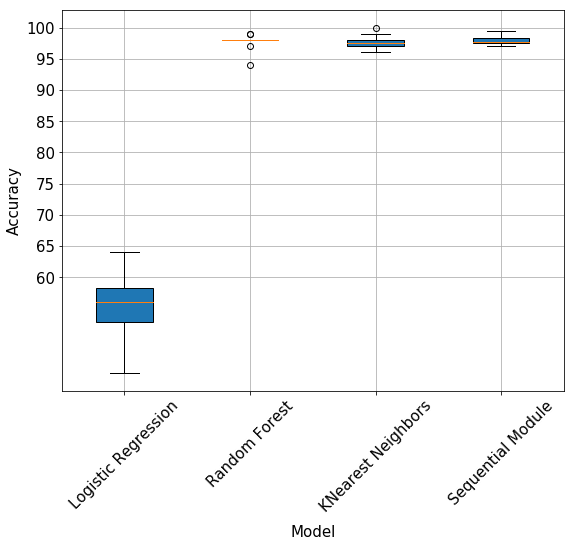

In [58]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()
model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   knn_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100
]
model_names = [
   "Logistic Regression",
   "Random Forest",
   "KNearest Neighbors",
   "Sequential Module"
]

fontdict = {'fontsize': 15 }
# 'verticalalignment': 'baseline'}

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy", fontdict=fontdict)
ax.set_yticks(np.arange(60,101,5))
ax.set_xlabel("Model", fontdict=fontdict, labelpad=10)
plt.ylim()



_ = ax.set_xticklabels(model_names, rotation=45, fontdict=fontdict)
_ = ax.set_yticklabels(np.arange(60,101,5), fontdict=fontdict)
# _ = ax.set_xticklabels(model_names, rotation=45)